<div style="font-size: 8px;">

# Training and Evaluation: Individual Models

================================================================================
PURPOSE: Train and evaluate classifiers on features from each model separately
================================================================================

This notebook trains multiple classifiers on Context Tree features extracted
from individual transformer models. Each model (BERT, RoBERTa, DeBERTa, XLNet)
is evaluated separately to assess their individual performance on the clarity
and evasion classification tasks.

**Workflow:**
1. Load features from Google Drive (saved by 02_feature_extraction_separate.ipynb)
2. Train multiple classifiers on each model's features
3. Evaluate on Dev set (model selection and hyperparameter tuning)
4. Save predictions and probabilities for further analysis
5. Generate results tables and evaluation plots

**Classifiers:**
- Logistic Regression
- Linear Support Vector Classifier (LinearSVC)
- Random Forest
- XGBoost
- LightGBM

**Output:**
- Predictions (hard labels) and probabilities saved to Google Drive
- Results tables comparing classifiers for each model/task combination
- Evaluation plots (confusion matrices, PR curves, ROC curves)
- Results metadata saved for final summary generation

================================================================================
INPUTS (What this notebook loads)
================================================================================

**From GitHub:**
- Repository code (cloned automatically if not present)
- Source modules from `src/` directory:
  - `src.storage.manager` (StorageManager)
  - `src.models.trainer` (training and evaluation functions)
  - `src.models.classifiers` (classifier definitions)
  - `src.evaluation.tables` (final summary table functions)

**From Google Drive:**
- Dataset splits: `splits/dataset_splits.pkl`
  - Train split (for label extraction)
  - Dev split (for label extraction)
- Feature matrices: `features/raw/X_{split}_{model}_{task}.npy`
  - For each model (bert, roberta, deberta, xlnet)
  - For each task (clarity, evasion)
  - For Train and Dev splits
  - Loaded via `storage.load_features(model, task, split)`

**From HuggingFace Hub:**
- Nothing (all features already extracted)

================================================================================
OUTPUTS (What this notebook saves)
================================================================================

**To Google Drive:**
- Predictions: `predictions/pred_{split}_{model}_{classifier}_{task}.npy`
  - Hard label predictions for Dev set
  - For each model/classifier/task combination
- Probabilities: `features/probabilities/probs_{split}_{model}_{classifier}_{task}.npy`
  - Probability distributions for Dev set
  - For each model/classifier/task combination
- Evaluation plots: `plots/{model}_{task}_{classifier}/`
  - Confusion matrices
  - Precision-Recall curves
  - ROC curves
- Final summary tables: `results/tables/`
  - `final_summary_all_models_classifiers_tasks.{csv,html,png}`
  - `final_summary_model_wise.{csv,html,png}`
  - `final_summary_classifier_wise.{csv,html,png}`
- Complete results dictionary: `results/all_results_dev.pkl`

**To GitHub:**
- Results metadata: `results/{model}_{task}_separate.json`
  - Metrics for each classifier
  - Train/Dev sample counts
  - Timestamp information
- Results dictionary (JSON): `results/all_results_dev.json`

**Evaluation Metrics Computed and Printed:**
- Accuracy
- Macro Precision, Recall, F1
- Weighted Precision, Recall, F1
- Per-class metrics (precision, recall, F1, support)
- Cohen's Kappa
- Matthews Correlation Coefficient
- Hamming Loss
- Jaccard Score (IoU)
- Confusion Matrix

**What gets passed to next notebook:**
- All predictions and probabilities saved to persistent storage
- Final summary tables (CSV, HTML, PNG formats)
- Results metadata for comparison with fusion approaches

</div>


In [1]:
# ============================================================================
# SETUP: Repository Clone, Drive Mount, and Path Configuration
# ============================================================================
# This cell performs minimal setup required for the notebook to run:
# 1. Clones repository from GitHub (if not already present)
# 2. Mounts Google Drive for persistent data storage
# 3. Configures Python paths and initializes StorageManager
# NOTE: Data splits are NOT loaded here - they are loaded per-task in the training loop

import shutil
import os
import subprocess
import time
import requests
import zipfile
import sys
import numpy as np
from pathlib import Path
from google.colab import drive

# Repository configuration
repo_dir = '/content/semeval-context-tree-modular'
repo_url = 'https://github.com/EonTechie/semeval-context-tree-modular.git'
zip_url = 'https://github.com/EonTechie/semeval-context-tree-modular/archive/refs/heads/main.zip'

# Clone repository (if not already present)
if not os.path.exists(repo_dir):
    print("Cloning repository from GitHub...")
    max_retries = 2
    clone_success = False

    for attempt in range(max_retries):
        try:
            result = subprocess.run(
                ['git', 'clone', repo_url],
                cwd='/content',
                capture_output=True,
                text=True,
                timeout=60
            )
            if result.returncode == 0:
                print("Repository cloned successfully via git")
                clone_success = True
                break
            else:
                if attempt < max_retries - 1:
                    time.sleep(3)
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(3)

    # Fallback: Download as ZIP if git clone fails
    if not clone_success:
        print("Git clone failed. Downloading repository as ZIP archive...")
        zip_path = '/tmp/repo.zip'
        try:
            response = requests.get(zip_url, stream=True, timeout=60)
            response.raise_for_status()
            with open(zip_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall('/content')
            extracted_dir = '/content/semeval-context-tree-modular-main'
            if os.path.exists(extracted_dir):
                os.rename(extracted_dir, repo_dir)
            os.remove(zip_path)
            print("Repository downloaded and extracted successfully")
        except Exception as e:
            raise RuntimeError(f"Failed to obtain repository: {e}")

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass  # Already mounted

# Configure paths
BASE_PATH = Path('/content/semeval-context-tree-modular')
DATA_PATH = Path('/content/drive/MyDrive/semeval_data')

# Verify repository structure exists
if not BASE_PATH.exists():
    raise RuntimeError(f"Repository directory not found: {BASE_PATH}")
if not (BASE_PATH / 'src').exists():
    raise RuntimeError(f"src directory not found in repository: {BASE_PATH / 'src'}")
if not (BASE_PATH / 'src' / 'storage' / 'manager.py').exists():
    raise RuntimeError(f"Required file not found: {BASE_PATH / 'src' / 'storage' / 'manager.py'}")

# Add repository to Python path
sys.path.insert(0, str(BASE_PATH))

# Verify imports work
try:
    from src.storage.manager import StorageManager
    from src.models.trainer import train_and_evaluate
    from src.models.classifiers import get_classifier_dict
except ImportError as e:
    raise ImportError(
        f"Failed to import required modules. "
        f"Repository path: {BASE_PATH}, "
        f"Python path: {sys.path[:3]}, "
        f"Error: {e}"
    )

# Initialize StorageManager
storage = StorageManager(
    base_path=str(BASE_PATH),
    data_path=str(DATA_PATH),
    github_path=str(BASE_PATH)
)

print("Setup complete")
print(f"  Repository: {BASE_PATH}")
print(f"  Data storage: {DATA_PATH}")
print(f"\nNOTE: Data splits will be loaded per-task in the training loop")
print(f"      Clarity and Evasion have different splits (Evasion uses majority voting)")


Cloning repository from GitHub...
Repository cloned successfully via git
Mounted at /content/drive
Setup complete
  Repository: /content/semeval-context-tree-modular
  Data storage: /content/drive/MyDrive/semeval_data

NOTE: Data splits will be loaded per-task in the training loop
      Clarity and Evasion have different splits (Evasion uses majority voting)


In [2]:
# ============================================================================
# REPRODUCIBILITY SETUP: Set Random Seeds for All Libraries
# ============================================================================
# This cell sets random seeds for Python, NumPy, PyTorch, and HuggingFace
# to ensure reproducible results across all runs.
#
# IMPORTANT: Run this cell FIRST before any other code that uses randomness.
# Seed value: 42 (same as used in all other parts of the pipeline)

from src.utils.reproducibility import set_all_seeds

# Set all random seeds to 42 for full reproducibility
# deterministic=True ensures PyTorch operations are deterministic (slower but fully reproducible)
set_all_seeds(seed=42, deterministic=True)

print("✓ Reproducibility configured: All random seeds set to 42")
print("✓ PyTorch deterministic mode enabled")
print("\nNOTE: If you encounter performance issues or non-deterministic behavior,")
print("      you can set deterministic=False in set_all_seeds() call above.")


✓ Reproducibility seeds set to 42
✓ PyTorch deterministic mode enabled (may be slower)
✓ Reproducibility configured: All random seeds set to 42
✓ PyTorch deterministic mode enabled

NOTE: If you encounter performance issues or non-deterministic behavior,
      you can set deterministic=False in set_all_seeds() call above.


In [3]:
# ============================================================================
# CONFIGURE MODELS, TASKS, AND CLASSIFIERS
# ============================================================================
# Defines the models to evaluate, tasks to perform, and classifiers to train
# Label mappings are defined for clarity (3-class) and evasion (9-class) tasks

MODELS = ['bert', 'bert_political', 'bert_ambiguity', 'roberta', 'deberta', 'xlnet']
TASKS = ['clarity', 'evasion']

# Label mappings for each task
CLARITY_LABELS = ['Ambivalent', 'Clear Non-Reply', 'Clear Reply']
EVASION_LABELS = ['Claims ignorance', 'Clarification', 'Declining to answer',
                  'Deflection', 'Dodging', 'Explicit',
                  'General', 'Implicit', 'Partial/half-answer']

# Initialize classifiers with fixed random seed for reproducibility
classifiers = get_classifier_dict(random_state=42)

print("Configuration:")
print(f"  Models: {MODELS}")
print(f"  Tasks: {TASKS}")
print(f"  Classifiers: {list(classifiers.keys())}")
print(f"  Clarity labels: {len(CLARITY_LABELS)} classes")
print(f"  Evasion labels: {len(EVASION_LABELS)} classes")


Configuration:
  Models: ['bert', 'bert_political', 'bert_ambiguity', 'roberta', 'deberta', 'xlnet']
  Tasks: ['clarity', 'evasion']
  Classifiers: ['LogisticRegression', 'LinearSVC', 'RandomForest', 'MLP', 'XGBoost', 'LightGBM']
  Clarity labels: 3 classes
  Evasion labels: 9 classes


In [4]:
# ============================================================================
# LOAD PREVIOUS RESULTS (Skip if already loaded)
# ============================================================================
# This cell loads previously saved results from Drive
# Use this when you restart runtime and want to continue from hierarchical evaluation
# without re-running all training

# Check if all_results is already populated (from Cell 3)
if 'all_results' in globals() and all_results and len(all_results) > 0:
    print("="*80)
    print("RESULTS ALREADY LOADED")
    print("="*80)
    print(f"✓ all_results already contains {len(all_results)} models")
    print("  Skipping load - continuing with existing results")
    print("\nYou can proceed directly to hierarchical evaluation cell")
else:
    print("="*80)
    print("LOADING PREVIOUS RESULTS FROM DRIVE")
    print("="*80)

    # Try to load from Drive
    try:
        all_results = storage.load_all_results_dict(filename='all_results_dev.pkl')

        if all_results and len(all_results) > 0:
            print(f"✓ Successfully loaded results for {len(all_results)} models")
            for model in all_results:
                tasks = list(all_results[model].keys())
                print(f"  {model}: {tasks}")
            print("\n✓ You can now proceed to hierarchical evaluation cell")
            print("  Training is NOT needed - using saved results")
        else:
            print(" No saved results found in Drive")
            print("  You need to run Cell 3 (Training cell) first")
            print("  Or check if results were saved with a different filename")
    except Exception as e:
        print(f"✗ Error loading results: {e}")
        print("  You need to run Cell 3 (Training cell) first")
        raise


LOADING PREVIOUS RESULTS FROM DRIVE
✓ Successfully loaded results for 6 models
  bert: ['clarity', 'evasion', 'evasion_based_clarity']
  bert_political: ['clarity', 'evasion', 'evasion_based_clarity']
  bert_ambiguity: ['clarity', 'evasion', 'evasion_based_clarity']
  roberta: ['clarity', 'evasion', 'evasion_based_clarity']
  deberta: ['clarity', 'evasion', 'evasion_based_clarity']
  xlnet: ['clarity', 'evasion', 'evasion_based_clarity']

✓ You can now proceed to hierarchical evaluation cell
  Training is NOT needed - using saved results



Results Table: bert_clarity
        Classifier         Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest bert_clarity  0.582609  0.513378     0.572970         0.542882      0.495964
           XGBoost bert_clarity  0.579710  0.507448     0.572013         0.545275      0.487321
          LightGBM bert_clarity  0.585507  0.506654     0.572565         0.542787      0.487791
         LinearSVC bert_clarity  0.559420  0.444066     0.539029         0.452149      0.450083
LogisticRegression bert_clarity  0.447826  0.425782     0.463267         0.429716      0.480698
               MLP bert_clarity  0.605797  0.387793     0.522173         0.645576      0.395250

Per-Class Metrics: bert_clarity - RandomForest (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.648707 0.728814  0.686431      413
Clear Non-Reply   0.587302 0.420455  0.490066       88
    Clear Reply   0.392638 0.338624  0.363636      189



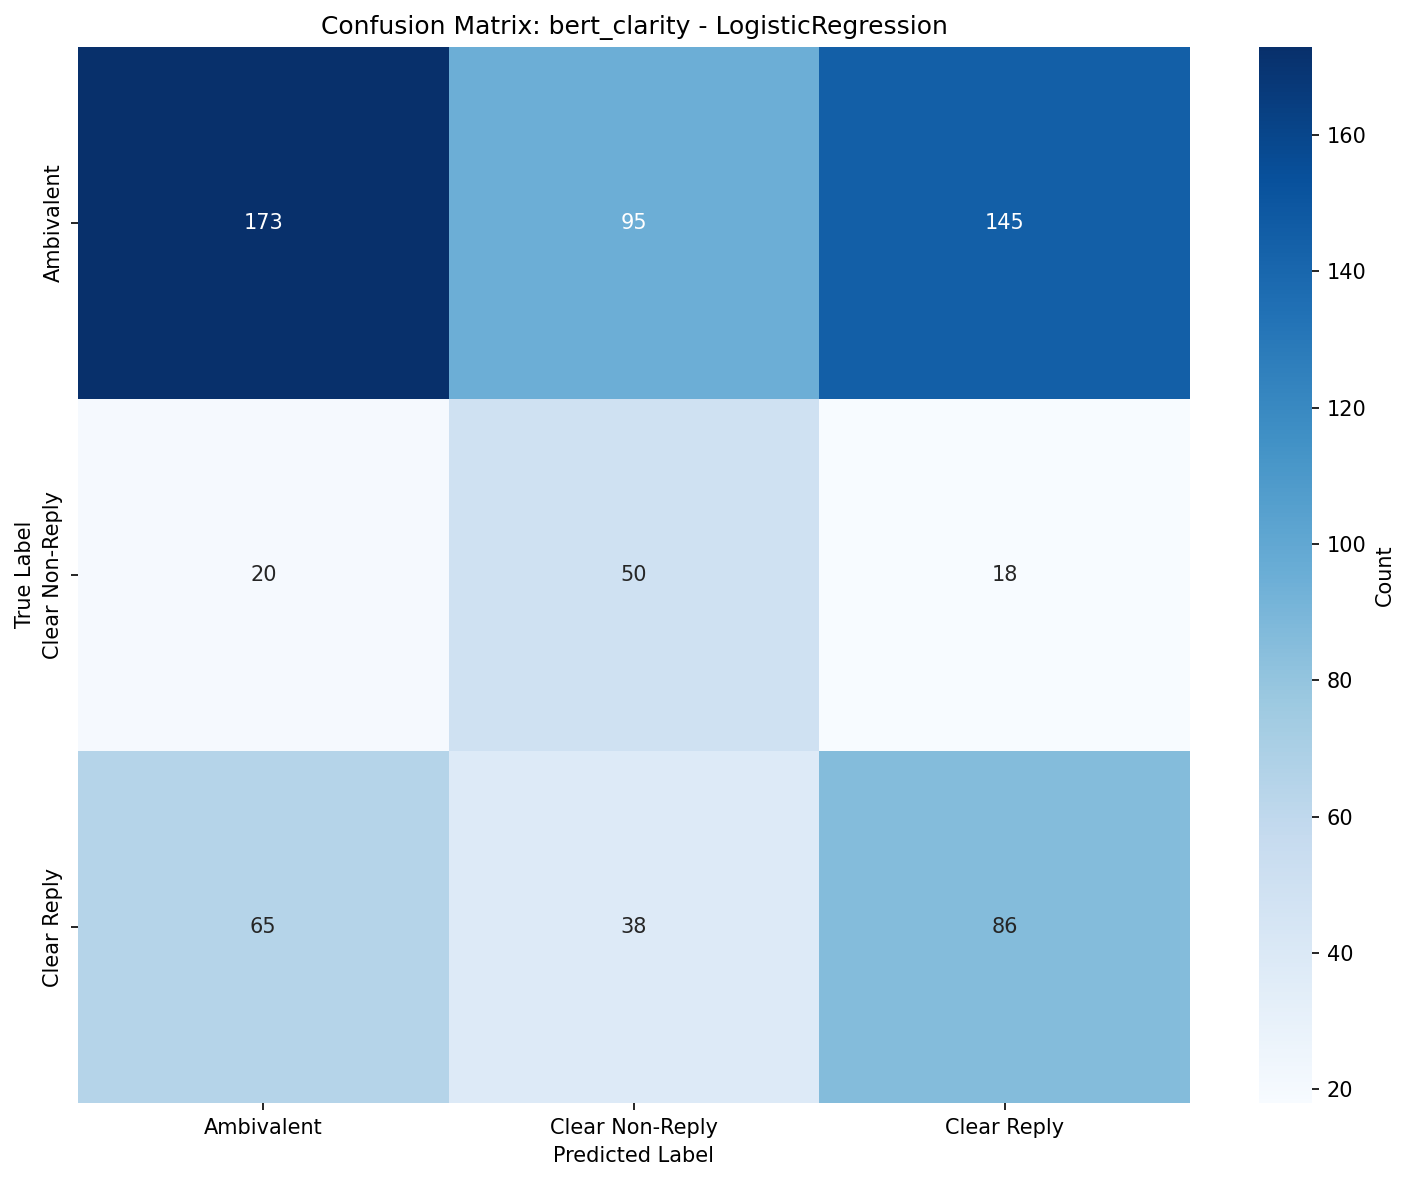

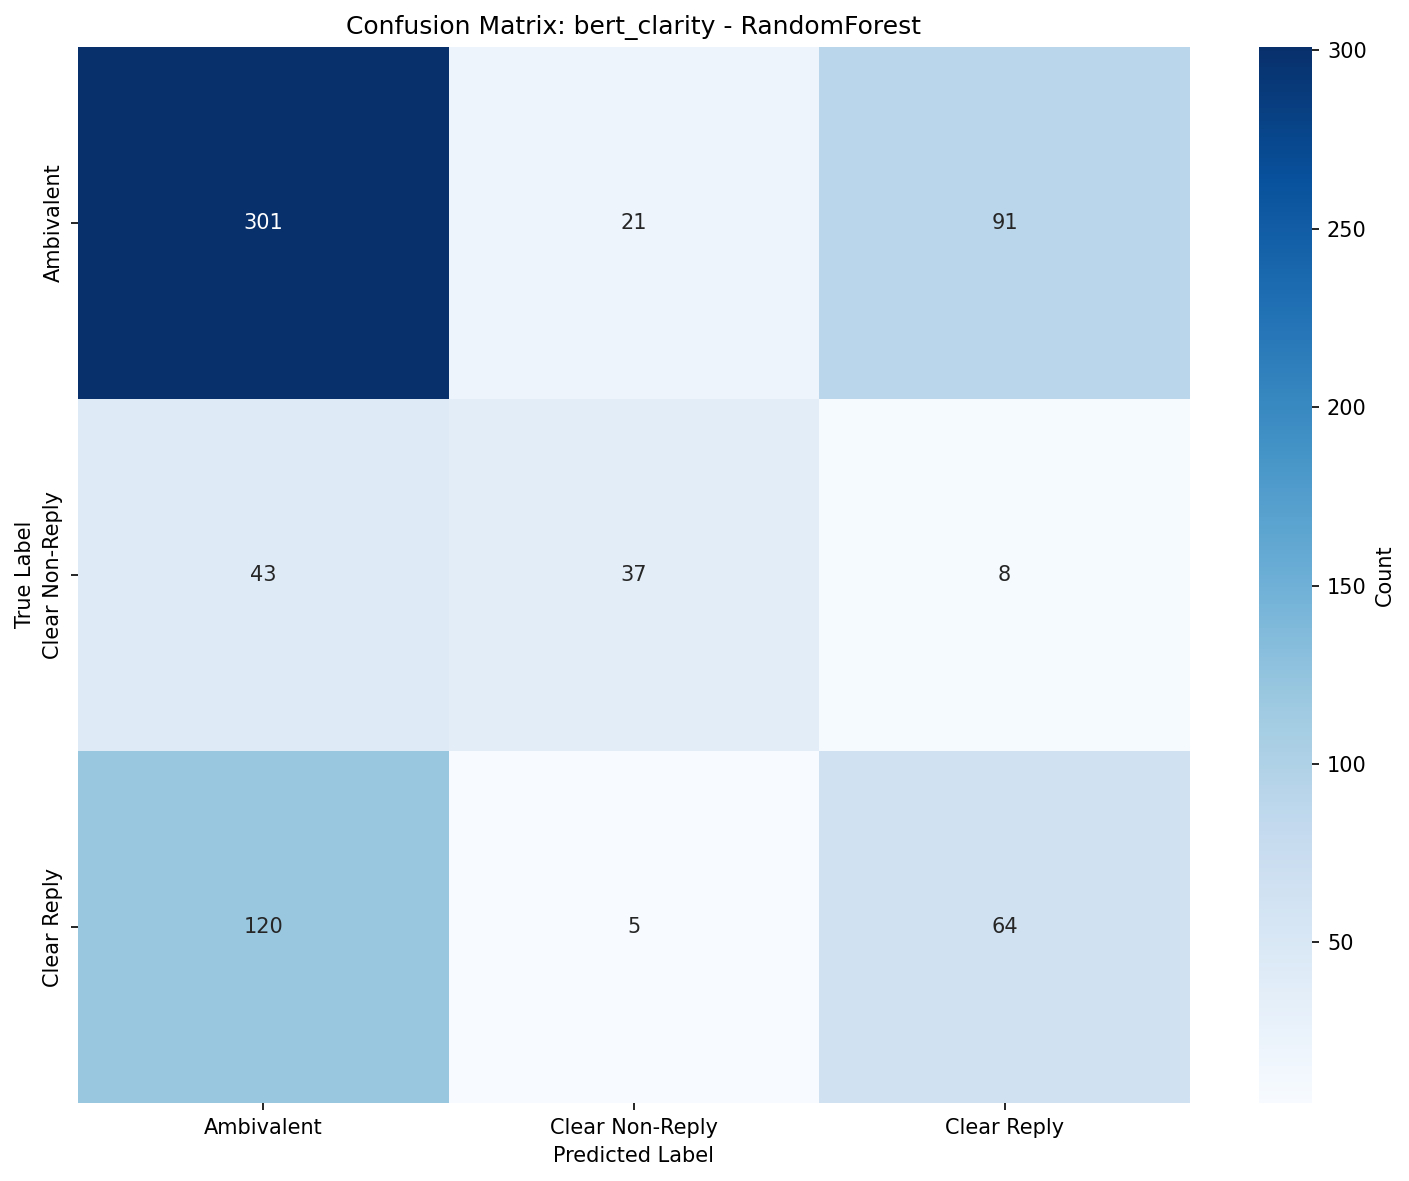

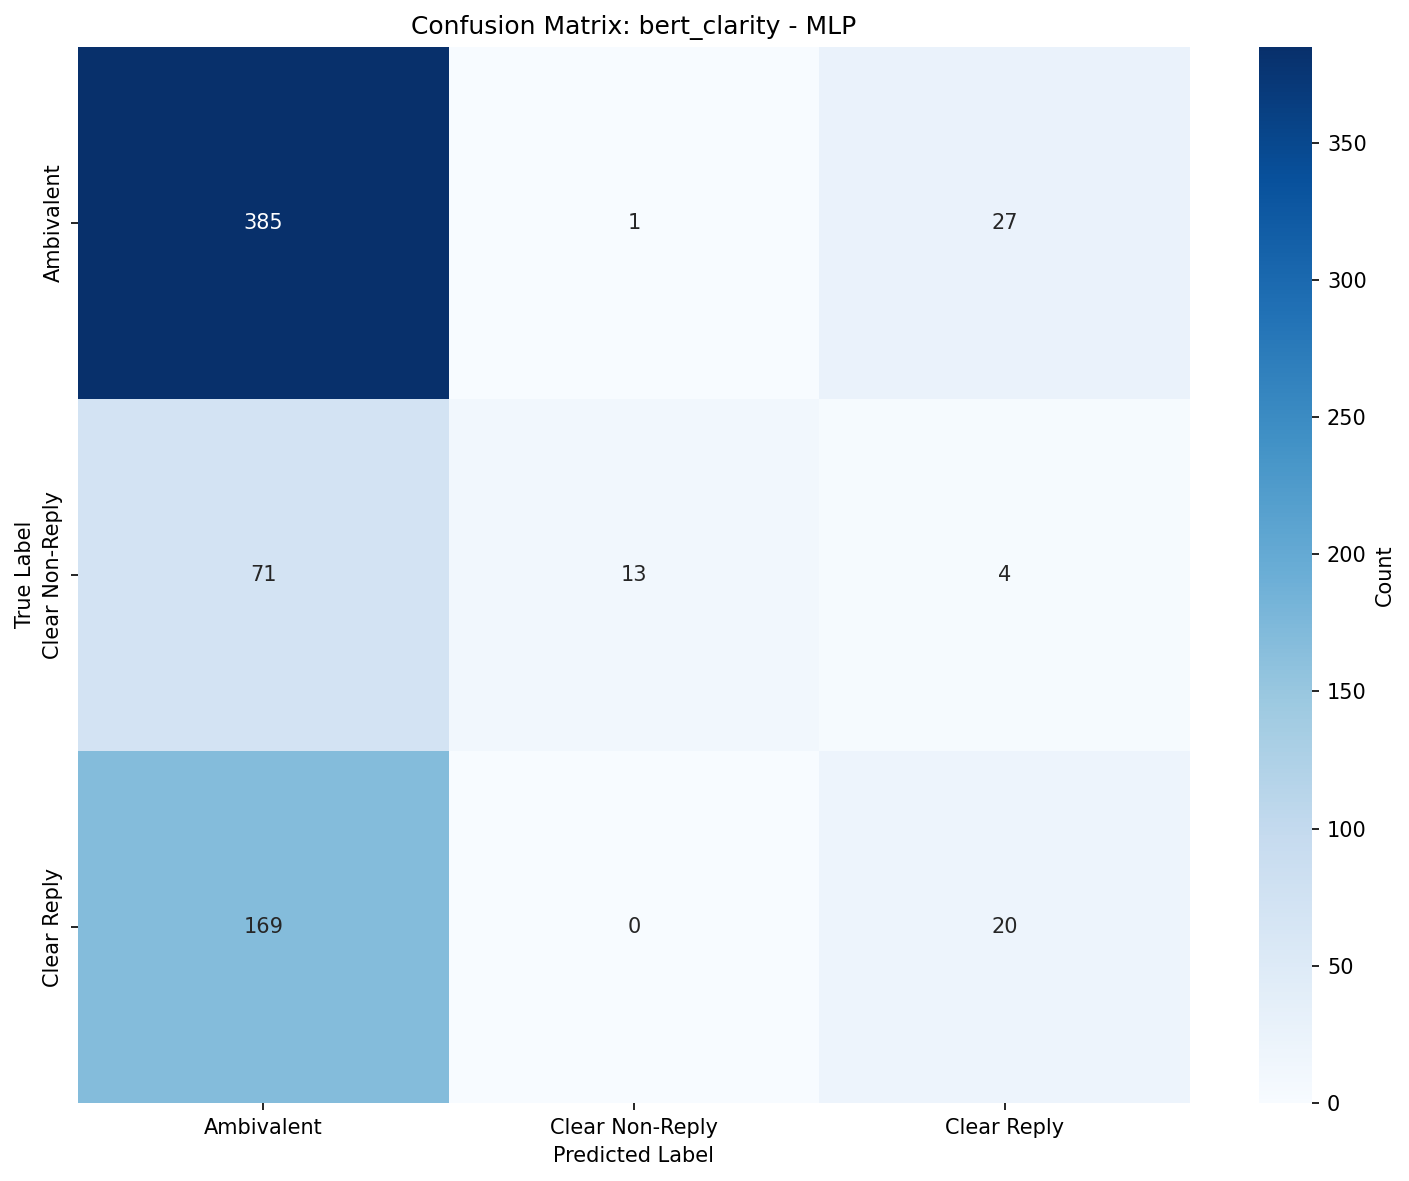

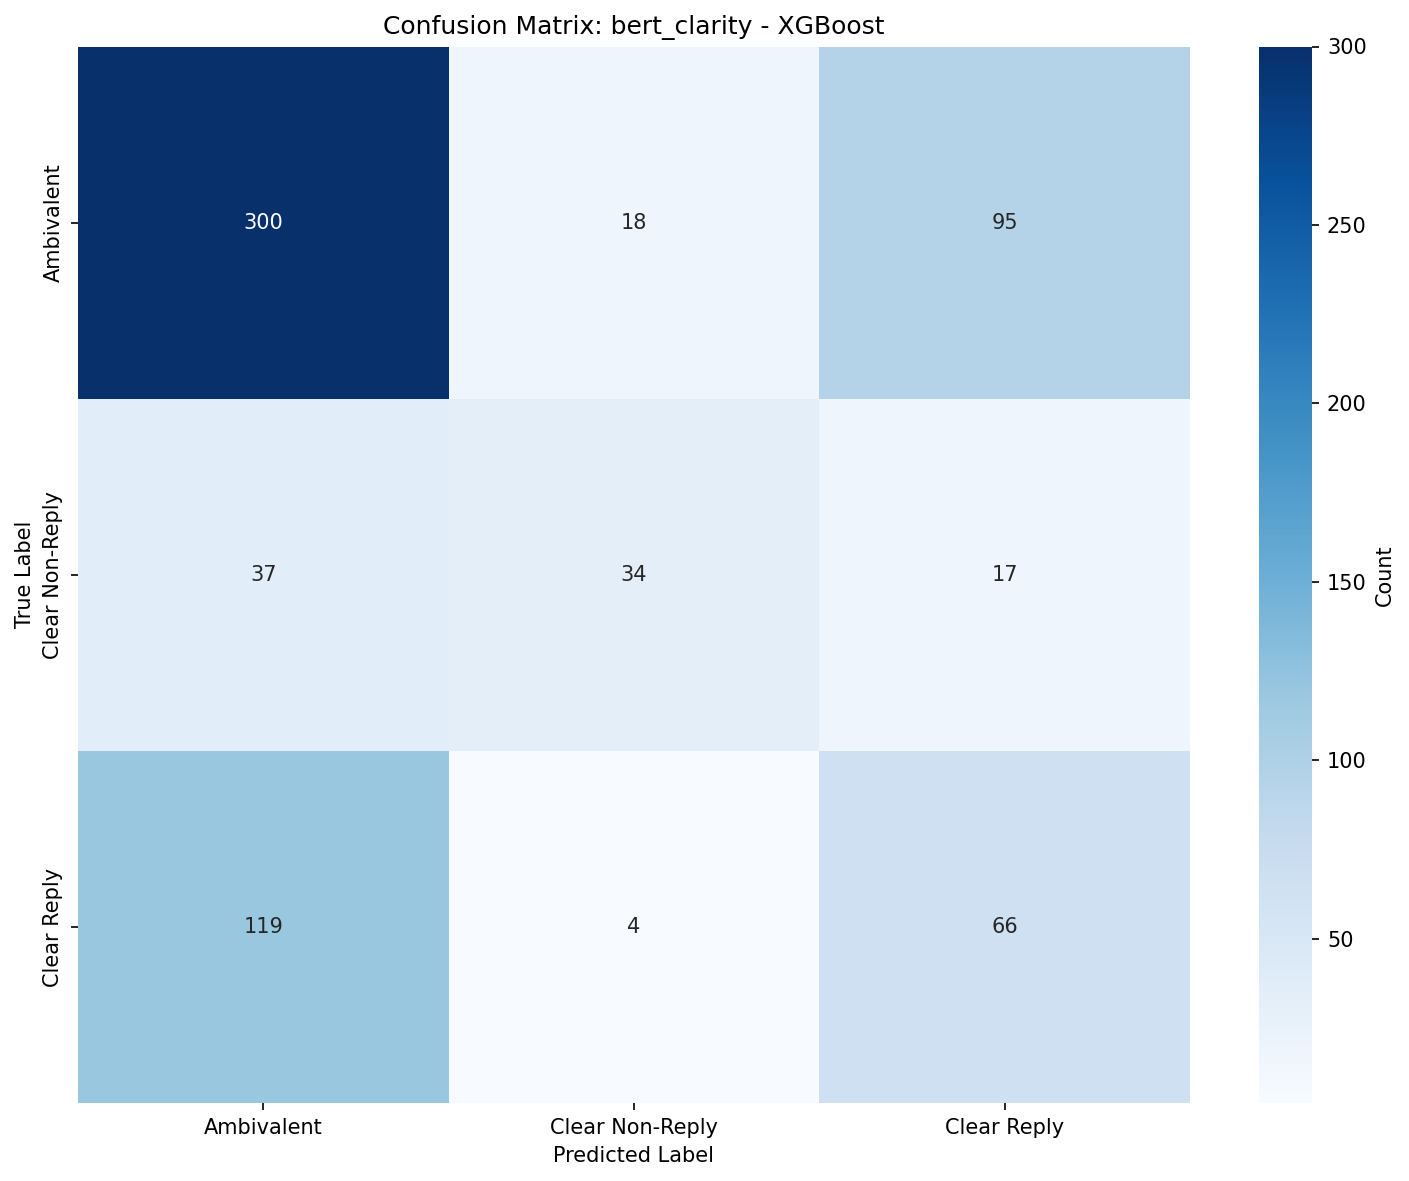

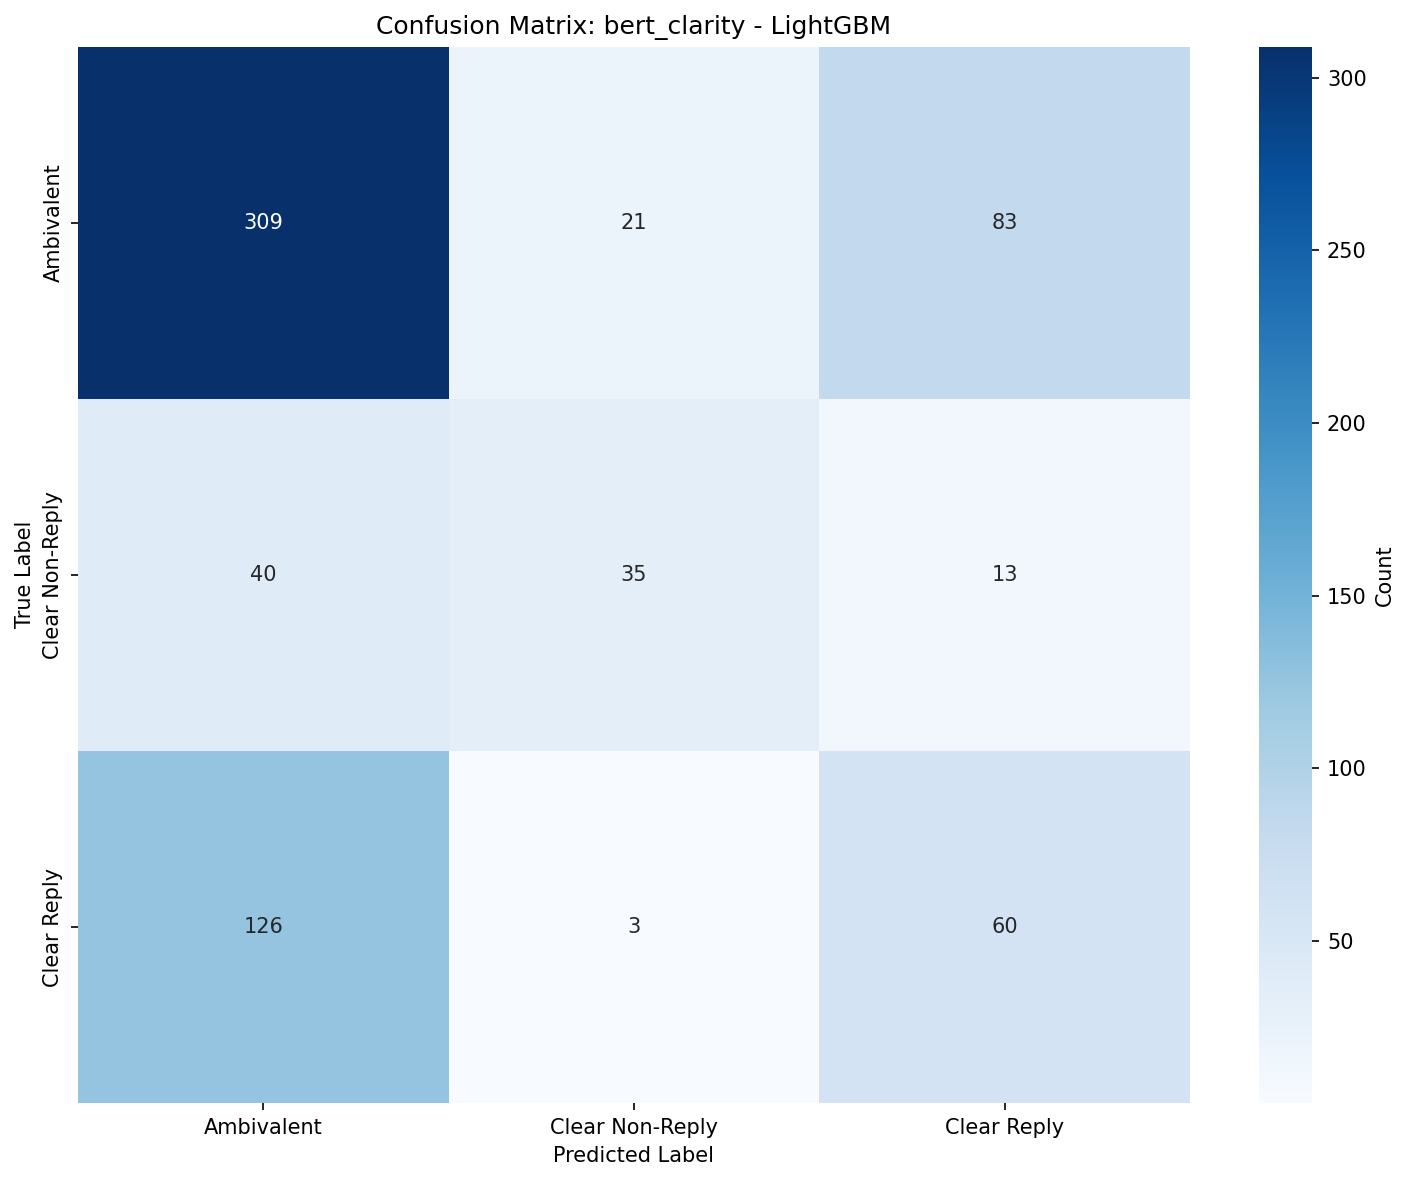


Results Table: bert_evasion
        Classifier         Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest bert_evasion  0.343478  0.312310     0.332792         0.354771      0.294268
          LightGBM bert_evasion  0.324638  0.298941     0.315489         0.354473      0.273890
           XGBoost bert_evasion  0.323188  0.296121     0.313917         0.334529      0.277922
         LinearSVC bert_evasion  0.240580  0.210076     0.237270         0.227239      0.272030
               MLP bert_evasion  0.304348  0.194253     0.253622         0.255760      0.192773
LogisticRegression bert_evasion  0.169565  0.176112     0.172932         0.186024      0.244194

Per-Class Metrics: bert_evasion - RandomForest (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.411765 0.259259  0.318182       27
      Clarification   0.761905 0.571429  0.653061       28
Declining to answer   0.500000 0.303030  0.377358      

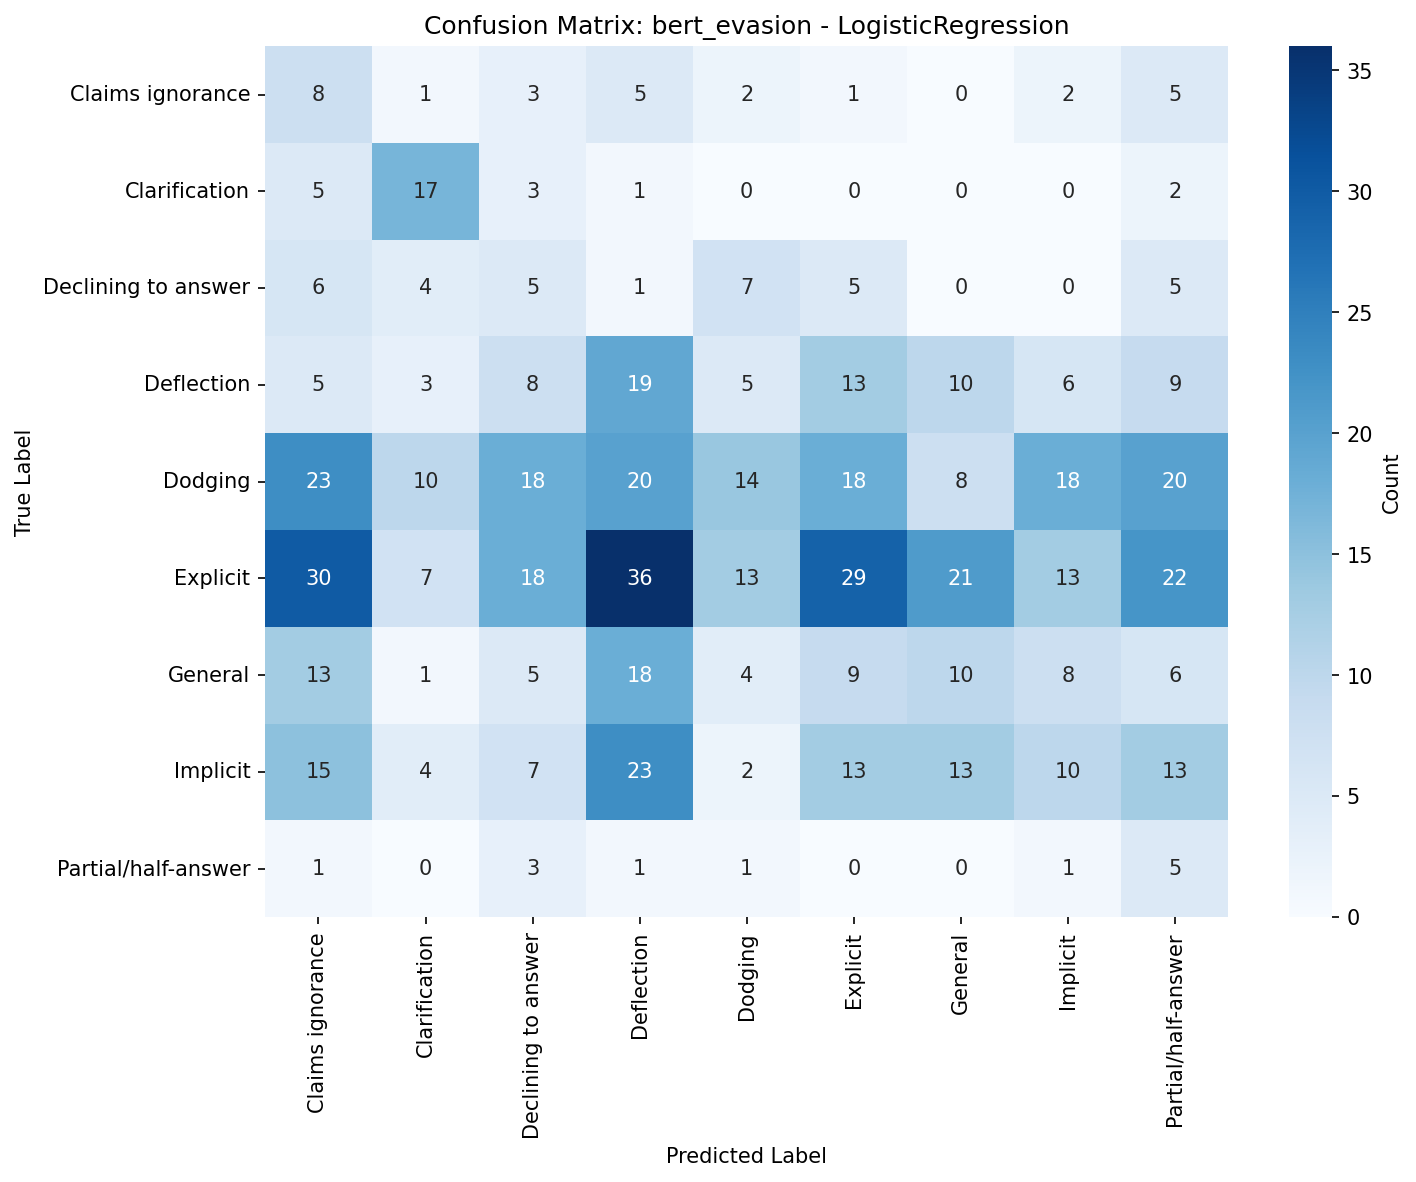

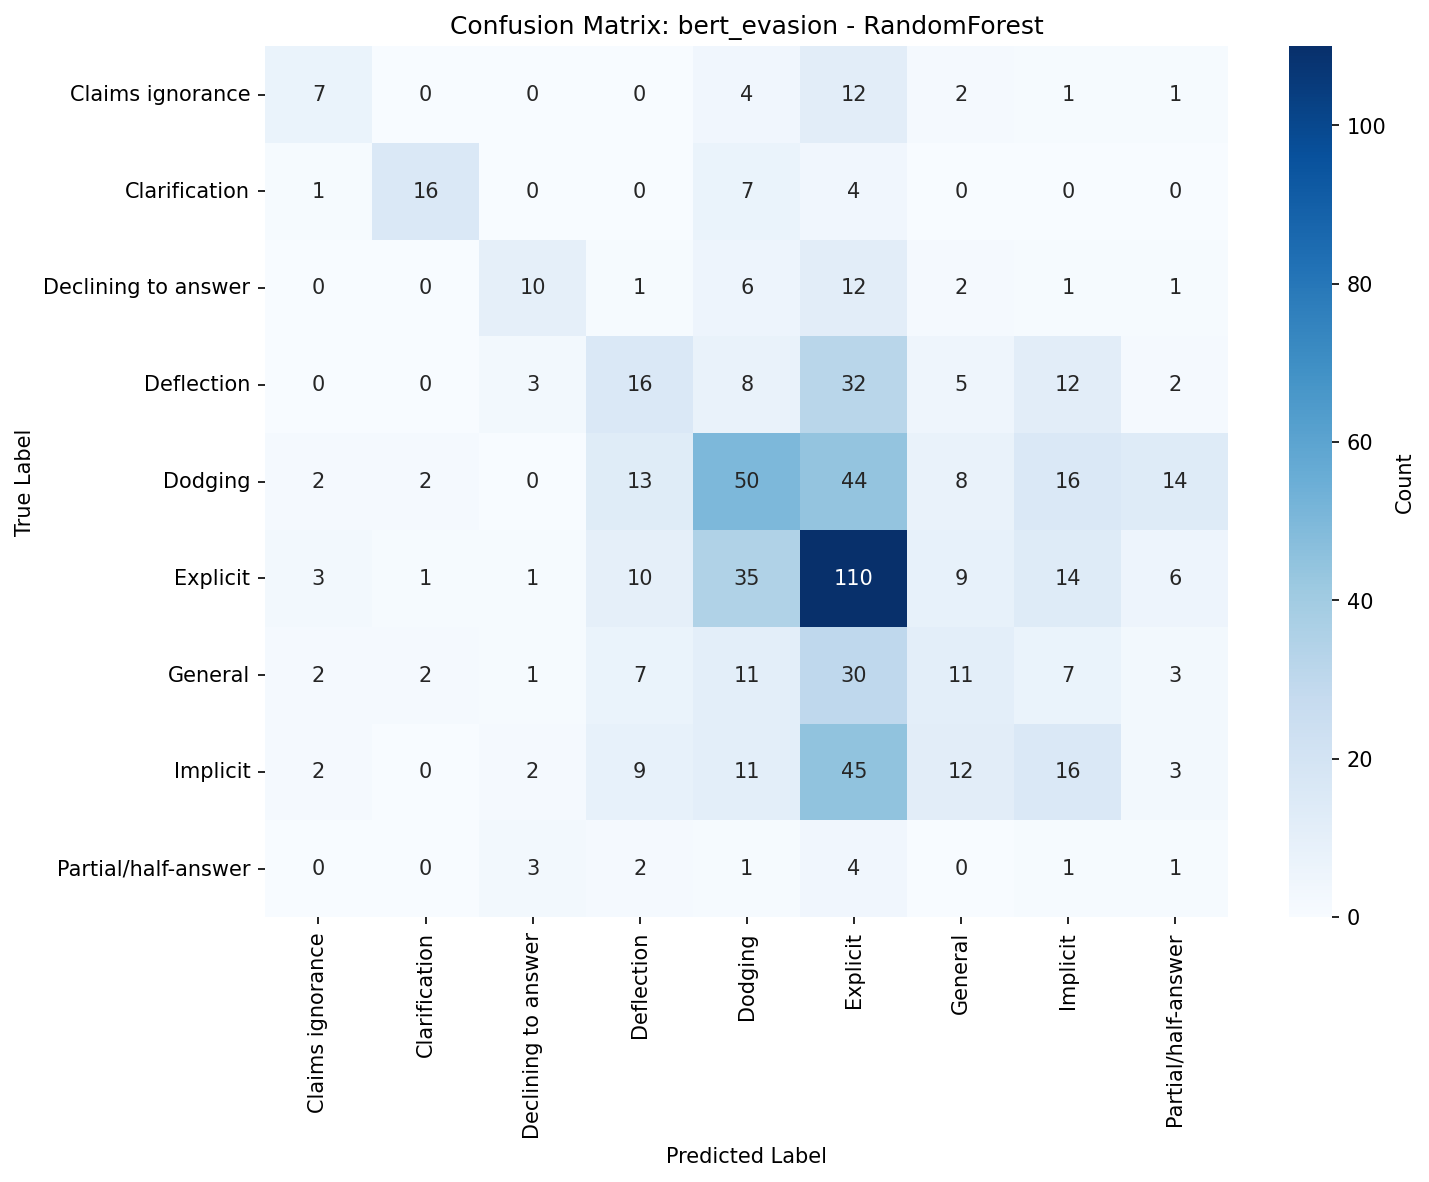

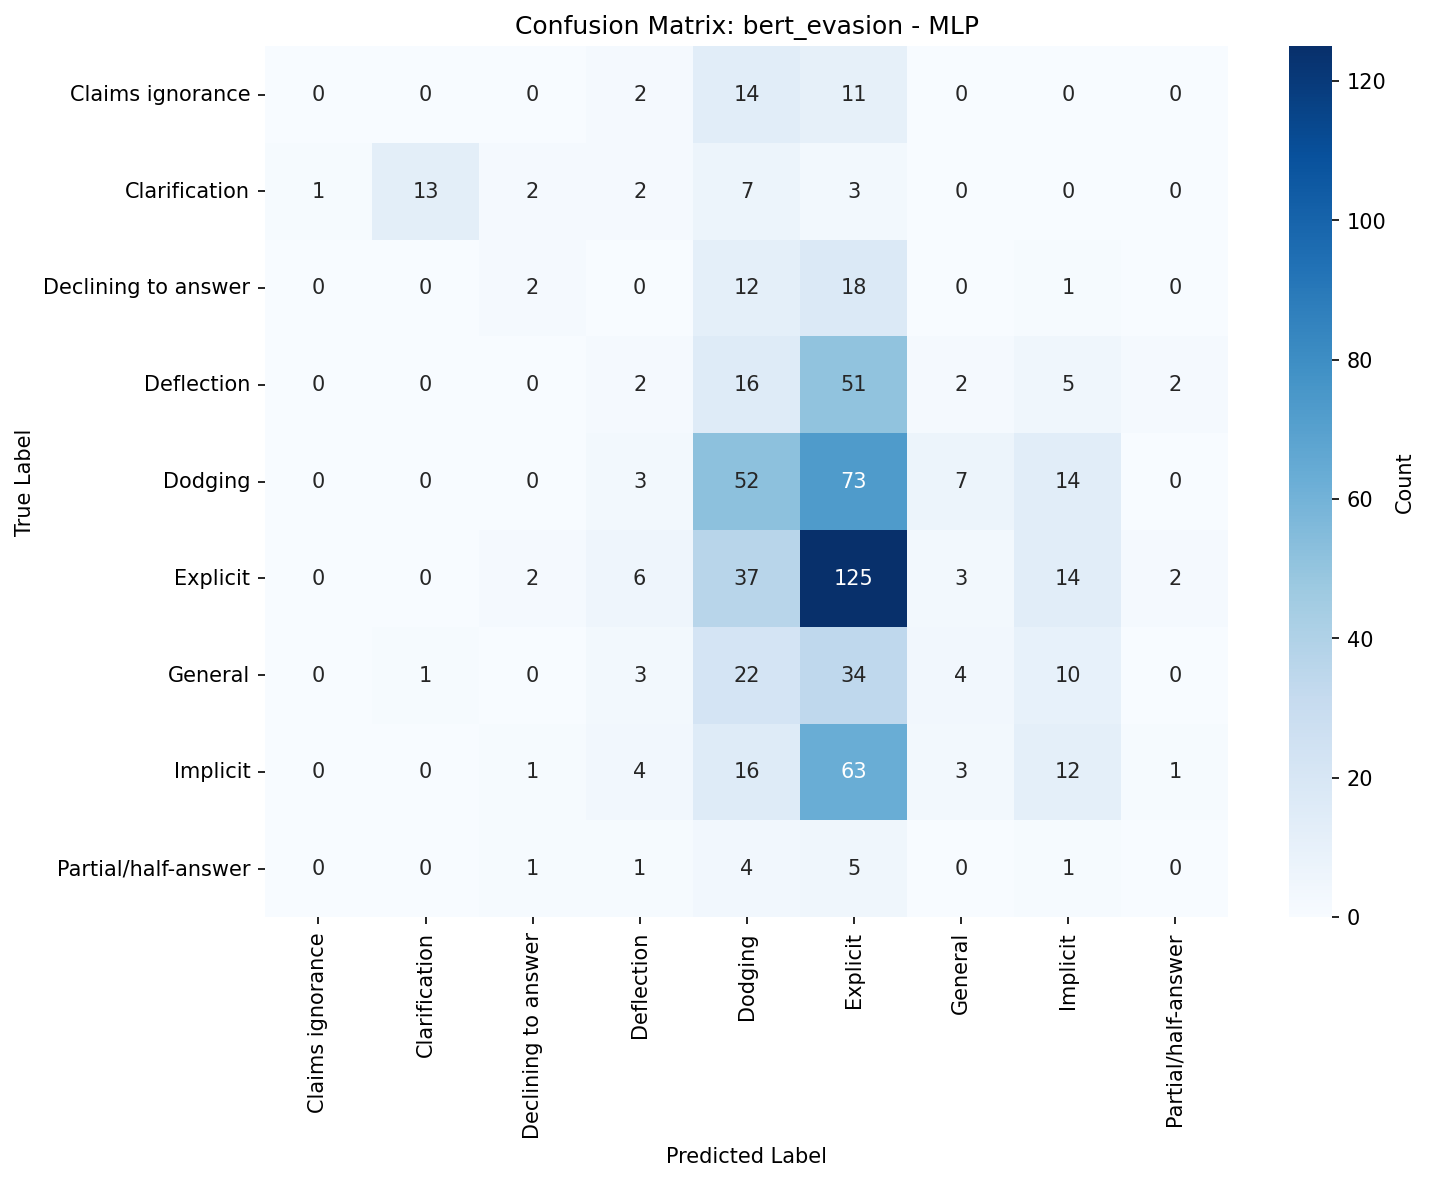

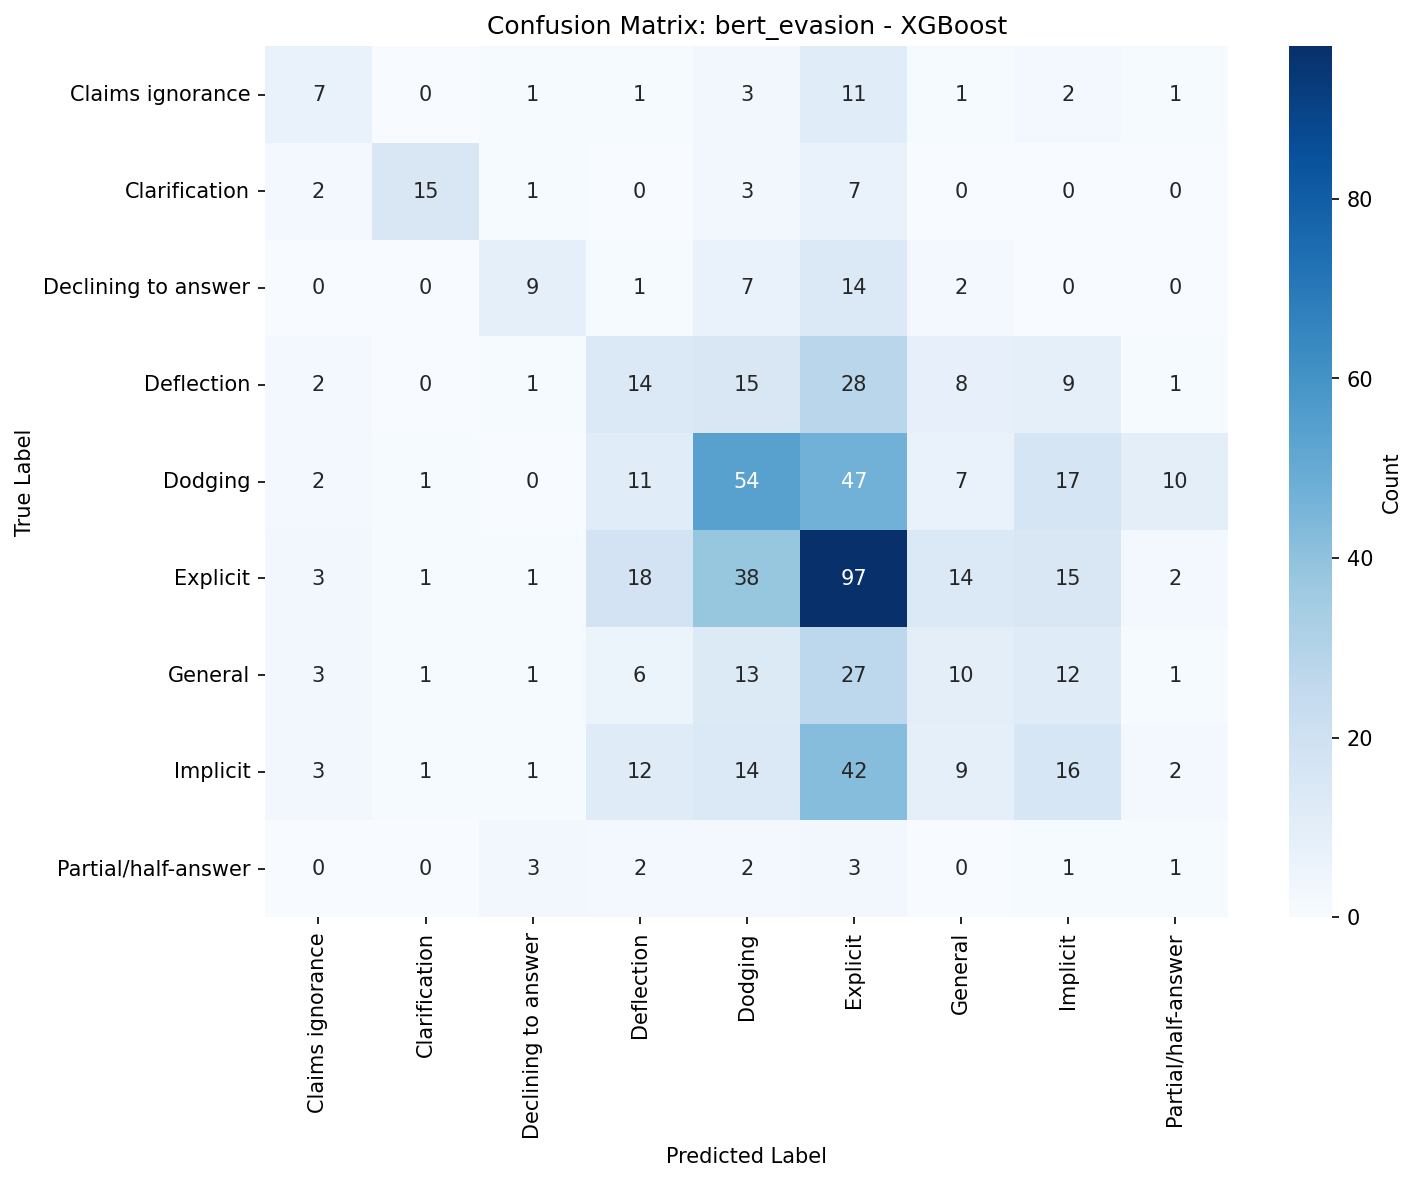

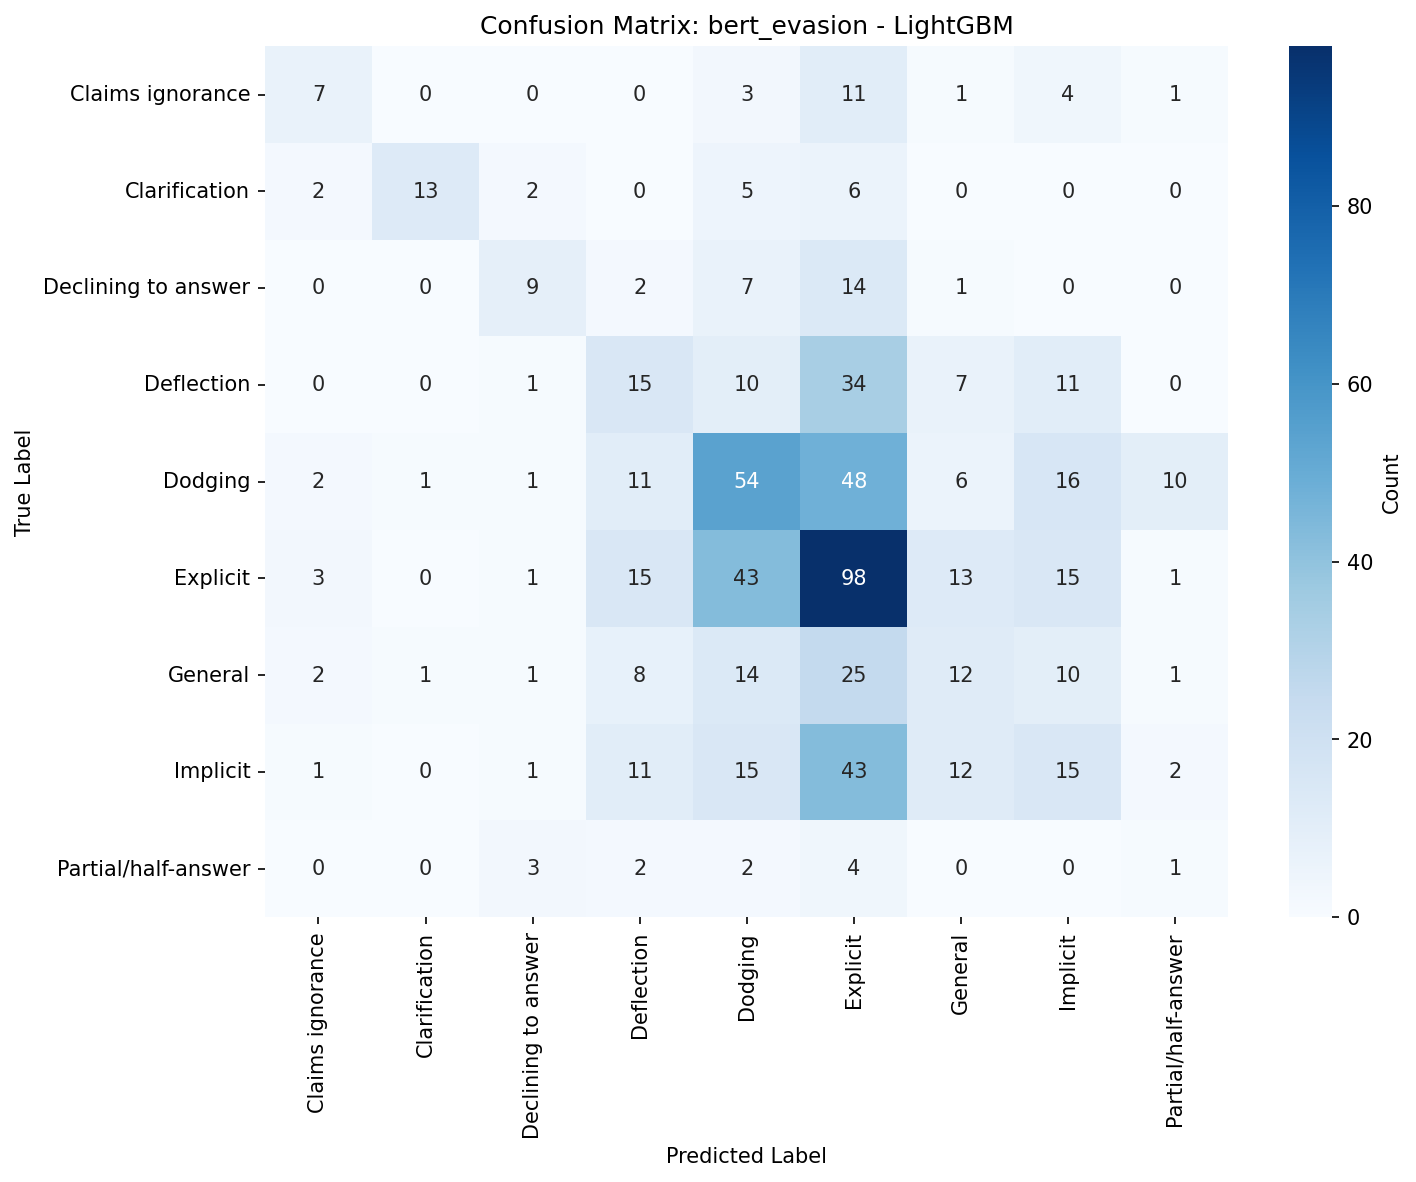


Results Table: bert_political_clarity
        Classifier                   Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
          LightGBM bert_political_clarity  0.607246  0.516362     0.589703         0.564572      0.494892
      RandomForest bert_political_clarity  0.589855  0.508782     0.575039         0.554076      0.487231
           XGBoost bert_political_clarity  0.589855  0.504722     0.576948         0.551257      0.483183
         LinearSVC bert_political_clarity  0.576812  0.465752     0.557806         0.482091      0.465396
LogisticRegression bert_political_clarity  0.440580  0.420330     0.455199         0.425623      0.478576
               MLP bert_political_clarity  0.614493  0.409079     0.537655         0.628968      0.409881

Per-Class Metrics: bert_political_clarity - LightGBM (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.661914 0.786925  0.719027      413
Clear Non-Reply   0.611111 0.375000 

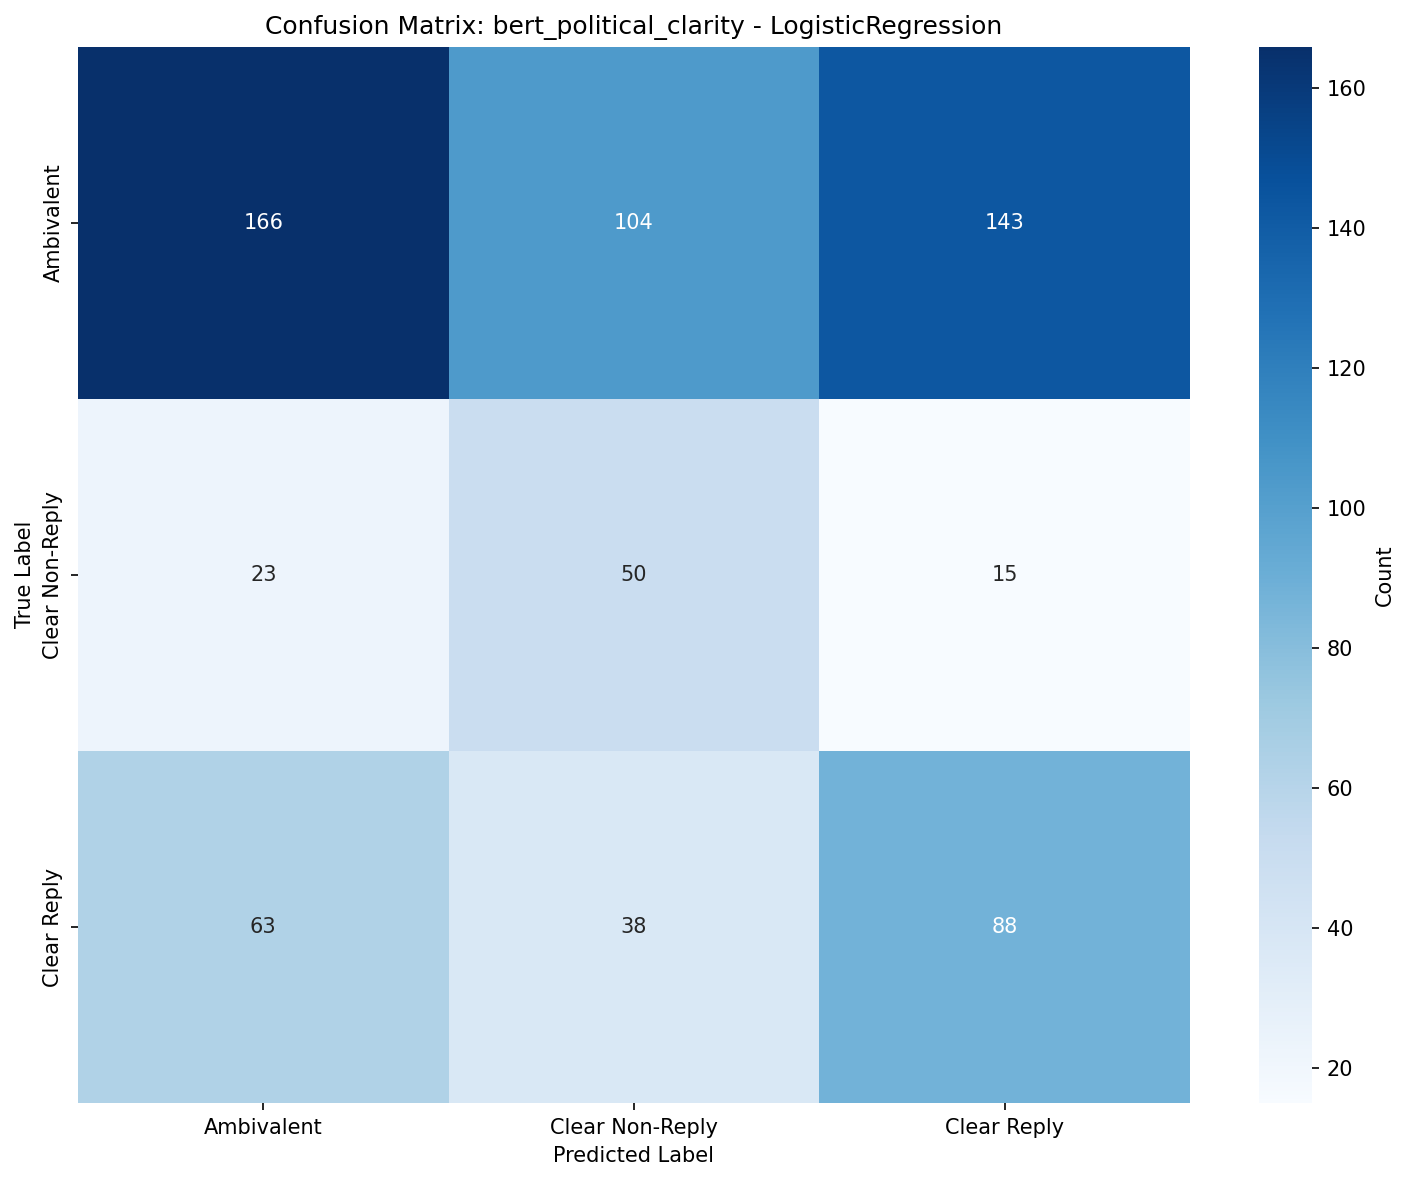

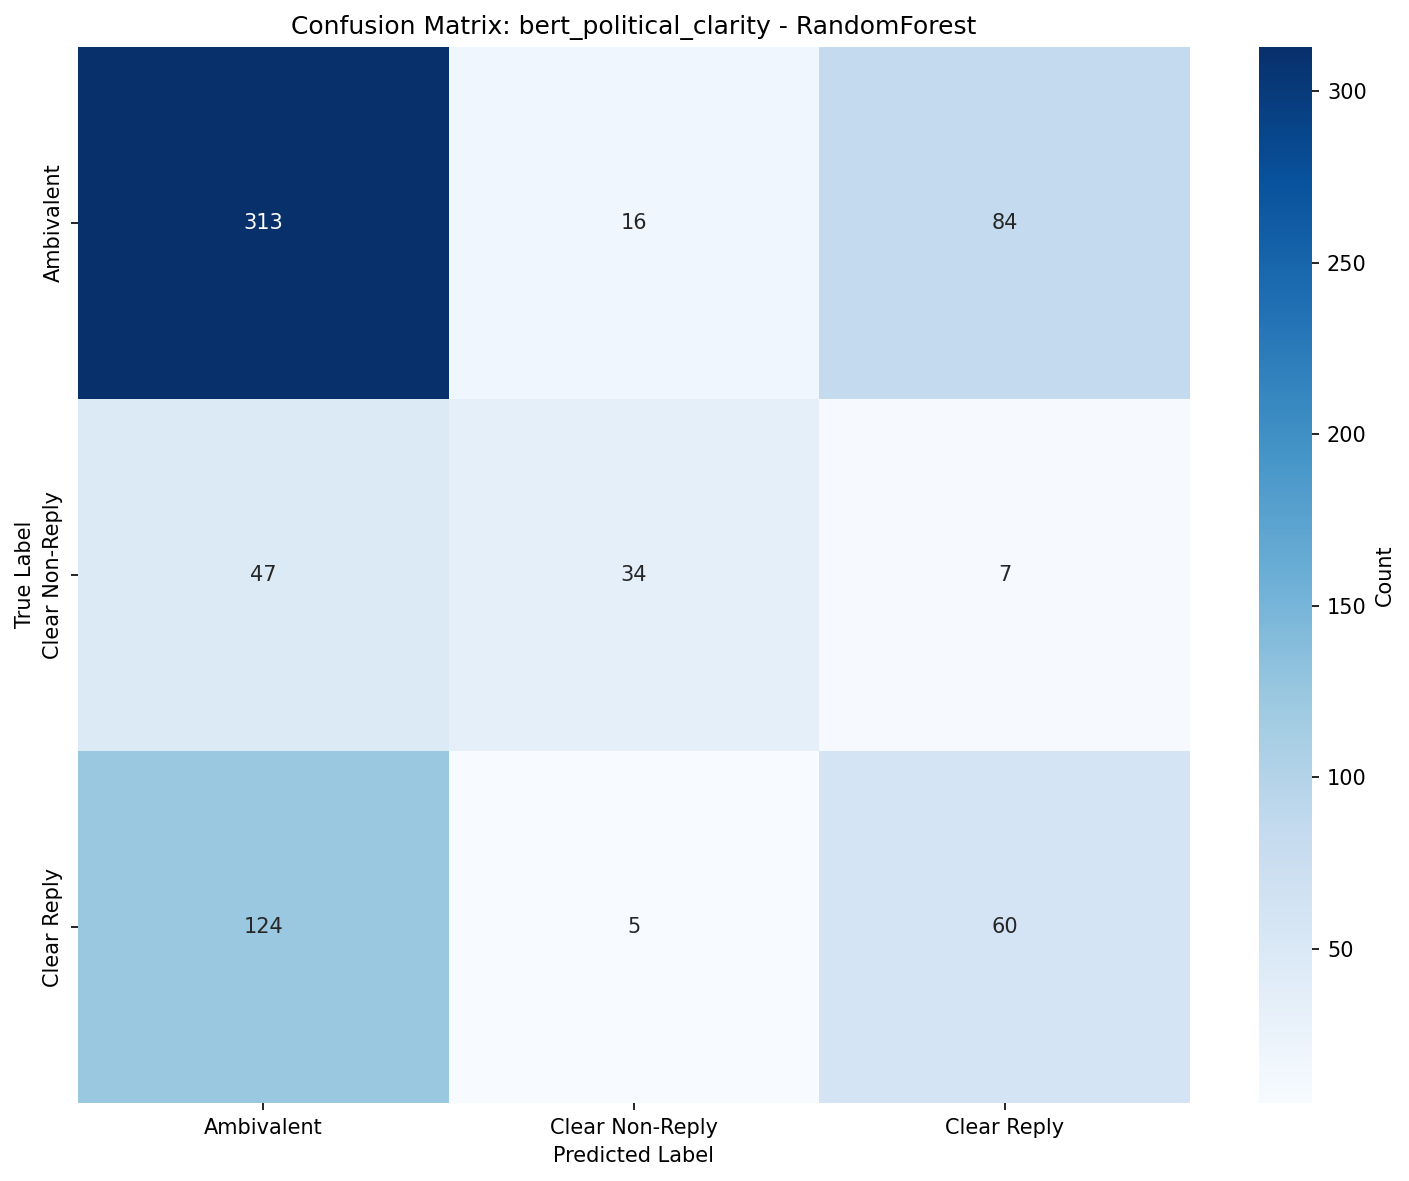

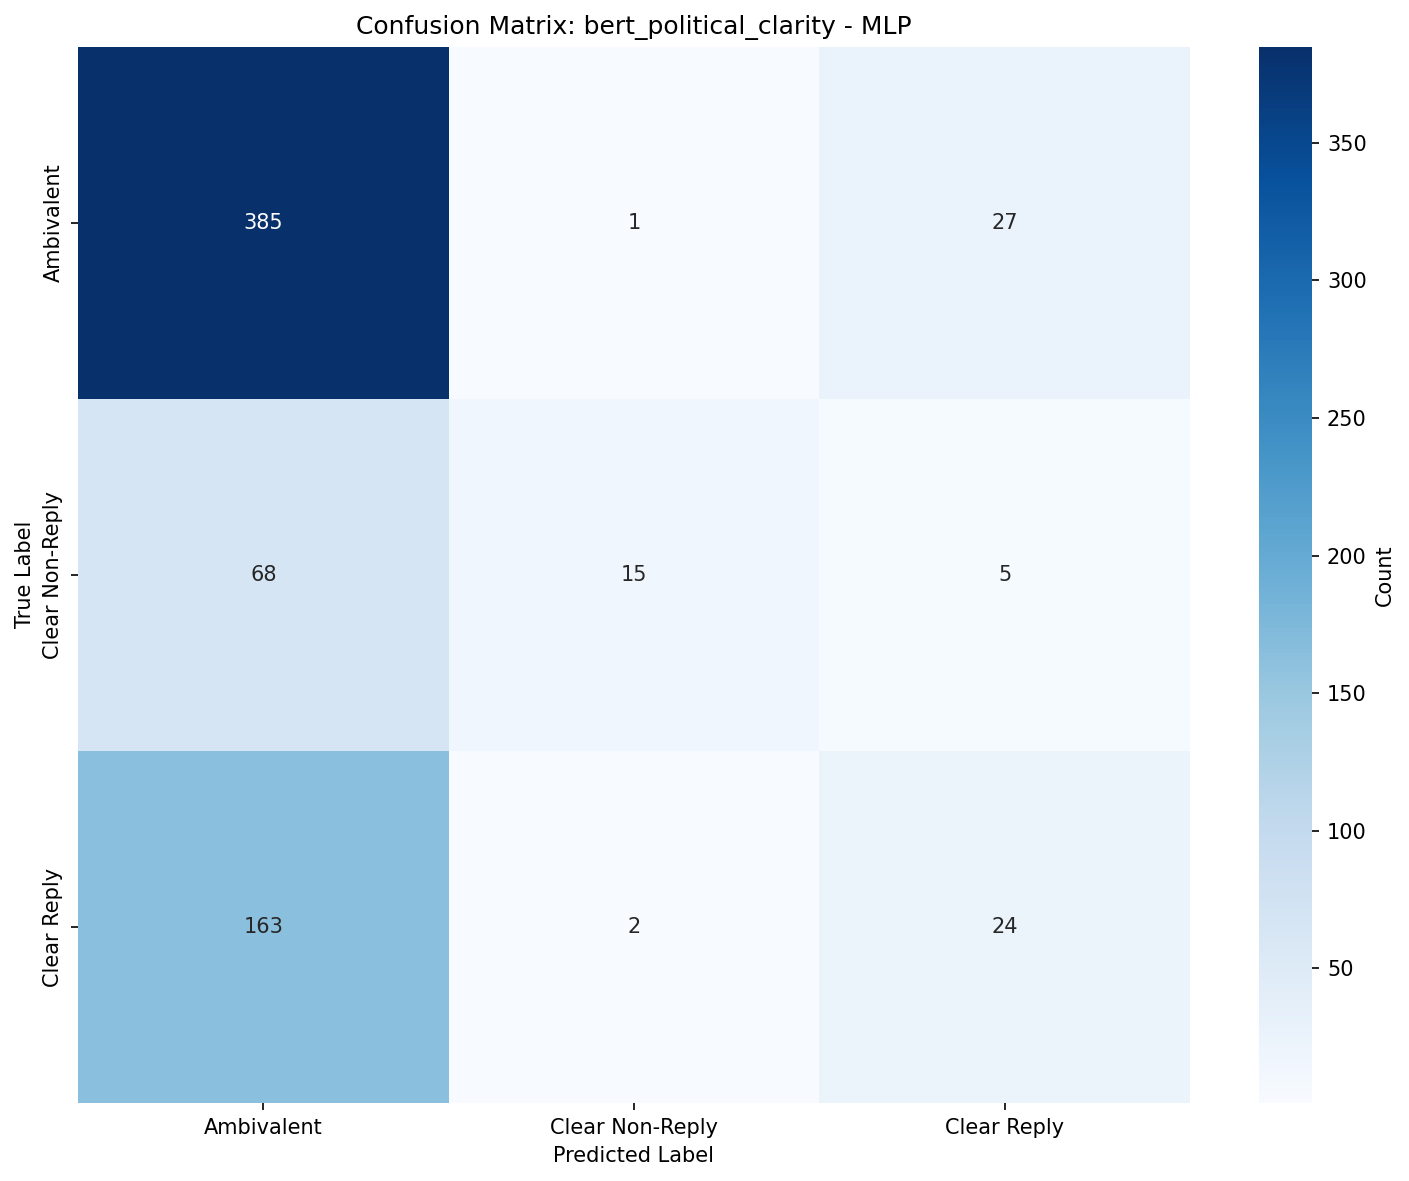

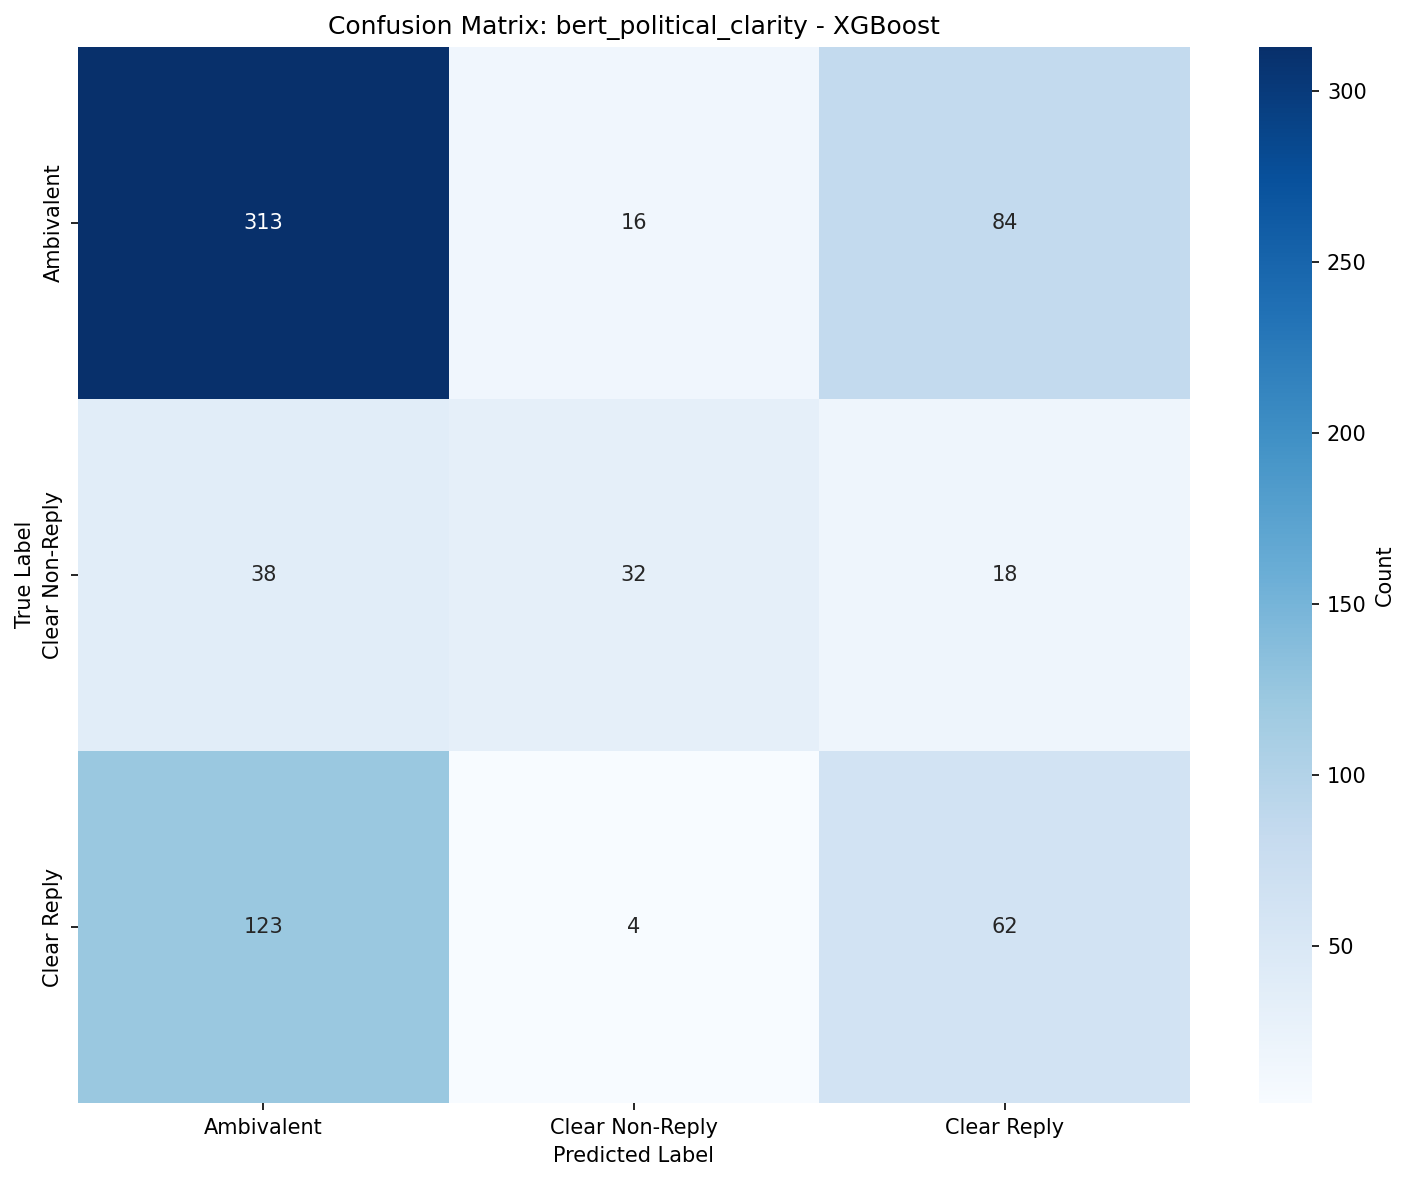

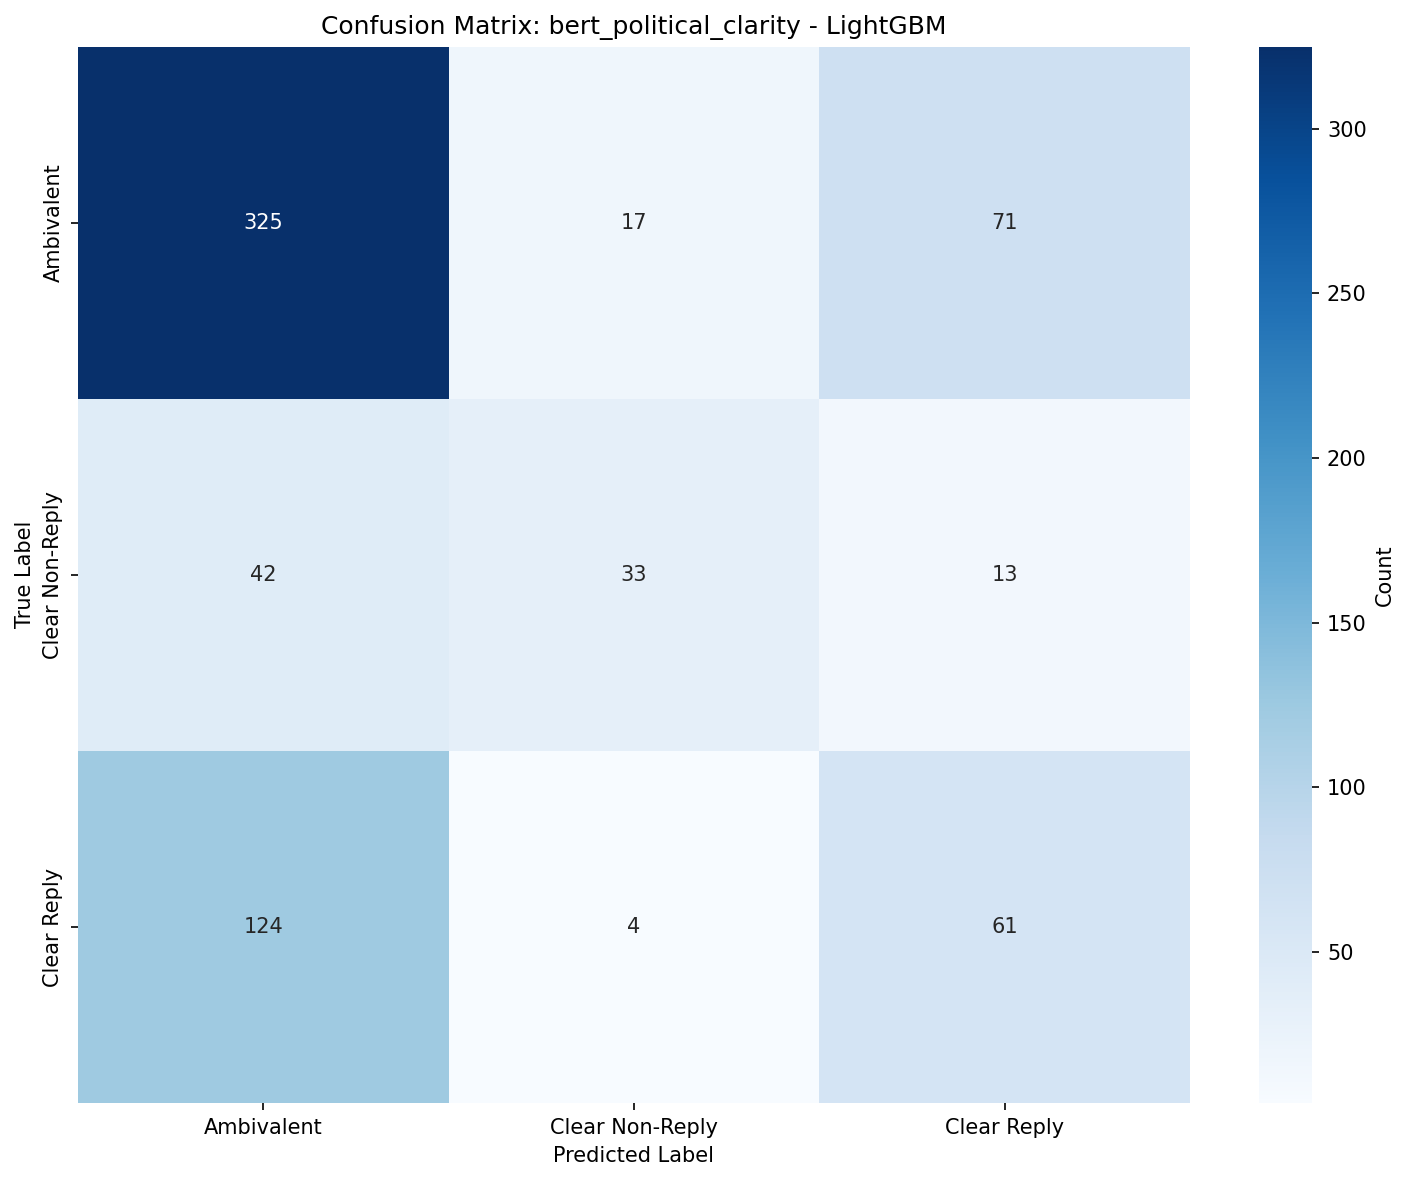


Results Table: bert_political_evasion
        Classifier                   Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
          LightGBM bert_political_evasion  0.349275  0.312771     0.338483         0.367270      0.288135
      RandomForest bert_political_evasion  0.336232  0.307754     0.326676         0.355564      0.287076
           XGBoost bert_political_evasion  0.330435  0.294645     0.319327         0.335543      0.275808
         LinearSVC bert_political_evasion  0.230435  0.198261     0.221284         0.212523      0.276144
LogisticRegression bert_political_evasion  0.185507  0.192060     0.185093         0.205230      0.279135
               MLP bert_political_evasion  0.315942  0.166345     0.223613         0.238687      0.186521

Per-Class Metrics: bert_political_evasion - LightGBM (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.333333 0.222222  0.266667       27
      Clarification   0.8235

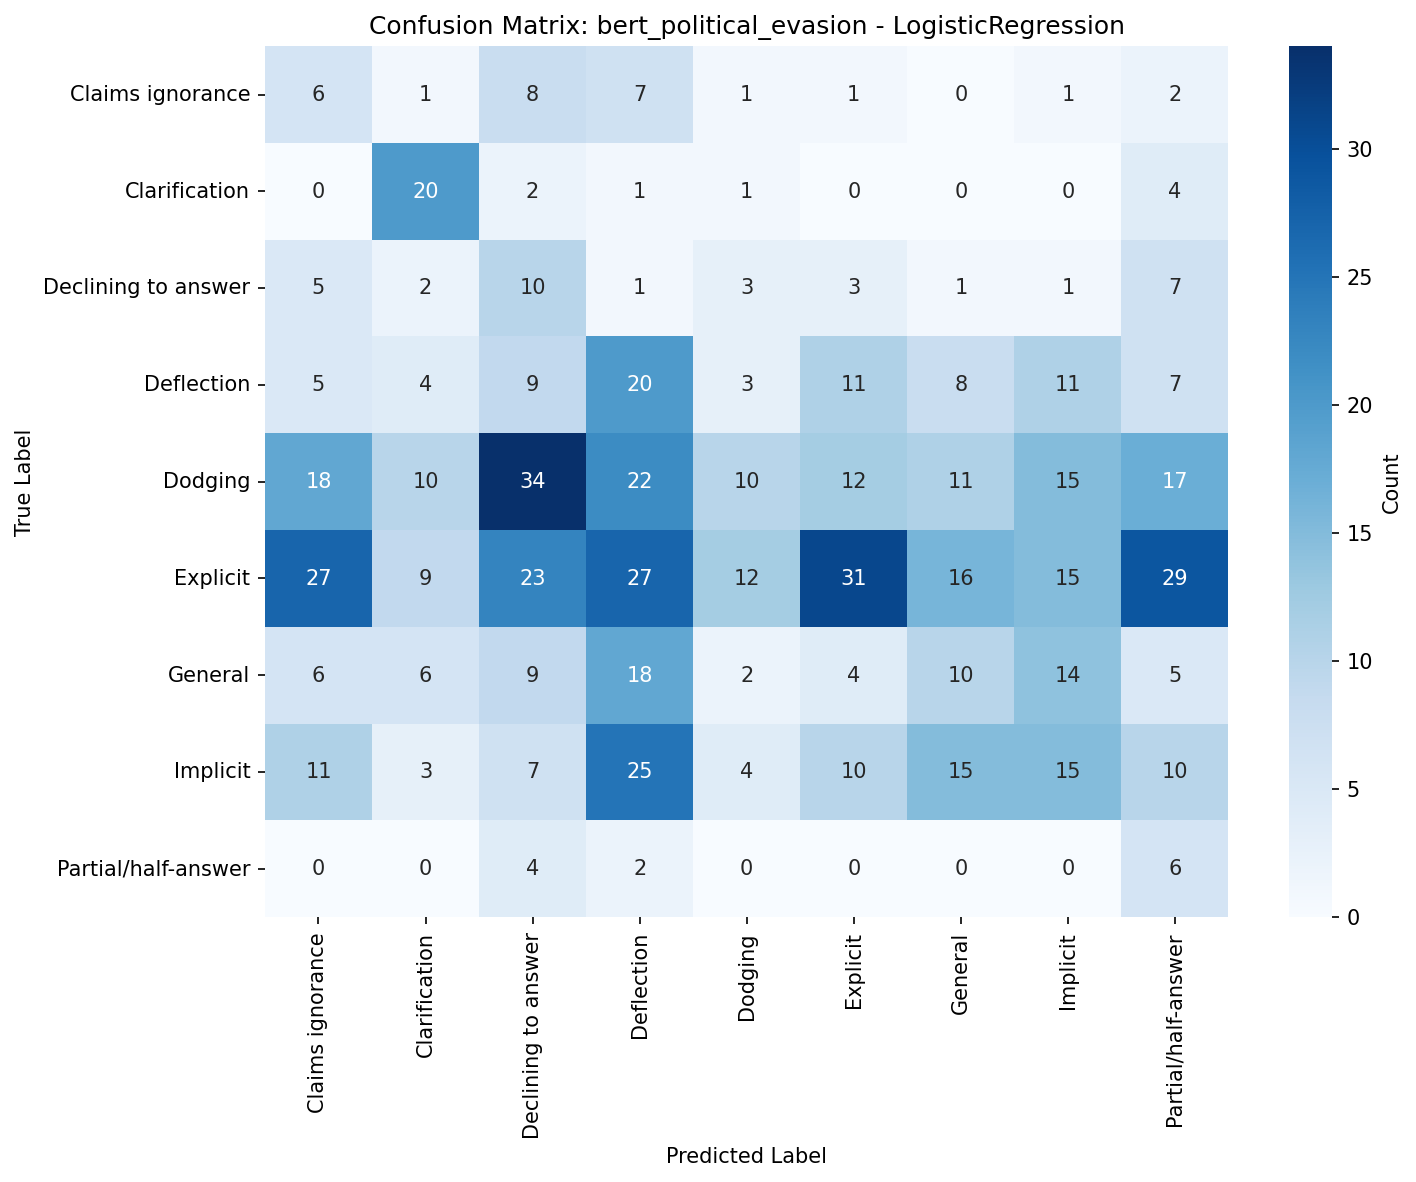

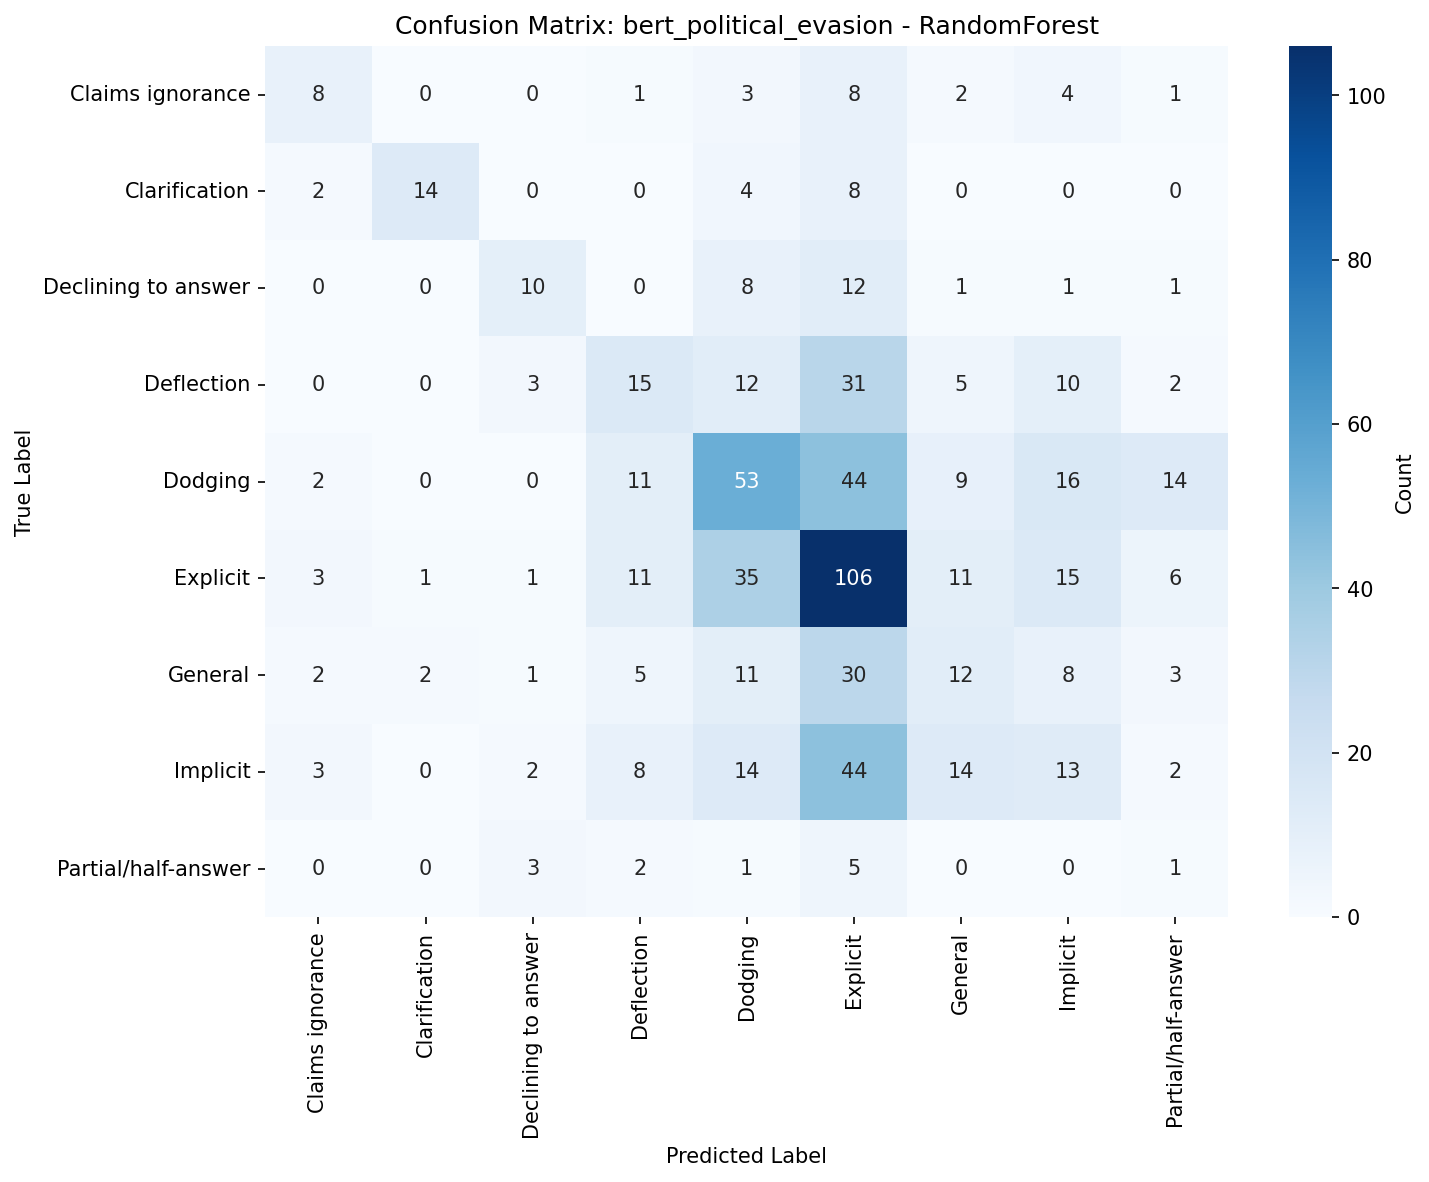

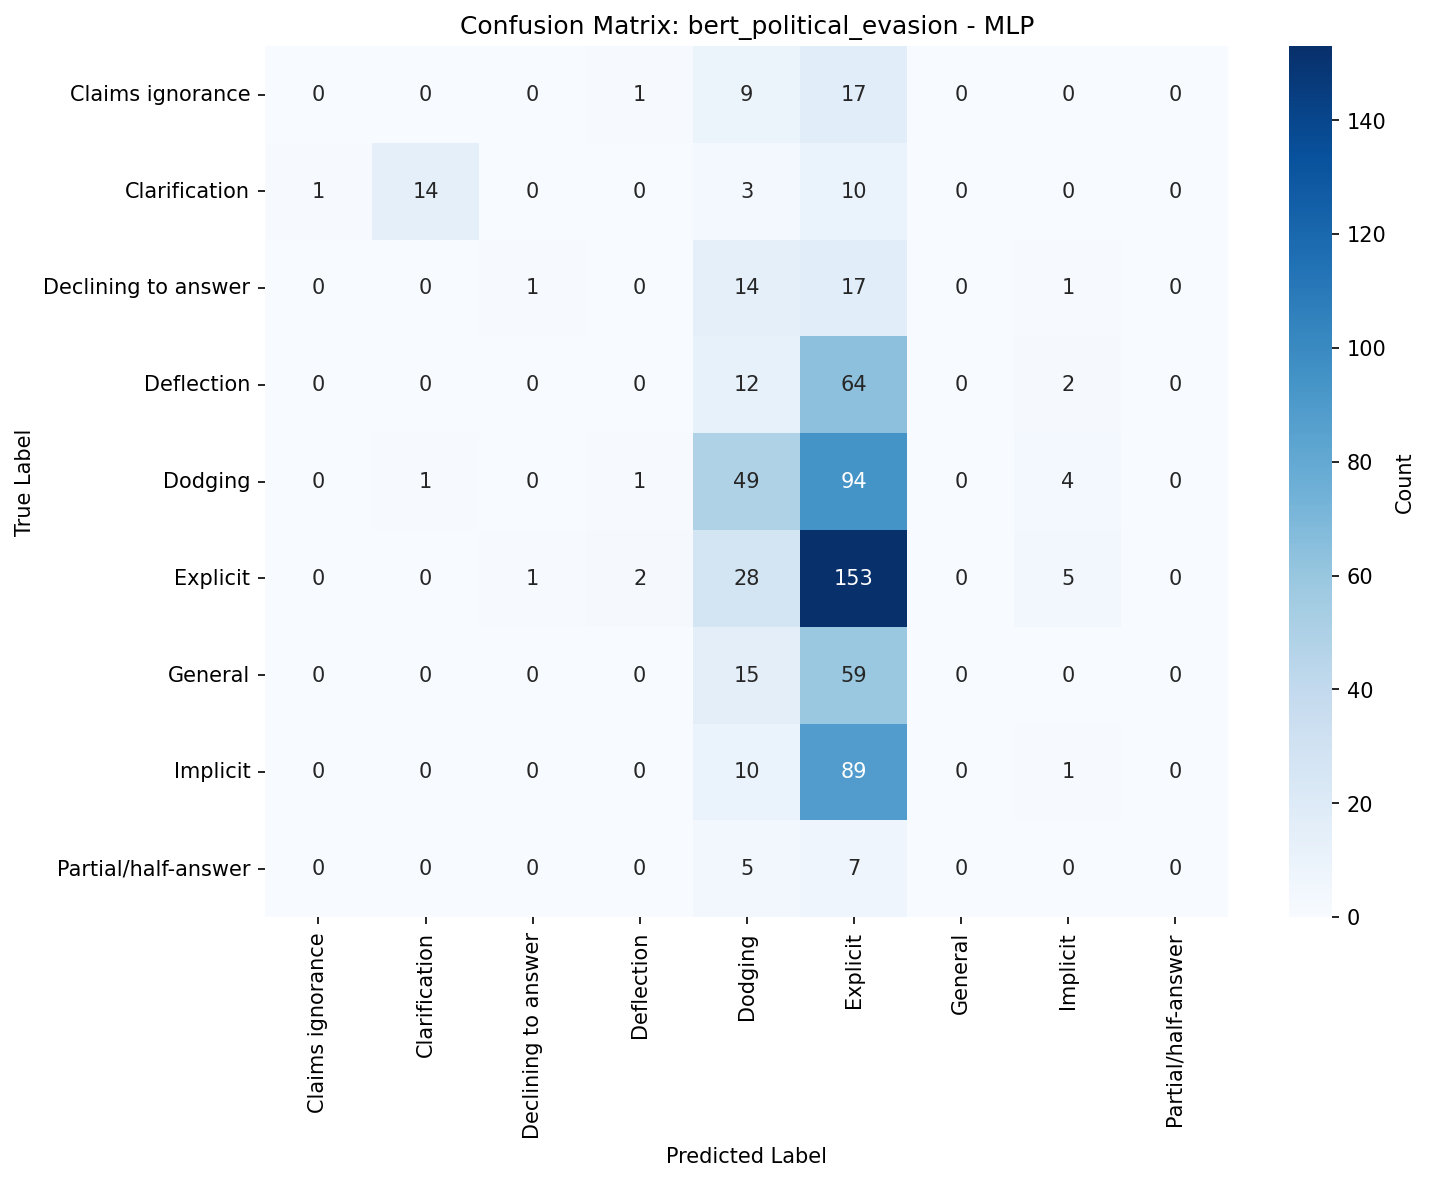

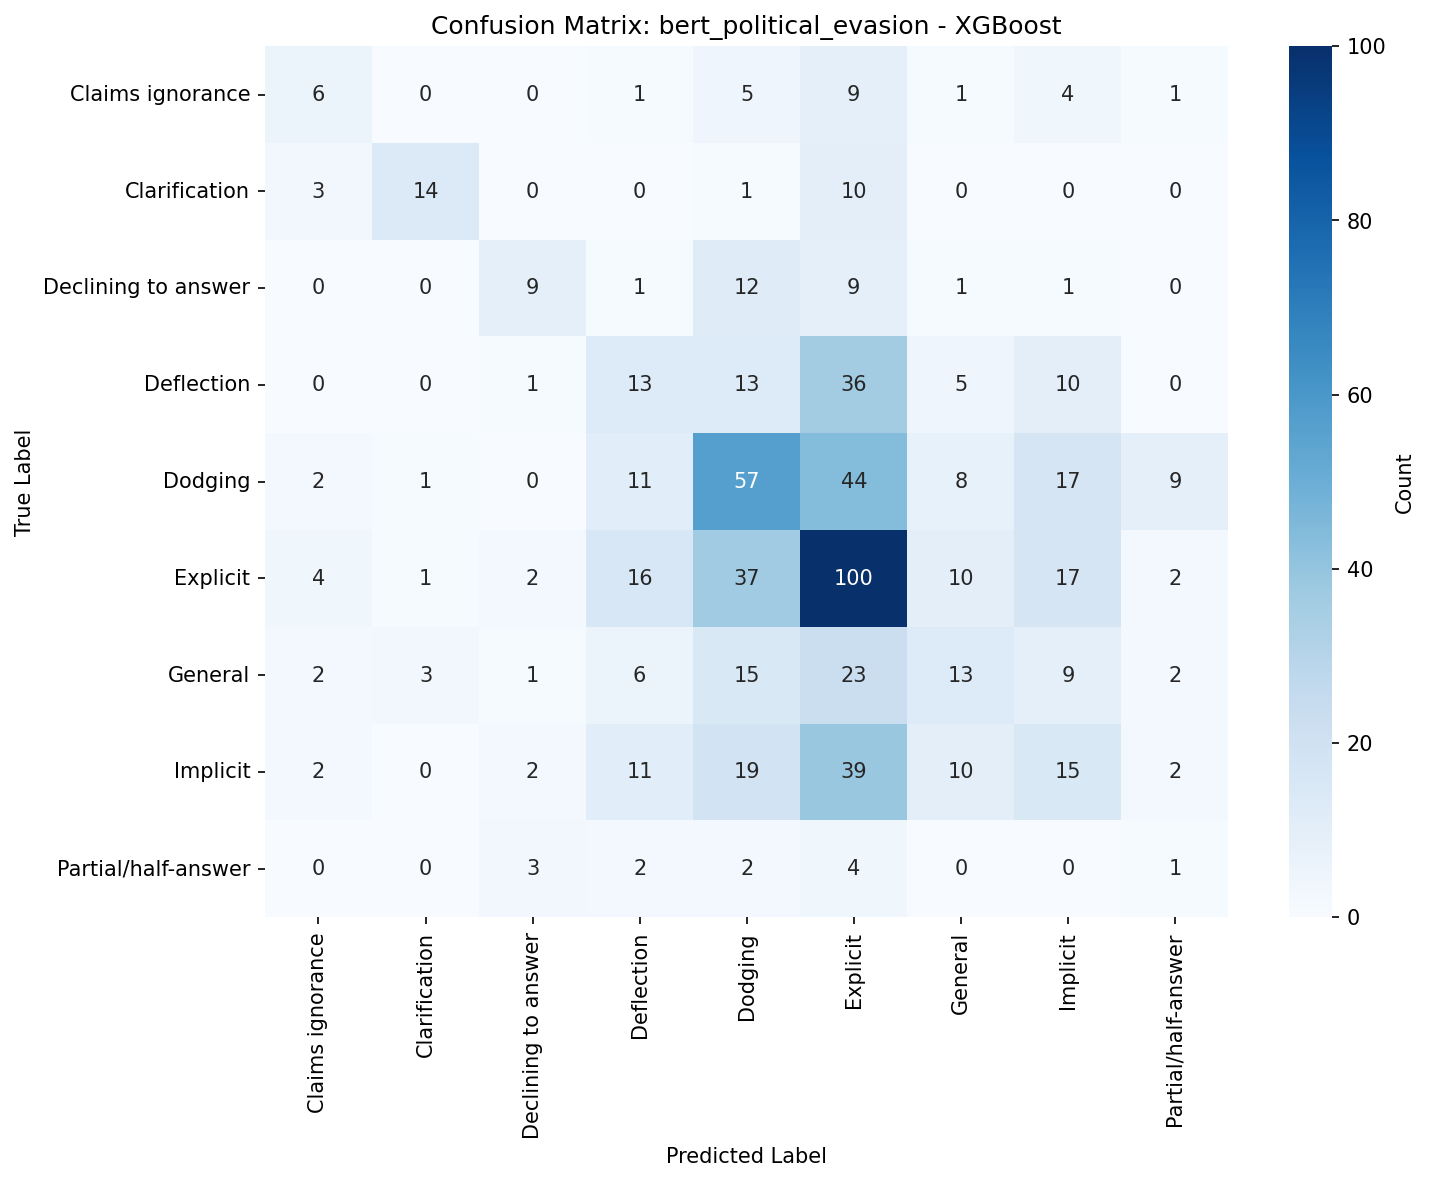

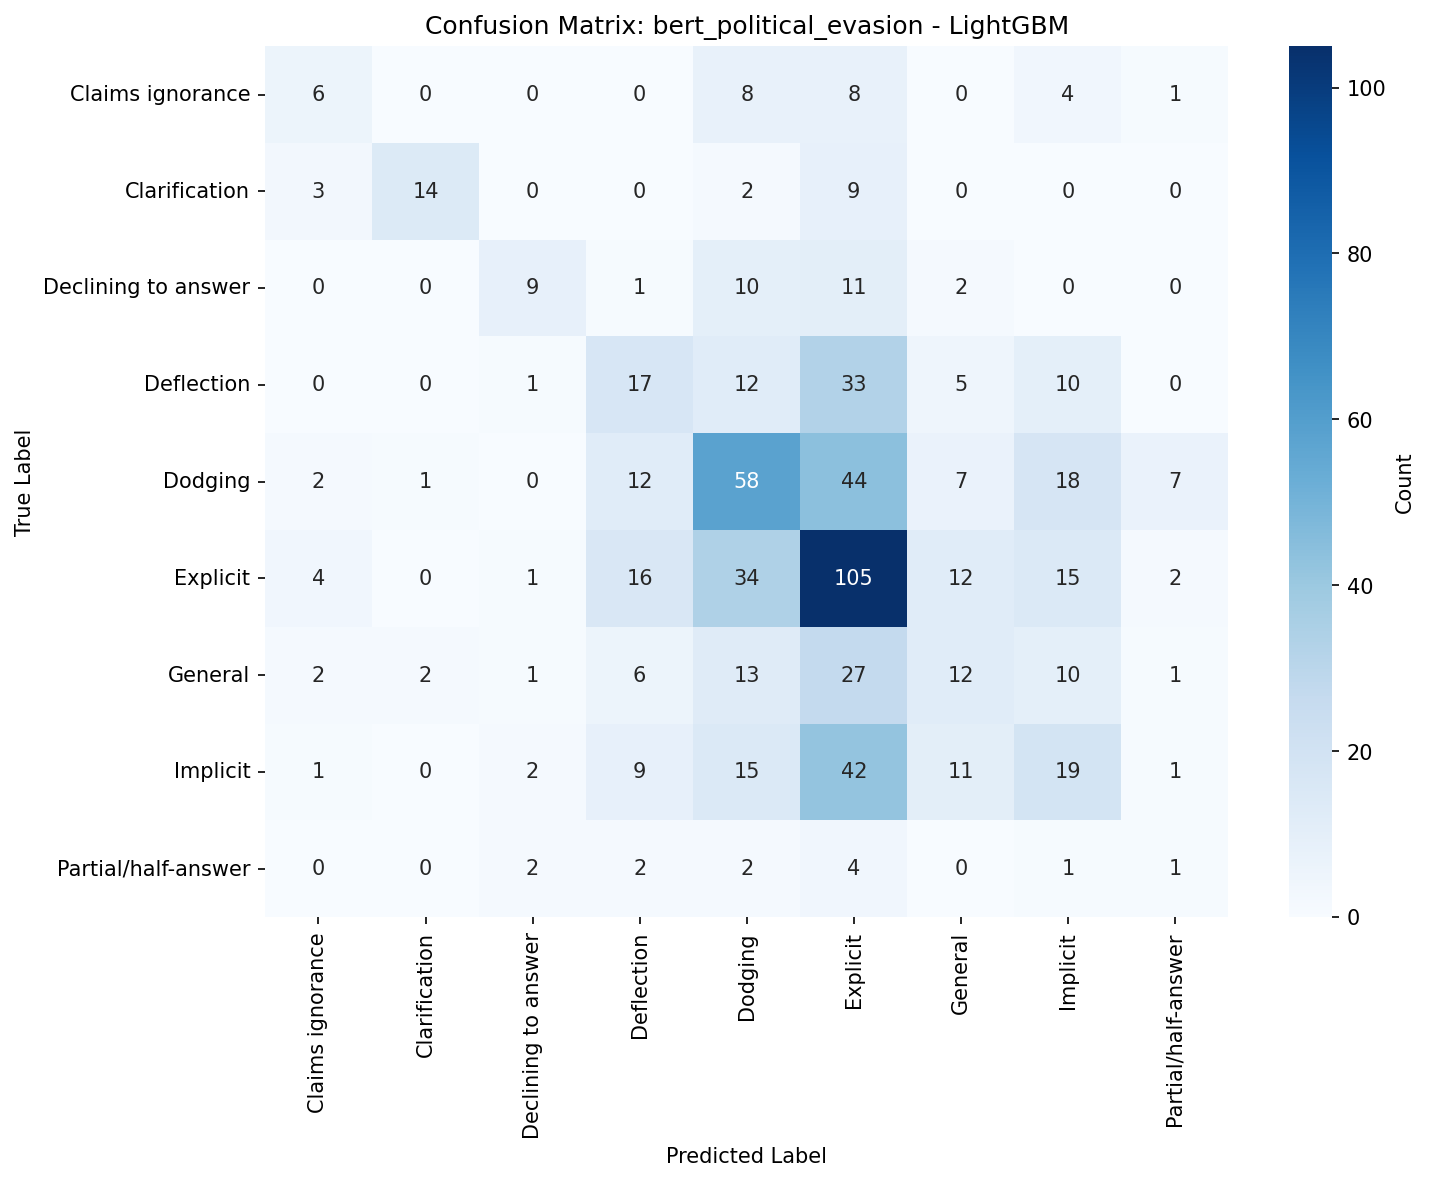


Results Table: bert_ambiguity_clarity
        Classifier                   Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest bert_ambiguity_clarity  0.586957  0.518910     0.576524         0.548750      0.501366
          LightGBM bert_ambiguity_clarity  0.591304  0.505322     0.575574         0.555392      0.483033
           XGBoost bert_ambiguity_clarity  0.579710  0.500485     0.568428         0.537094      0.481470
         LinearSVC bert_ambiguity_clarity  0.562319  0.437785     0.533531         0.453160      0.442977
               MLP bert_ambiguity_clarity  0.615942  0.418217     0.546005         0.608635      0.415471
LogisticRegression bert_ambiguity_clarity  0.421739  0.394782     0.441294         0.404364      0.445749

Per-Class Metrics: bert_ambiguity_clarity - RandomForest (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.647436 0.733656  0.687855      413
Clear Non-Reply   0.593750 0.431

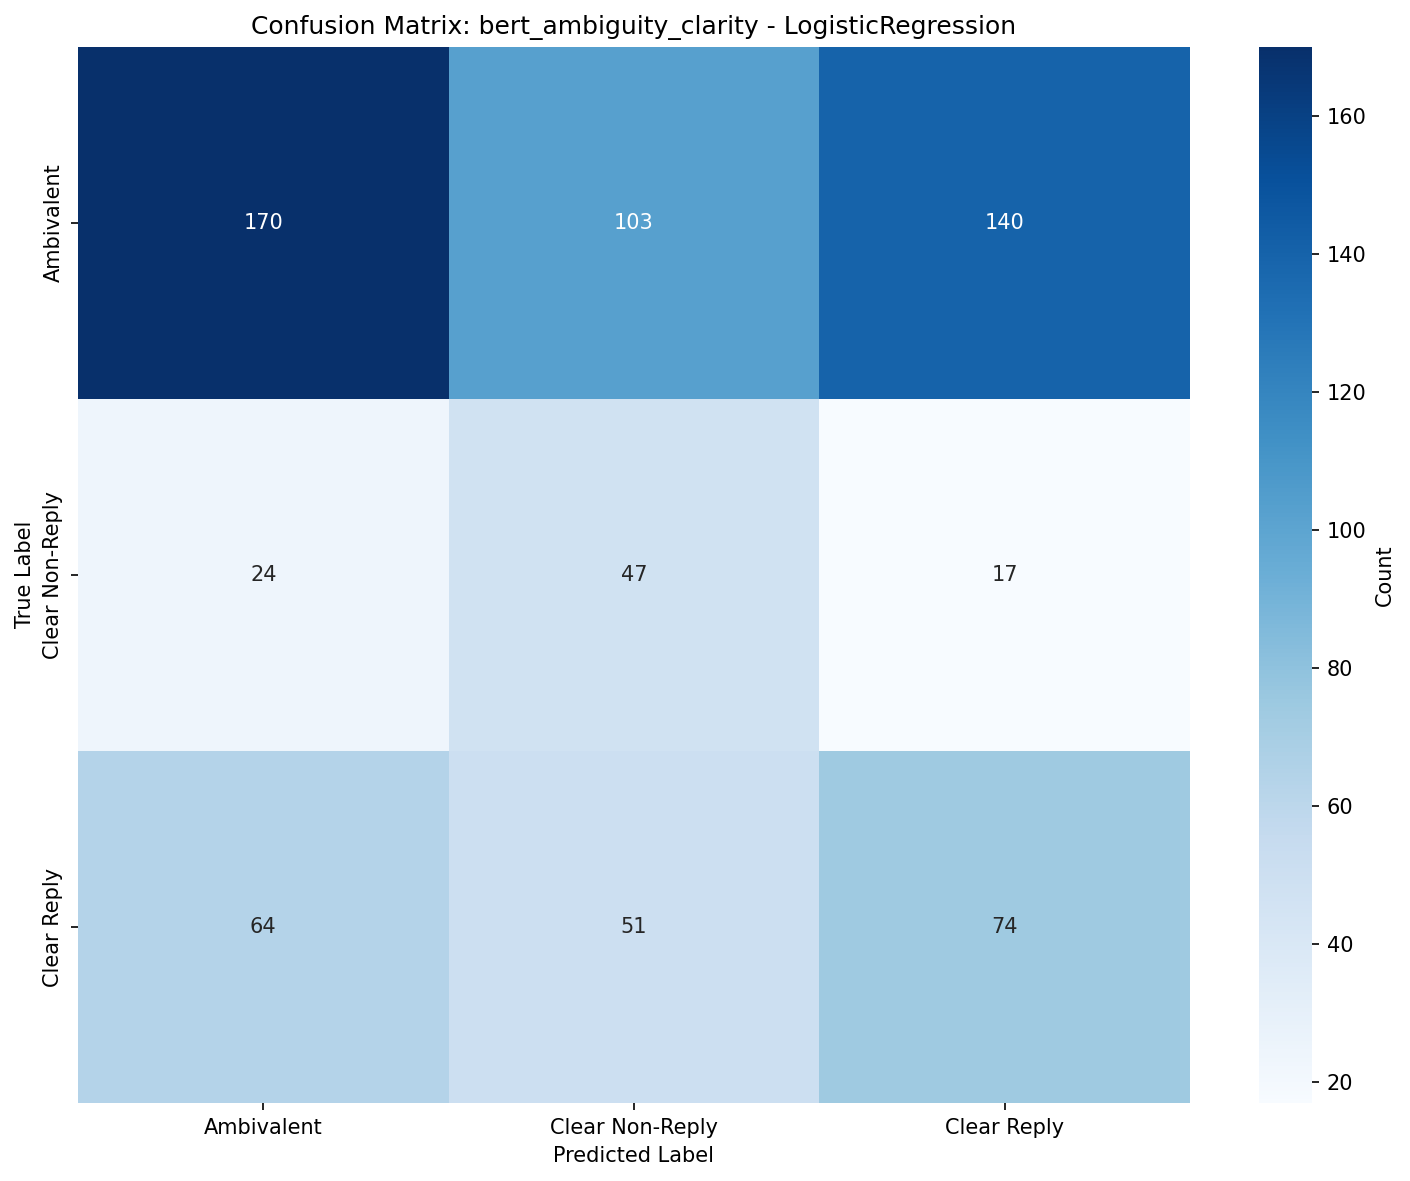

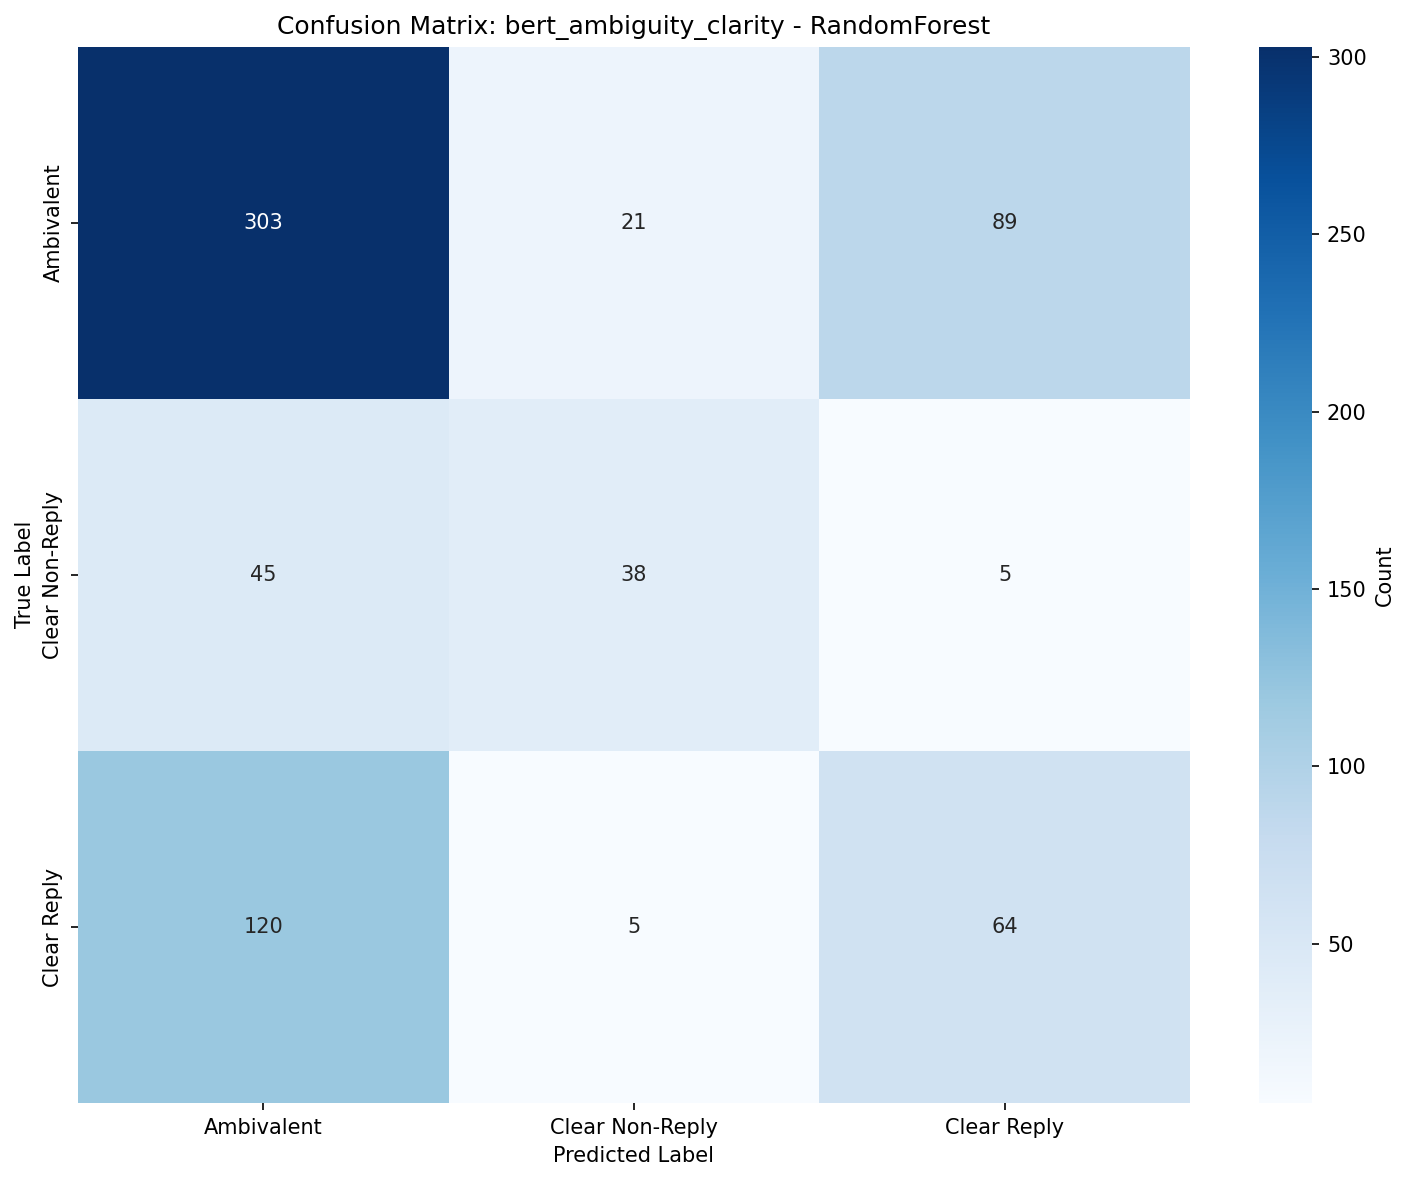

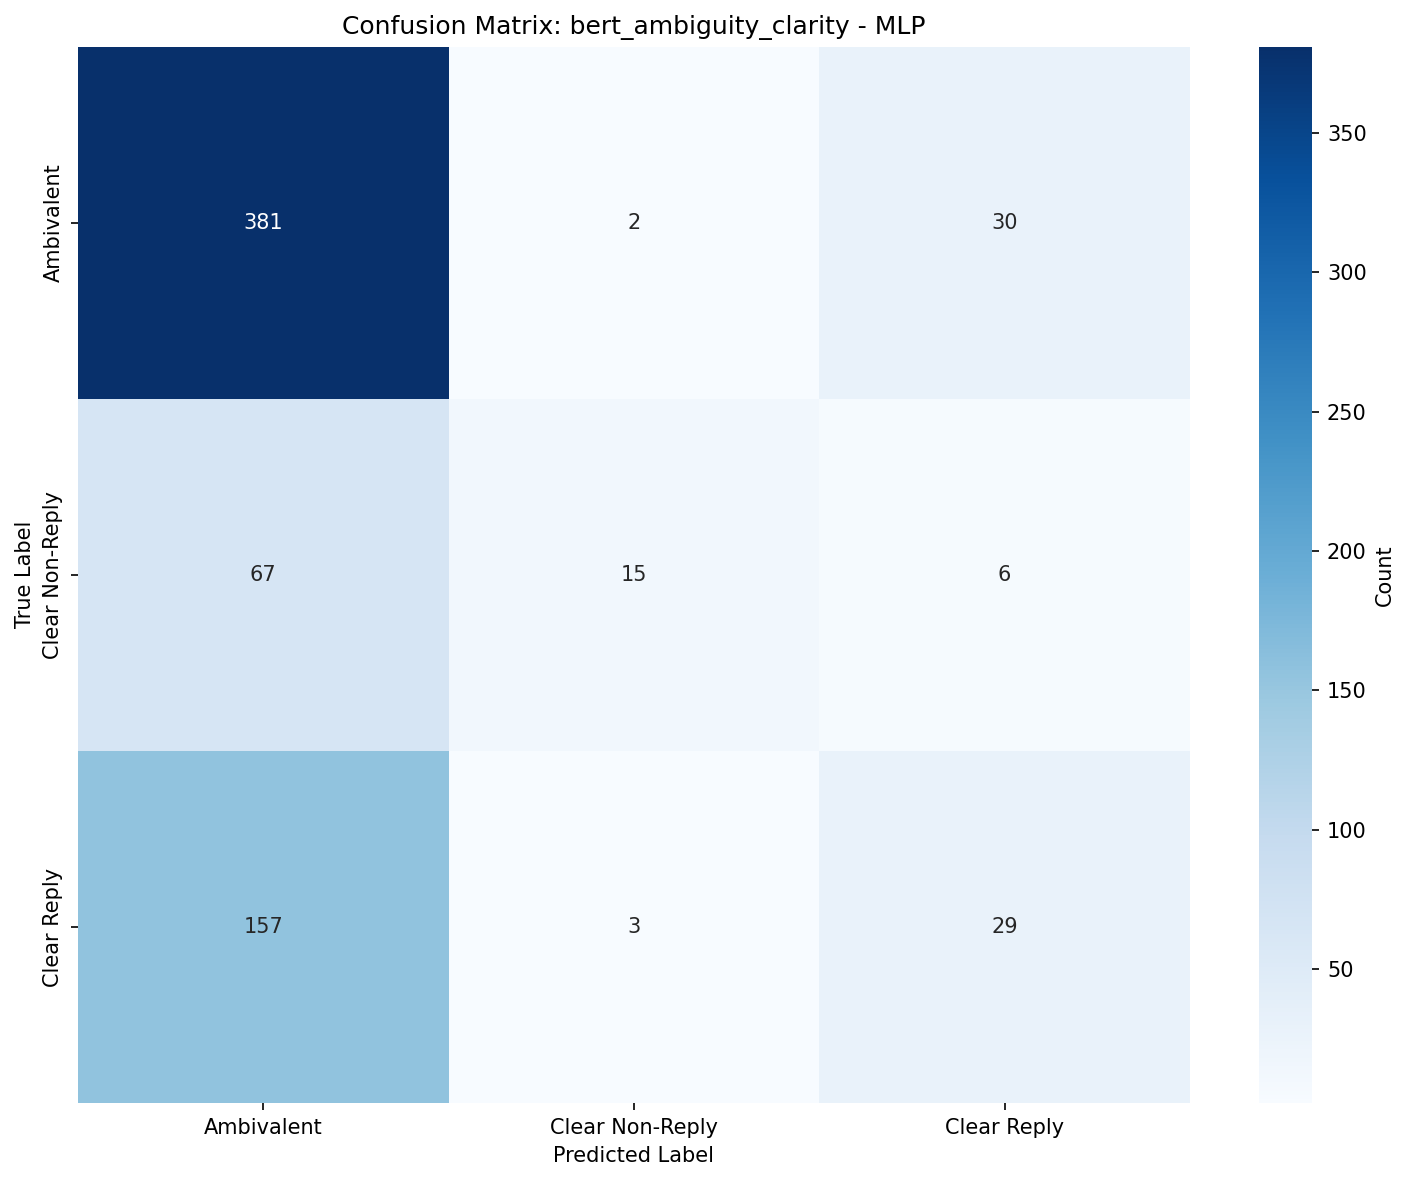

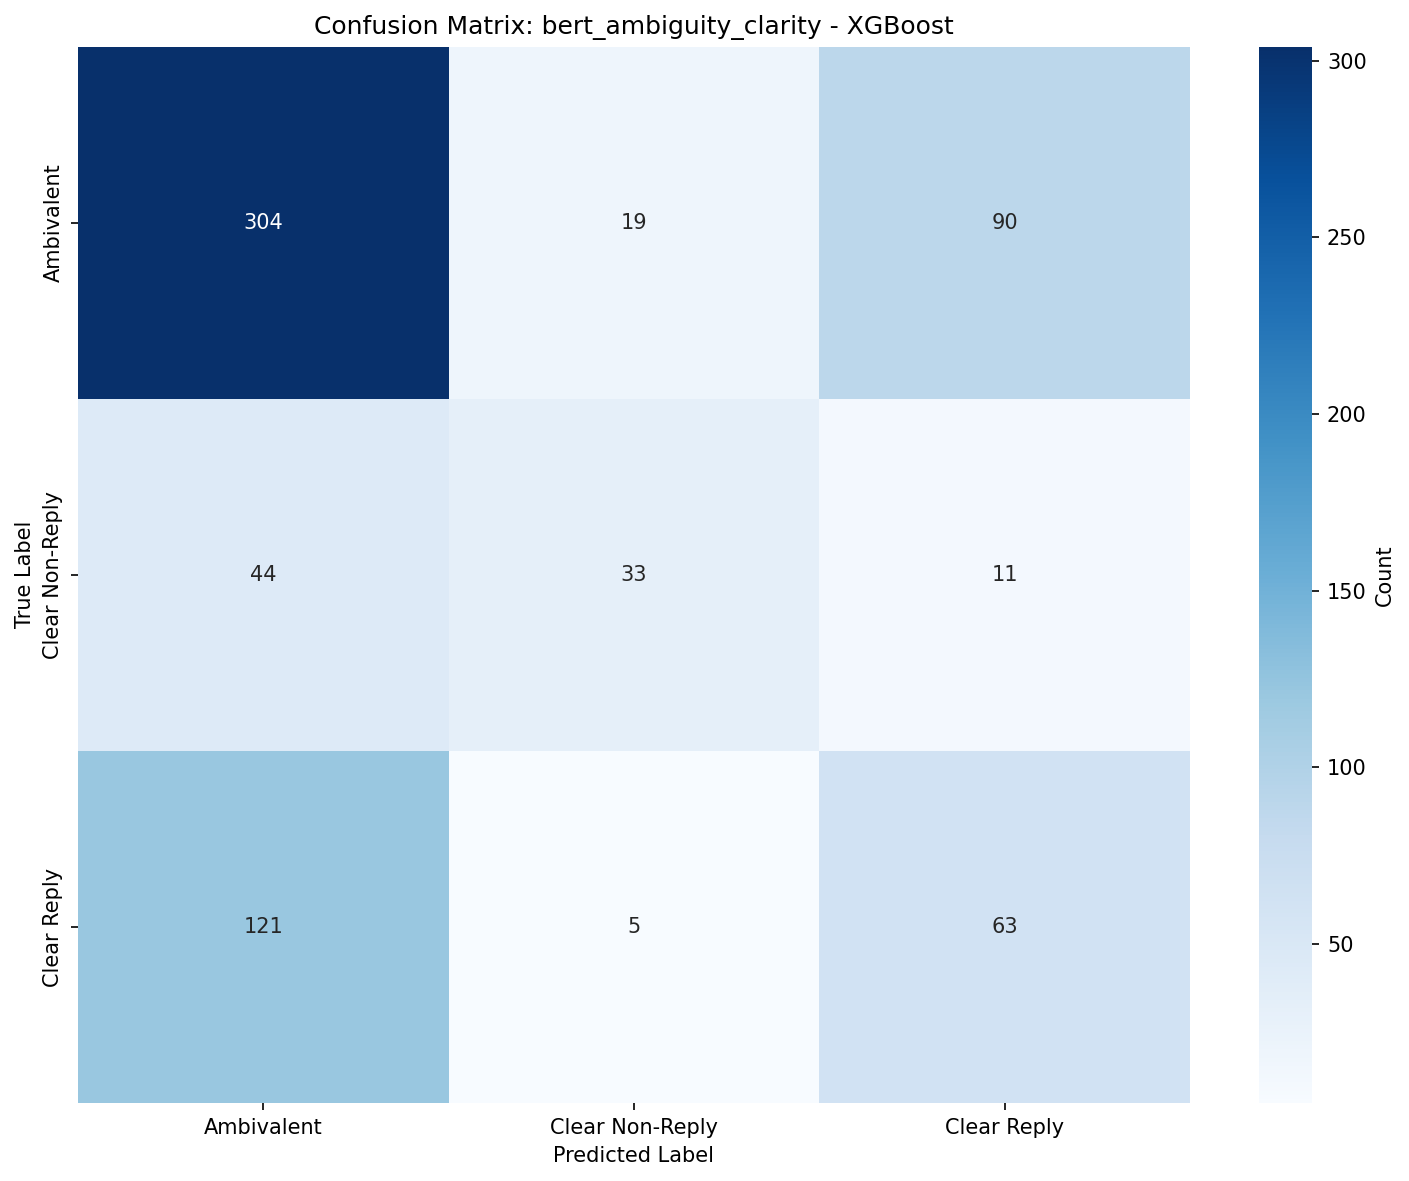

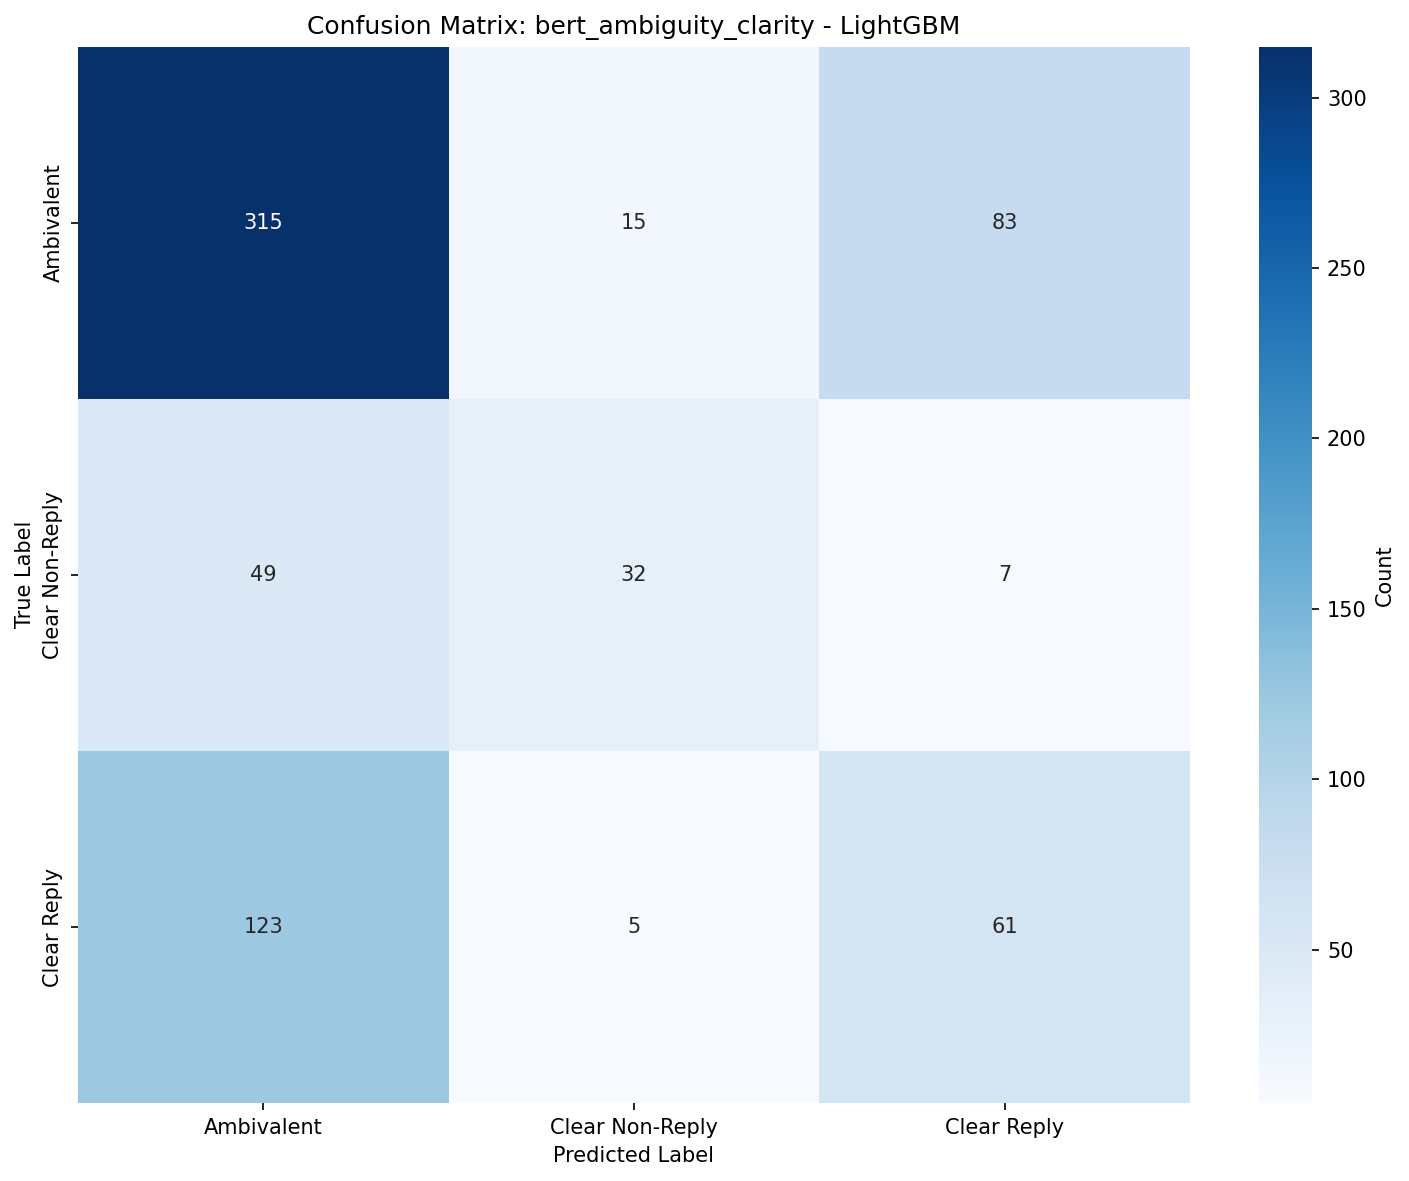


Results Table: bert_ambiguity_evasion
        Classifier                   Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
           XGBoost bert_ambiguity_evasion  0.326087  0.302921     0.318796         0.364561      0.275743
          LightGBM bert_ambiguity_evasion  0.326087  0.298088     0.315132         0.365408      0.271043
      RandomForest bert_ambiguity_evasion  0.330435  0.296601     0.322194         0.335898      0.278993
         LinearSVC bert_ambiguity_evasion  0.233333  0.213229     0.230727         0.232145      0.294931
LogisticRegression bert_ambiguity_evasion  0.182609  0.188411     0.181888         0.205181      0.279749
               MLP bert_ambiguity_evasion  0.295652  0.151854     0.214525         0.203386      0.167087

Per-Class Metrics: bert_ambiguity_evasion - XGBoost (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.333333 0.222222  0.266667       27
      Clarification   0.86666

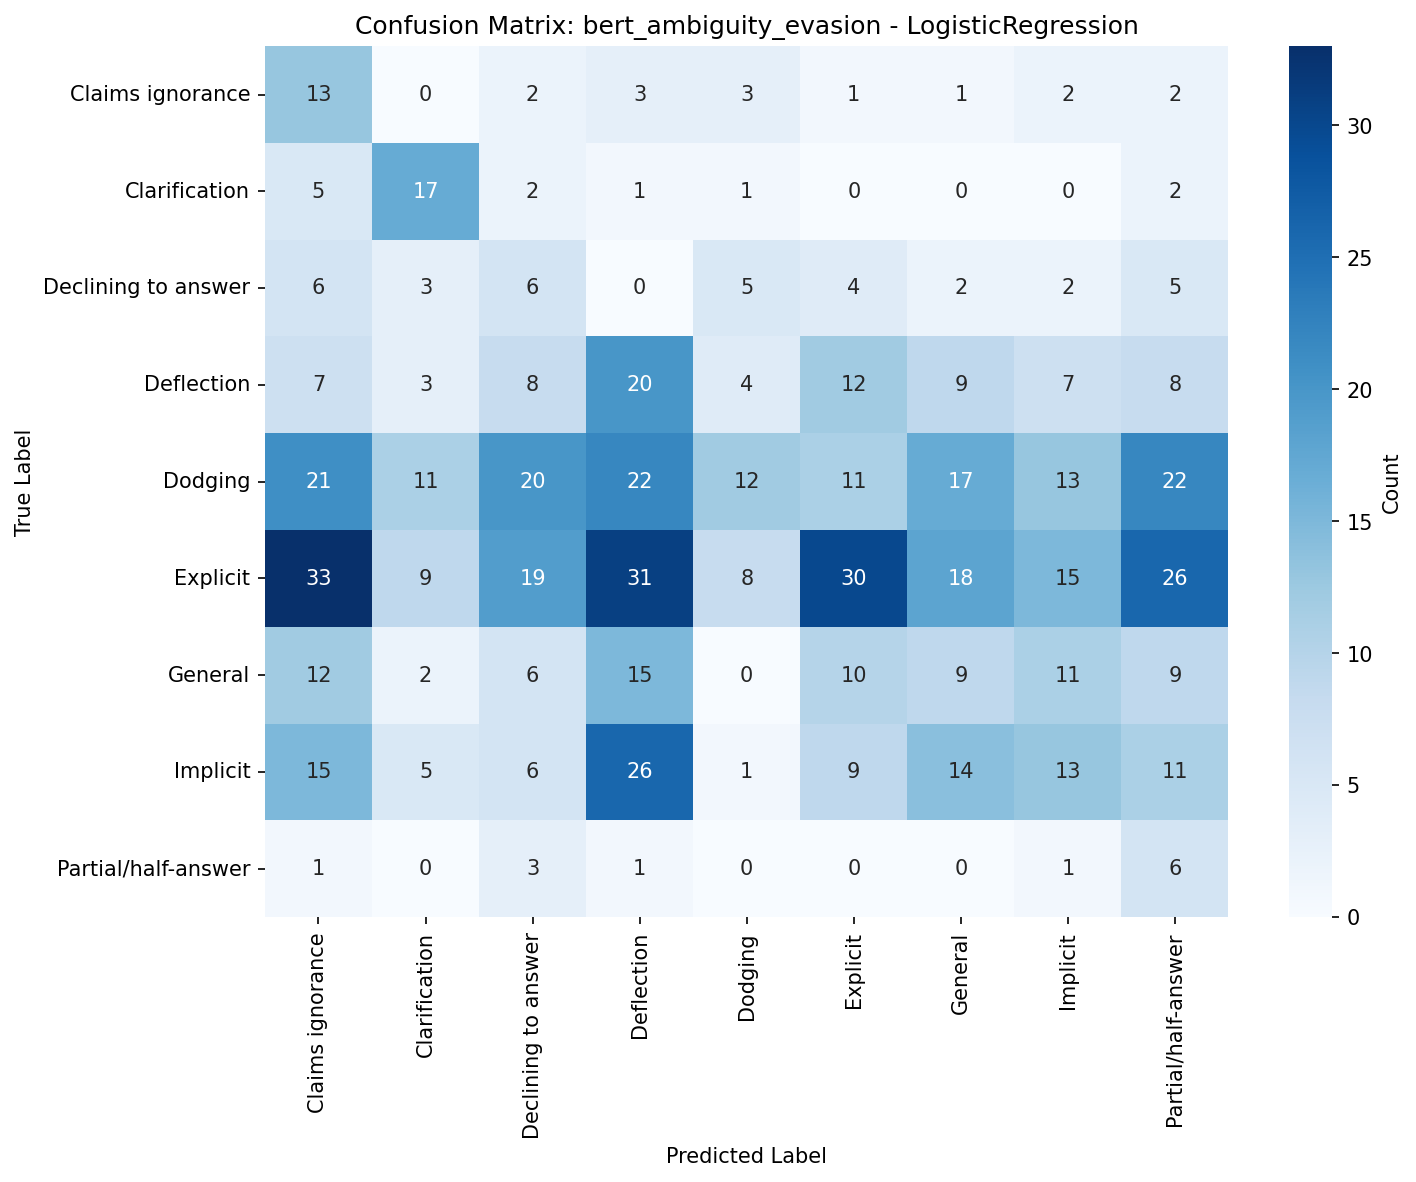

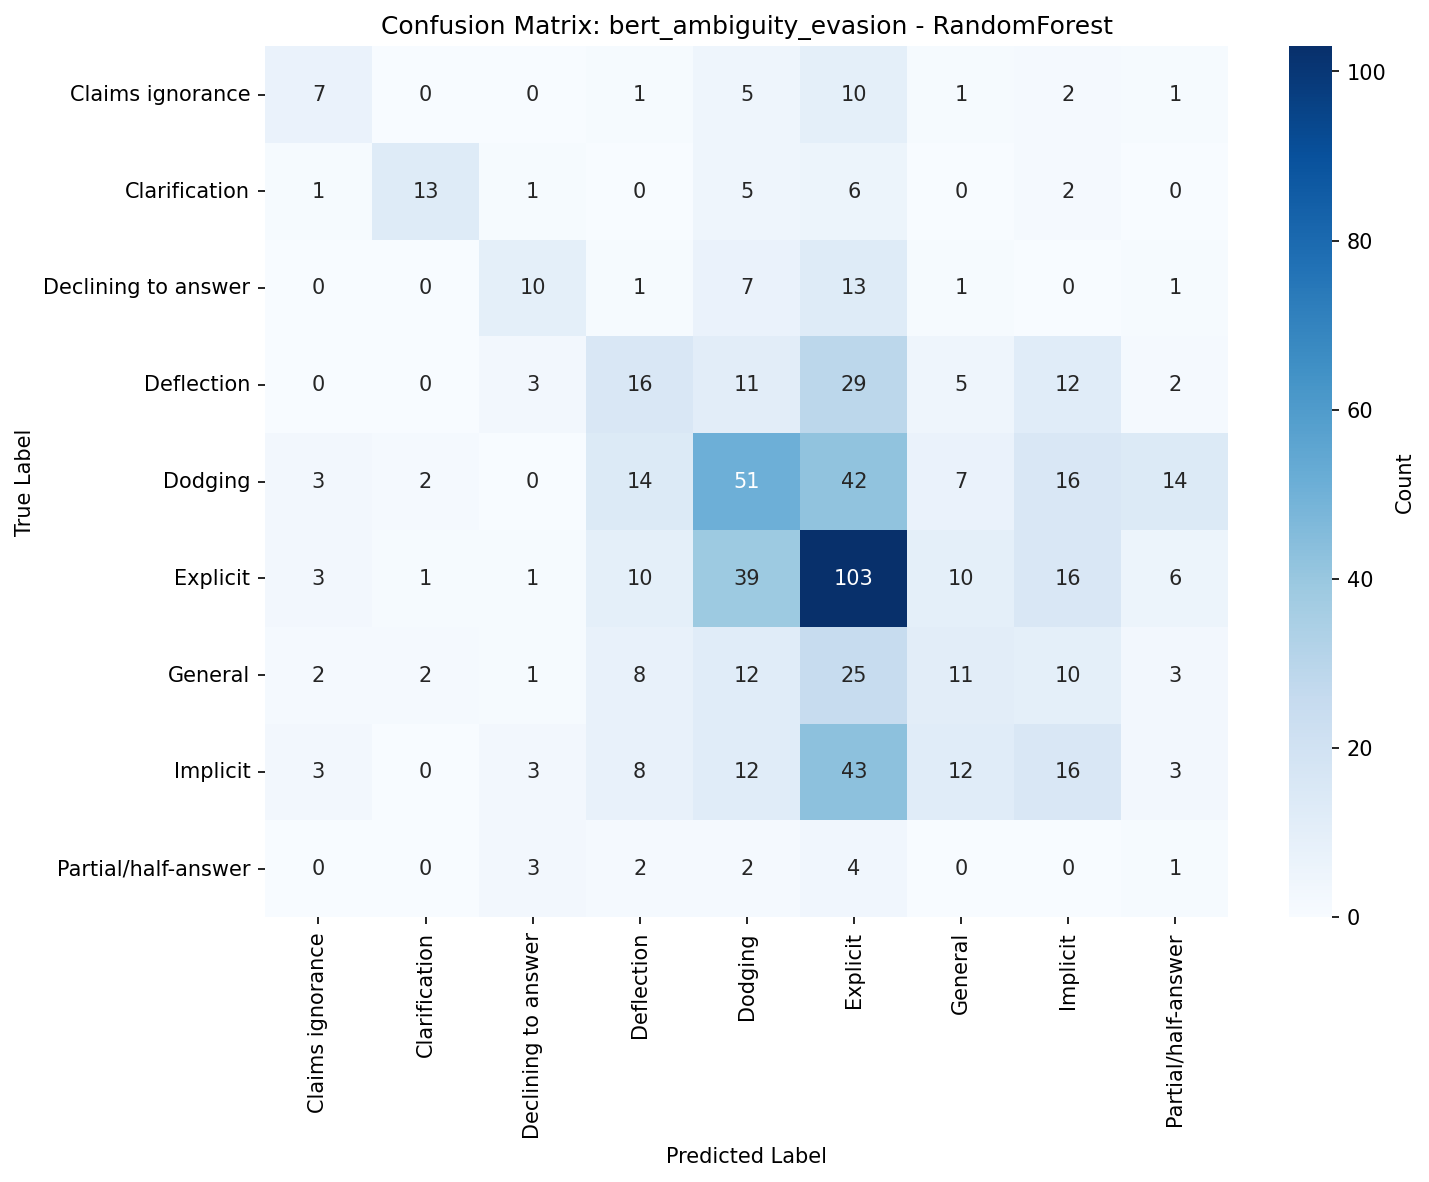

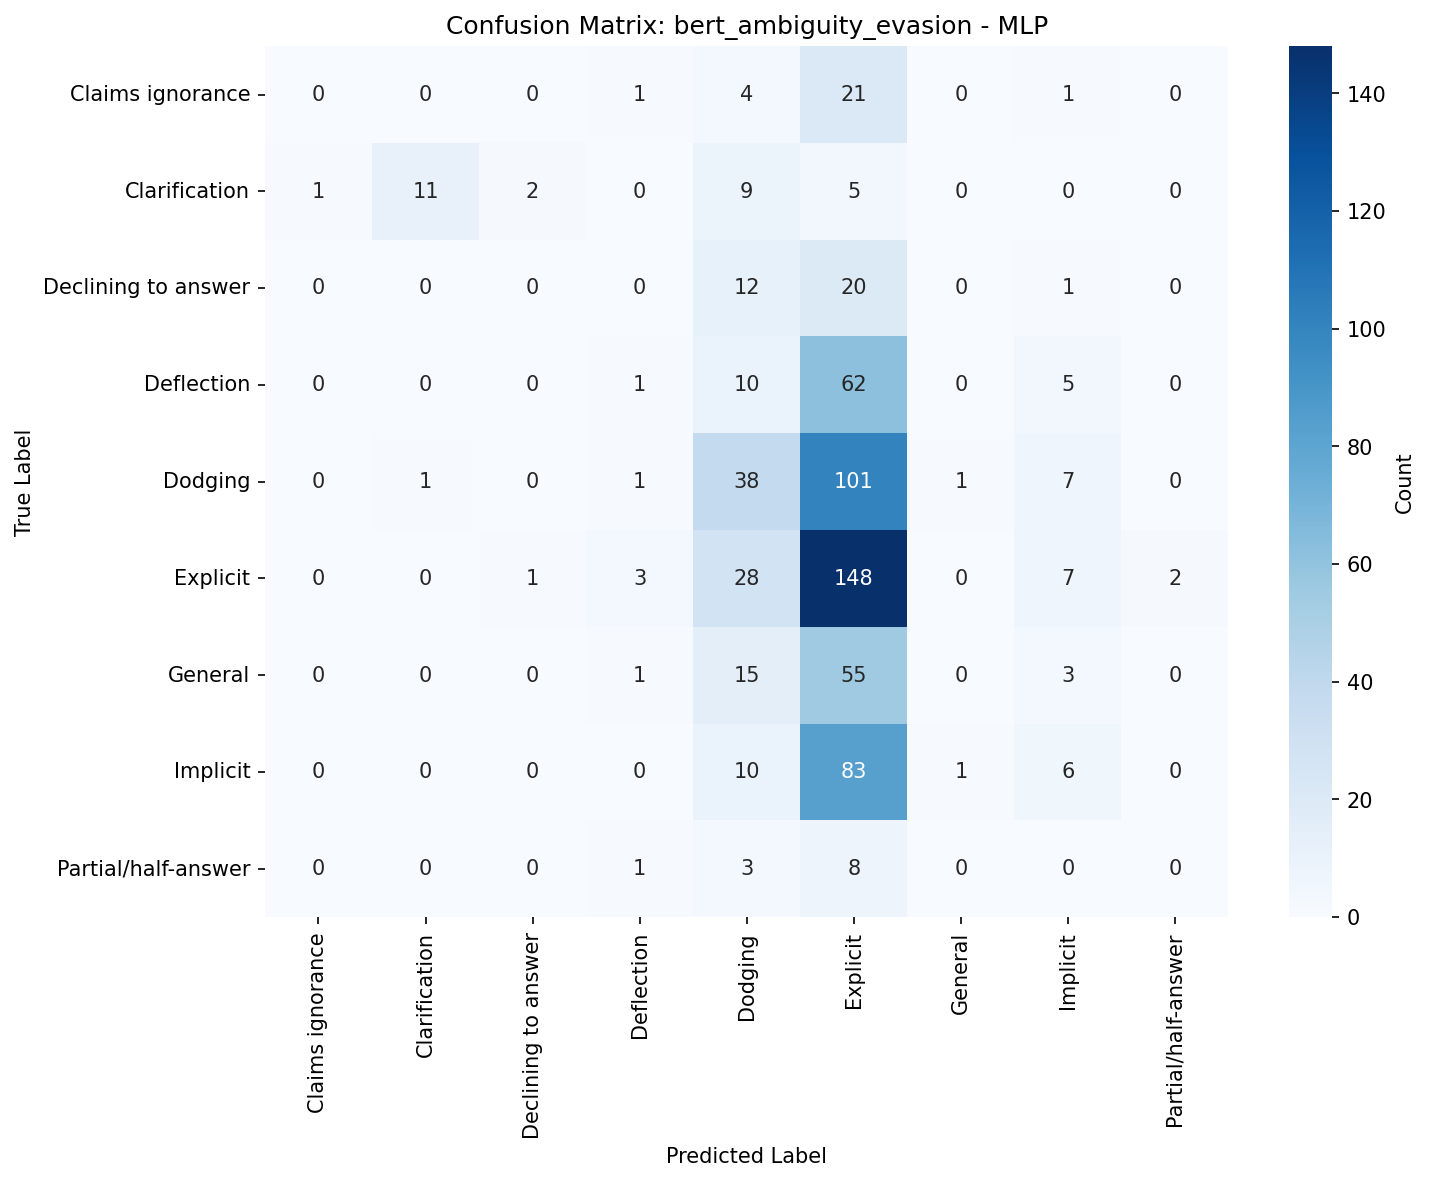

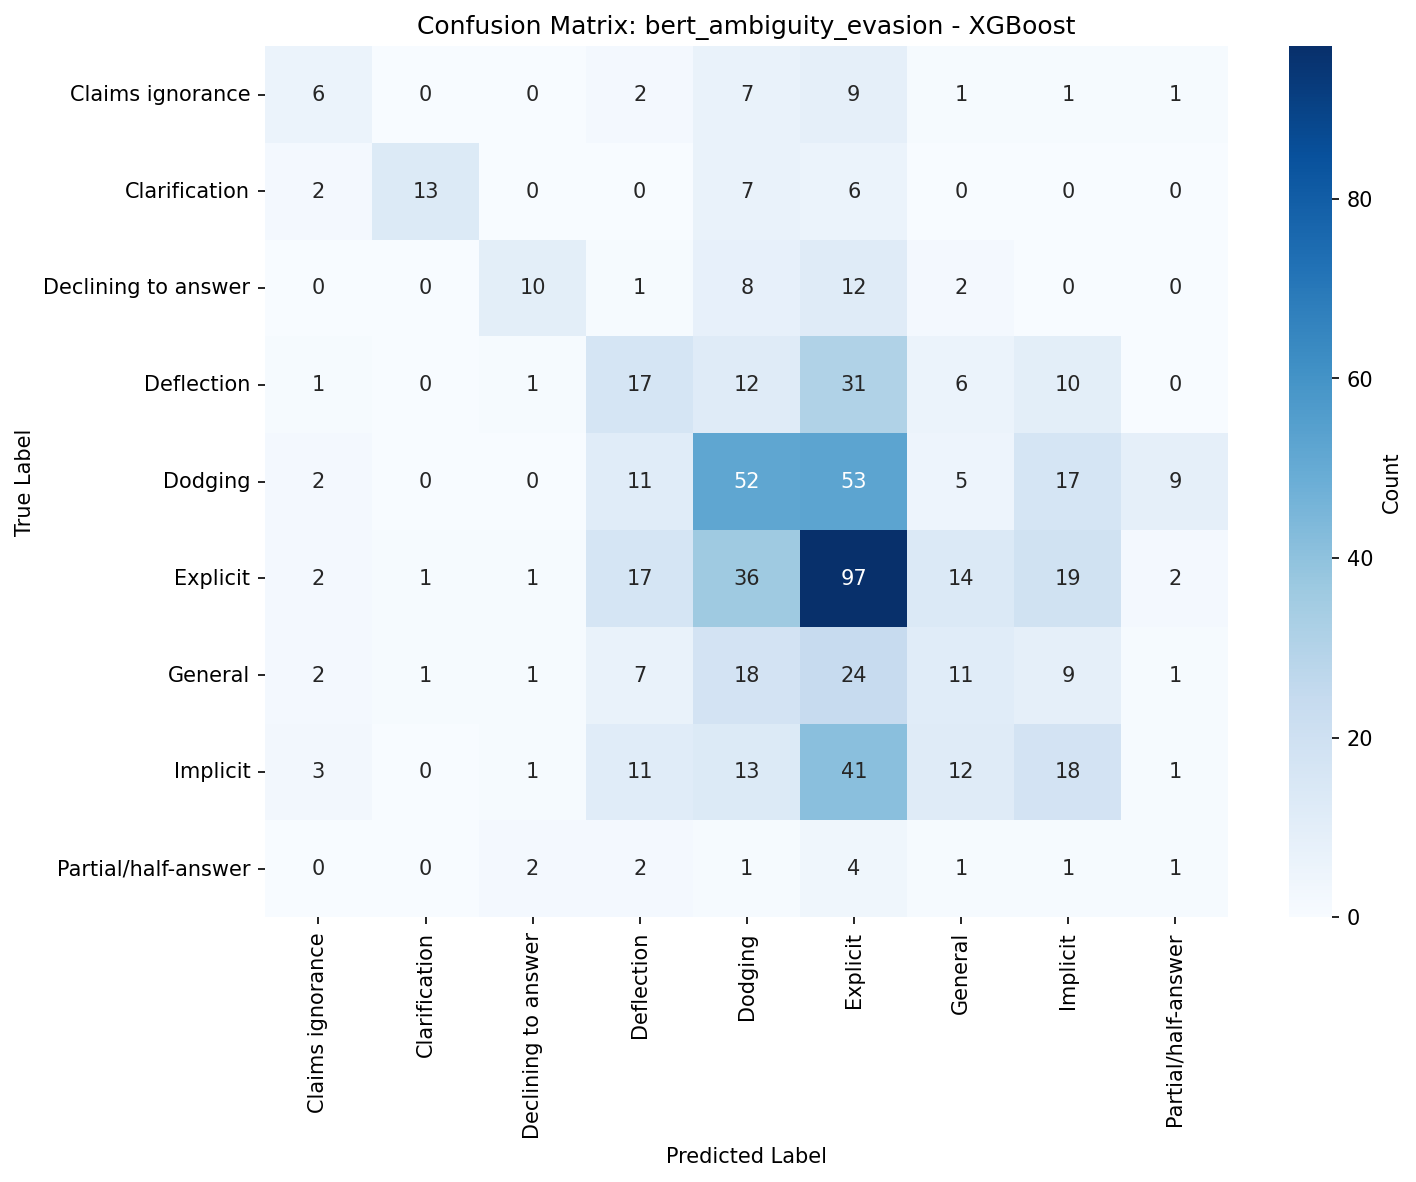

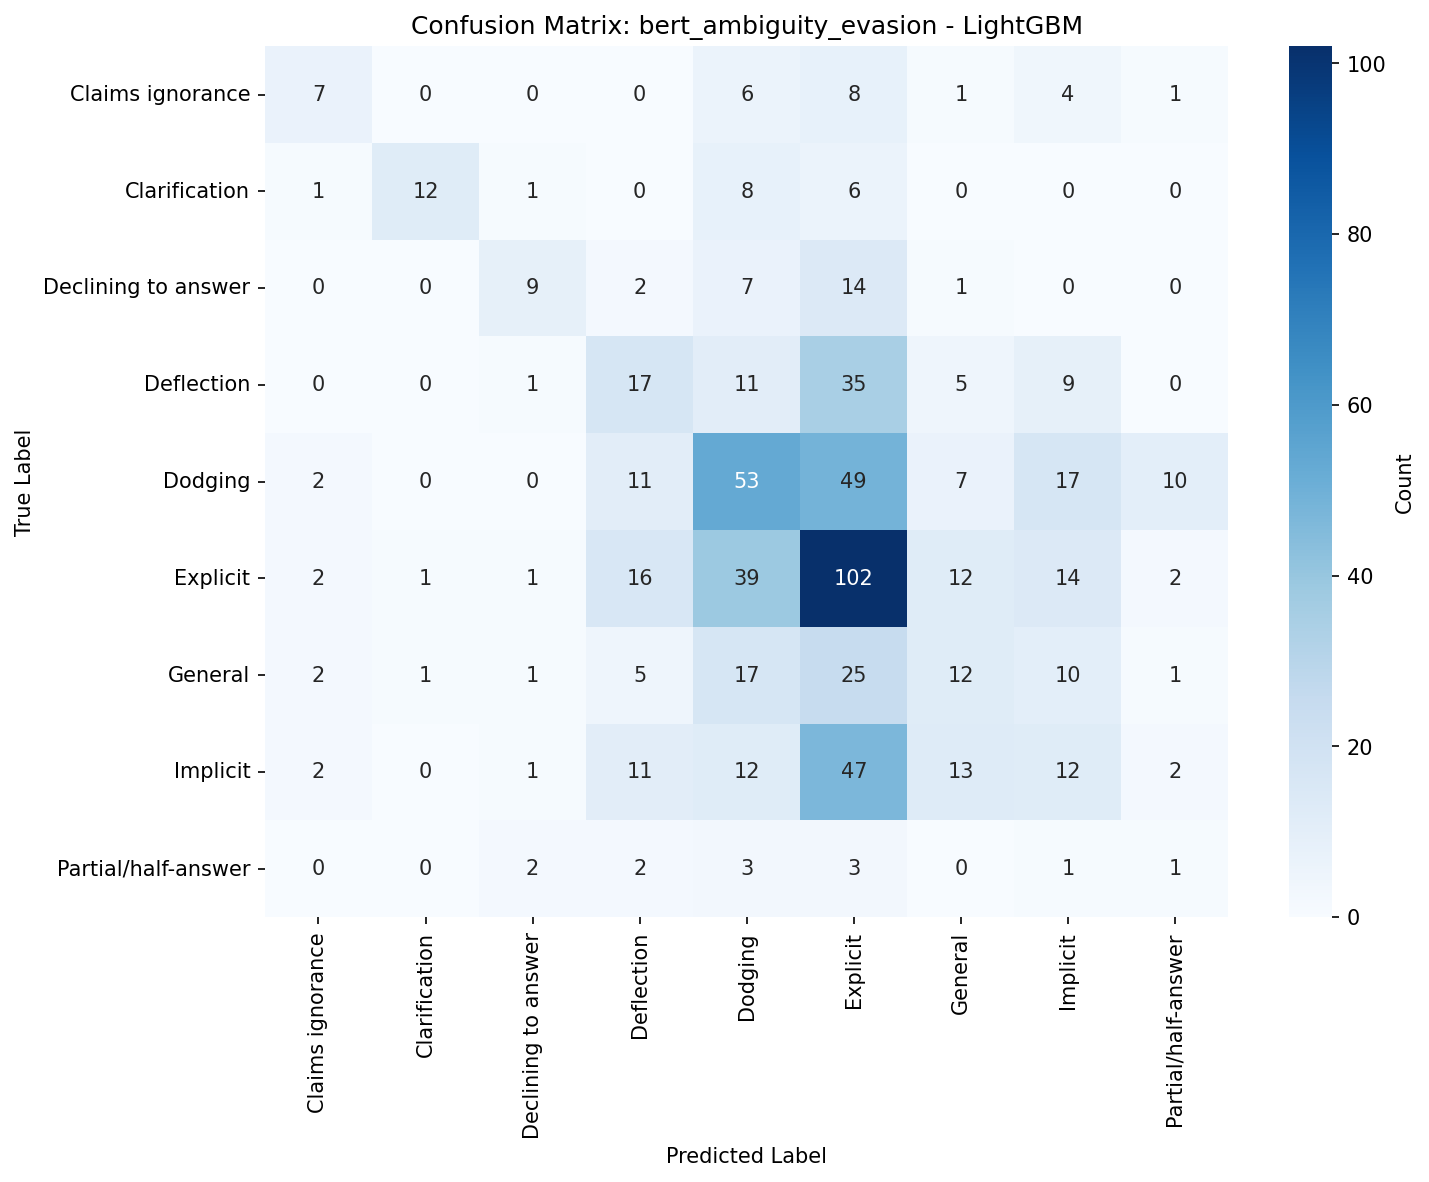


Results Table: roberta_clarity
        Classifier            Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest roberta_clarity  0.581159  0.502416     0.567780         0.534459      0.485369
           XGBoost roberta_clarity  0.579710  0.500111     0.569007         0.539182      0.480403
          LightGBM roberta_clarity  0.591304  0.491581     0.570470         0.547781      0.470265
         LinearSVC roberta_clarity  0.575362  0.453325     0.545402         0.477275      0.453111
               MLP roberta_clarity  0.611594  0.441473     0.551783         0.599682      0.429866
LogisticRegression roberta_clarity  0.434783  0.403464     0.452436         0.406522      0.449076

Per-Class Metrics: roberta_clarity - RandomForest (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.641509 0.740920  0.687640      413
Clear Non-Reply   0.564516 0.397727  0.466667       88
    Clear Reply   0.397351 0.317460  0.3

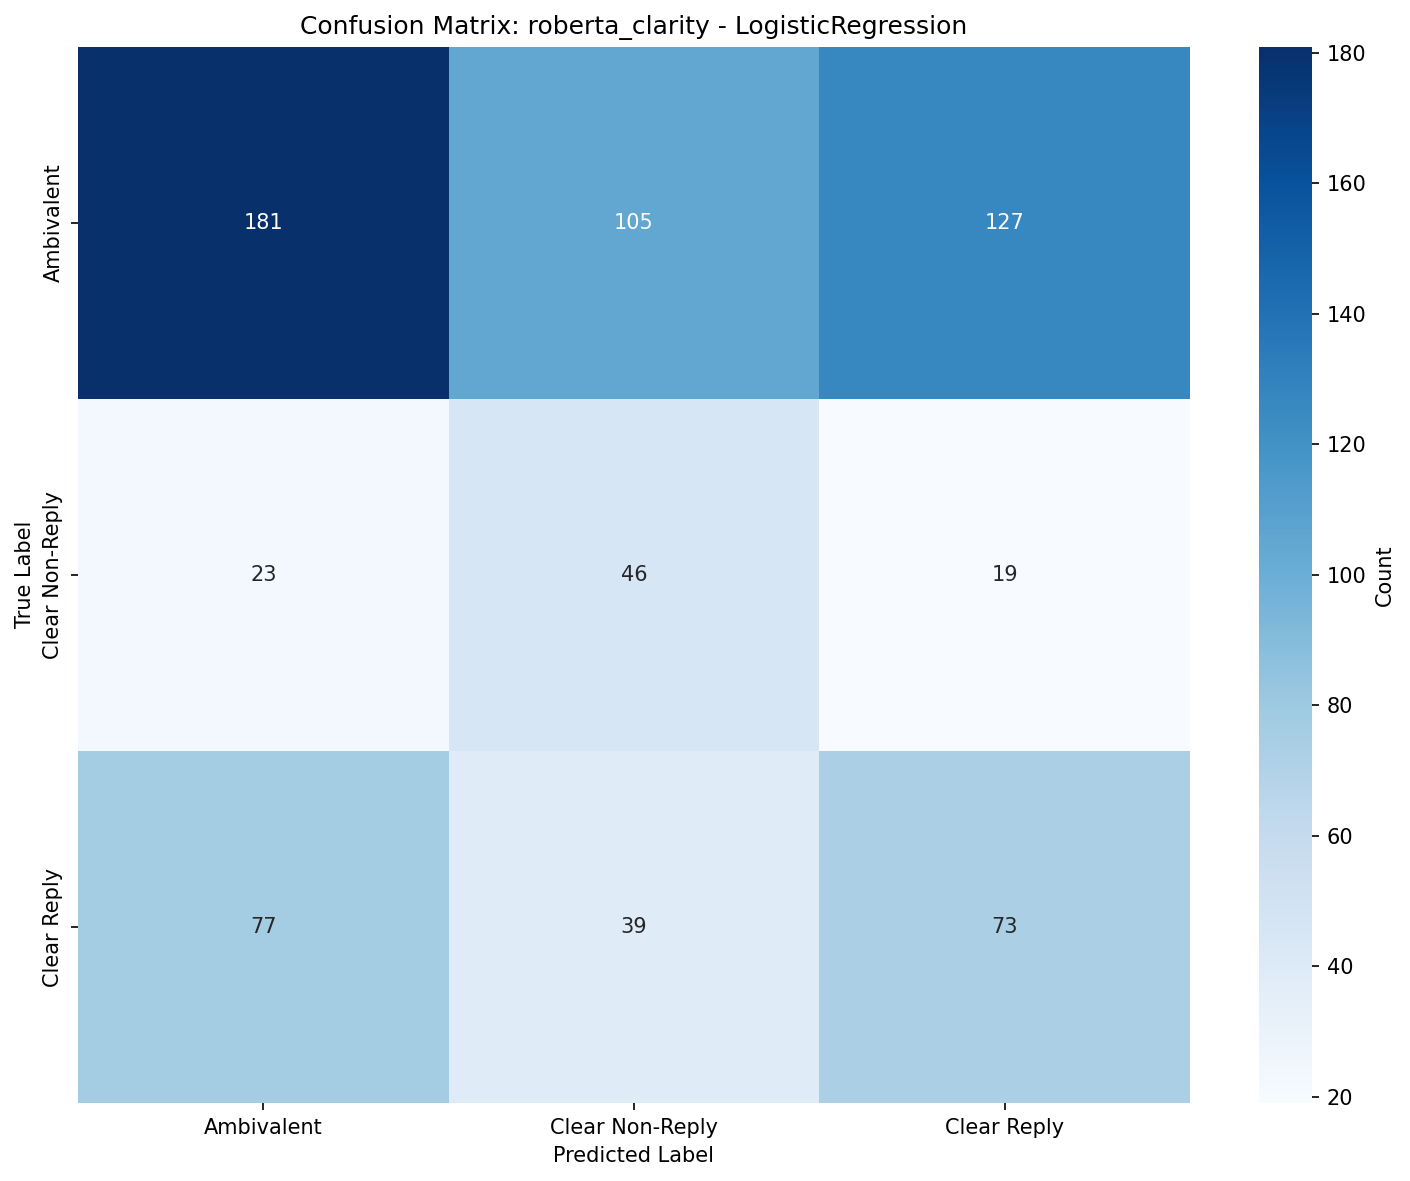

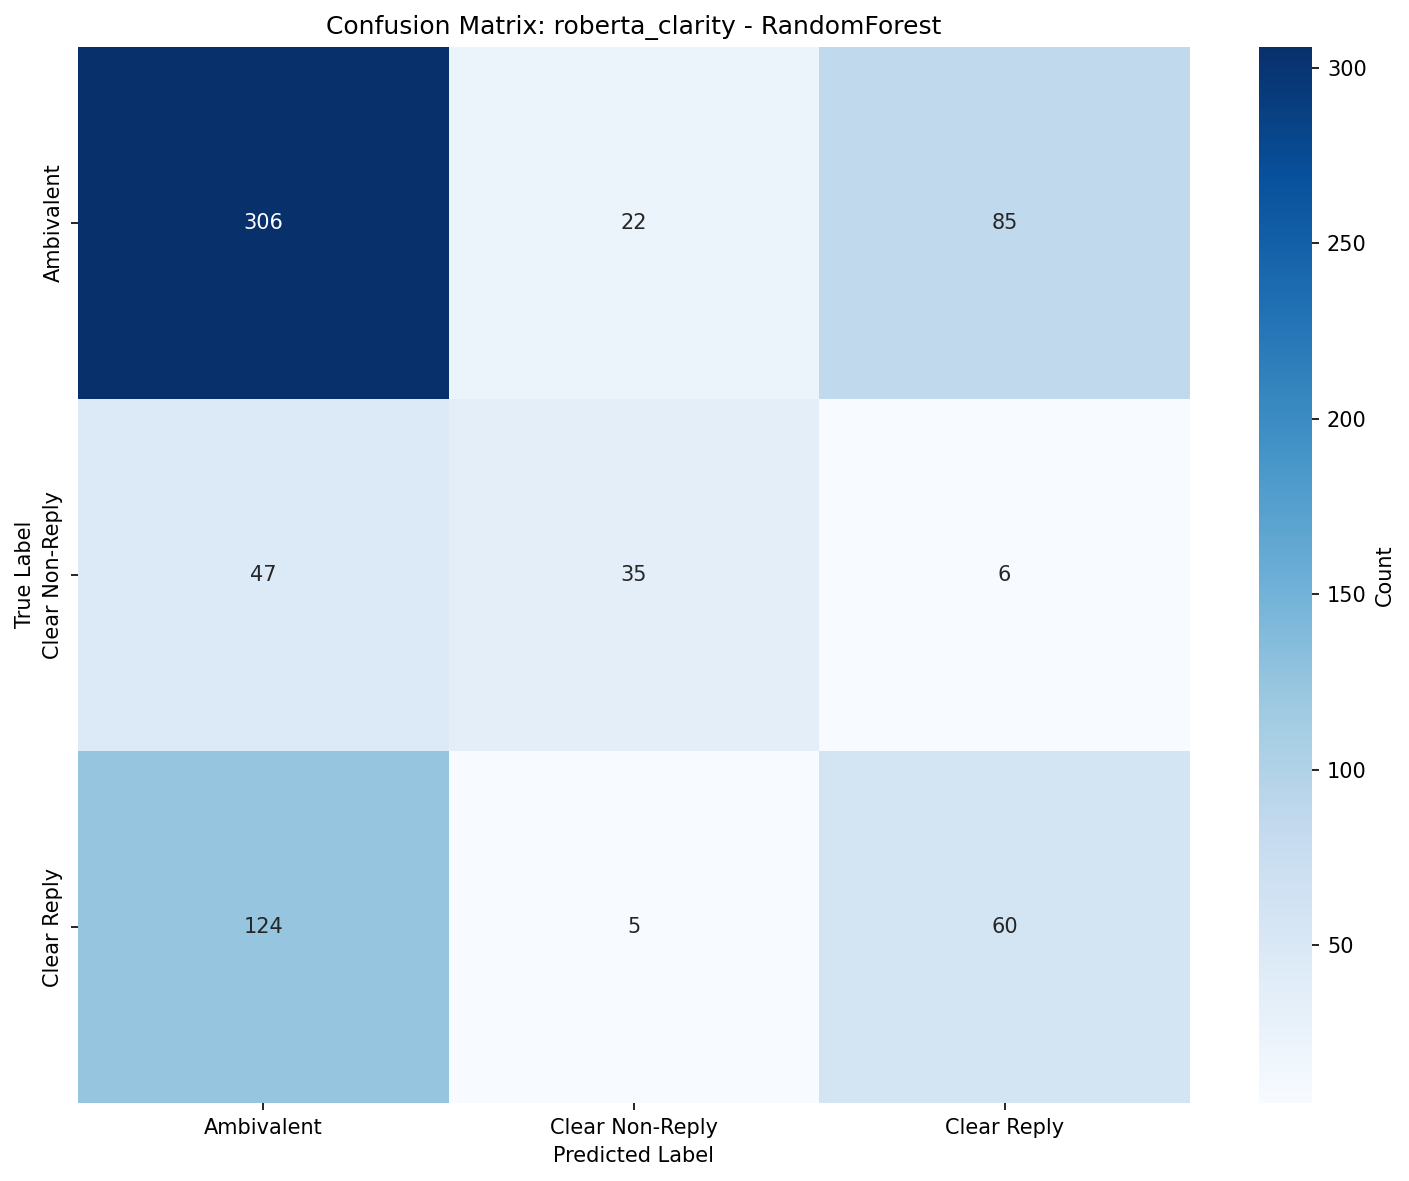

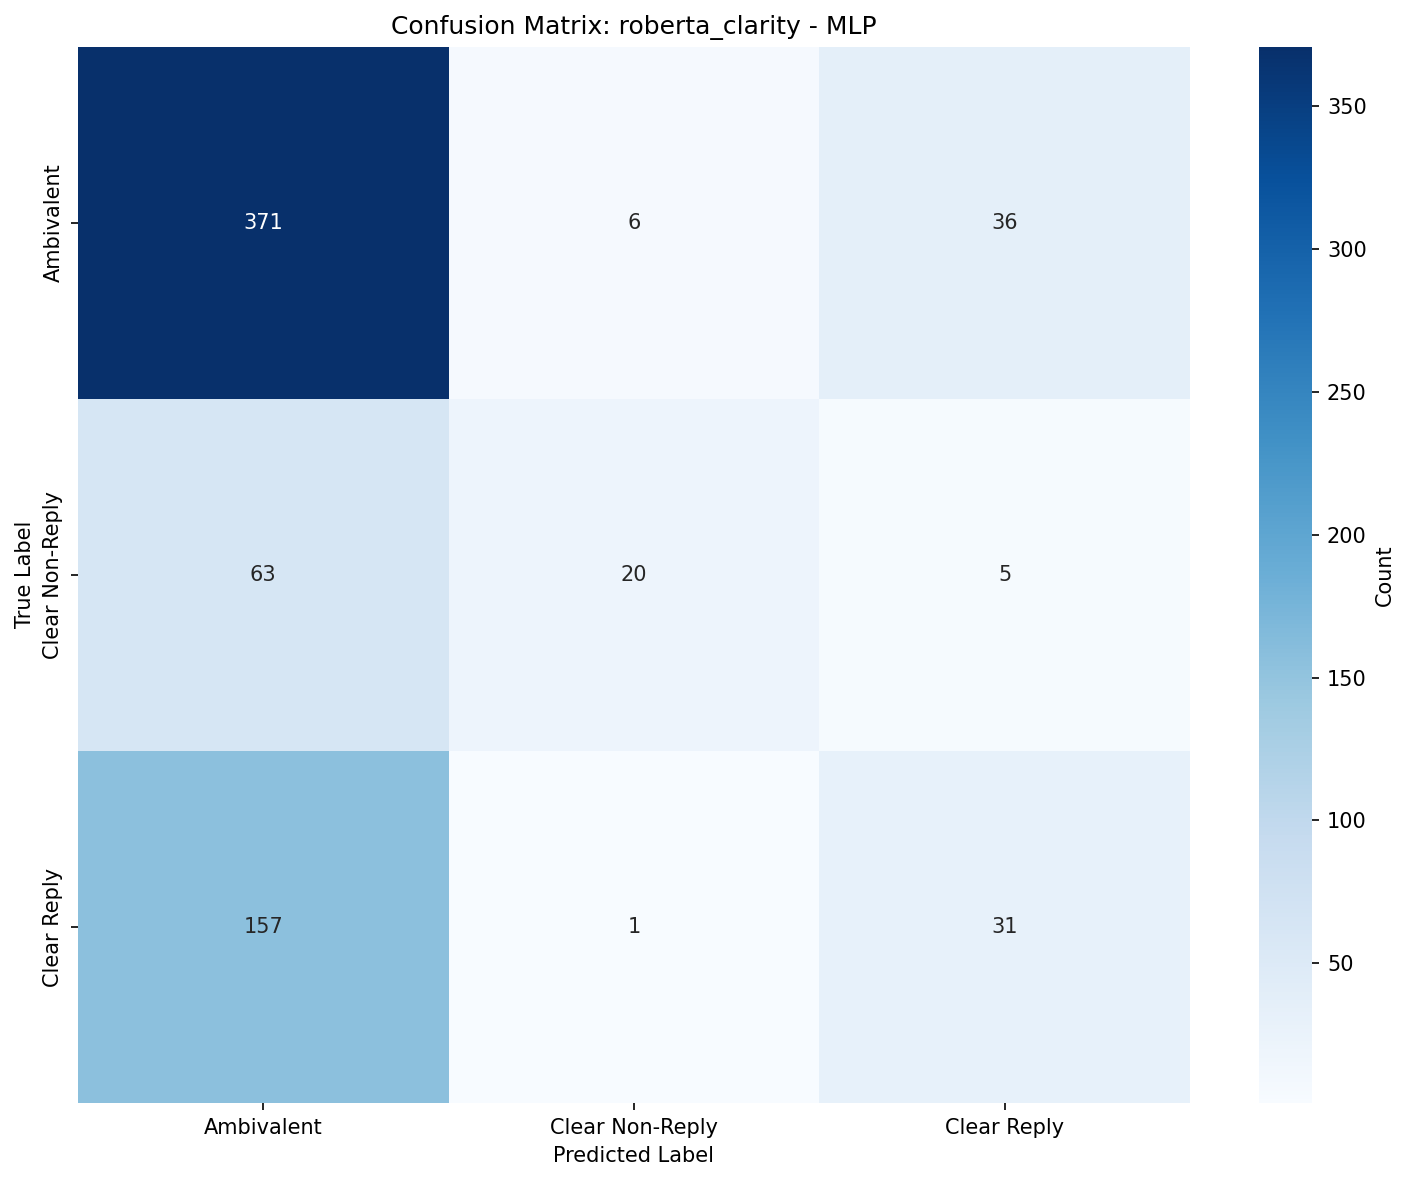

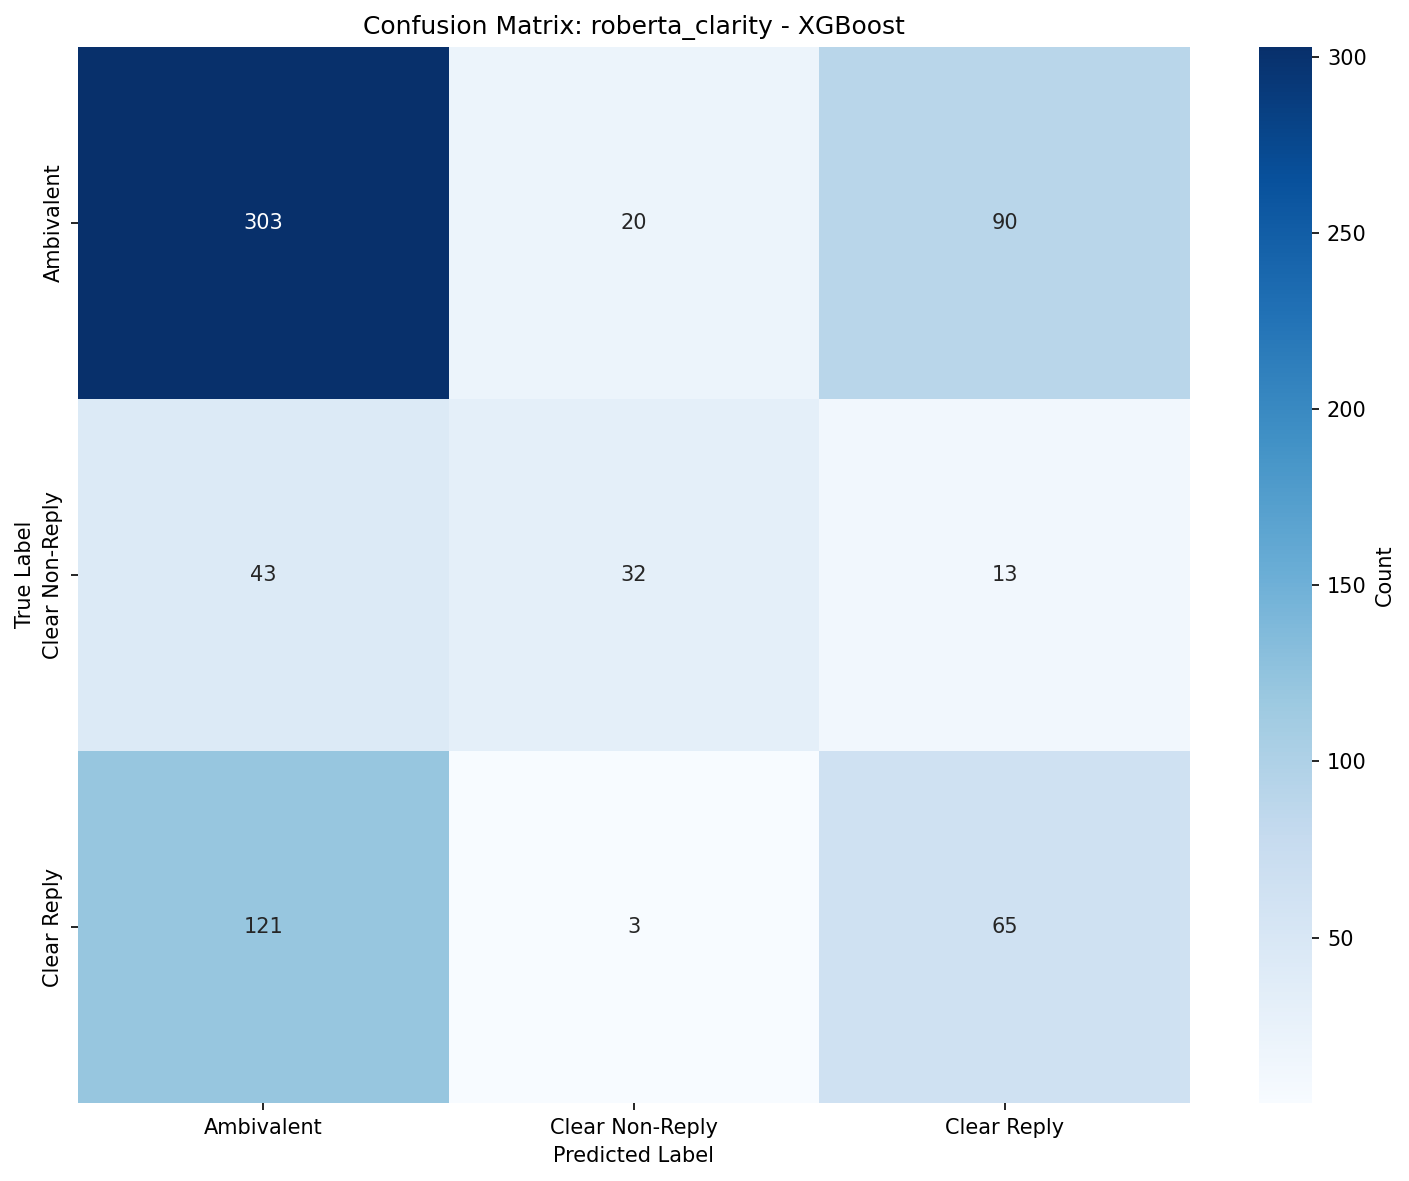

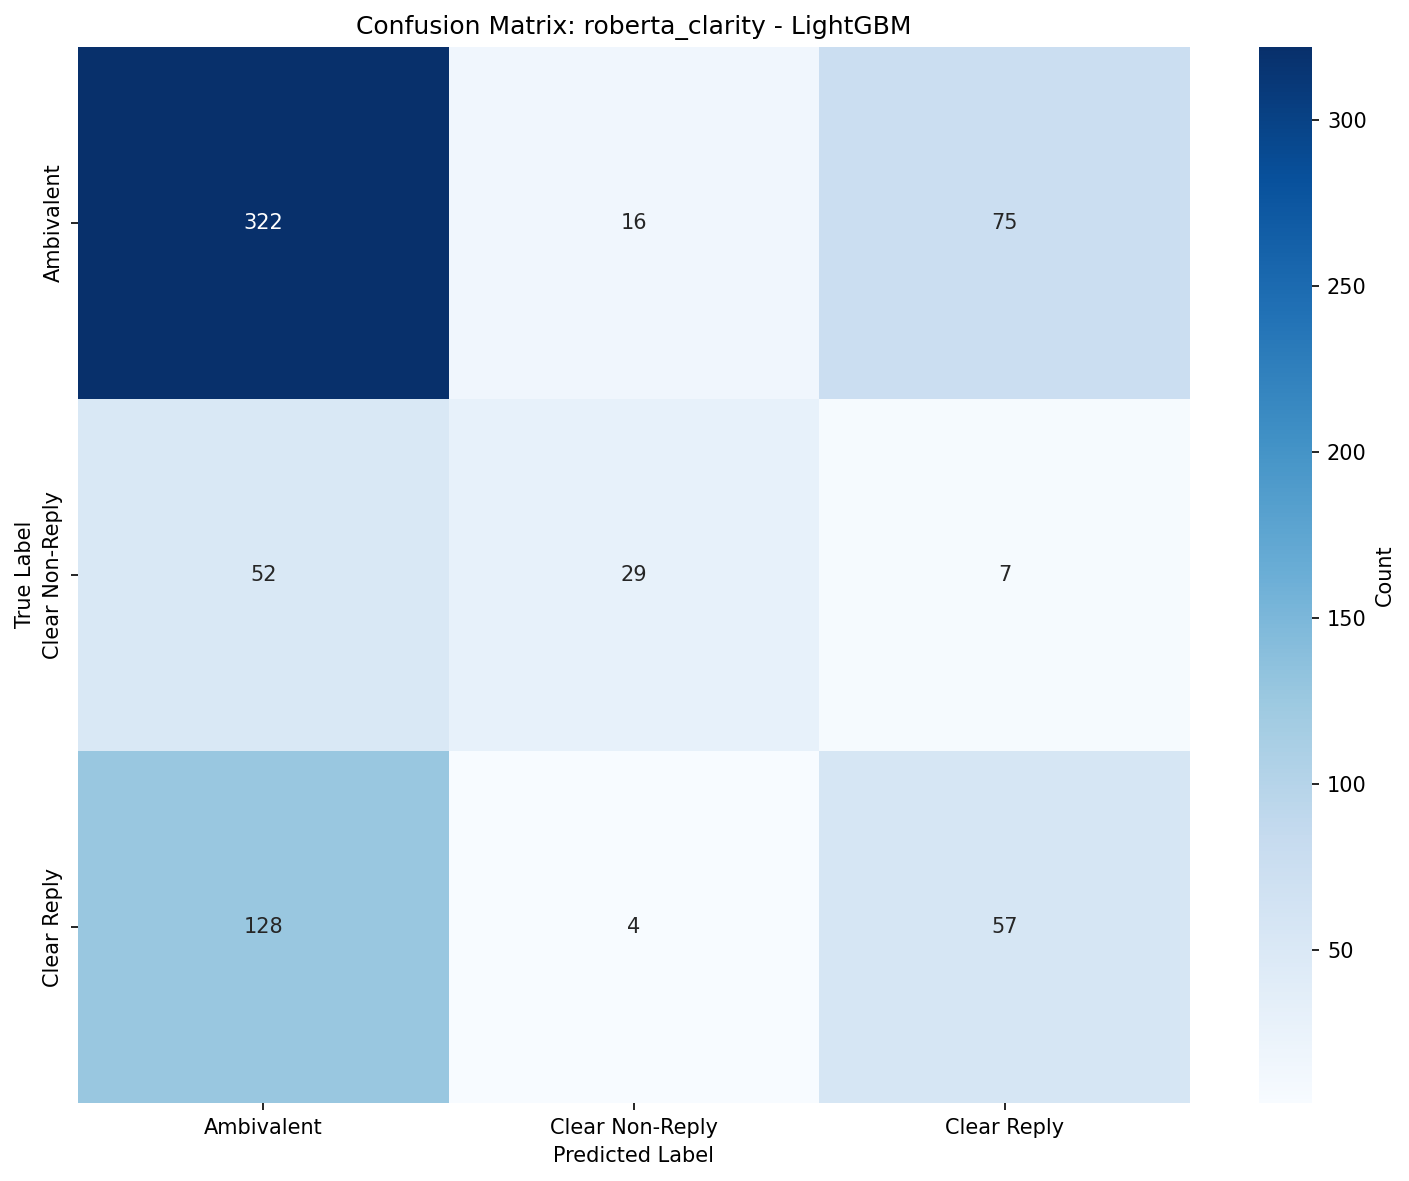


Results Table: roberta_evasion
        Classifier            Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest roberta_evasion  0.342029  0.310696     0.335564         0.355474      0.290374
           XGBoost roberta_evasion  0.321739  0.289846     0.312997         0.346144      0.265763
          LightGBM roberta_evasion  0.323188  0.289282     0.312818         0.334896      0.268649
         LinearSVC roberta_evasion  0.223188  0.199169     0.222149         0.207724      0.262201
LogisticRegression roberta_evasion  0.172464  0.185694     0.173708         0.201111      0.255803
               MLP roberta_evasion  0.305797  0.157306     0.217732         0.190394      0.177509

Per-Class Metrics: roberta_evasion - RandomForest (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.333333 0.259259  0.291667       27
      Clarification   0.823529 0.500000  0.622222       28
Declining to answer   0.4761

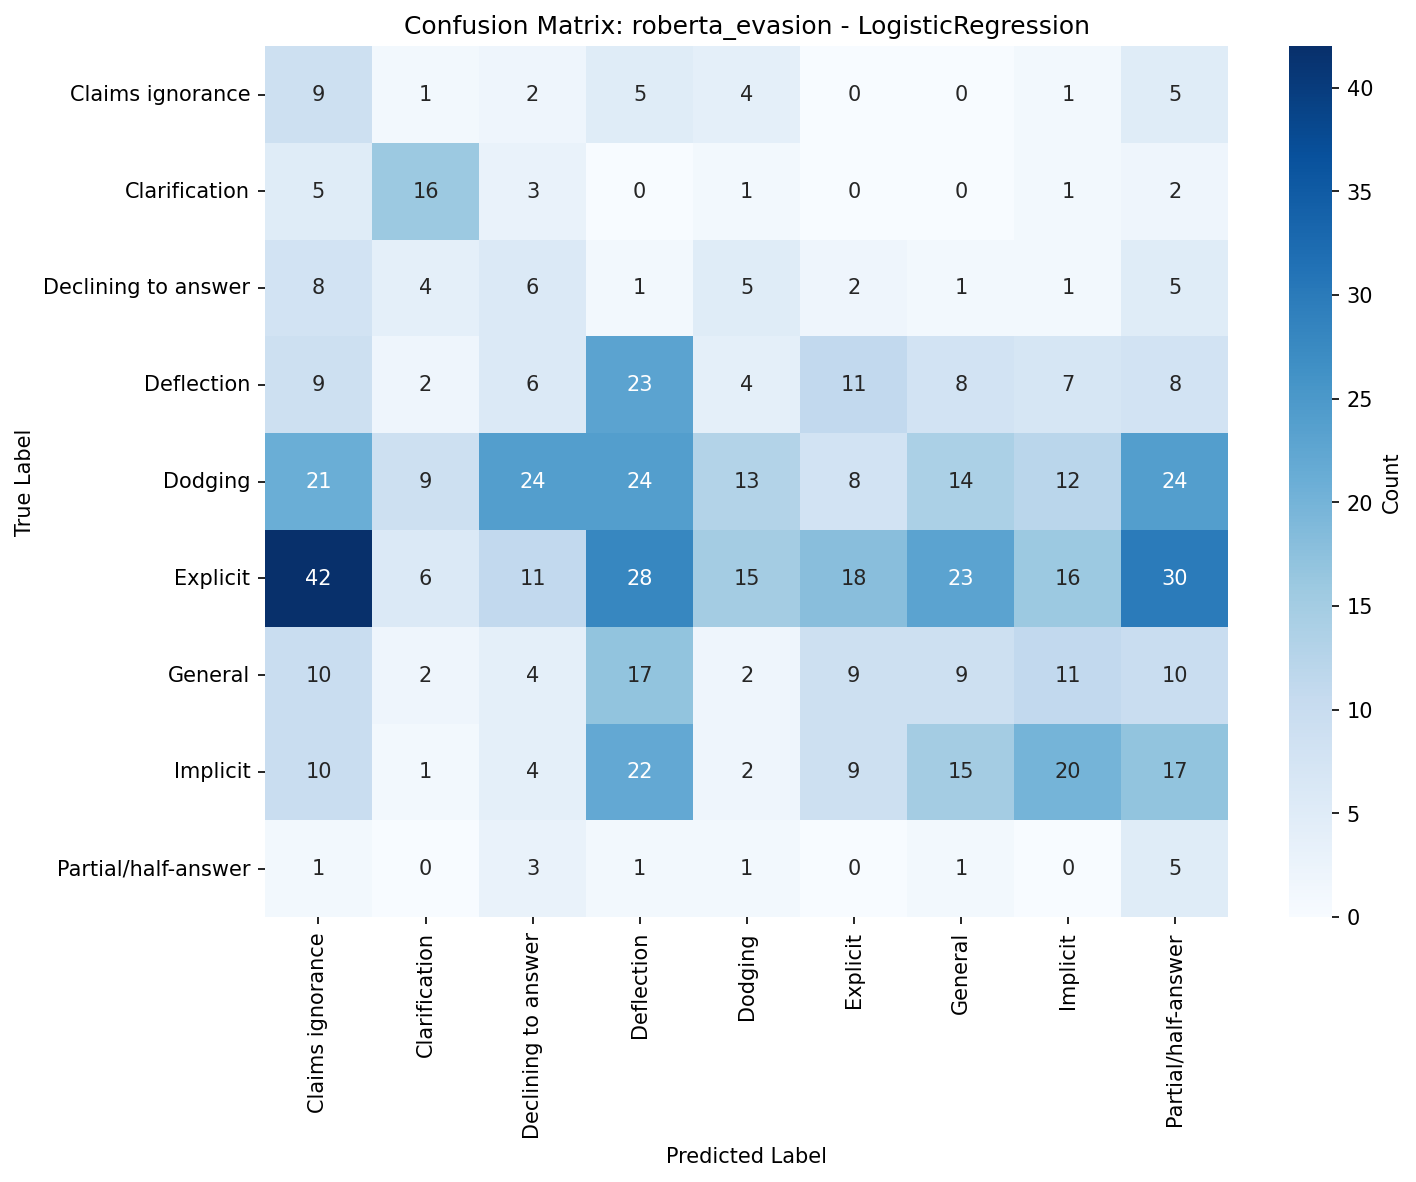

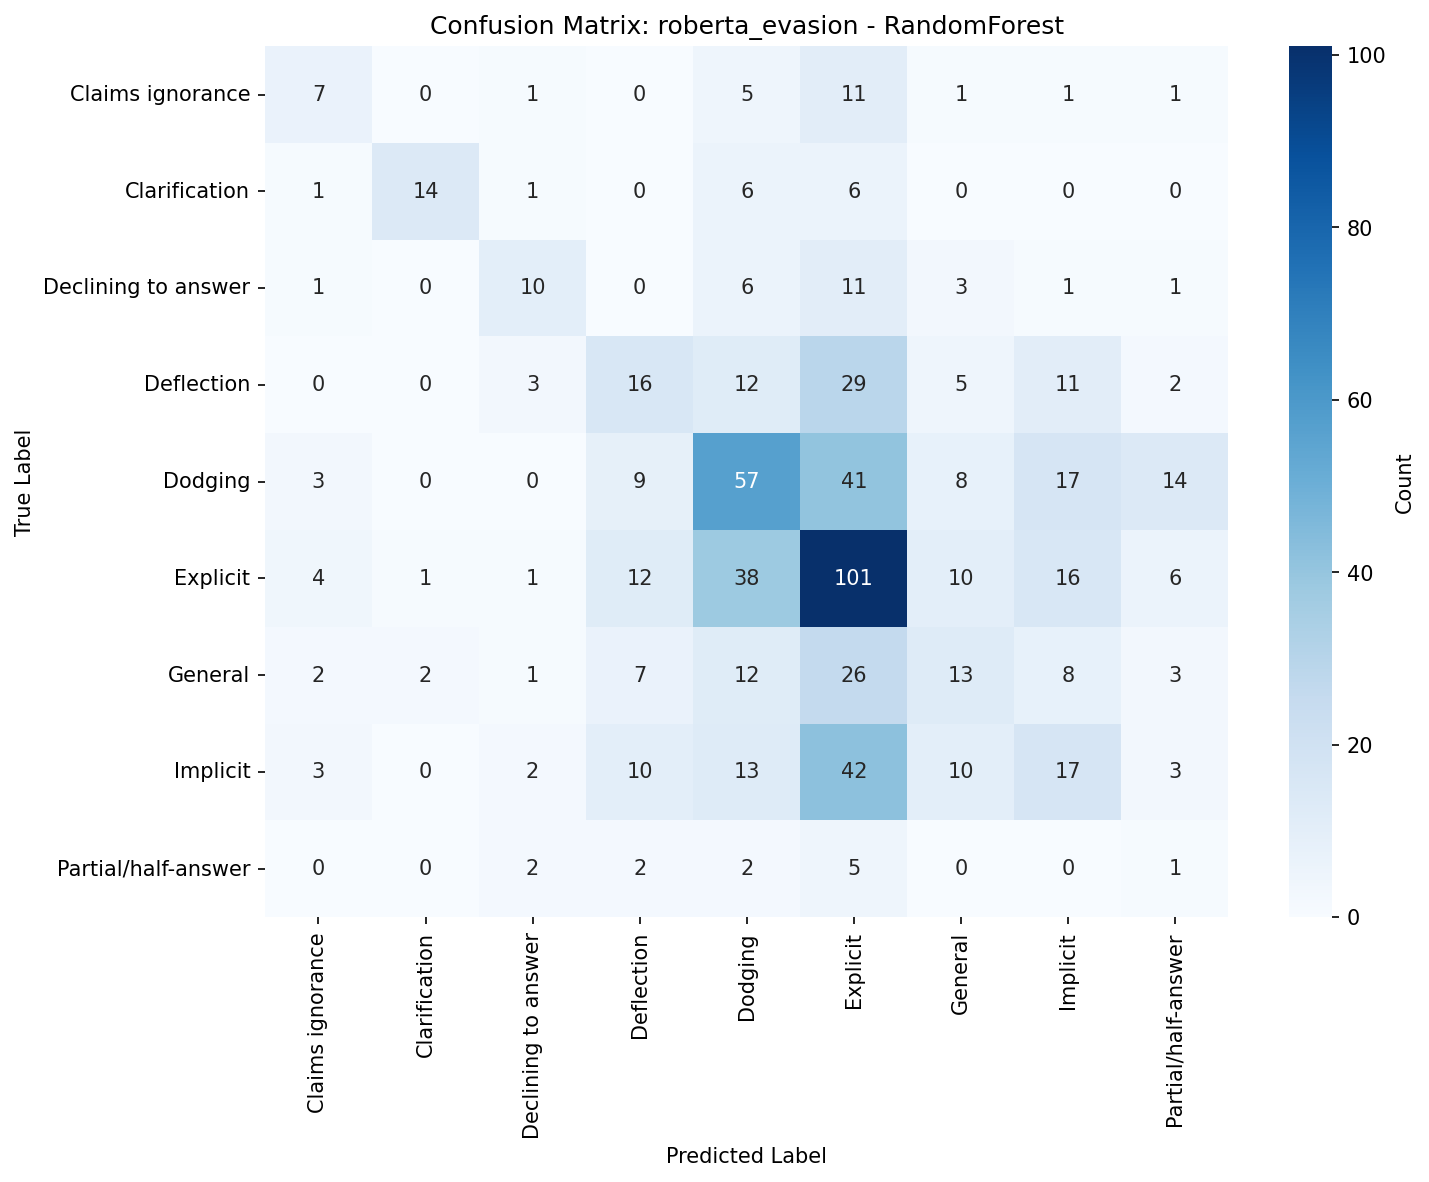

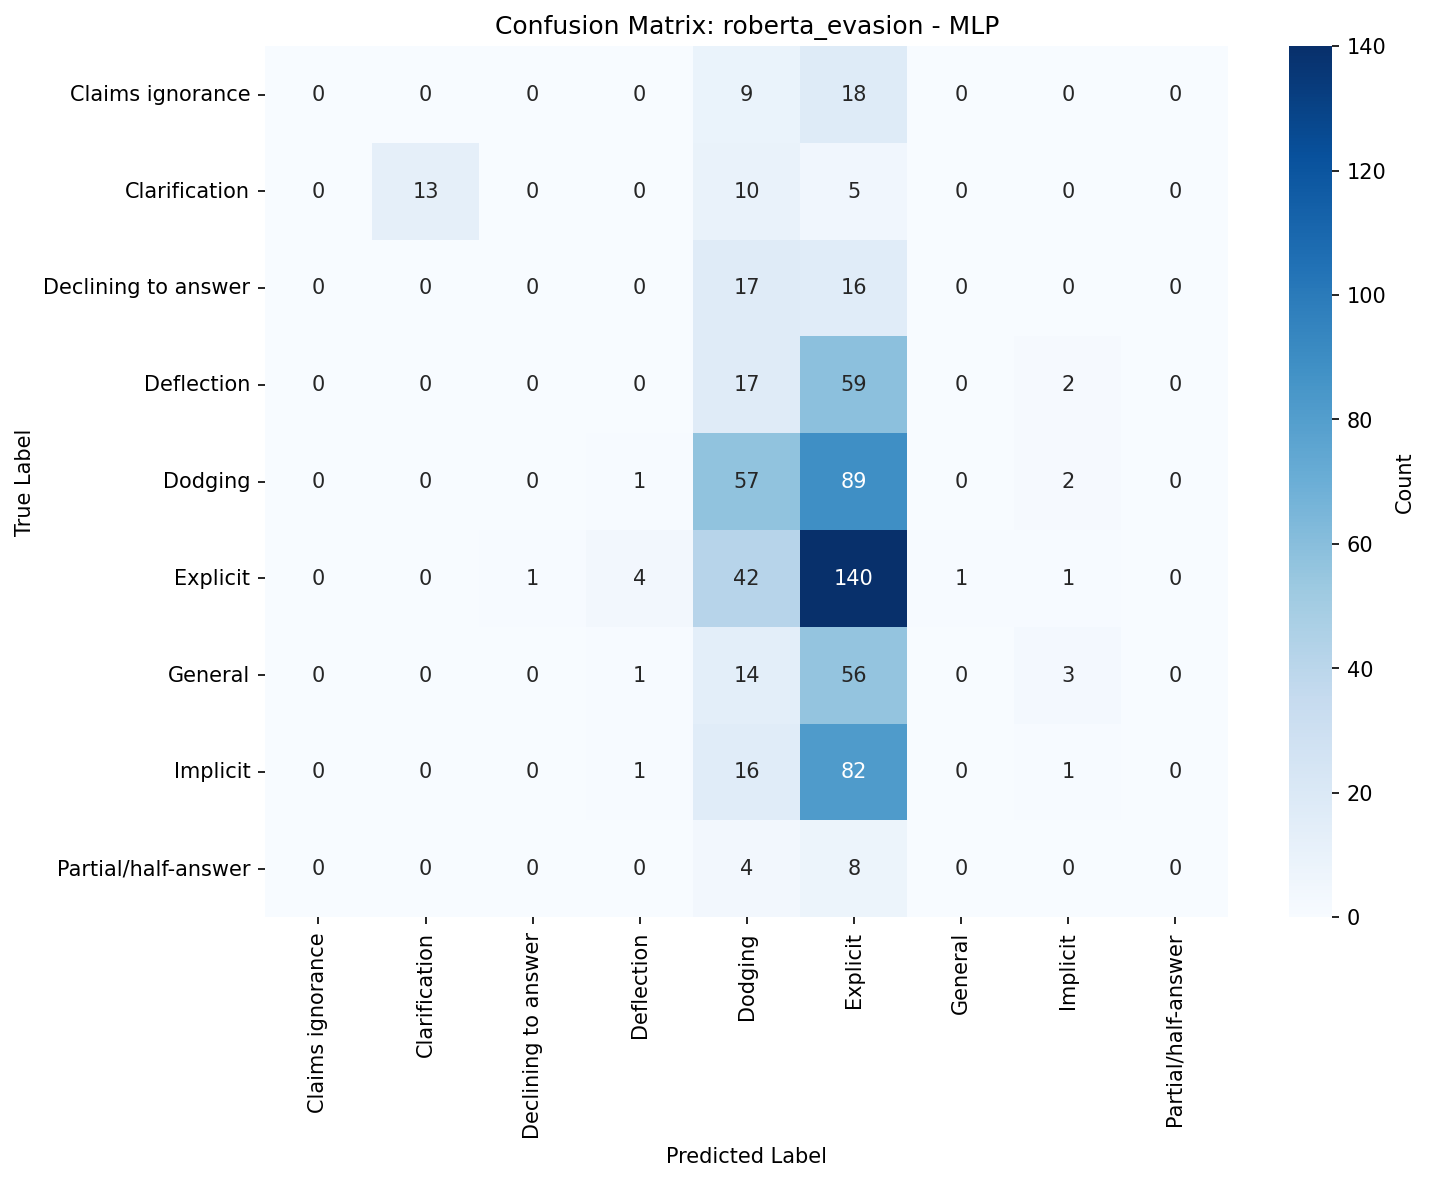

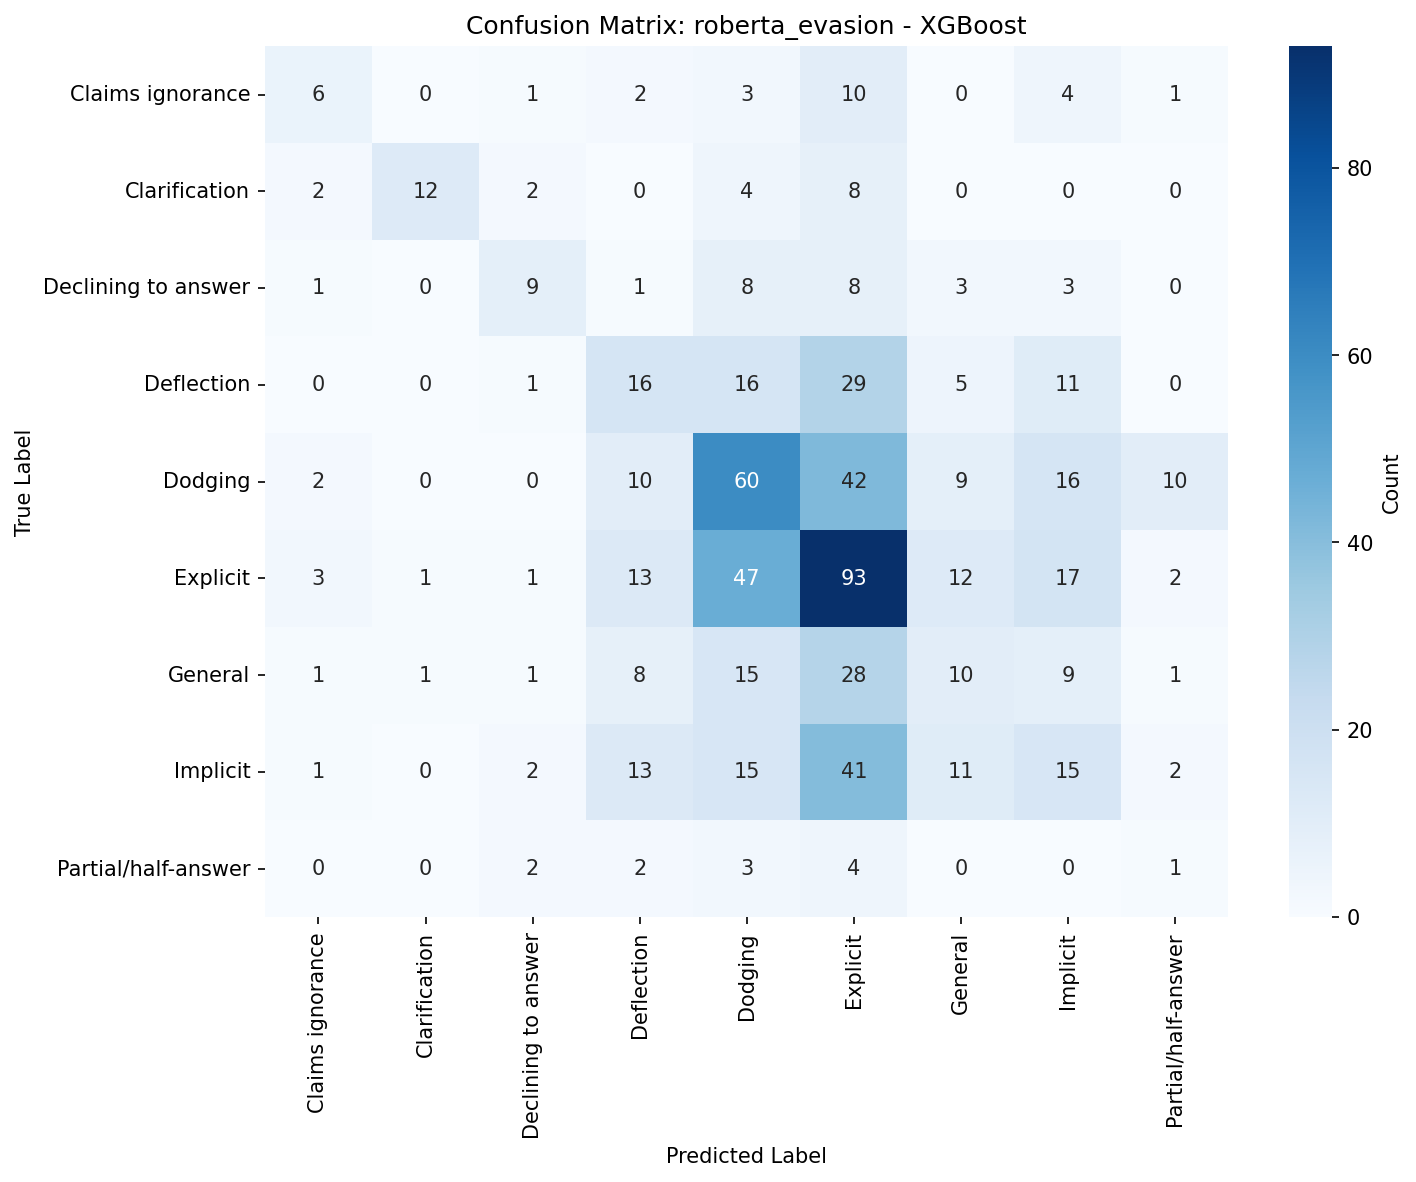

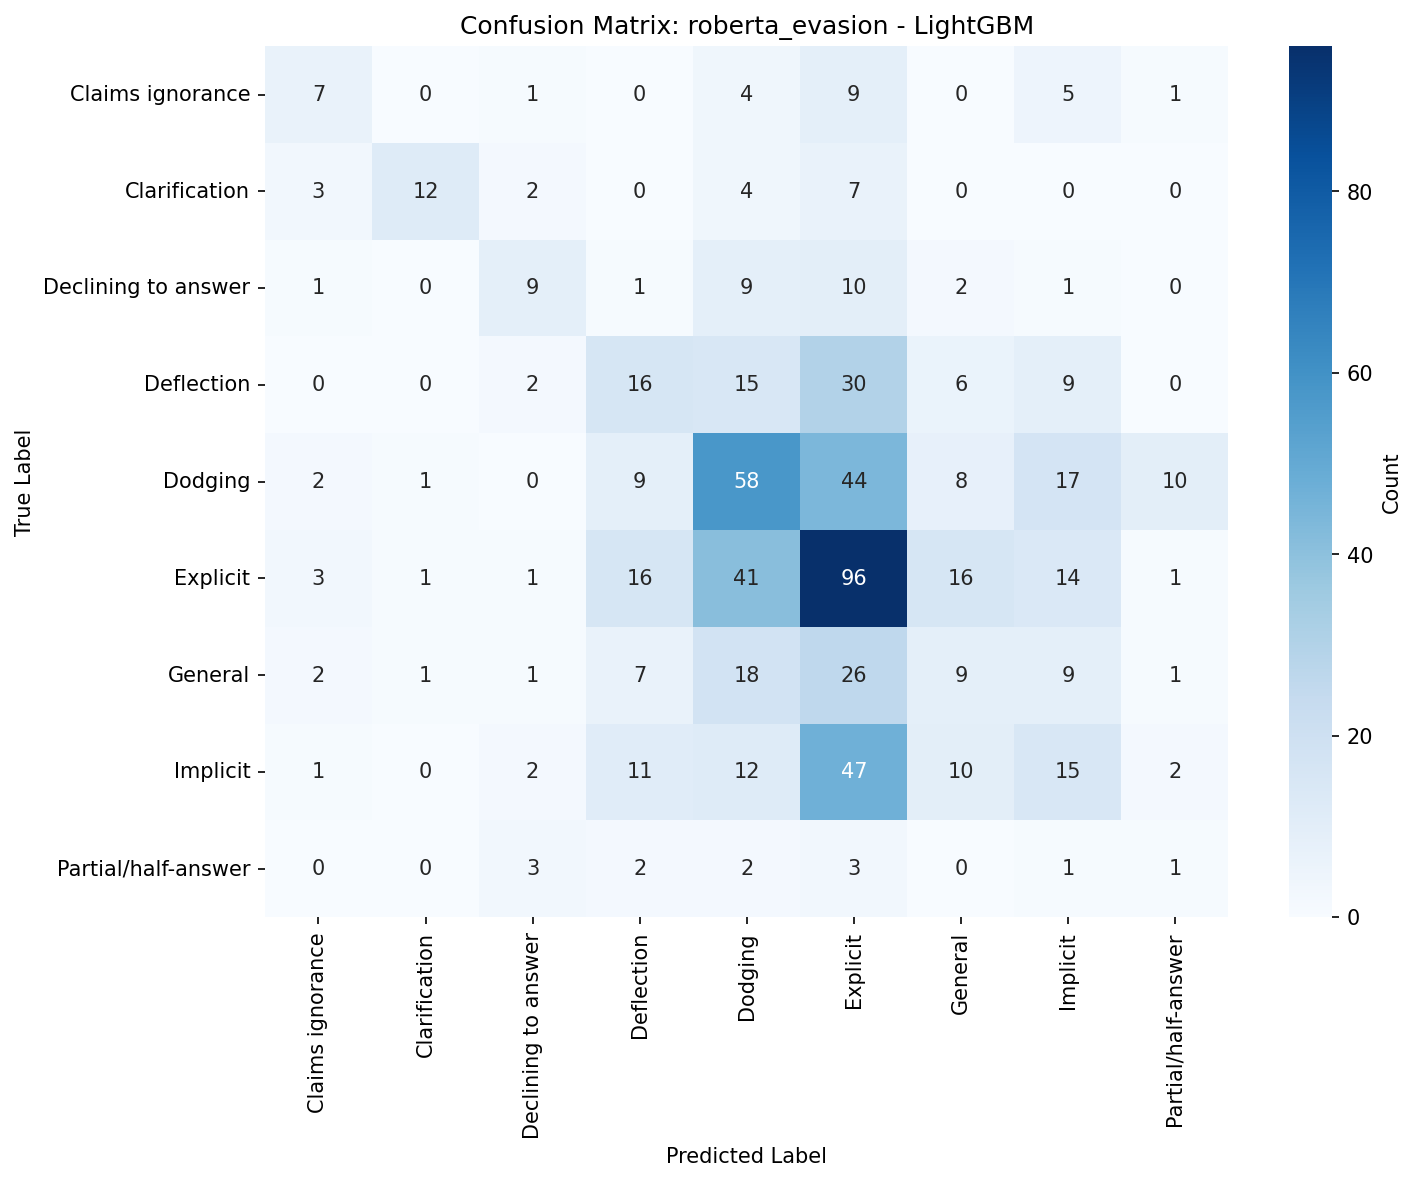


Results Table: deberta_clarity
        Classifier            Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
           XGBoost deberta_clarity  0.600000  0.523778     0.588096         0.570610      0.500644
      RandomForest deberta_clarity  0.597101  0.522268     0.586197         0.560216      0.501900
          LightGBM deberta_clarity  0.597101  0.510026     0.582243         0.551186      0.490199
               MLP deberta_clarity  0.626087  0.435266     0.557615         0.665401      0.426971
         LinearSVC deberta_clarity  0.560870  0.432552     0.530826         0.452126      0.441213
LogisticRegression deberta_clarity  0.452174  0.421918     0.466929         0.420303      0.473776

Per-Class Metrics: deberta_clarity - XGBoost (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.662447 0.760291  0.708005      413
Clear Non-Reply   0.648148 0.397727  0.492958       88
    Clear Reply   0.401235 0.343915  0.370370

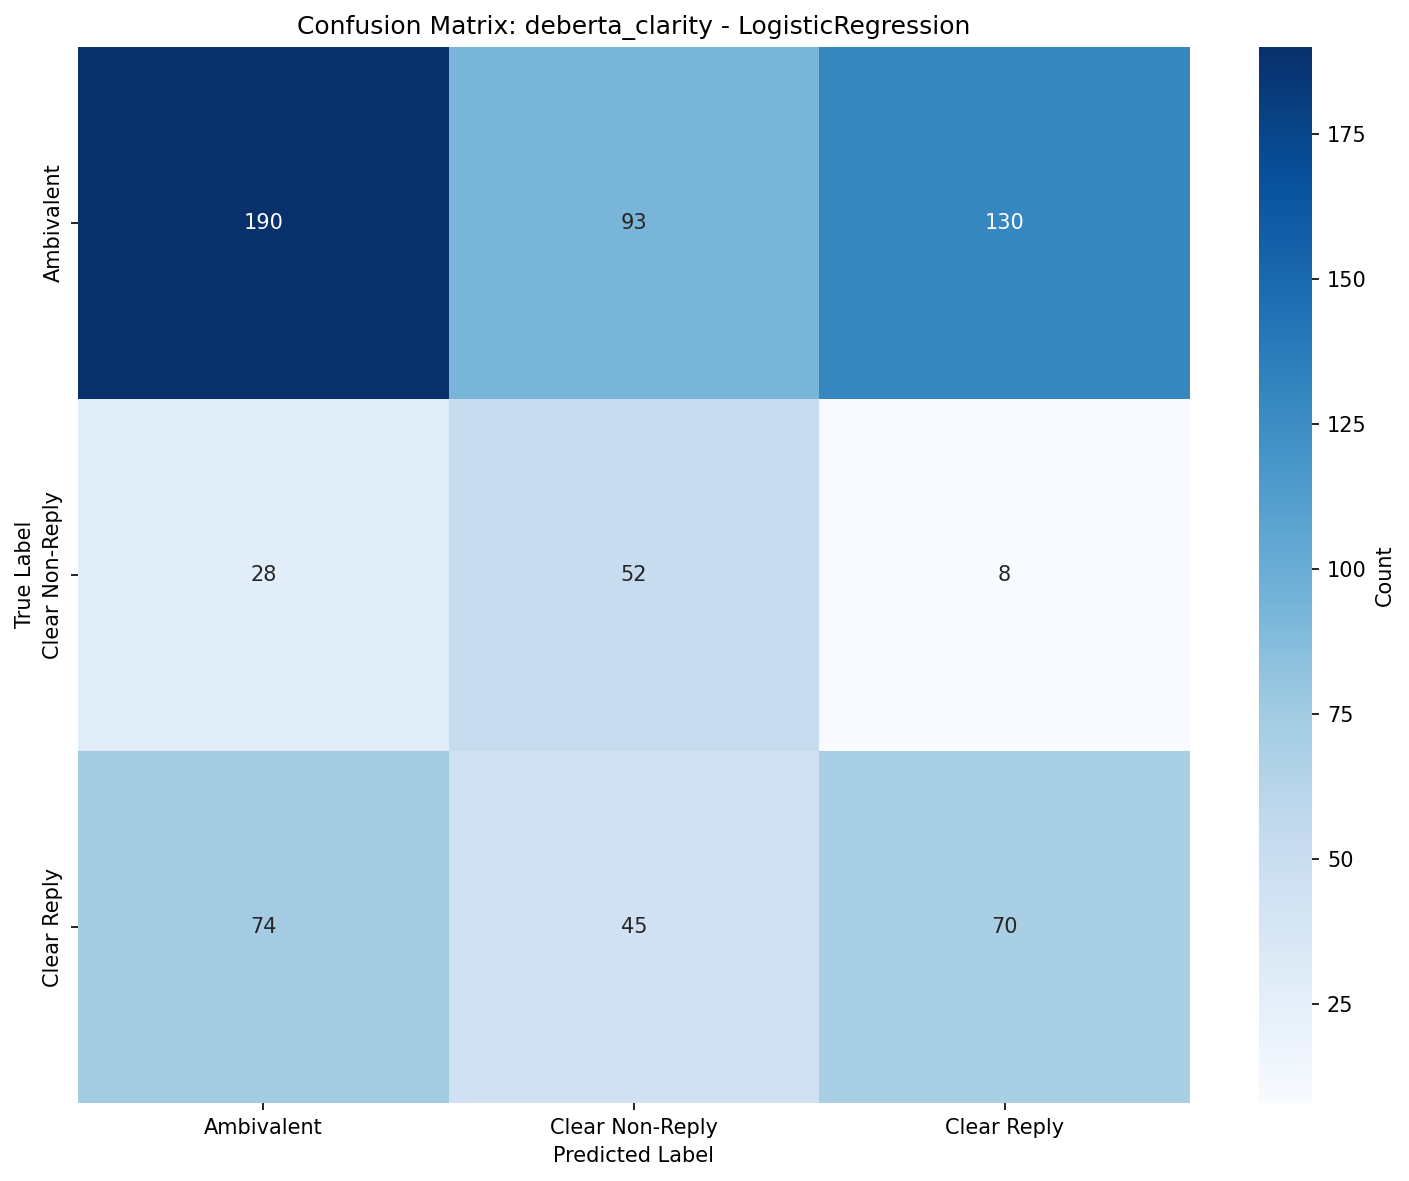

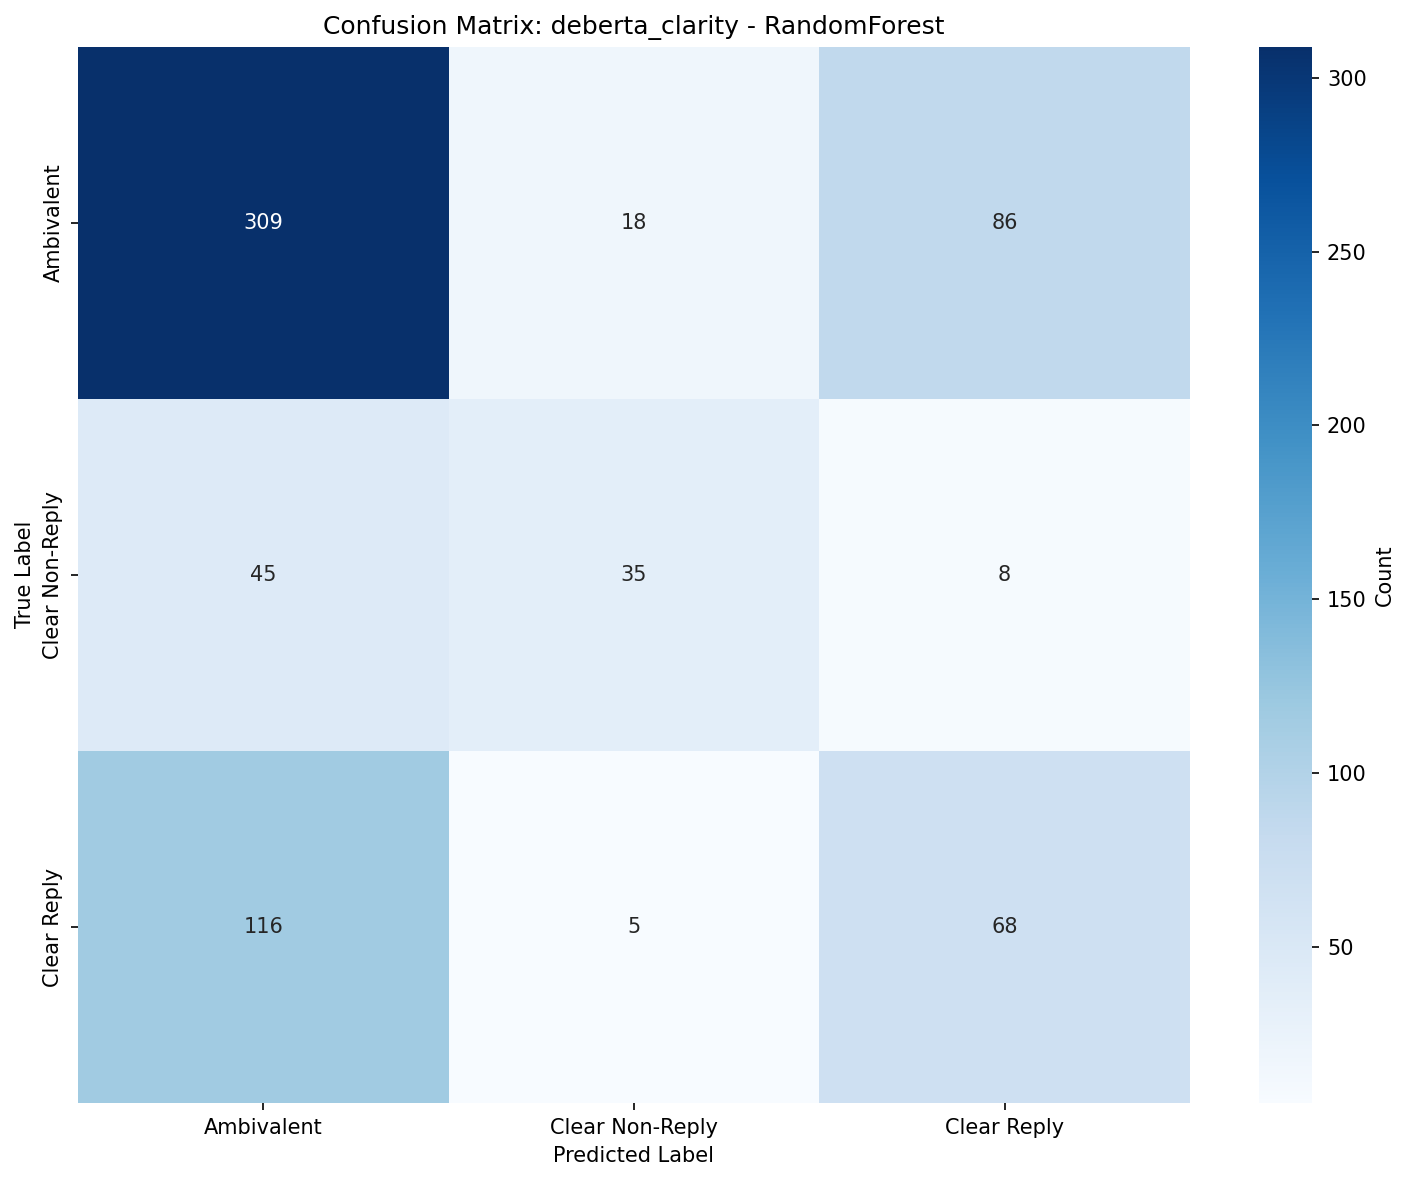

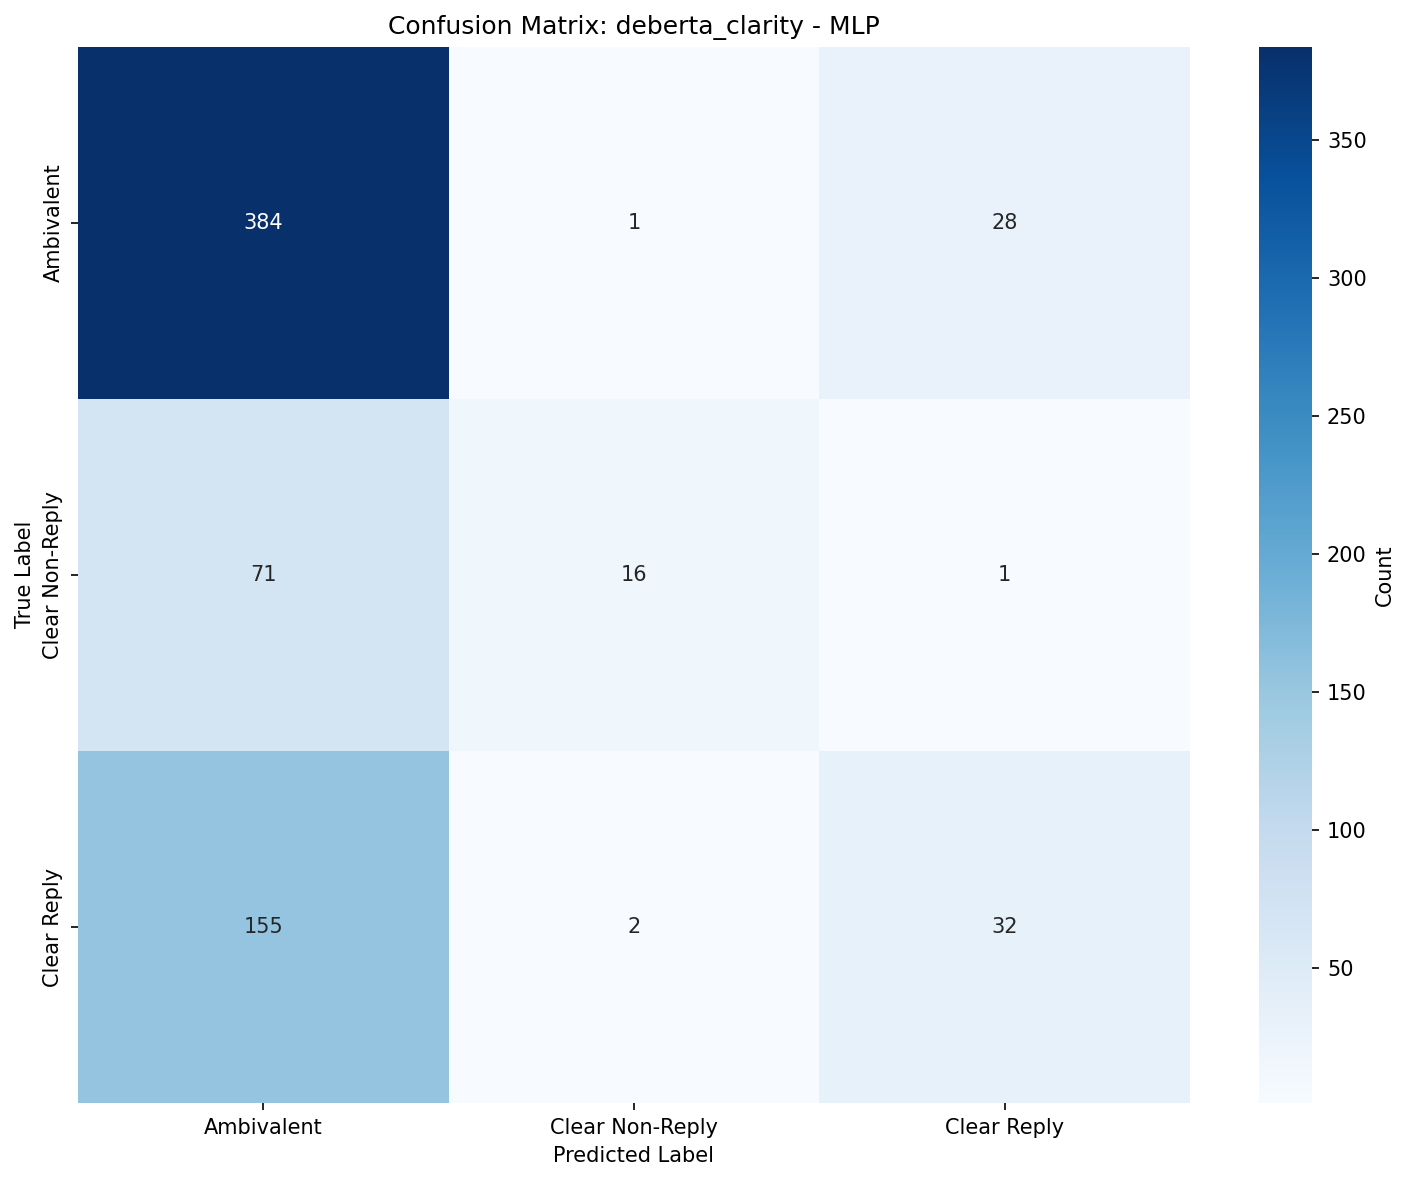

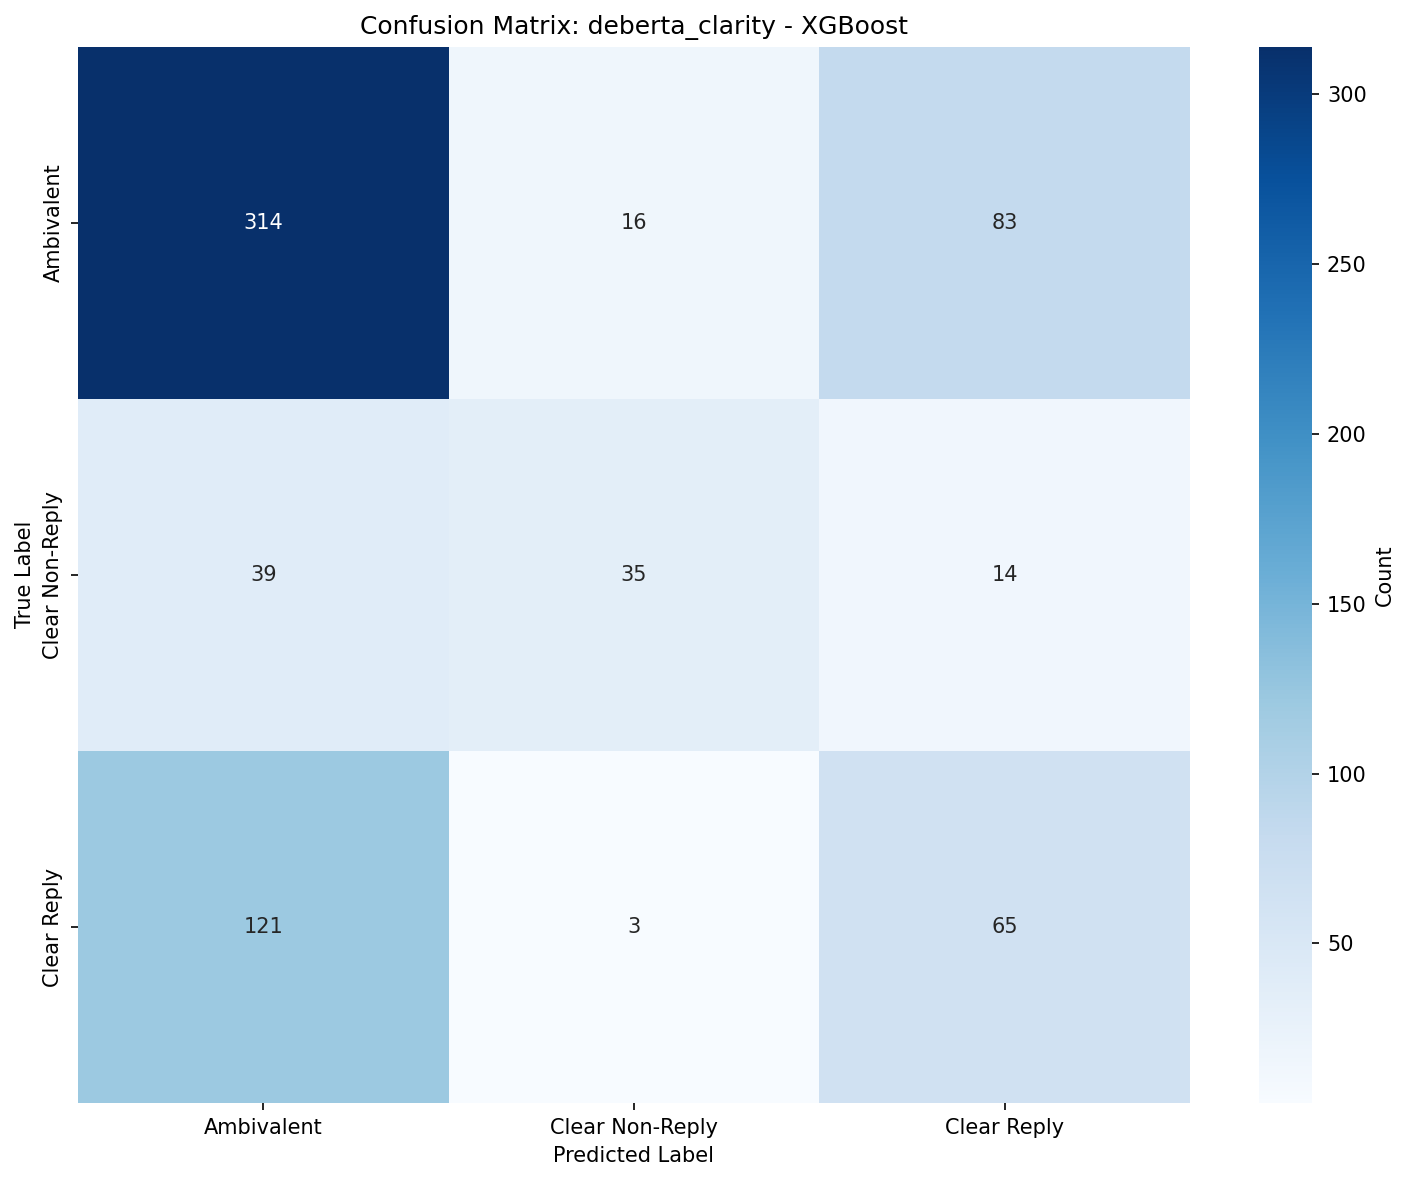

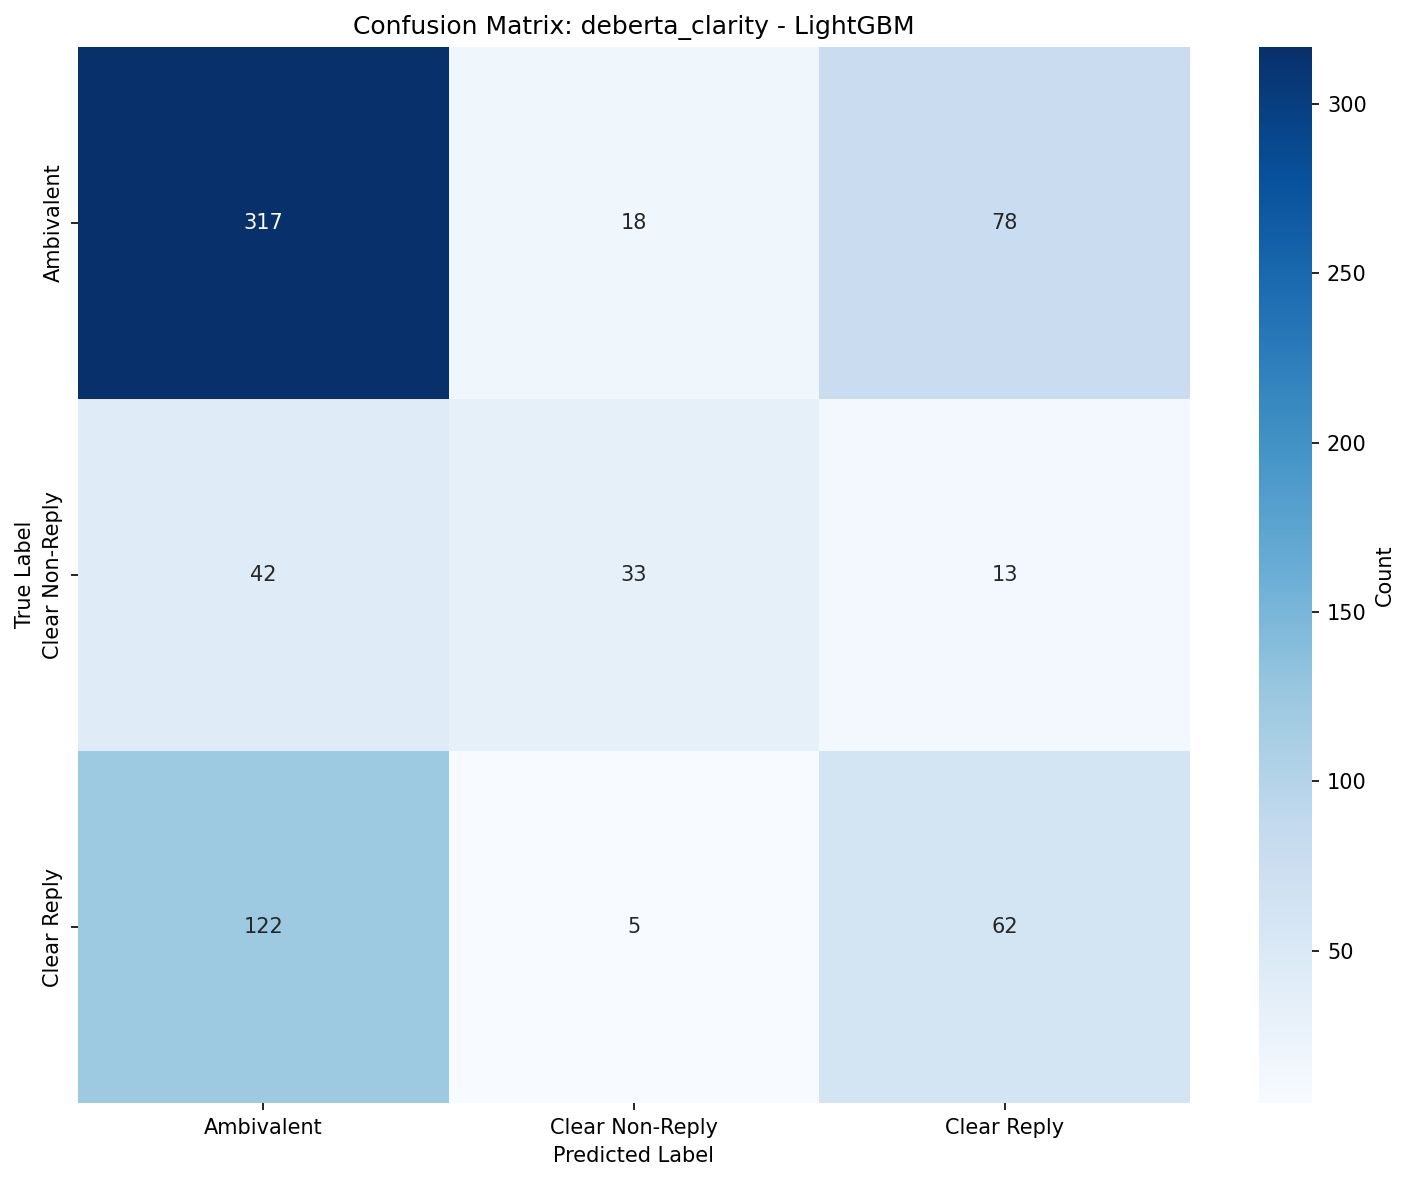


Results Table: deberta_evasion
        Classifier            Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
           XGBoost deberta_evasion  0.331884  0.310107     0.324119         0.349993      0.289304
      RandomForest deberta_evasion  0.336232  0.307965     0.329107         0.346855      0.289921
          LightGBM deberta_evasion  0.337681  0.305405     0.325870         0.355851      0.282775
               MLP deberta_evasion  0.307246  0.220568     0.260804         0.322396      0.207798
         LinearSVC deberta_evasion  0.223188  0.198742     0.222941         0.204182      0.268679
LogisticRegression deberta_evasion  0.163768  0.169723     0.159264         0.189602      0.245425

Per-Class Metrics: deberta_evasion - XGBoost (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.388889 0.259259  0.311111       27
      Clarification   0.888889 0.571429  0.695652       28
Declining to answer   0.409091 0.

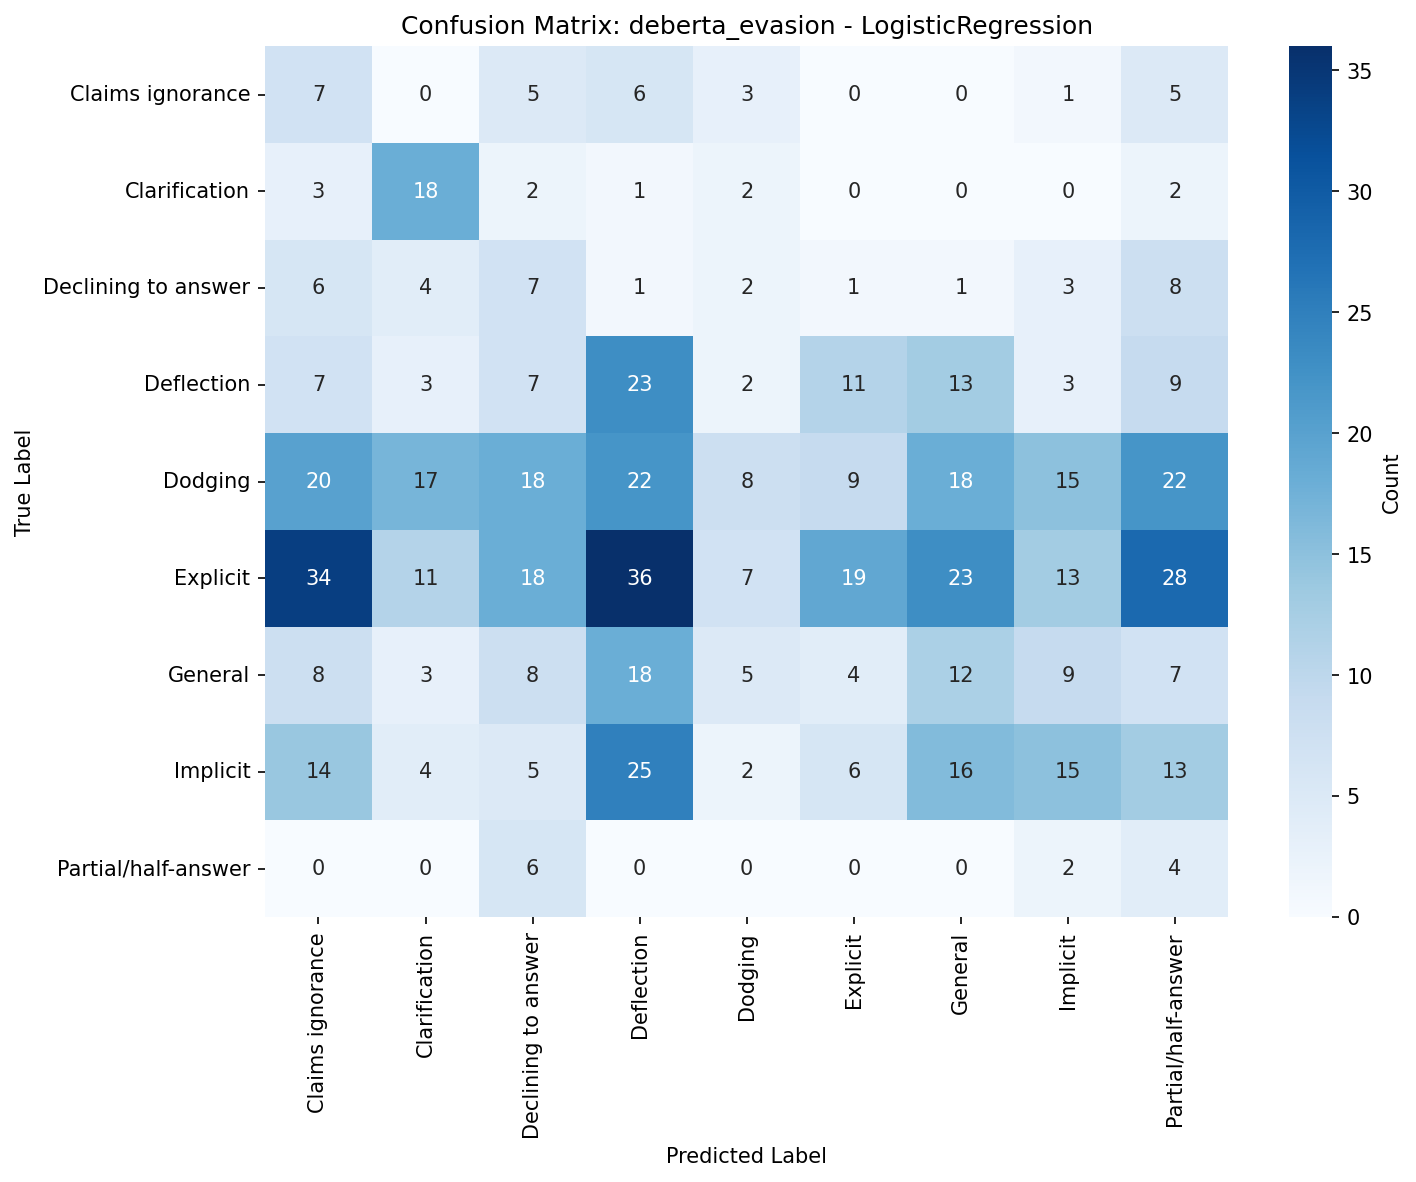

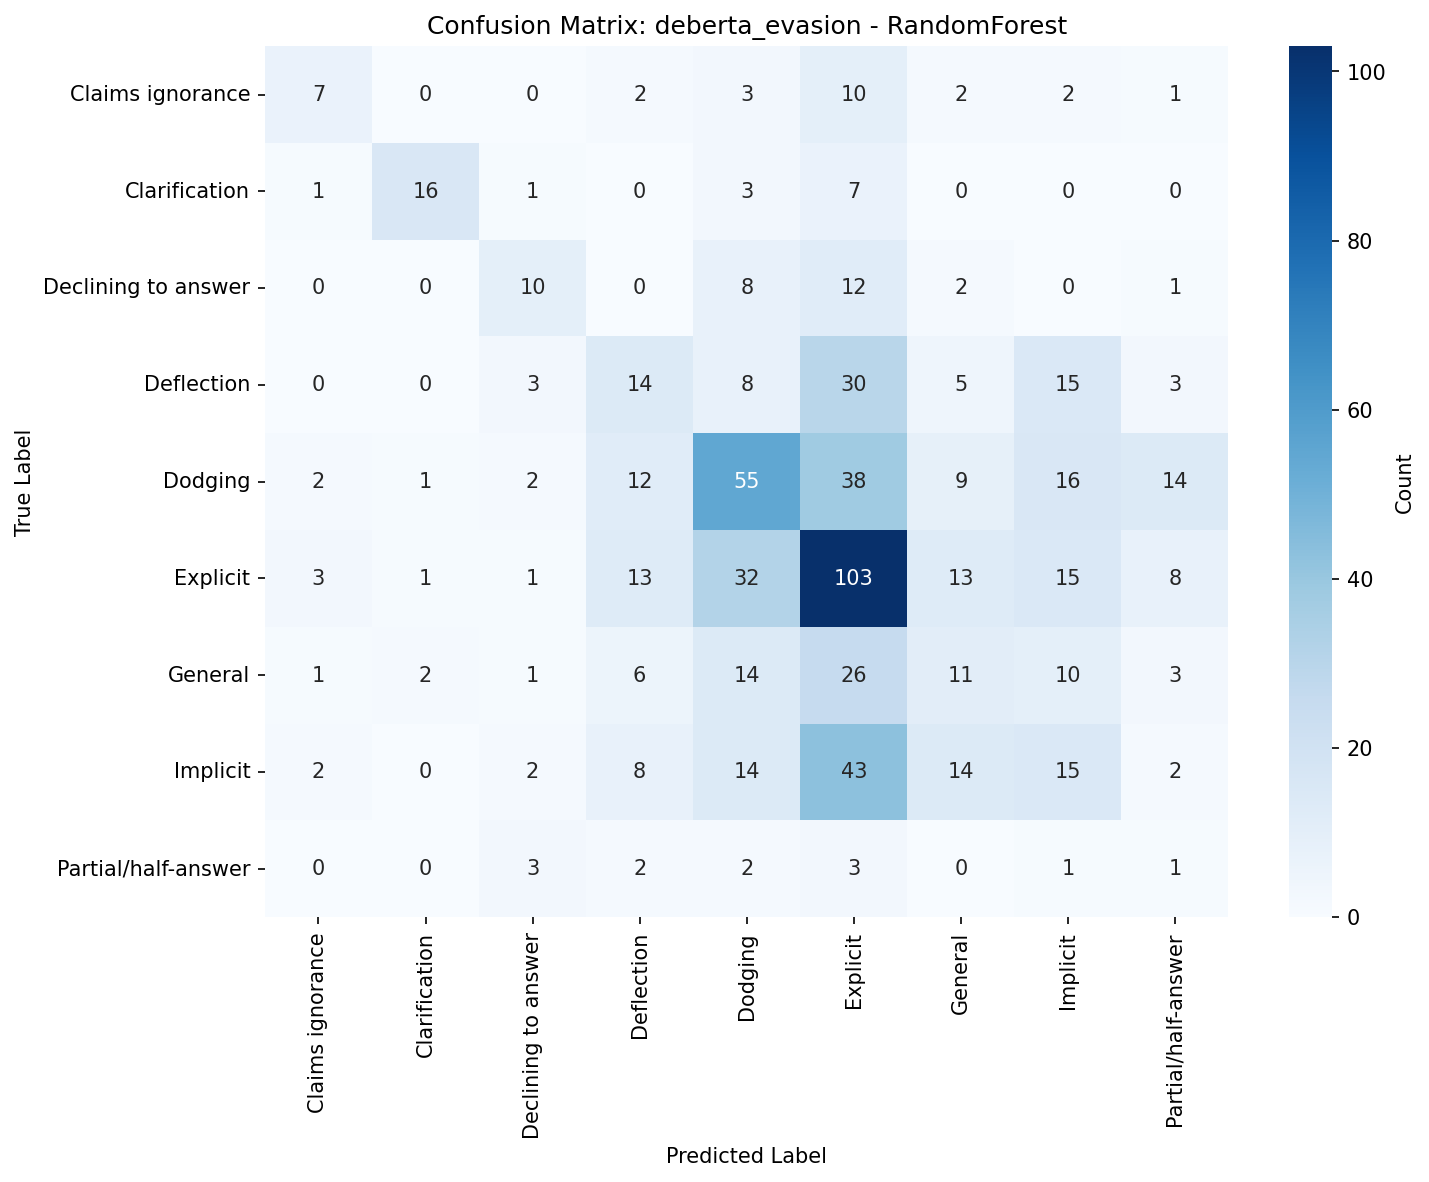

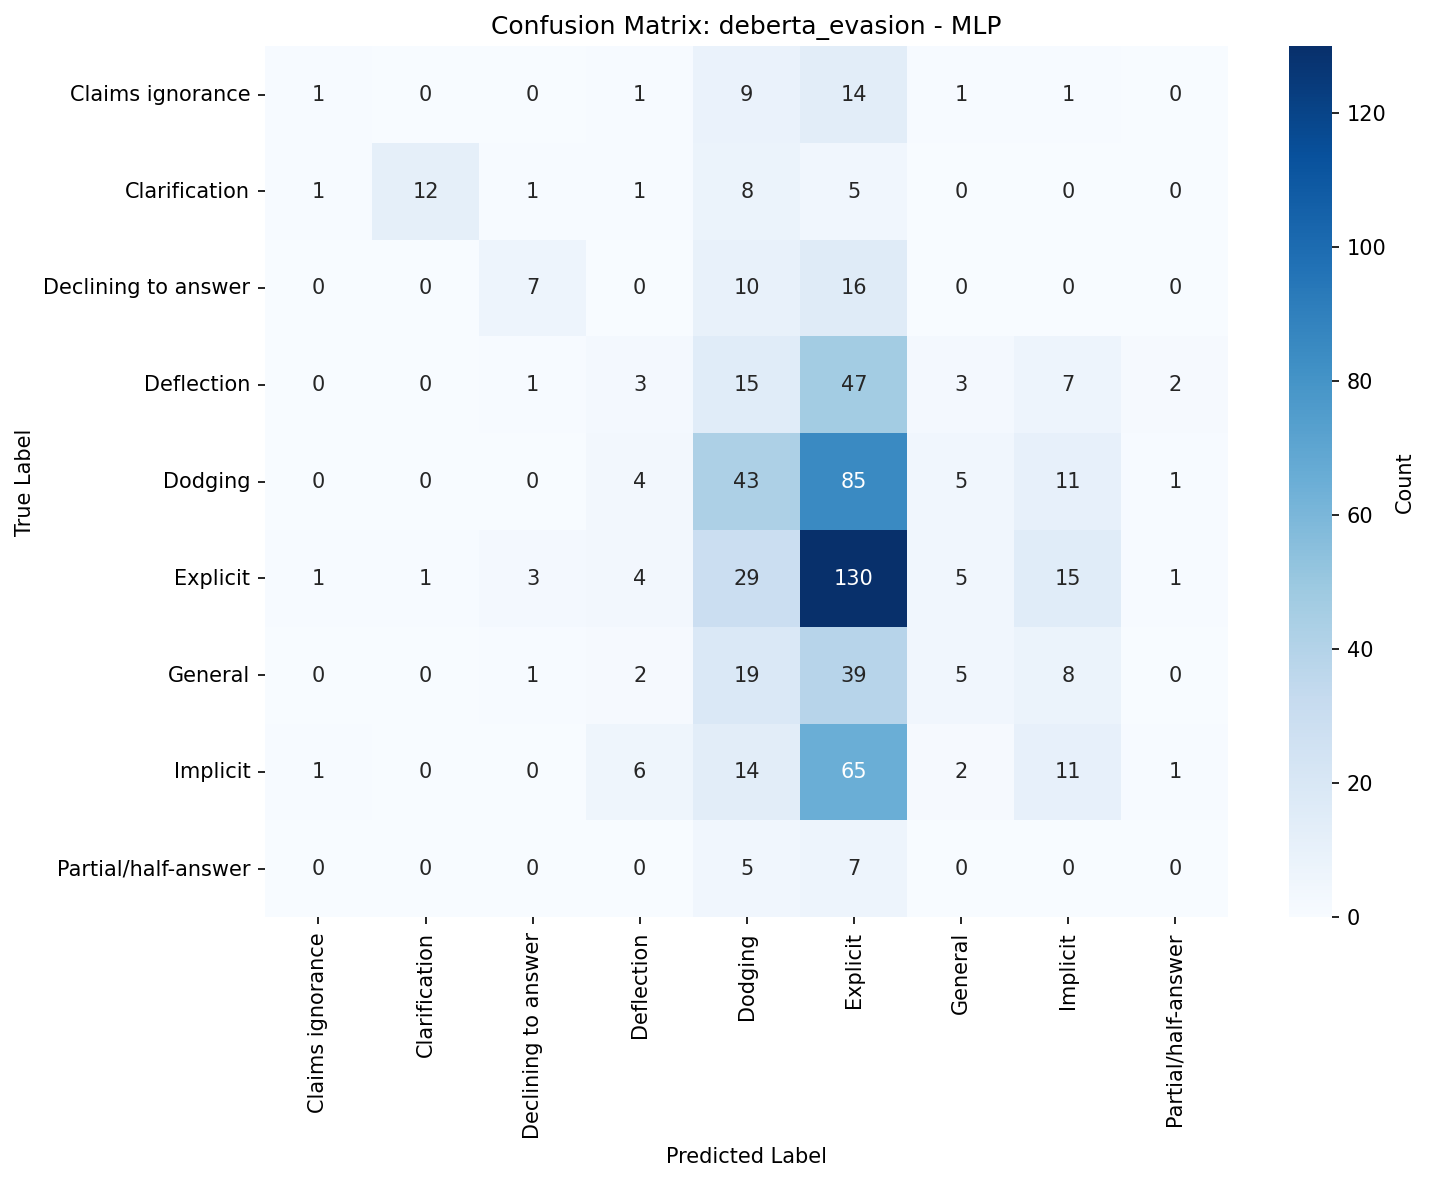

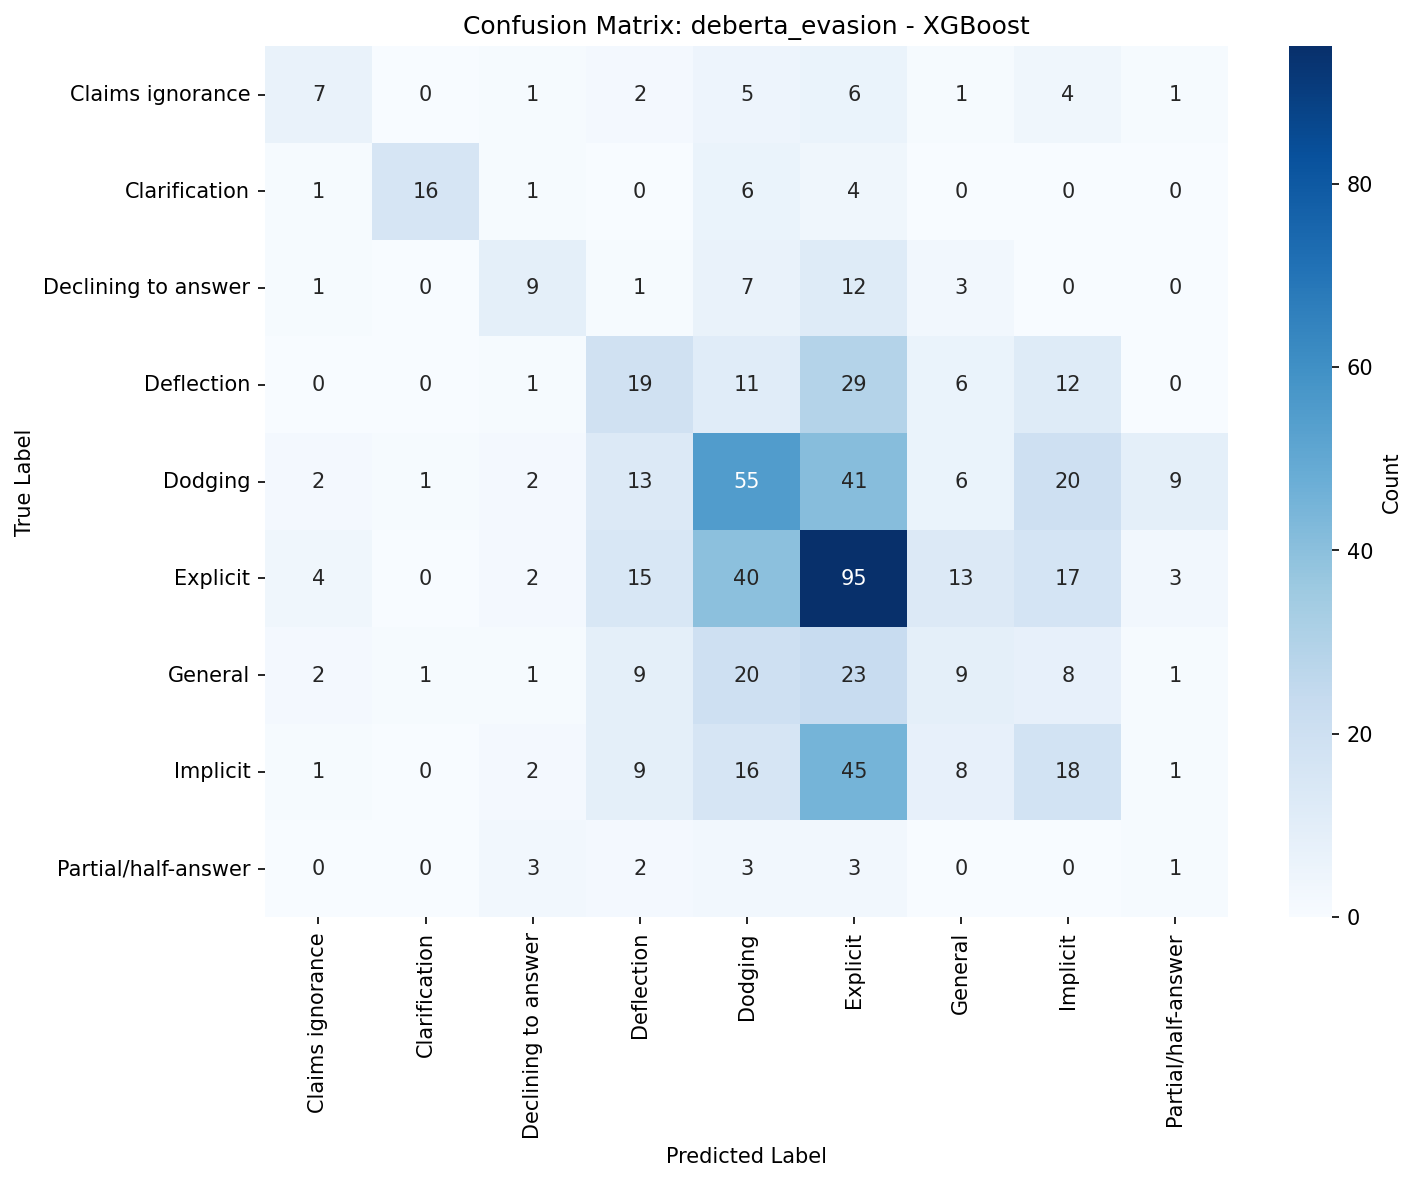

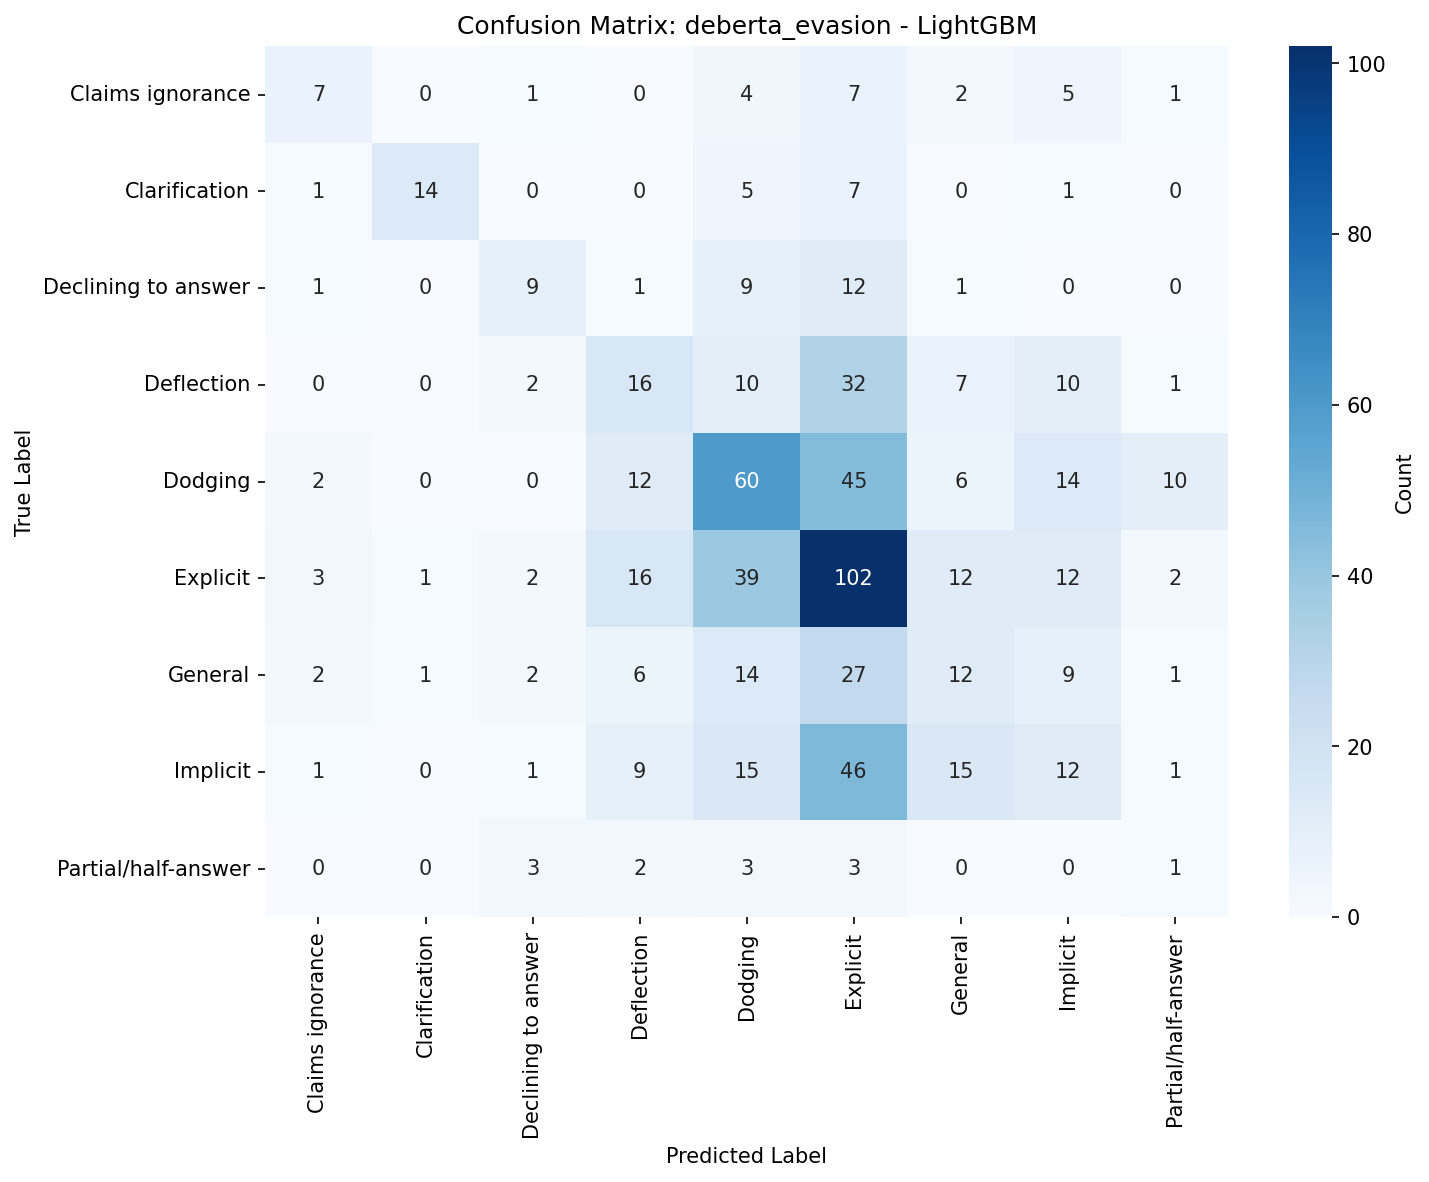


Results Table: xlnet_clarity
        Classifier          Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
           XGBoost xlnet_clarity  0.592754  0.506444     0.580160         0.547541      0.486599
      RandomForest xlnet_clarity  0.584058  0.504354     0.570461         0.542635      0.484959
          LightGBM xlnet_clarity  0.585507  0.488209     0.566101         0.538208      0.468104
         LinearSVC xlnet_clarity  0.566667  0.436758     0.535746         0.457682      0.442418
LogisticRegression xlnet_clarity  0.462319  0.430482     0.477270         0.427491      0.476223
               MLP xlnet_clarity  0.618841  0.391278     0.526291         0.664583      0.402625

Per-Class Metrics: xlnet_clarity - XGBoost (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.657505 0.753027  0.702032      413
Clear Non-Reply   0.574074 0.352273  0.436620       88
    Clear Reply   0.411043 0.354497  0.380682      189



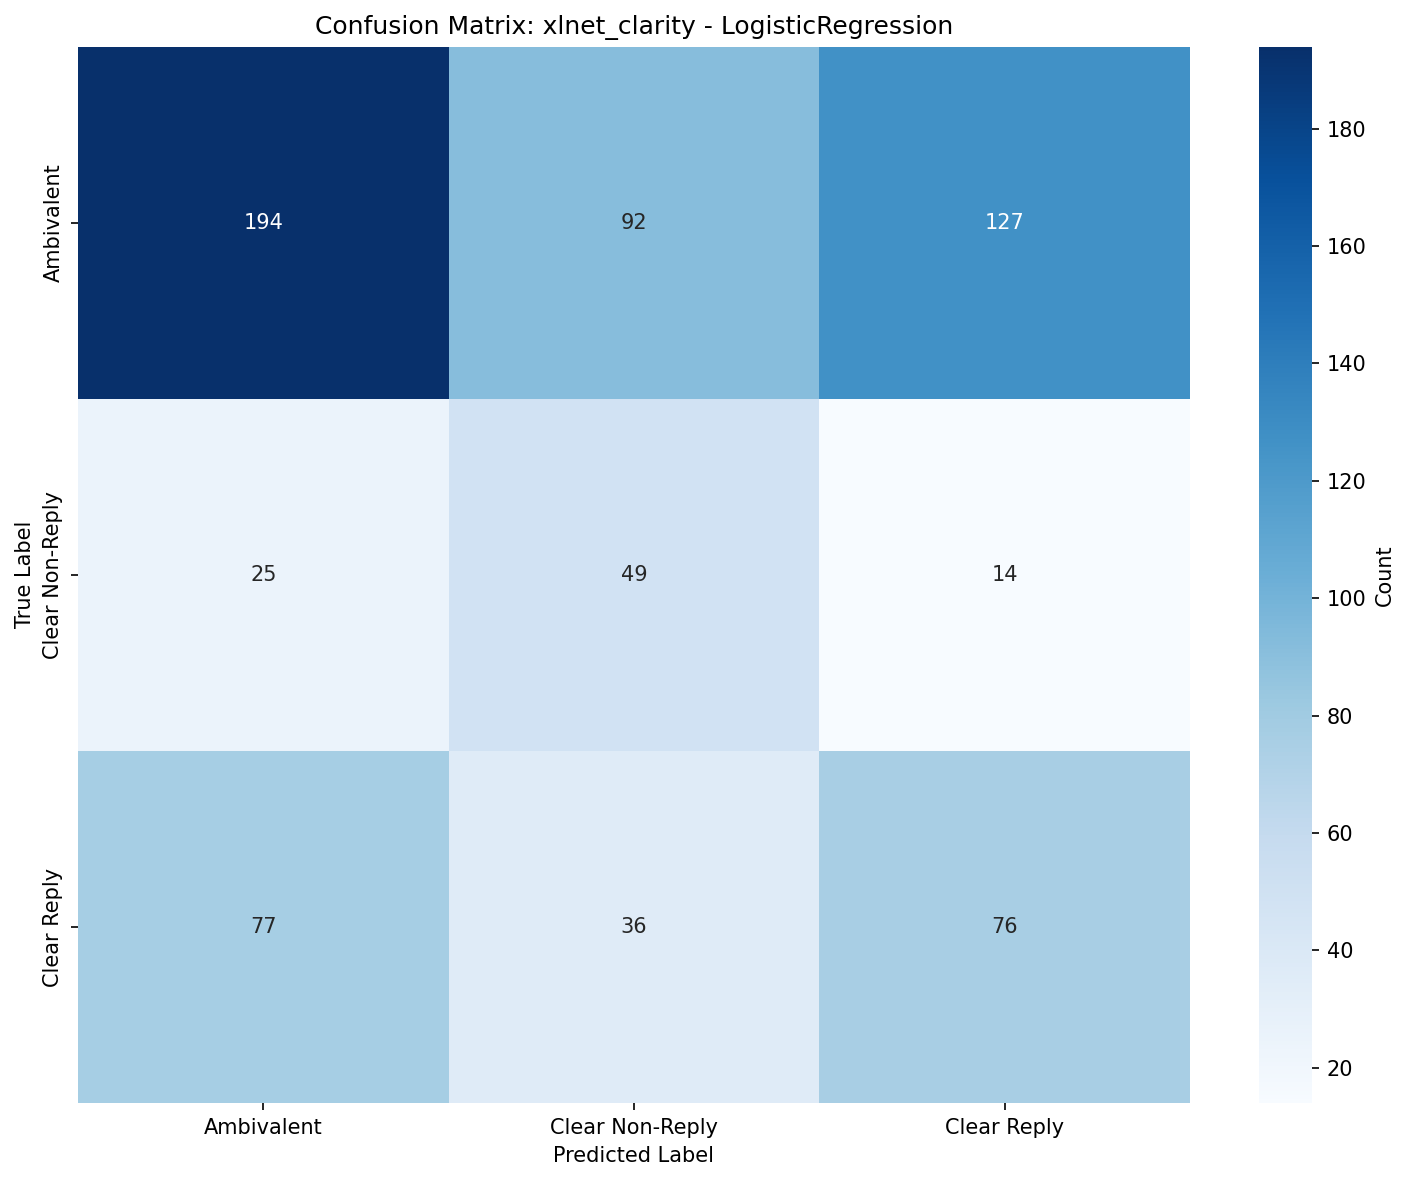

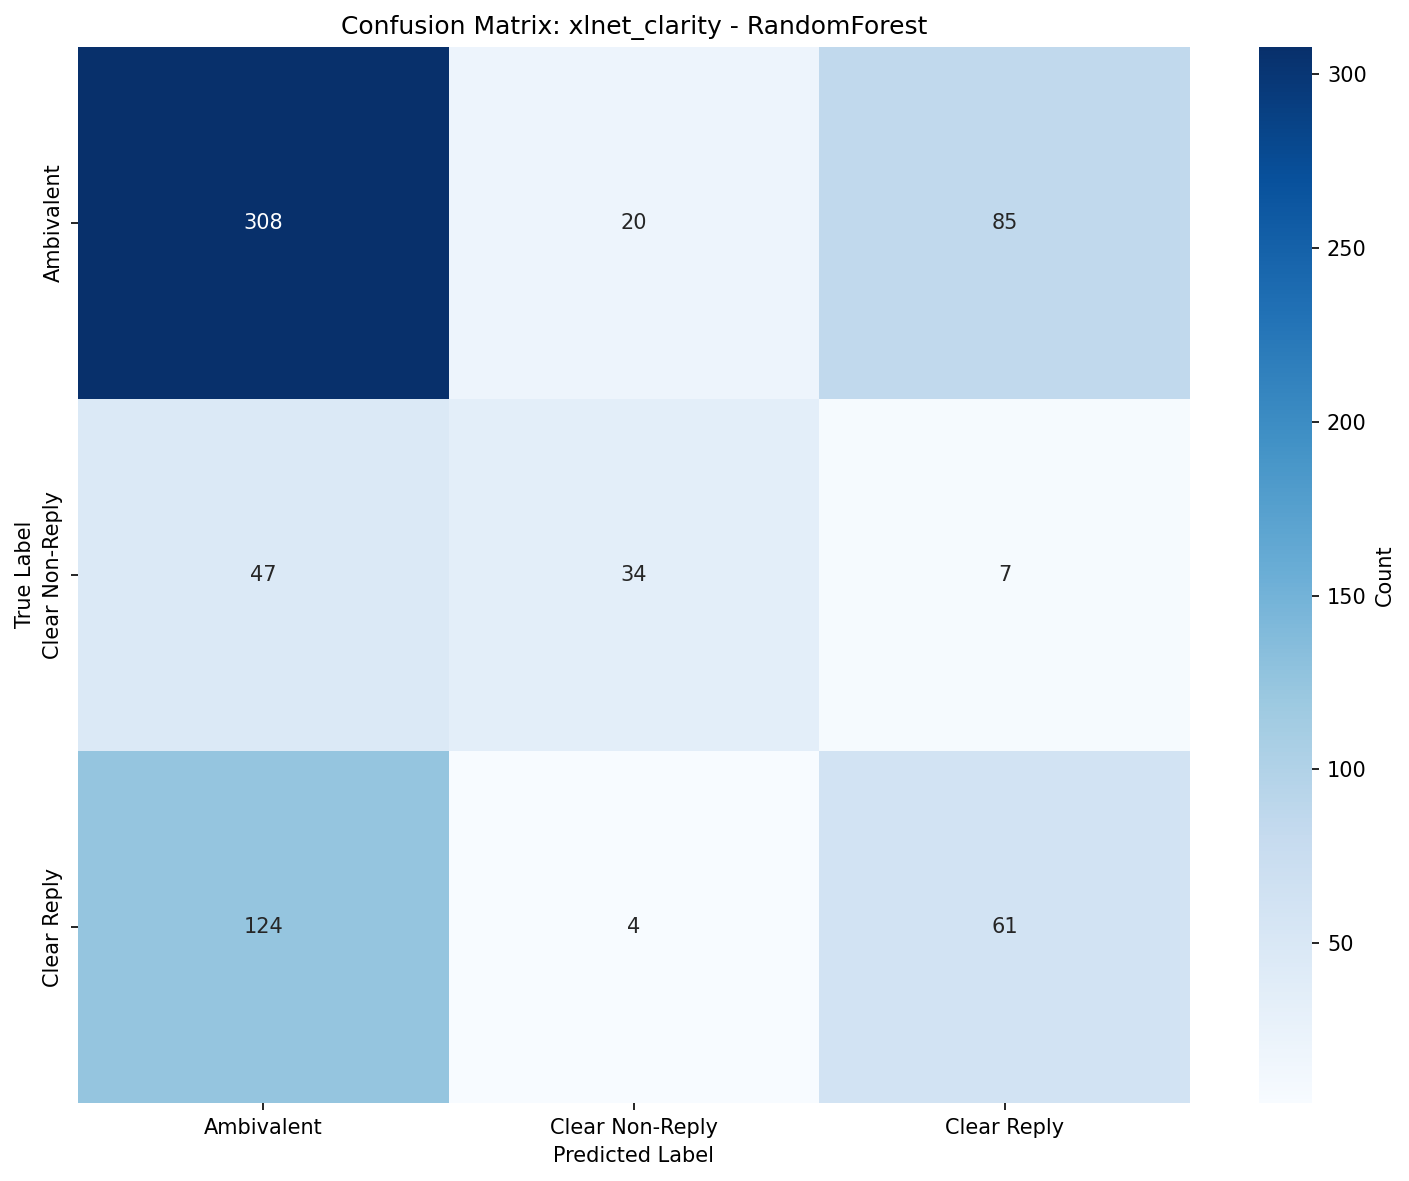

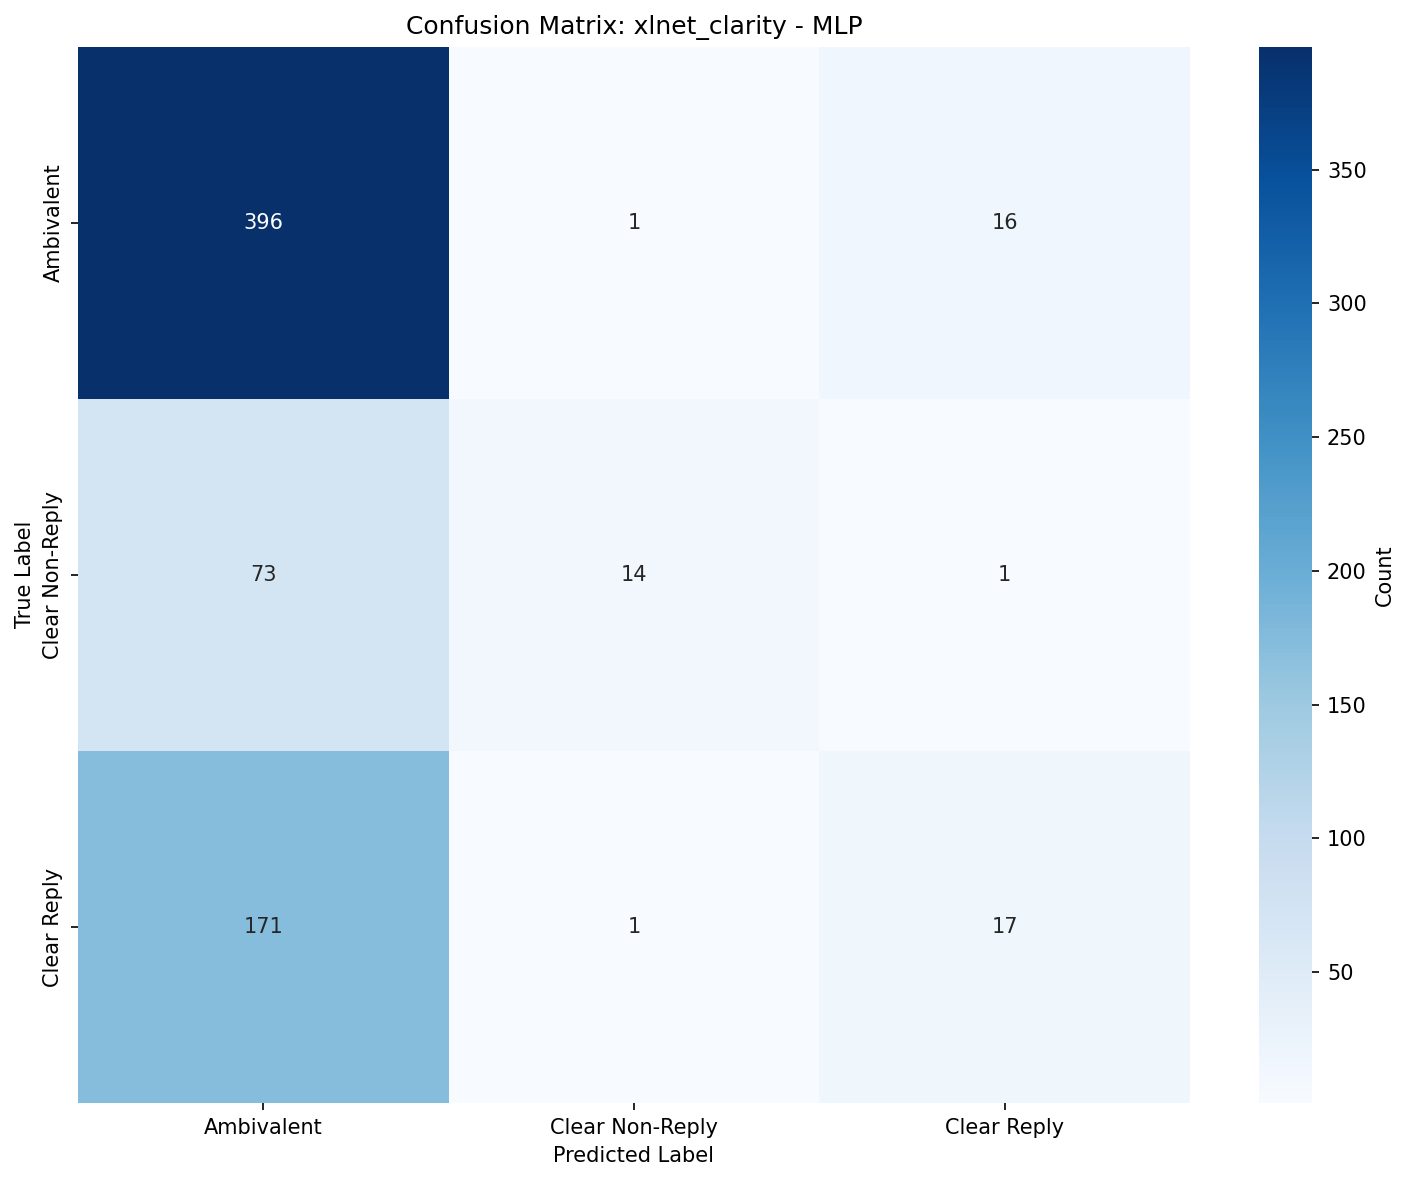

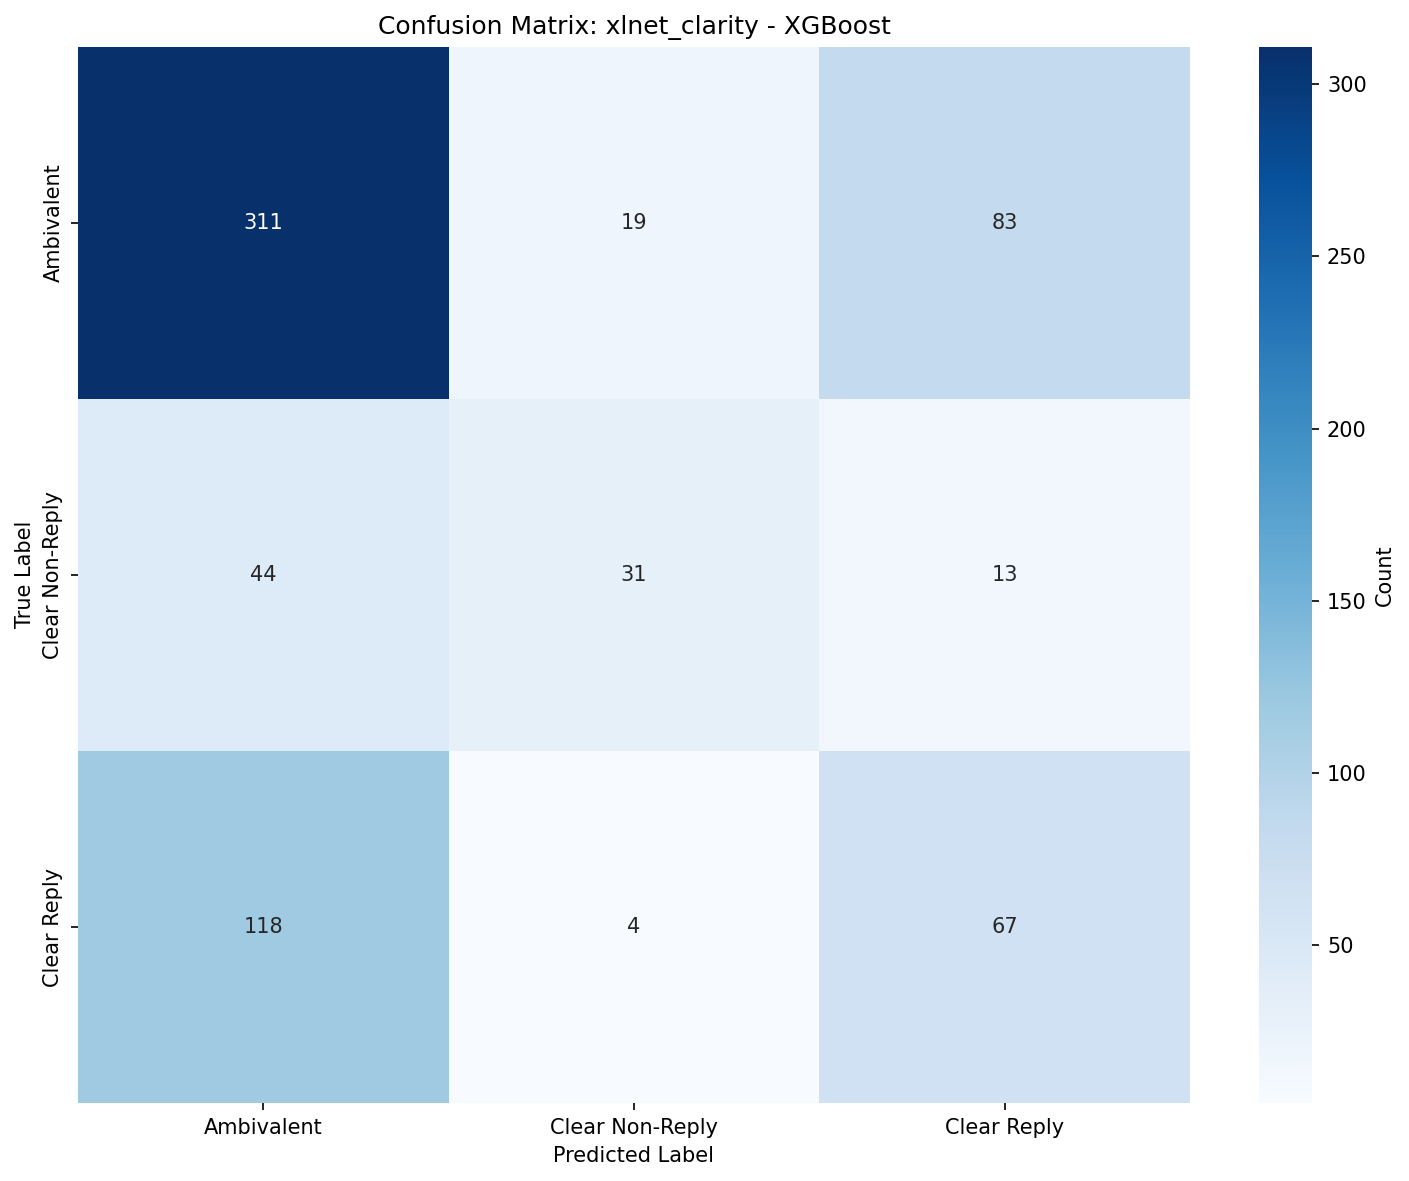

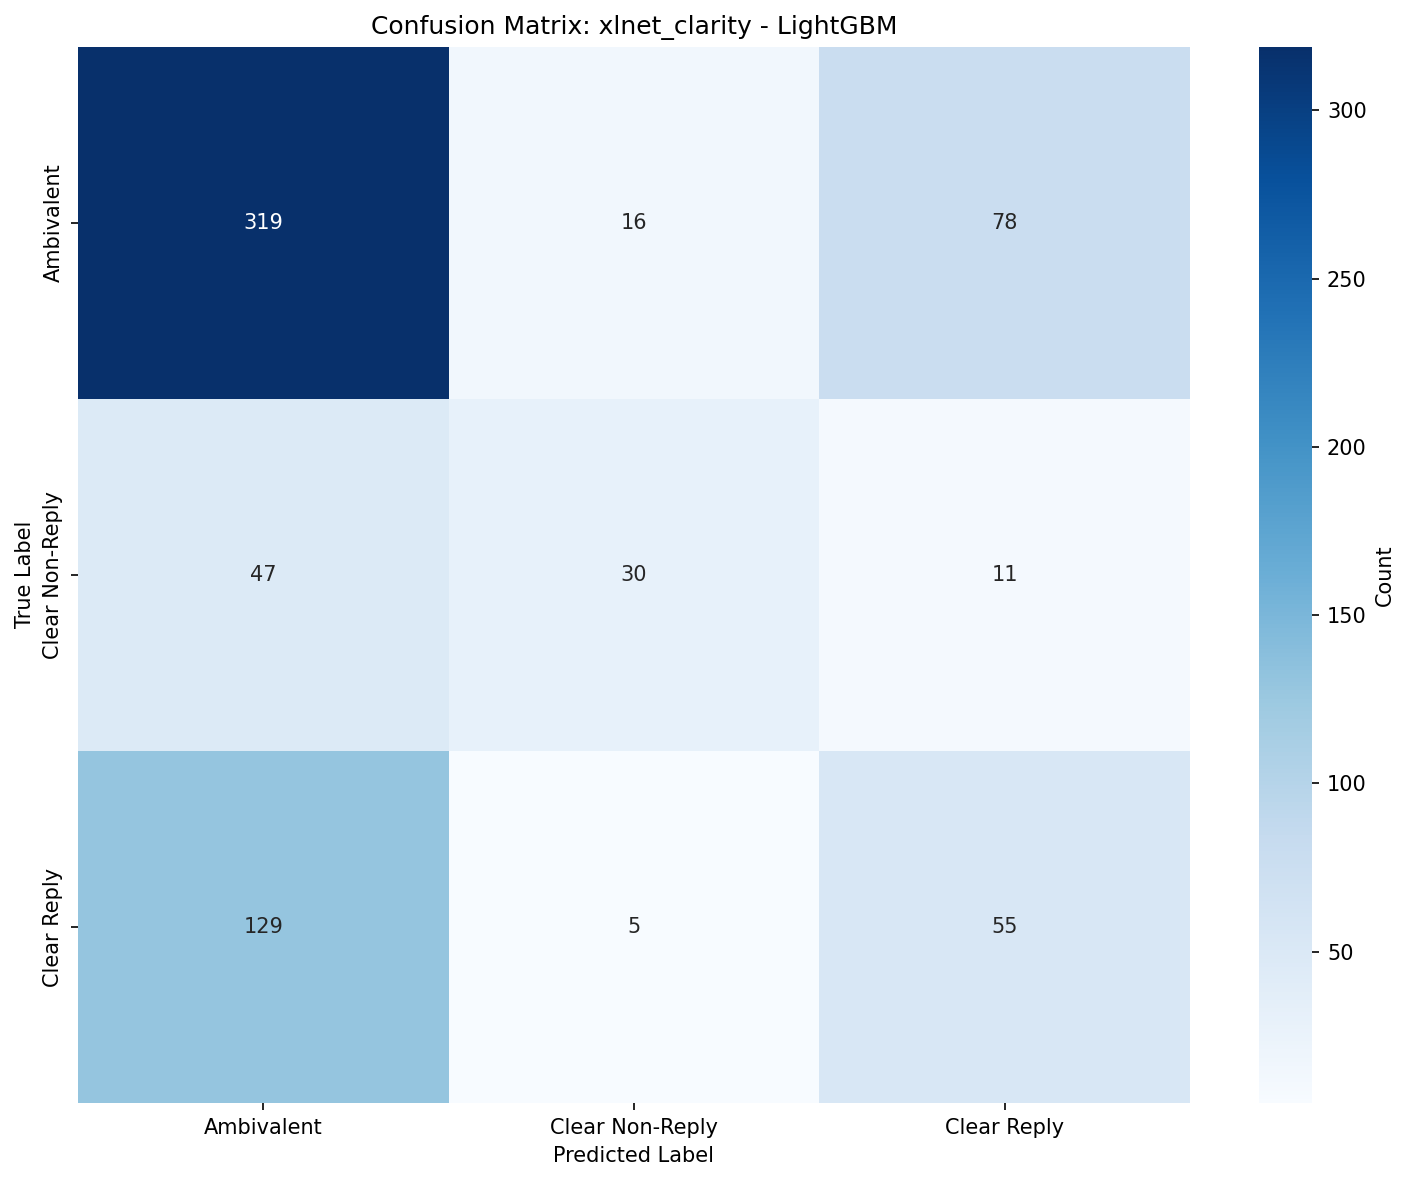


Results Table: xlnet_evasion
        Classifier          Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest xlnet_evasion  0.334783  0.306979     0.325364         0.350763      0.288282
           XGBoost xlnet_evasion  0.321739  0.299296     0.313584         0.359601      0.272785
          LightGBM xlnet_evasion  0.334783  0.296170     0.324241         0.351580      0.272211
         LinearSVC xlnet_evasion  0.231884  0.203173     0.232021         0.200428      0.256849
LogisticRegression xlnet_evasion  0.179710  0.181939     0.180233         0.206117      0.255565
               MLP xlnet_evasion  0.294203  0.153980     0.205481         0.187734      0.173758

Per-Class Metrics: xlnet_evasion - RandomForest (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.428571 0.222222  0.292683       27
      Clarification   0.761905 0.571429  0.653061       28
Declining to answer   0.476190 0.303030  0.370

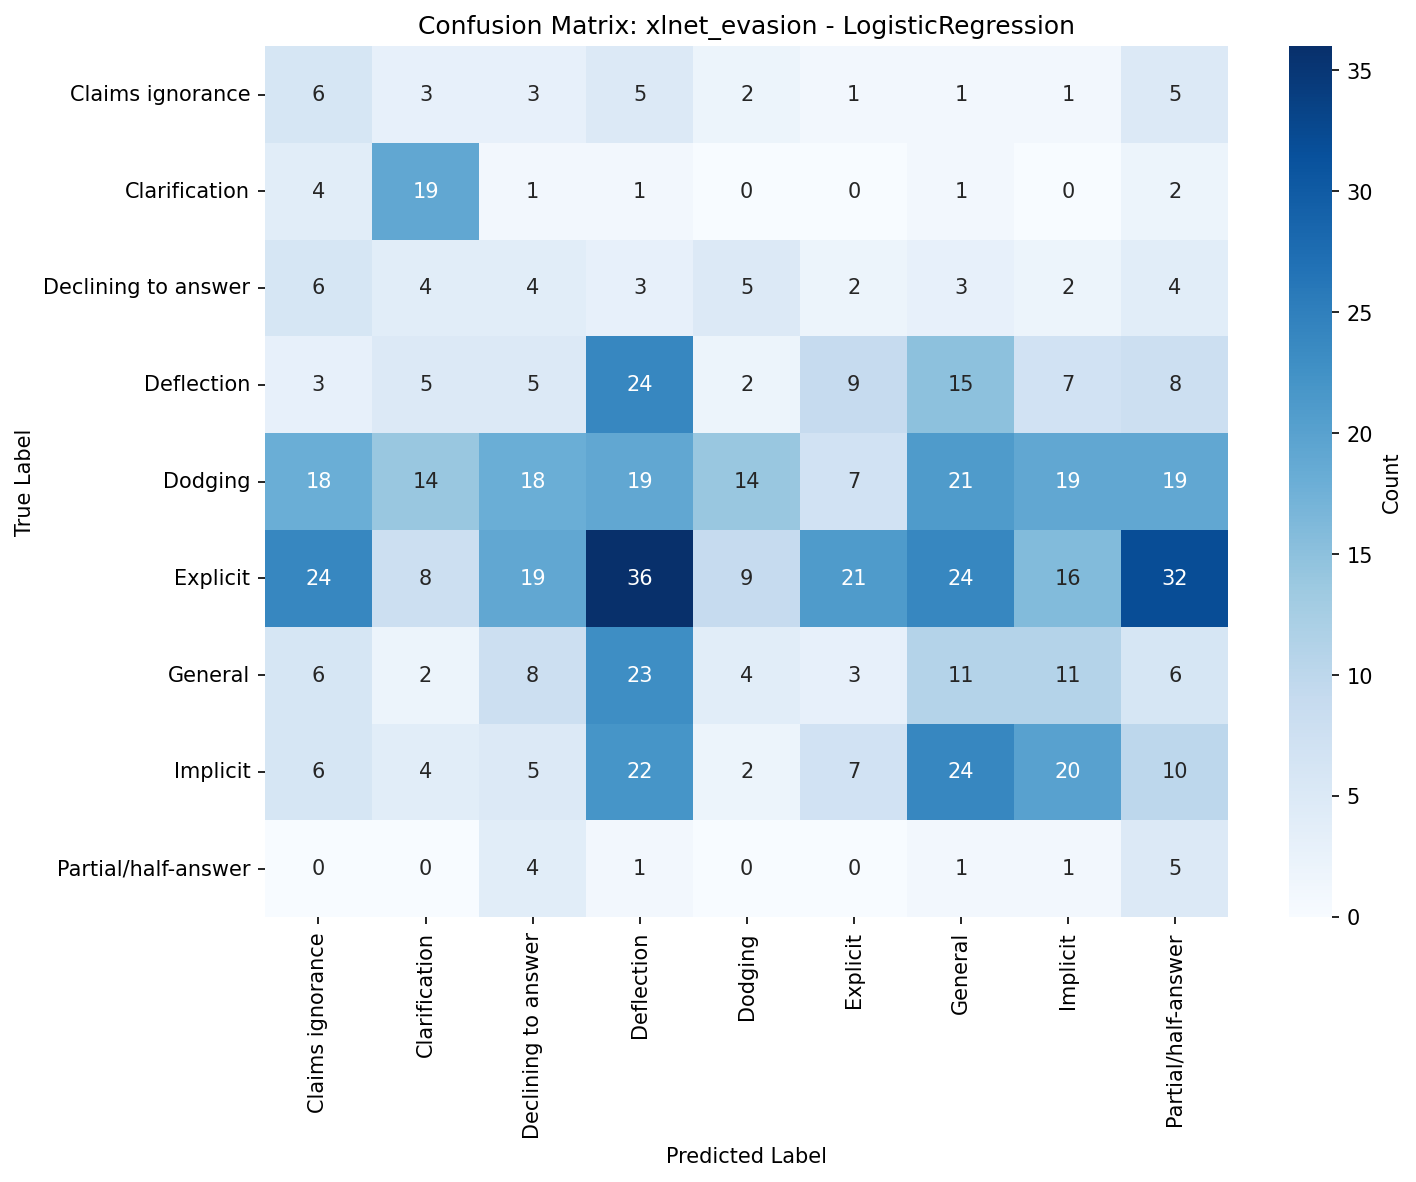

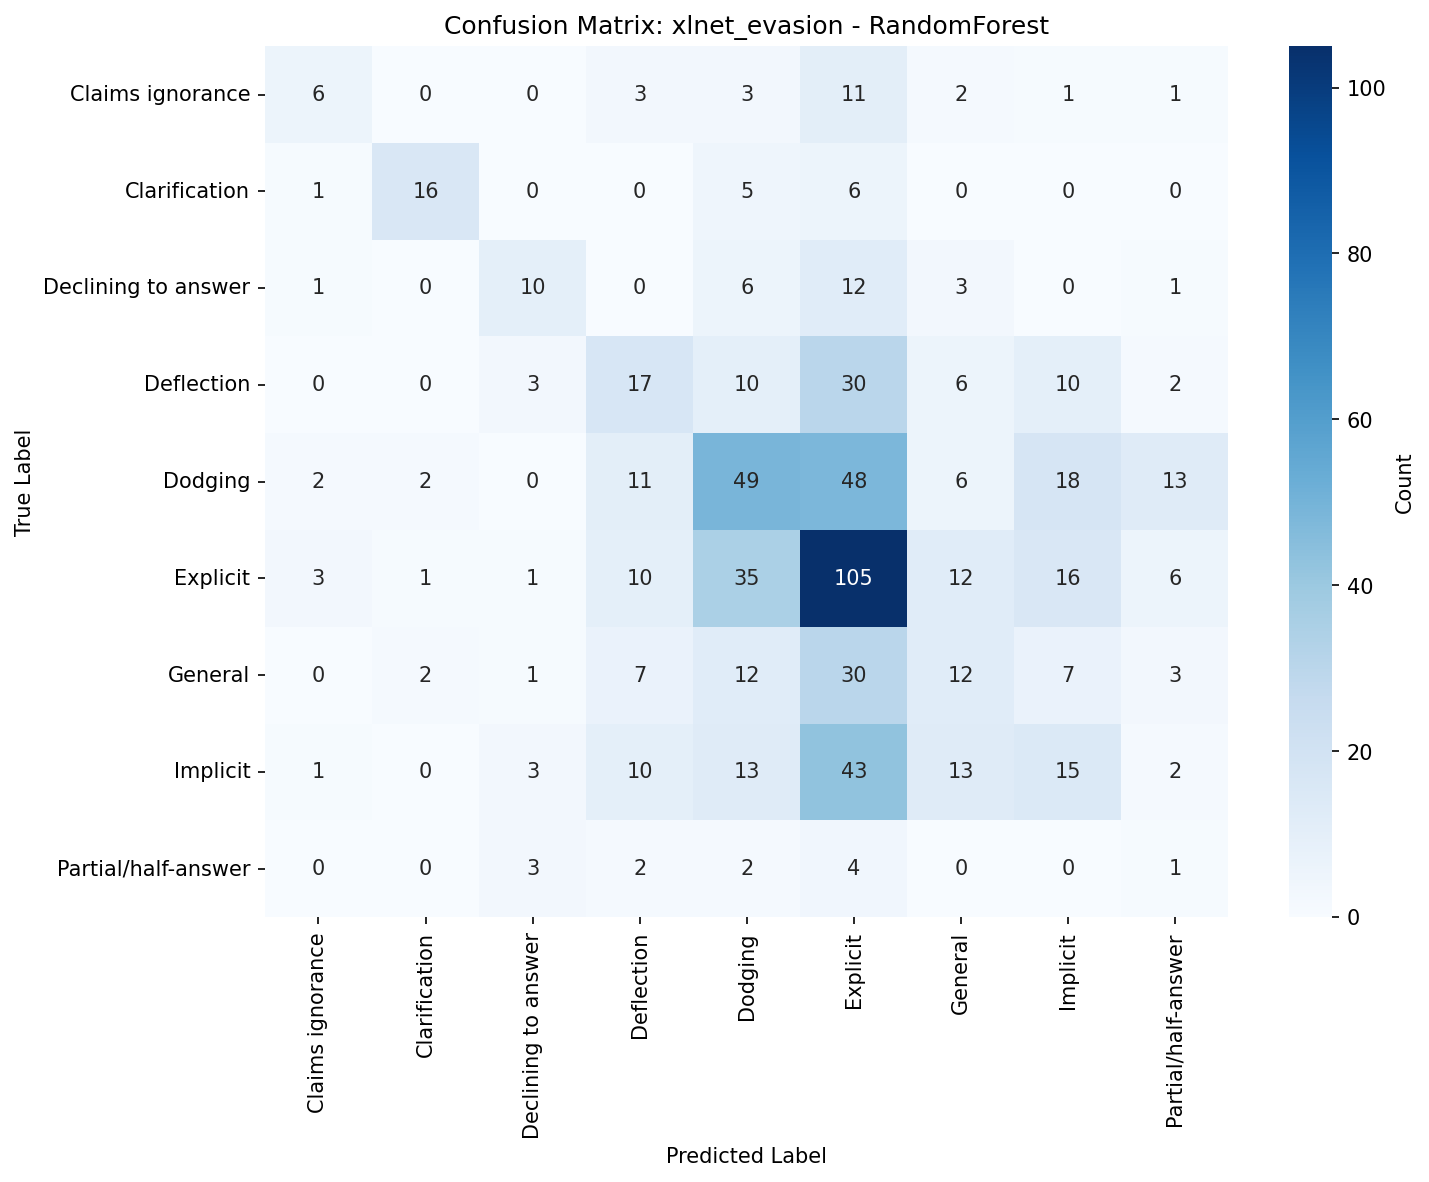

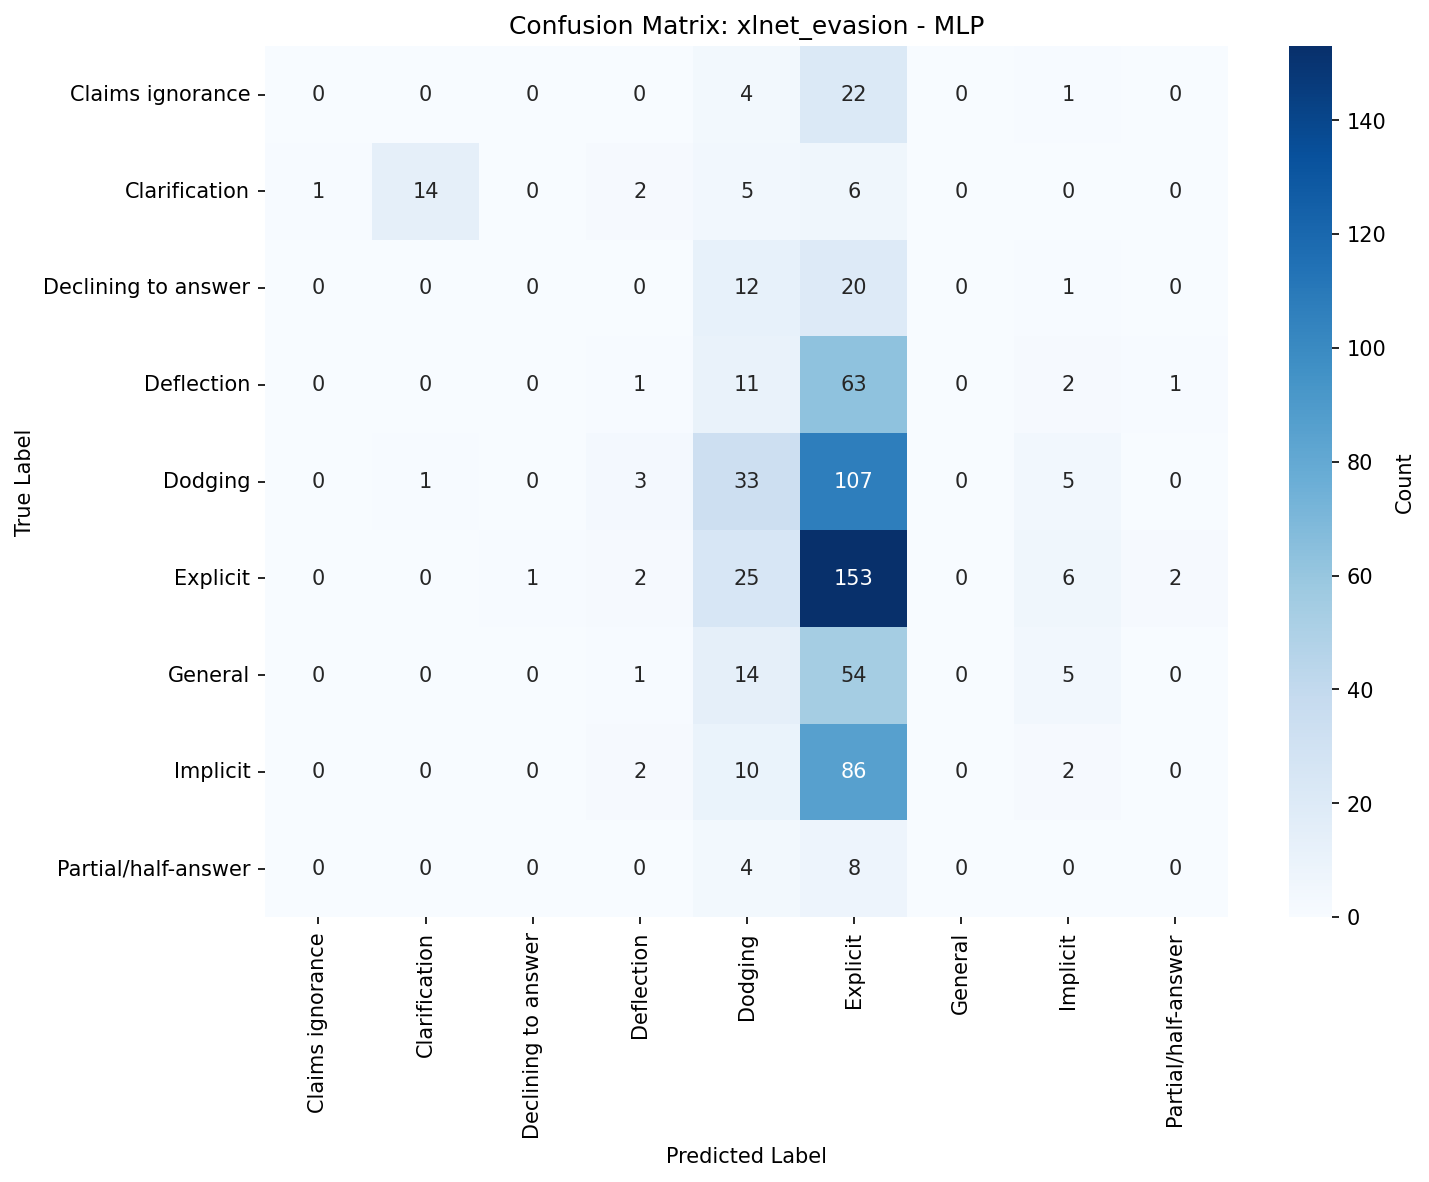

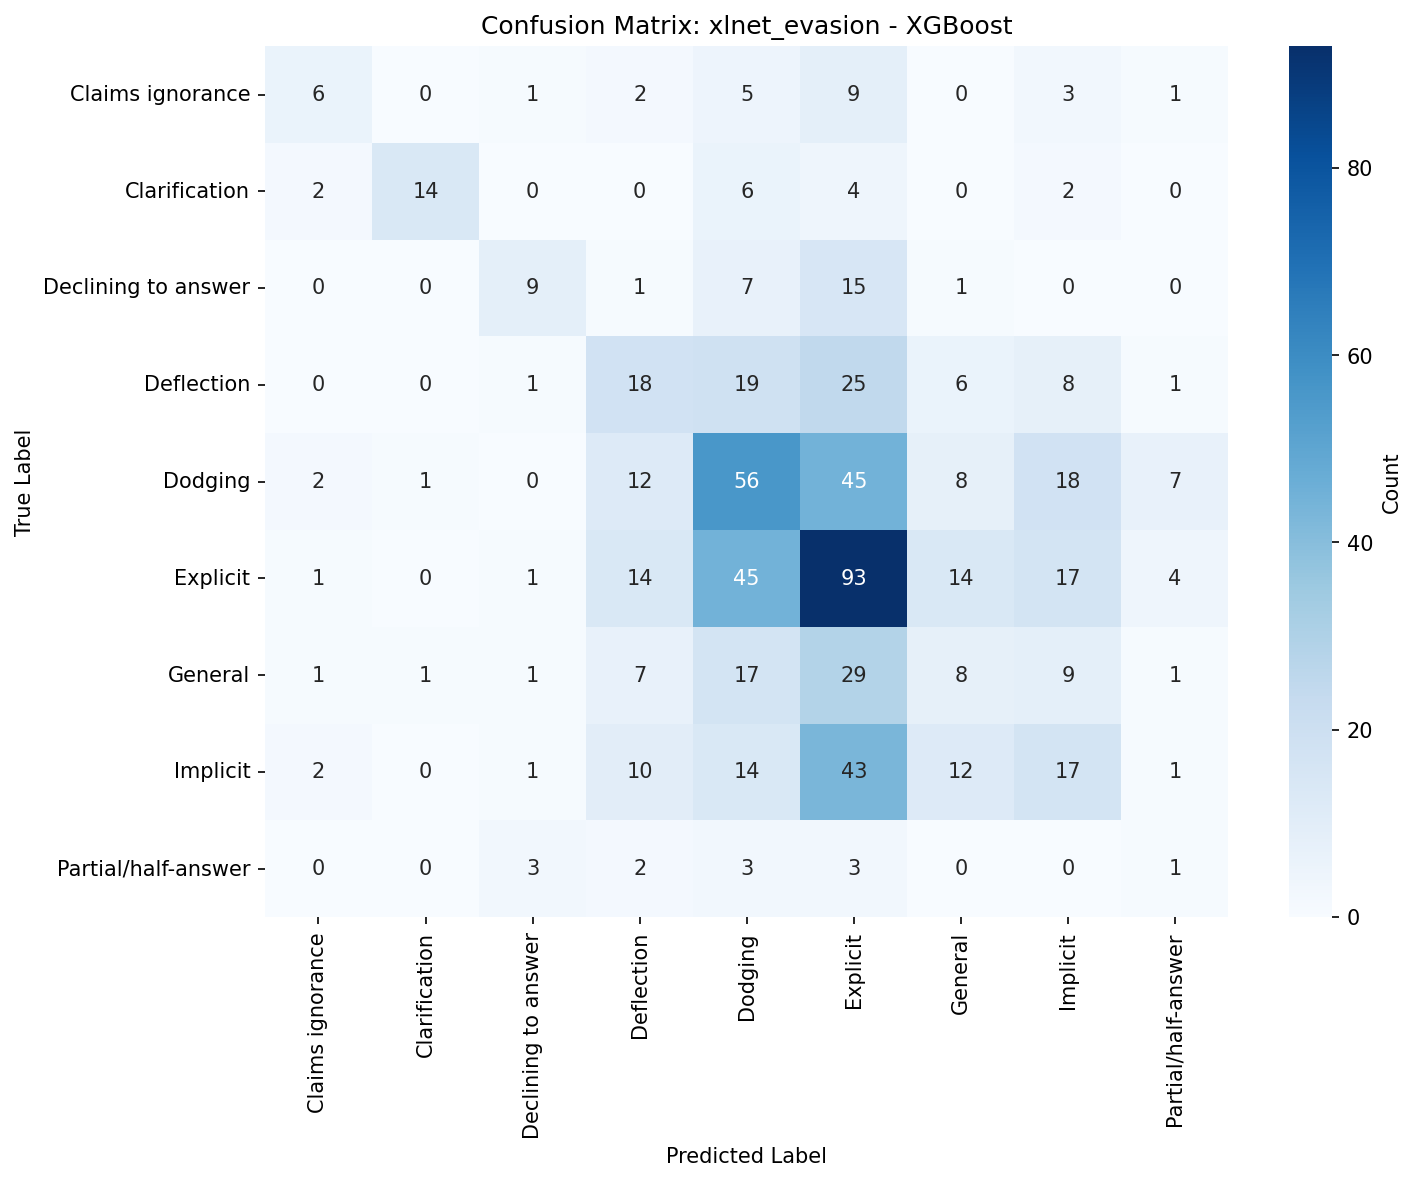

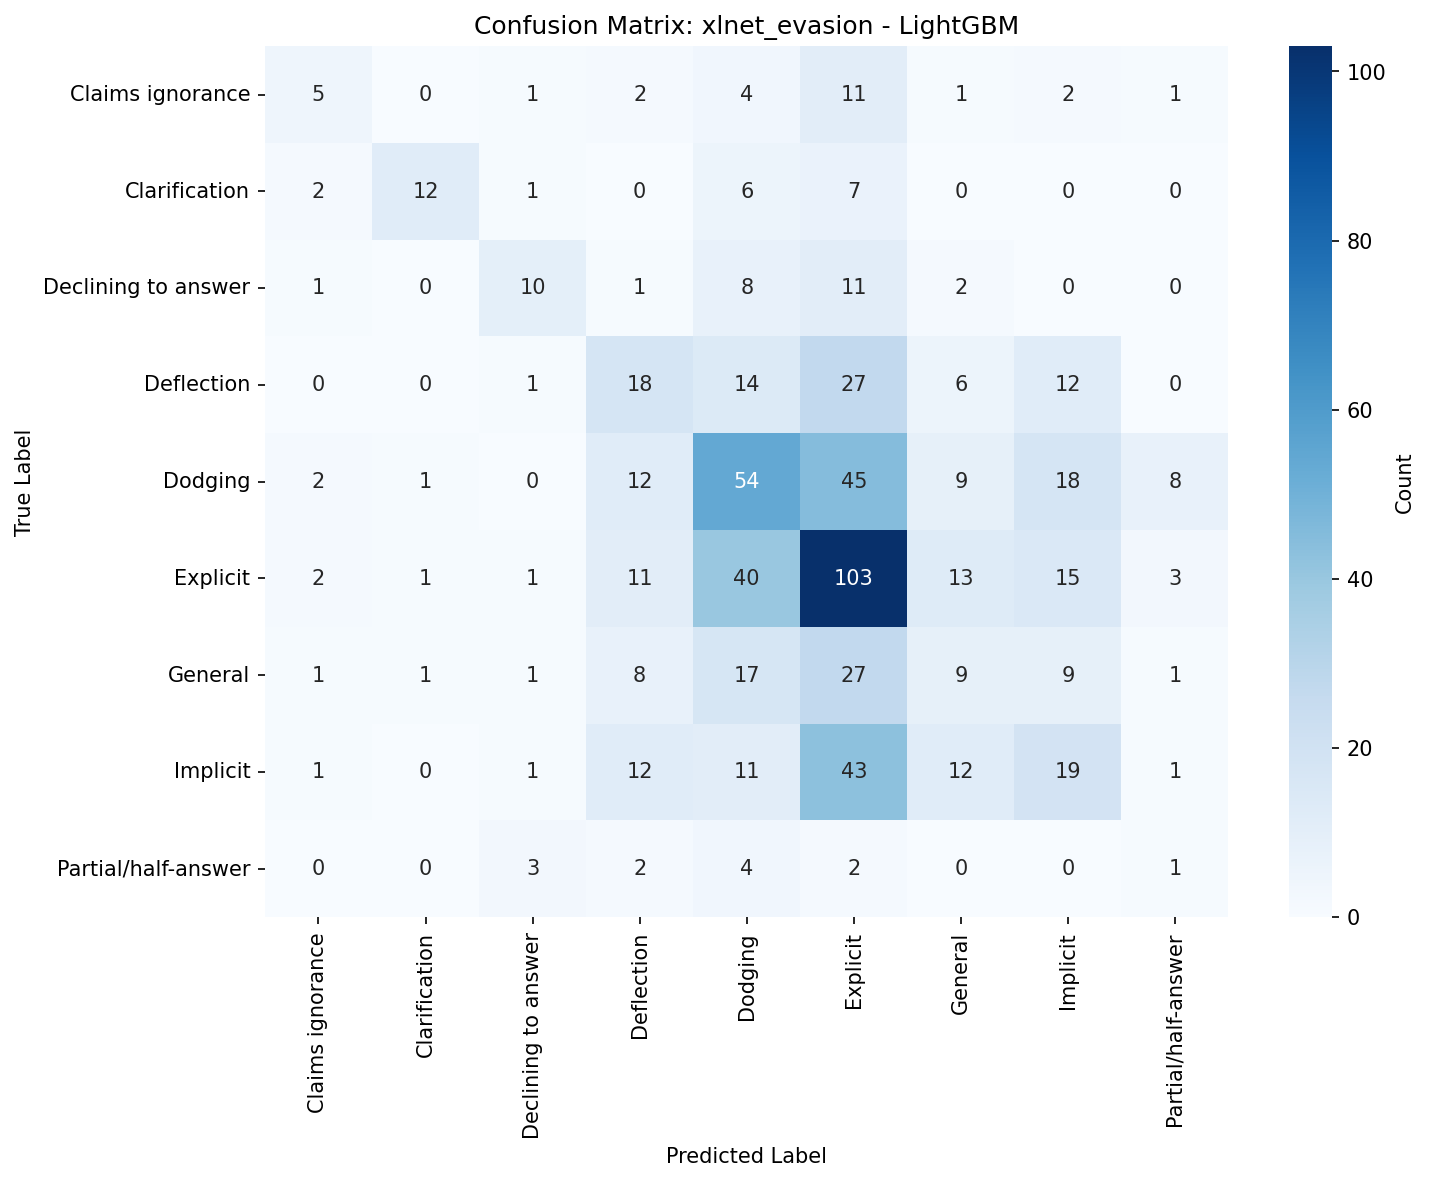

In [7]:
# ============================================================================
# TRAIN AND EVALUATE CLASSIFIERS FOR EACH MODEL AND TASK
# ============================================================================
# Iterates through each model and task, trains all classifiers, and evaluates
# on the Dev set. Results are saved for later analysis and final summary generation.

all_results = {}

for model in MODELS:
    all_results[model] = {}

    for task in TASKS:
        # Select appropriate label list and dataset key for this task
        if task == 'clarity':
            label_list = CLARITY_LABELS
            label_key = 'clarity_label'
        else:  # evasion
            label_list = EVASION_LABELS
            label_key = 'evasion_label'

        # Load task-specific splits (Clarity and Evasion have different splits)
        # Evasion splits are filtered by majority voting
        train_ds = storage.load_split('train', task=task)
        dev_ds = storage.load_split('dev', task=task)

        # Load features from persistent storage
        X_train = storage.load_features(model, task, 'train')
        X_dev = storage.load_features(model, task, 'dev')

        # Extract labels from dataset splits
        y_train = np.array([train_ds[i][label_key] for i in range(len(train_ds))])
        y_dev = np.array([dev_ds[i][label_key] for i in range(len(dev_ds))])

        # Train all classifiers and evaluate on Dev set
        # This function handles training, prediction, metric computation, and visualization
        results = train_and_evaluate(
            X_train, y_train, X_dev, y_dev,
            label_list=label_list,
            task_name=f"{model}_{task}",
            classifiers=classifiers,
            random_state=42,
            print_report=False,   # classification report YOK
            print_table=True,     # SADECE bu tablo VAR
            create_plots=True,    # hesapla + kaydet
            save_plots_dir=str(DATA_PATH / 'plots')
        )





        # Save predictions and probabilities to persistent storage
        # These will be used for further analysis and final summary generation
        for classifier_name, result in results.items():
            # Save hard label predictions
            storage.save_predictions(
                result['dev_pred'],
                model, classifier_name, task, 'dev'
            )

            # Save probability distributions (if classifier supports it)
            if result['dev_proba'] is not None:
                storage.save_probabilities(
                    result['dev_proba'],
                    model, classifier_name, task, 'dev'
                )

        all_results[model][task] = results

        # Save results summary to metadata for final summary generation
        experiment_id = f"{model}_{task}_separate"
        storage.save_results({
            'model': model,
            'task': task,
            'results': {
                name: {
                    'metrics': res['metrics'],
                    'n_train': len(y_train),
                    'n_dev': len(y_dev)
                }
                for name, res in results.items()
            }
        }, experiment_id)


<div style="font-size: 8px;">

# ============================================================================
# HIERARCHICAL EVASION → CLARITY APPROACH
# ============================================================================
# This cell implements the hierarchical approach where evasion predictions
# are mapped to clarity predictions using a predefined mapping function.
# This approach leverages the hierarchical relationship between evasion
# (fine-grained) and clarity (coarse-grained) labels.
#
# This is treated as a 3rd task alongside Clarity and Evasion:
# 1. Task 1: Clarity (direct classification)
# 2. Task 2: Evasion (direct classification)
# 3. Task 3: EvasionBasedClarity (mapping-based)
#
# All three tasks save predictions, probabilities, and results metadata
# to Drive and GitHub, just like the direct classification tasks.

</div>


In [8]:
# ============================================================================
# HIERARCHICAL EVALUATION: EVASION PREDICTIONS → CLARITY PREDICTIONS
# ============================================================================
# For each model, uses evasion predictions to generate clarity predictions
# via hierarchical mapping, then evaluates against true clarity labels
# This is treated as a 3rd task alongside Clarity and Evasion
#
# Saves predictions, probabilities, and results metadata just like other tasks

from src.models.hierarchical import evaluate_hierarchical_approach
from sklearn.preprocessing import LabelEncoder
import numpy as np

# CRITICAL: Load evasion dev split to get clarity labels for the SAME samples
# Evasion predictions are on evasion dev set, so we need clarity labels from the same samples
# Using clarity dev set would be wrong because it has different samples (unfiltered vs filtered)
dev_ds_evasion = storage.load_split('dev', task='evasion')

# Helper function to convert numpy types to JSON-serializable types
def make_json_serializable(obj):
    """Recursively convert numpy arrays and types to JSON-serializable Python types"""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, bool):
        return bool(obj)
    elif hasattr(np, 'bool_') and isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, dict):
        return {key: make_json_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [make_json_serializable(item) for item in obj]
    else:
        return obj

# Get true clarity labels from evasion dev set (same samples as evasion predictions)
y_clarity_true = np.array([dev_ds_evasion[i]['clarity_label'] for i in range(len(dev_ds_evasion))])

# Encode clarity labels for evaluation (hierarchical function expects encoded)
le_clarity = LabelEncoder()
y_clarity_true_encoded = le_clarity.fit_transform(y_clarity_true)

for model in MODELS:
    # Check if we have evasion predictions for this model
    if 'evasion' not in all_results.get(model, {}):
        continue

    # Get evasion predictions and true labels
    evasion_results = all_results[model]['evasion']

    # Initialize hierarchical results for this model
    if model not in all_results:
        all_results[model] = {}
    if 'evasion_based_clarity' not in all_results[model]:
        all_results[model]['evasion_based_clarity'] = {}

    # Evaluate hierarchical approach for EACH classifier (not just best)
    for clf_name, clf_result in evasion_results.items():
        # Skip if no predictions available
        if 'dev_pred' not in clf_result:
            continue

        # Get predictions (already string labels from train_classifiers)
        y_evasion_pred = clf_result['dev_pred']

        # Ensure predictions match clarity labels length
        if len(y_evasion_pred) != len(y_clarity_true_encoded):
            print(f"WARNING: Mismatch in prediction length for {model}-{clf_name}. Skipping hierarchical evaluation.")
            continue

        # Evaluate hierarchical approach
        # y_evasion_pred is already string labels, y_clarity_true_encoded is encoded
        # We pass dummy encoded evasion_true (not used in mapping, only for consistency)
        y_evasion_true_dummy = np.zeros(len(y_evasion_pred), dtype=int)  # Dummy, not used

        hierarchical_metrics = evaluate_hierarchical_approach(
            y_evasion_true_dummy,  # Not used in mapping, only for function signature
            y_evasion_pred,  # String labels - function will handle both string and int
            y_clarity_true_encoded,  # Encoded integers
            EVASION_LABELS,
            CLARITY_LABELS
        )

        # Store hierarchical results in same format as other tasks
        all_results[model]['evasion_based_clarity'][clf_name] = {
            'metrics': hierarchical_metrics,
            'dev_pred': hierarchical_metrics['predictions'],
            'dev_proba': None  # Hierarchical approach doesn't produce probabilities
        }

        # Save predictions to Drive (just like other tasks)
        storage.save_predictions(
            hierarchical_metrics['predictions'],
            model, clf_name, 'evasion_based_clarity', 'dev'
        )

        # Save results summary to metadata (just like other tasks)
        # Convert all numpy types in hierarchical_metrics to JSON-serializable types
        metrics_for_json = make_json_serializable(hierarchical_metrics)

        experiment_id = f"{model}_{clf_name}_evasion_based_clarity_separate"
        storage.save_results({
            'model': model,
            'task': 'evasion_based_clarity',
            'evasion_classifier': clf_name,
            'evasion_f1': float(clf_result.get('metrics', {}).get('macro_f1', 0.0)),  # Ensure float, not numpy float
            'results': {
                clf_name: {
                    'metrics': metrics_for_json,
                    'n_dev': int(len(y_clarity_true))  # Ensure int, not numpy int
                }
            }
        }, experiment_id)


<div style="font-size: 8px;">

TABULAROTARY ANALAYSIS

</div>

In [9]:
# ============================================================================
# FINAL SUMMARY GENERATION
# ============================================================================
# Generate summary tables and save all results
# Includes 2 tasks: Clarity and EvasionBasedClarity (mapping)
#
# Creates separate tables:
# 1. MODEL-WISE: For each model, shows Classifier × Tasks
# 2. CLASSIFIER-WISE: For each classifier, shows Model × Tasks
#
# Simple, clean tables: Only bold for column-wise max values

import pandas as pd
from IPython.display import display, HTML

# ----------------------------------------------------------------------------
# Helper function: bold max value in each column
# ----------------------------------------------------------------------------
def bold_max_in_column(col):
    is_max = col == col.max()
    return ['font-weight: bold' if v else '' for v in is_max]

# ----------------------------------------------------------------------------
# Save all_results dictionary to persistent storage
# ----------------------------------------------------------------------------
storage.save_all_results_dict(all_results, filename='all_results_dev.pkl')

# ----------------------------------------------------------------------------
# Extract classifier names from results
# ----------------------------------------------------------------------------
classifier_names = set()
all_tasks = ['clarity', 'evasion_based_clarity']

for model in MODELS:
    if model in all_results:
        for task in all_tasks:
            if task in all_results[model]:
                classifier_names.update(all_results[model][task].keys())

classifier_names = sorted(list(classifier_names))

# ============================================================================
# CREATE SUMMARY DATAFRAME
# ============================================================================
summary_rows = []

for model in MODELS:
    if model not in all_results:
        continue

    for classifier in classifier_names:
        for task in all_tasks:
            if task not in all_results[model]:
                continue
            if classifier not in all_results[model][task]:
                continue

            result = all_results[model][task][classifier]
            if 'metrics' in result:
                metrics = result['metrics']
                summary_rows.append({
                    'model': model,
                    'classifier': classifier,
                    'task': task,
                    'macro_f1': metrics.get('macro_f1', 0.0),
                    'weighted_f1': metrics.get('weighted_f1', 0.0),
                    'accuracy': metrics.get('accuracy', 0.0)
                })

# ============================================================================
# BUILD & DISPLAY TABLES
# ============================================================================
if not summary_rows:
    print("WARNING: No results available for summary tables")

else:
    df_summary = pd.DataFrame(summary_rows)

    # Remove duplicates (safety)
    df_summary = df_summary.drop_duplicates(
        subset=['model', 'classifier', 'task'],
        keep='first'
    )

    # ========================================================================
    # MODEL-WISE TABLES: Classifier × Tasks
    # ========================================================================
    print("=" * 100)
    print("FINAL SUMMARY — MODEL-WISE (Classifier × Tasks)")
    print("=" * 100)

    for model_name in sorted(df_summary['model'].unique()):
        display(HTML(f"MODEL: {model_name.upper()}"))

        df_model = df_summary[df_summary['model'] == model_name]

        df_model = df_model.drop_duplicates(
            subset=['classifier', 'task'],
            keep='first'
        )

        try:
            pivot_model = df_model.pivot(
                index='classifier',
                columns='task',
                values='macro_f1'
            )

            styled_model = (
                pivot_model
                .style
                .format(precision=4)
                .apply(bold_max_in_column, axis=0)
            )

            display(styled_model)

            table_name_model = f"model_wise_{model_name}"
            storage.save_table(
                styled_model,
                table_name=table_name_model,
                formats=['csv', 'html']
            )

        except Exception as e:
            print(f" Error creating table for {model_name}: {e}")

    # ========================================================================
    # CLASSIFIER-WISE TABLES: Model × Tasks
    # ========================================================================
    print("\n" + "=" * 100)
    print("FINAL SUMMARY — CLASSIFIER-WISE (Model × Tasks)")
    print("=" * 100)

    for clf_name in sorted(df_summary['classifier'].unique()):
        display(HTML(f"CLASSIFIER: {clf_name.upper()}"))

        df_clf = df_summary[df_summary['classifier'] == clf_name]

        df_clf = df_clf.drop_duplicates(
            subset=['model', 'task'],
            keep='first'
        )

        try:
            pivot_clf = df_clf.pivot(
                index='model',
                columns='task',
                values='macro_f1'
            )

            styled_clf = (
                pivot_clf
                .style
                .format(precision=4)
                .apply(bold_max_in_column, axis=0)
            )

            display(styled_clf)

            table_name_clf = f"classifier_wise_{clf_name}"
            storage.save_table(
                styled_clf,
                table_name=table_name_clf,
                formats=['csv', 'html']
            )

        except Exception as e:
            print(f" Error creating table for {clf_name}: {e}")


FINAL SUMMARY — MODEL-WISE (Classifier × Tasks)


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/model_wise_bert.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/model_wise_bert.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/model_wise_bert_ambiguity.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/model_wise_bert_ambiguity.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/model_wise_bert_political.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/model_wise_bert_political.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/model_wise_deberta.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/model_wise_deberta.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/model_wise_roberta.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/model_wise_roberta.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/model_wise_xlnet.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/model_wise_xlnet.html

FINAL SUMMARY — CLASSIFIER-WISE (Model × Tasks)


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_LightGBM.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_LightGBM.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_LinearSVC.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_LinearSVC.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_LogisticRegression.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_LogisticRegression.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_MLP.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_MLP.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_RandomForest.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_RandomForest.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_XGBoost.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_XGBoost.html


In [10]:
# ============================================================================
# CELL 1: MODEL-INDEPENDENT TEST FEATURE EXTRACTION
# ============================================================================
# Extracts model-independent features for test set and saves to Drive

from datasets import load_dataset
from transformers import pipeline
from src.features.extraction import featurize_model_independent_features
import numpy as np
import torch

# Load test set from HuggingFace
print("="*80)
print("CELL 1: MODEL-INDEPENDENT TEST FEATURE EXTRACTION")
print("="*80)
print("Loading test set from HuggingFace...")
test_ds_hf = load_dataset('ailsntua/QEvasion')['test']
print(f"✓ Test set loaded: {len(test_ds_hf)} samples")

# Load sentiment pipeline
print("\nLoading sentiment analysis pipeline...")
try:
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-roberta-base-sentiment-latest",
        device=0 if torch.cuda.is_available() else -1,
        return_all_scores=True
    )
    print("  ✓ Sentiment pipeline loaded")
except Exception as e:
    print(f"   Could not load sentiment pipeline: {e}")
    sentiment_pipeline = None

metadata_keys = {
    'inaudible': 'inaudible',
    'multiple_questions': 'multiple_questions',
    'affirmative_questions': 'affirmative_questions'
}

# Extract and save model-independent features for each task
TASKS = ['clarity', 'evasion']

print("\n" + "="*80)
print("DRIVE SAVE LOCATIONS:")
print("="*80)

for task in TASKS:
    print(f"\n{'-'*60}")
    print(f"Task: {task.upper()}")
    print(f"{'-'*60}")

    # Define save path
    model_indep_path = storage.data_path / f'features/raw/X_test_independent_{task}.npy'

    print(f"  Save location: {model_indep_path}")

    if model_indep_path.exists():
        X_test_indep = np.load(model_indep_path)
        print(f"  ✓ Already exists in Drive")
        print(f"  ✓ Shape: {X_test_indep.shape}")
        print(f"  ✓ Skipping extraction...")
    else:
        # Extract model-independent features
        print(f"  → Extracting model-independent features...")
        X_test_indep, feature_names_indep = featurize_model_independent_features(
            test_ds_hf,
            question_key='interview_question',
            answer_key='interview_answer',
            batch_size=32,
            show_progress=True,
            sentiment_pipeline=sentiment_pipeline,
            metadata_keys=metadata_keys
        )

        # Save to Drive
        np.save(model_indep_path, X_test_indep)
        print(f"  ✓ SAVED TO DRIVE: {model_indep_path}")
        print(f"  ✓ Shape: {X_test_indep.shape}")
        print(f"  ✓ Features: {len(feature_names_indep)} model-independent features")

print(f"\n{'='*80}")
print("CELL 1 COMPLETE: Model-independent features saved to Drive")
print(f"{'='*80}")
print("\nSUMMARY OF SAVED FILES:")
print("="*80)
for task in TASKS:
    model_indep_path = storage.data_path / f'features/raw/X_test_independent_{task}.npy'
    if model_indep_path.exists():
        print(f"  ✓ {model_indep_path}")
    else:
        print(f"  ✗ {model_indep_path} (NOT SAVED)")
print("="*80)

CELL 1: MODEL-INDEPENDENT TEST FEATURE EXTRACTION
Loading test set from HuggingFace...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.90M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3448 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/308 [00:00<?, ? examples/s]

✓ Test set loaded: 308 samples

Loading sentiment analysis pipeline...


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  ✓ Sentiment pipeline loaded

DRIVE SAVE LOCATIONS:

------------------------------------------------------------
Task: CLARITY
------------------------------------------------------------
  Save location: /content/drive/MyDrive/semeval_data/features/raw/X_test_independent_clarity.npy
  → Extracting model-independent features...



Extracting model-independent features:   0%|          | 0/10 [00:00<?, ?it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

Extracting model-independent features: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


  ✓ SAVED TO DRIVE: /content/drive/MyDrive/semeval_data/features/raw/X_test_independent_clarity.npy
  ✓ Shape: (308, 18)
  ✓ Features: 18 model-independent features

------------------------------------------------------------
Task: EVASION
------------------------------------------------------------
  Save location: /content/drive/MyDrive/semeval_data/features/raw/X_test_independent_evasion.npy
  → Extracting model-independent features...


Extracting model-independent features: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s]

  ✓ SAVED TO DRIVE: /content/drive/MyDrive/semeval_data/features/raw/X_test_independent_evasion.npy
  ✓ Shape: (308, 18)
  ✓ Features: 18 model-independent features

CELL 1 COMPLETE: Model-independent features saved to Drive

SUMMARY OF SAVED FILES:
  ✓ /content/drive/MyDrive/semeval_data/features/raw/X_test_independent_clarity.npy
  ✓ /content/drive/MyDrive/semeval_data/features/raw/X_test_independent_evasion.npy


In [4]:
# ============================================================================
# CELL 2: MODEL-DEPENDENT TEST FEATURE EXTRACTION
# ============================================================================
# Loads model-independent features from Drive
# Extracts model-dependent features for each model and saves to Drive

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch
from src.features.extraction import featurize_hf_dataset_in_batches_v2
import numpy as np

# Load test set from HuggingFace
print("="*80)
print("CELL 2: MODEL-DEPENDENT TEST FEATURE EXTRACTION")
print("="*80)
print("Loading test set from HuggingFace...")
test_ds_hf = load_dataset('ailsntua/QEvasion')['test']
print(f"✓ Test set loaded: {len(test_ds_hf)} samples")

# Load model-independent features from Drive (NOT from RAM)
print("\nLoading model-independent features from Drive...")
test_model_independent_features = {}
for task in TASKS:
    model_indep_path = storage.data_path / f'features/raw/X_test_independent_{task}.npy'
    if model_indep_path.exists():
        X_test_indep = np.load(model_indep_path)
        test_model_independent_features[task] = X_test_indep
        print(f"  ✓ {task}: Loaded from Drive - {model_indep_path}")
        print(f"    Shape: {X_test_indep.shape}")
    else:
        print(f"  ✗ {task}: Model-independent features not found in Drive!")
        print(f"     Path: {model_indep_path}")
        print(f"     Run CELL 1 first!")
        raise FileNotFoundError(f"Model-independent features not found: {model_indep_path}")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Device: {device}")

# Model configurations
MODEL_CONFIGS = {
    'bert': 'bert-base-uncased',
    'bert_political': 'bucketresearch/politicalBiasBERT',
    'bert_ambiguity': 'Slomb/Ambig_Question',
    'roberta': 'roberta-base',
    'deberta': 'microsoft/deberta-v3-base',
    'xlnet': 'xlnet-base-cased'
}

MODEL_MAX_LENGTHS = {
    'bert': 512,
    'bert_political': 512,
    'bert_ambiguity': 512,
    'roberta': 512,
    'deberta': 512,
    'xlnet': 1024
}

# Store saved paths
saved_paths = []

# Process each model
for model_key in MODELS:
    print(f"\n{'='*80}")
    print(f"MODEL: {model_key.upper()}")
    print(f"{'='*80}")

    # Clear GPU cache
    if torch.cuda.is_available():
        try:
            torch.cuda.synchronize()
            torch.cuda.empty_cache()
        except:
            pass

    # Load model and tokenizer
    model_name = MODEL_CONFIGS.get(model_key, f'{model_key}-base-uncased')
    print(f"Loading model: {model_name}")

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        try:
            model = AutoModel.from_pretrained(model_name)
            print(f"  ✓ Loaded as base model")
        except:
            # Try to extract base encoder from classification model
            classification_model = AutoModelForSequenceClassification.from_pretrained(model_name)
            if hasattr(classification_model, 'base_model'):
                model = classification_model.base_model
            elif hasattr(classification_model, 'model'):
                model = classification_model.model
            elif hasattr(classification_model, 'bert'):
                model = classification_model.bert
            elif hasattr(classification_model, 'distilbert'):
                model = classification_model.distilbert
            else:
                raise ValueError(f"Could not extract base encoder from {model_name}")
            del classification_model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            print(f"  ✓ Extracted base encoder from classification model")

        model.to(device)
        model.eval()
    except Exception as e:
        print(f"✗ Error loading model {model_name}: {e}")
        continue

    max_seq_len = MODEL_MAX_LENGTHS.get(model_key, 512)

    # Process each task
    for task in TASKS:
        print(f"\n{'-'*60}")
        print(f"Task: {task.upper()}")
        print(f"{'-'*60}")

        # Define save path
        test_feature_path = storage.data_path / f'features/raw/X_test_{model_key}_{task}.npy'
        print(f"  Save location: {test_feature_path}")

        # Check if test features already exist
        if test_feature_path.exists():
            X_test = np.load(test_feature_path)
            print(f"  ✓ Already exists in Drive")
            print(f"  ✓ Shape: {X_test.shape}")
            saved_paths.append(str(test_feature_path))
        else:
            # Extract test features (efficiency mode - uses model-independent from Drive)
            print(f"  → Extracting test features (efficiency mode)...")
            print(f"    Using model-independent features from Drive")

            X_test, feature_names, _ = featurize_hf_dataset_in_batches_v2(
                test_ds_hf,
                tokenizer,
                model,
                device,
                batch_size=8,
                max_sequence_length=max_seq_len,
                question_key='interview_question',
                answer_key='interview_answer',
                show_progress=True,
                model_independent_features=test_model_independent_features[task]  # From Drive
            )

            # Save to Drive (features/raw/)
            storage.save_features(X_test, model_key, task, 'test', feature_names)
            print(f"  ✓ SAVED TO DRIVE: {test_feature_path}")
            print(f"  ✓ Shape: {X_test.shape}")
            print(f"  ✓ Features: {len(feature_names)} total features (7 model-dependent + 18 model-independent)")
            saved_paths.append(str(test_feature_path))

    # Free GPU memory
    del model, tokenizer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\n{'='*80}")
print("CELL 2 COMPLETE: Model-dependent features saved to Drive")
print(f"{'='*80}")
print("\nSUMMARY OF SAVED FILES:")
print("="*80)
for path in saved_paths:
    print(f"  ✓ {path}")
print("="*80)

CELL 2: MODEL-DEPENDENT TEST FEATURE EXTRACTION
Loading test set from HuggingFace...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.90M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3448 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/308 [00:00<?, ? examples/s]

✓ Test set loaded: 308 samples

Loading model-independent features from Drive...
  ✓ clarity: Loaded from Drive - /content/drive/MyDrive/semeval_data/features/raw/X_test_independent_clarity.npy
    Shape: (308, 18)
  ✓ evasion: Loaded from Drive - /content/drive/MyDrive/semeval_data/features/raw/X_test_independent_evasion.npy
    Shape: (308, 18)

✓ Device: cuda

MODEL: BERT
Loading model: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

  ✓ Loaded as base model

------------------------------------------------------------
Task: CLARITY
------------------------------------------------------------
  Save location: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_clarity.npy
  → Extracting test features (efficiency mode)...
    Using model-independent features from Drive


Extracting model-dependent features: 100%|██████████| 39/39 [00:03<00:00, 10.77it/s]


Saved features: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_clarity.npy
Saved metadata: /content/semeval-context-tree-modular/metadata/features_test_bert_clarity.json
  ✓ SAVED TO DRIVE: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_clarity.npy
  ✓ Shape: (308, 25)
  ✓ Features: 25 total features (7 model-dependent + 18 model-independent)

------------------------------------------------------------
Task: EVASION
------------------------------------------------------------
  Save location: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_evasion.npy
  → Extracting test features (efficiency mode)...
    Using model-independent features from Drive


Extracting model-dependent features: 100%|██████████| 39/39 [00:02<00:00, 13.63it/s]


Saved features: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_evasion.npy
Saved metadata: /content/semeval-context-tree-modular/metadata/features_test_bert_evasion.json
  ✓ SAVED TO DRIVE: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_evasion.npy
  ✓ Shape: (308, 25)
  ✓ Features: 25 total features (7 model-dependent + 18 model-independent)

MODEL: BERT_POLITICAL
Loading model: bucketresearch/politicalBiasBERT


config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

  ✓ Loaded as base model

------------------------------------------------------------
Task: CLARITY
------------------------------------------------------------
  Save location: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_political_clarity.npy
  → Extracting test features (efficiency mode)...
    Using model-independent features from Drive


Extracting model-dependent features: 100%|██████████| 39/39 [00:02<00:00, 13.02it/s]


Saved features: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_political_clarity.npy
Saved metadata: /content/semeval-context-tree-modular/metadata/features_test_bert_political_clarity.json
  ✓ SAVED TO DRIVE: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_political_clarity.npy
  ✓ Shape: (308, 25)
  ✓ Features: 25 total features (7 model-dependent + 18 model-independent)

------------------------------------------------------------
Task: EVASION
------------------------------------------------------------
  Save location: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_political_evasion.npy
  → Extracting test features (efficiency mode)...
    Using model-independent features from Drive


Extracting model-dependent features: 100%|██████████| 39/39 [00:02<00:00, 13.42it/s]


Saved features: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_political_evasion.npy
Saved metadata: /content/semeval-context-tree-modular/metadata/features_test_bert_political_evasion.json
  ✓ SAVED TO DRIVE: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_political_evasion.npy
  ✓ Shape: (308, 25)
  ✓ Features: 25 total features (7 model-dependent + 18 model-independent)

MODEL: BERT_AMBIGUITY
Loading model: Slomb/Ambig_Question


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  ✓ Loaded as base model

------------------------------------------------------------
Task: CLARITY
------------------------------------------------------------
  Save location: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_ambiguity_clarity.npy
  → Extracting test features (efficiency mode)...
    Using model-independent features from Drive


Extracting model-dependent features: 100%|██████████| 39/39 [00:01<00:00, 21.33it/s]


Saved features: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_ambiguity_clarity.npy
Saved metadata: /content/semeval-context-tree-modular/metadata/features_test_bert_ambiguity_clarity.json
  ✓ SAVED TO DRIVE: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_ambiguity_clarity.npy
  ✓ Shape: (308, 25)
  ✓ Features: 25 total features (7 model-dependent + 18 model-independent)

------------------------------------------------------------
Task: EVASION
------------------------------------------------------------
  Save location: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_ambiguity_evasion.npy
  → Extracting test features (efficiency mode)...
    Using model-independent features from Drive


Extracting model-dependent features: 100%|██████████| 39/39 [00:01<00:00, 23.30it/s]


Saved features: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_ambiguity_evasion.npy
Saved metadata: /content/semeval-context-tree-modular/metadata/features_test_bert_ambiguity_evasion.json
  ✓ SAVED TO DRIVE: /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_ambiguity_evasion.npy
  ✓ Shape: (308, 25)
  ✓ Features: 25 total features (7 model-dependent + 18 model-independent)

MODEL: ROBERTA
Loading model: roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  ✓ Loaded as base model

------------------------------------------------------------
Task: CLARITY
------------------------------------------------------------
  Save location: /content/drive/MyDrive/semeval_data/features/raw/X_test_roberta_clarity.npy
  → Extracting test features (efficiency mode)...
    Using model-independent features from Drive


Extracting model-dependent features: 100%|██████████| 39/39 [00:02<00:00, 13.81it/s]


Saved features: /content/drive/MyDrive/semeval_data/features/raw/X_test_roberta_clarity.npy
Saved metadata: /content/semeval-context-tree-modular/metadata/features_test_roberta_clarity.json
  ✓ SAVED TO DRIVE: /content/drive/MyDrive/semeval_data/features/raw/X_test_roberta_clarity.npy
  ✓ Shape: (308, 25)
  ✓ Features: 25 total features (7 model-dependent + 18 model-independent)

------------------------------------------------------------
Task: EVASION
------------------------------------------------------------
  Save location: /content/drive/MyDrive/semeval_data/features/raw/X_test_roberta_evasion.npy
  → Extracting test features (efficiency mode)...
    Using model-independent features from Drive


Extracting model-dependent features: 100%|██████████| 39/39 [00:02<00:00, 13.98it/s]


Saved features: /content/drive/MyDrive/semeval_data/features/raw/X_test_roberta_evasion.npy
Saved metadata: /content/semeval-context-tree-modular/metadata/features_test_roberta_evasion.json
  ✓ SAVED TO DRIVE: /content/drive/MyDrive/semeval_data/features/raw/X_test_roberta_evasion.npy
  ✓ Shape: (308, 25)
  ✓ Features: 25 total features (7 model-dependent + 18 model-independent)

MODEL: DEBERTA
Loading model: microsoft/deberta-v3-base


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

  ✓ Loaded as base model

------------------------------------------------------------
Task: CLARITY
------------------------------------------------------------
  Save location: /content/drive/MyDrive/semeval_data/features/raw/X_test_deberta_clarity.npy
  → Extracting test features (efficiency mode)...
    Using model-independent features from Drive


Extracting model-dependent features:  10%|█         | 4/39 [00:00<00:06,  5.51it/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Extracting model-dependent features: 100%|██████████| 39/39 [00:04<00:00,  9.28it/s]


Saved features: /content/drive/MyDrive/semeval_data/features/raw/X_test_deberta_clarity.npy
Saved metadata: /content/semeval-context-tree-modular/metadata/features_test_deberta_clarity.json
  ✓ SAVED TO DRIVE: /content/drive/MyDrive/semeval_data/features/raw/X_test_deberta_clarity.npy
  ✓ Shape: (308, 25)
  ✓ Features: 25 total features (7 model-dependent + 18 model-independent)

------------------------------------------------------------
Task: EVASION
------------------------------------------------------------
  Save location: /content/drive/MyDrive/semeval_data/features/raw/X_test_deberta_evasion.npy
  → Extracting test features (efficiency mode)...
    Using model-independent features from Drive


Extracting model-dependent features: 100%|██████████| 39/39 [00:03<00:00, 10.63it/s]


Saved features: /content/drive/MyDrive/semeval_data/features/raw/X_test_deberta_evasion.npy
Saved metadata: /content/semeval-context-tree-modular/metadata/features_test_deberta_evasion.json
  ✓ SAVED TO DRIVE: /content/drive/MyDrive/semeval_data/features/raw/X_test_deberta_evasion.npy
  ✓ Shape: (308, 25)
  ✓ Features: 25 total features (7 model-dependent + 18 model-independent)

MODEL: XLNET
Loading model: xlnet-base-cased


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

  ✓ Loaded as base model

------------------------------------------------------------
Task: CLARITY
------------------------------------------------------------
  Save location: /content/drive/MyDrive/semeval_data/features/raw/X_test_xlnet_clarity.npy
  → Extracting test features (efficiency mode)...
    Using model-independent features from Drive


Extracting model-dependent features:  18%|█▊        | 7/39 [00:01<00:08,  3.96it/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Extracting model-dependent features: 100%|██████████| 39/39 [00:08<00:00,  4.42it/s]


Saved features: /content/drive/MyDrive/semeval_data/features/raw/X_test_xlnet_clarity.npy
Saved metadata: /content/semeval-context-tree-modular/metadata/features_test_xlnet_clarity.json
  ✓ SAVED TO DRIVE: /content/drive/MyDrive/semeval_data/features/raw/X_test_xlnet_clarity.npy
  ✓ Shape: (308, 25)
  ✓ Features: 25 total features (7 model-dependent + 18 model-independent)

------------------------------------------------------------
Task: EVASION
------------------------------------------------------------
  Save location: /content/drive/MyDrive/semeval_data/features/raw/X_test_xlnet_evasion.npy
  → Extracting test features (efficiency mode)...
    Using model-independent features from Drive


Extracting model-dependent features: 100%|██████████| 39/39 [00:08<00:00,  4.46it/s]

Saved features: /content/drive/MyDrive/semeval_data/features/raw/X_test_xlnet_evasion.npy
Saved metadata: /content/semeval-context-tree-modular/metadata/features_test_xlnet_evasion.json
  ✓ SAVED TO DRIVE: /content/drive/MyDrive/semeval_data/features/raw/X_test_xlnet_evasion.npy
  ✓ Shape: (308, 25)
  ✓ Features: 25 total features (7 model-dependent + 18 model-independent)

CELL 2 COMPLETE: Model-dependent features saved to Drive

SUMMARY OF SAVED FILES:
  ✓ /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_clarity.npy
  ✓ /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_evasion.npy
  ✓ /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_political_clarity.npy
  ✓ /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_political_evasion.npy
  ✓ /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_ambiguity_clarity.npy
  ✓ /content/drive/MyDrive/semeval_data/features/raw/X_test_bert_ambiguity_evasion.npy
  ✓ /content/drive/MyDrive/semeval_data

In [12]:
# ============================================================================
# CELL 3: TRAIN CLASSIFIERS ON TRAIN+DEV SET (CLARITY ONLY)
# ============================================================================
# Trains all classifiers on train+dev combined set for CLARITY task only
# Ready for test set evaluation

from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle
import joblib
from pathlib import Path

print("="*80)
print("CELL 3: TRAINING CLASSIFIERS (CLARITY TASK ONLY)")
print("="*80)
print("NOTE: Classifiers will be trained on TRAIN+DEV combined set")
print("      Only CLARITY task will be trained")
print("      Train and Dev features are loaded from Drive")
print("      Test set evaluation will be done in CELL 4")
print("="*80)

# ============================================================================
# CREATE CHECKPOINT DIRECTORIES (CLARITY ONLY)
# ============================================================================
checkpoint_base = storage.data_path / 'checkpoints' / 'Clarity'
checkpoint_base.mkdir(parents=True, exist_ok=True)
print(f"✓ Created base checkpoint directory: {checkpoint_base}")

# Create subdirectories for each type of checkpoint
checkpoint_dirs = {
    'classifiers': checkpoint_base / 'trained_classifiers',
    'label_encoders': checkpoint_base / 'label_encoders',
    'combined_features': checkpoint_base / 'train_dev_combined_features',
    'combined_labels': checkpoint_base / 'train_dev_combined_labels'
}

for dir_name, dir_path in checkpoint_dirs.items():
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created checkpoint directory: {dir_path}")

print(f"\n{'='*80}")
print("CHECKPOINT DIRECTORIES CREATED (CLARITY ONLY)")
print("="*80)
print(f"Base directory: {checkpoint_base}")
for dir_name, dir_path in checkpoint_dirs.items():
    print(f"  {dir_name}: {dir_path}")

# Store trained classifiers (will be used in CELL 4)
trained_classifiers = {}

# Store combined data for saving
combined_data = {}

# Define task (CLARITY ONLY)
task = 'clarity'
label_list = CLARITY_LABELS
label_key = 'clarity_label'

print("\n" + "="*80)
print("LOADING TRAIN+DEV FEATURES FROM DRIVE (CLARITY ONLY):")
print("="*80)
print(f"Task: {task.upper()}")
print(f"Expected label list: {label_list}")
print(f"Label key to extract: '{label_key}'")

for model_key in MODELS:
    print(f"\n{'-'*60}")
    print(f"MODEL: {model_key.upper()}")
    print(f"{'-'*60}")

    trained_classifiers[model_key] = {}
    combined_data[model_key] = {}

    # Load train features and labels
    train_feature_path = storage.data_path / f'features/raw/X_train_{model_key}_{task}.npy'
    print(f"  Loading train features from Drive: {train_feature_path}")
    X_train = storage.load_features(model_key, task, 'train')
    print(f"    ✓ Loaded: {X_train.shape}")

    train_ds = storage.load_split('train', task=task)
    y_train = np.array([train_ds[i][label_key] for i in range(len(train_ds))])
    print(f"    ✓ Train labels: {len(y_train)} samples")

    # DEBUG: Check train labels
    train_unique_labels = np.unique(y_train)
    print(f"    🔍 DEBUG: Train unique labels: {train_unique_labels}")
    print(f"    🔍 DEBUG: Train label counts: {dict(zip(*np.unique(y_train, return_counts=True)))}")

    if set(train_unique_labels) != set(label_list):
        print(f"    ⚠ WARNING: Train labels don't match expected labels!")
        print(f"      Expected: {set(label_list)}")
        print(f"      Actual: {set(train_unique_labels)}")
        print(f"      Missing: {set(label_list) - set(train_unique_labels)}")
        print(f"      Extra: {set(train_unique_labels) - set(label_list)}")

    # Load dev features and labels
    dev_feature_path = storage.data_path / f'features/raw/X_dev_{model_key}_{task}.npy'
    print(f"  Loading dev features from Drive: {dev_feature_path}")
    X_dev = storage.load_features(model_key, task, 'dev')
    print(f"    ✓ Loaded: {X_dev.shape}")

    dev_ds = storage.load_split('dev', task=task)
    y_dev = np.array([dev_ds[i][label_key] for i in range(len(dev_ds))])
    print(f"    ✓ Dev labels: {len(y_dev)} samples")

    # DEBUG: Check dev labels
    dev_unique_labels = np.unique(y_dev)
    print(f"    🔍 DEBUG: Dev unique labels: {dev_unique_labels}")
    print(f"    🔍 DEBUG: Dev label counts: {dict(zip(*np.unique(y_dev, return_counts=True)))}")

    if set(dev_unique_labels) != set(label_list):
        print(f"    ⚠ WARNING: Dev labels don't match expected labels!")
        print(f"      Expected: {set(label_list)}")
        print(f"      Actual: {set(dev_unique_labels)}")
        print(f"      Missing: {set(label_list) - set(dev_unique_labels)}")
        print(f"      Extra: {set(dev_unique_labels) - set(label_list)}")

    # Combine train+dev
    X_train_full = np.vstack([X_train, X_dev])
    y_train_full = np.concatenate([y_train, y_dev])
    print(f"  ✓ Combined train+dev: {X_train_full.shape[0]} samples, {X_train_full.shape[1]} features")

    # DEBUG: Check combined labels
    combined_unique_labels = np.unique(y_train_full)
    print(f"    🔍 DEBUG: Combined unique labels: {combined_unique_labels}")

    if set(combined_unique_labels) != set(label_list):
        print(f"    ⚠ WARNING: Combined labels don't match expected labels!")
        print(f"      Expected: {set(label_list)}")
        print(f"      Actual: {set(combined_unique_labels)}")
        print(f"      Missing: {set(label_list) - set(combined_unique_labels)}")
        print(f"      Extra: {set(combined_unique_labels) - set(label_list)}")

    # Store combined data for saving
    combined_data[model_key] = {
        'features': X_train_full,
        'labels': y_train_full
    }

    # Encode labels
    le = LabelEncoder()
    y_train_full_encoded = le.fit_transform(y_train_full)

    # DEBUG: Verify label encoder
    print(f"    🔍 DEBUG: Label encoder classes: {list(le.classes_)}")
    print(f"    🔍 DEBUG: Label encoder mapping:")
    for i, label in enumerate(le.classes_):
        print(f"      {i} → {label}")

    if set(le.classes_) != set(label_list):
        print(f"    ⚠ WARNING: Label encoder classes don't match expected labels!")
        print(f"      Encoder classes: {set(le.classes_)}")
        print(f"      Expected labels: {set(label_list)}")
        print(f"      Missing in encoder: {set(label_list) - set(le.classes_)}")
        print(f"      Extra in encoder: {set(le.classes_) - set(label_list)}")
    else:
        print(f"    ✓ Label encoder matches expected labels")

    # DEBUG: Check encoded labels range
    print(f"    🔍 DEBUG: Encoded labels range: [{np.min(y_train_full_encoded)}, {np.max(y_train_full_encoded)}]")
    print(f"    🔍 DEBUG: Expected encoded range: [0, {len(label_list) - 1}]")

    if np.max(y_train_full_encoded) >= len(label_list):
        print(f"    ⚠ WARNING: Encoded labels exceed expected range!")
        print(f"      Max encoded: {np.max(y_train_full_encoded)}")
        print(f"      Expected max: {len(label_list) - 1}")

    # Train all classifiers
    trained_classifiers[model_key] = {
        'label_encoder': le,
        'classifiers': {}
    }

    print(f"    Training classifiers on train+dev...")
    for classifier_name, classifier in classifiers.items():
        classifier.fit(X_train_full, y_train_full_encoded)
        trained_classifiers[model_key]['classifiers'][classifier_name] = classifier
        print(f"      ✓ {classifier_name} trained")

        # DEBUG: Test prediction on a small sample to verify
        test_pred = classifier.predict(X_train_full[:5])
        print(f"        🔍 Sample predictions (first 5): {test_pred}")
        print(f"        🔍 Sample predictions decoded: {le.inverse_transform(test_pred)}")
        if np.any(test_pred >= len(label_list)):
            print(f"        ⚠ WARNING: Classifier predicting labels outside expected range!")

# ============================================================================
# SAVE ALL CHECKPOINTS TO DRIVE (CLARITY ONLY)
# ============================================================================
print(f"\n{'='*80}")
print("SAVING CHECKPOINTS TO DRIVE (CLARITY ONLY)")
print("="*80)

saved_files = {
    'label_encoders': [],
    'classifiers': [],
    'combined_features': [],
    'combined_labels': []
}

for model_key in MODELS:
    if model_key not in trained_classifiers:
        continue

    print(f"\n{'-'*60}")
    print(f"Model: {model_key}, Task: {task}")
    print(f"{'-'*60}")

    # 1. Save Label Encoder
    le = trained_classifiers[model_key]['label_encoder']
    le_path = checkpoint_dirs['label_encoders'] / f'label_encoder_{model_key}_{task}.pkl'
    with open(le_path, 'wb') as f:
        pickle.dump(le, f)
    print(f"  ✓ Saved label encoder: {le_path}")
    print(f"    Classes: {list(le.classes_)}")
    saved_files['label_encoders'].append(str(le_path))

    # 2. Save each Classifier
    for classifier_name, classifier in trained_classifiers[model_key]['classifiers'].items():
        clf_path = checkpoint_dirs['classifiers'] / f'classifier_{model_key}_{task}_{classifier_name}.pkl'
        joblib.dump(classifier, clf_path)
        print(f"  ✓ Saved classifier: {clf_path}")
        saved_files['classifiers'].append(str(clf_path))

    # 3. Save Combined Features
    if model_key in combined_data:
        X_combined = combined_data[model_key]['features']
        features_path = checkpoint_dirs['combined_features'] / f'X_train_dev_{model_key}_{task}.npy'
        np.save(features_path, X_combined)
        print(f"  ✓ Saved combined features: {features_path}")
        print(f"    Shape: {X_combined.shape}")
        saved_files['combined_features'].append(str(features_path))

    # 4. Save Combined Labels
    if model_key in combined_data:
        y_combined = combined_data[model_key]['labels']
        le = trained_classifiers[model_key]['label_encoder']
        y_combined_encoded = le.transform(y_combined)

        # Save encoded labels
        labels_encoded_path = checkpoint_dirs['combined_labels'] / f'y_train_dev_encoded_{model_key}_{task}.npy'
        np.save(labels_encoded_path, y_combined_encoded)
        print(f"  ✓ Saved combined labels (encoded): {labels_encoded_path}")
        print(f"    Shape: {y_combined_encoded.shape}")
        print(f"    Encoded range: [{np.min(y_combined_encoded)}, {np.max(y_combined_encoded)}]")
        saved_files['combined_labels'].append(str(labels_encoded_path))

        # Save original labels (string) as pickle
        labels_original_path = checkpoint_dirs['combined_labels'] / f'y_train_dev_original_{model_key}_{task}.pkl'
        with open(labels_original_path, 'wb') as f:
            pickle.dump(y_combined, f)
        print(f"  ✓ Saved combined labels (original): {labels_original_path}")
        print(f"    Unique labels: {np.unique(y_combined)}")
        saved_files['combined_labels'].append(str(labels_original_path))

# ============================================================================
# FINAL SUMMARY: WHAT WAS SAVED WHERE (CLARITY ONLY)
# ============================================================================
print(f"\n{'='*80}")
print("CELL 3 COMPLETE: CHECKPOINT SAVE SUMMARY (CLARITY ONLY)")
print(f"{'='*80}")

print("\n" + "="*80)
print("CHECKPOINT DIRECTORY STRUCTURE:")
print("="*80)
print(f"Base directory: {checkpoint_base}")
print(f"\nSubdirectories:")
for dir_name, dir_path in checkpoint_dirs.items():
    print(f"  {dir_name}/")
    print(f"    → {dir_path}")

print("\n" + "="*80)
print("SAVED FILES BY CATEGORY:")
print("="*80)

# 1. Label Encoders
print(f"\n1. LABEL ENCODERS ({len(saved_files['label_encoders'])} files):")
print(f"   Location: {checkpoint_dirs['label_encoders']}")
for file_path in saved_files['label_encoders']:
    print(f"     ✓ {Path(file_path).name}")

# 2. Classifiers
print(f"\n2. TRAINED CLASSIFIERS ({len(saved_files['classifiers'])} files):")
print(f"   Location: {checkpoint_dirs['classifiers']}")
for file_path in saved_files['classifiers']:
    print(f"     ✓ {Path(file_path).name}")

# 3. Combined Features
print(f"\n3. COMBINED FEATURES ({len(saved_files['combined_features'])} files):")
print(f"   Location: {checkpoint_dirs['combined_features']}")
for file_path in saved_files['combined_features']:
    file_size = Path(file_path).stat().st_size / (1024 * 1024)  # MB
    print(f"     ✓ {Path(file_path).name} ({file_size:.2f} MB)")

# 4. Combined Labels
print(f"\n4. COMBINED LABELS ({len(saved_files['combined_labels'])} files):")
print(f"   Location: {checkpoint_dirs['combined_labels']}")
for file_path in saved_files['combined_labels']:
    print(f"     ✓ {Path(file_path).name}")

print(f"\n{'='*80}")
print("FINAL SUMMARY: WHAT WAS SAVED WHERE (CLARITY ONLY)")
print(f"{'='*80}")
print(f"\nBase checkpoint directory: {checkpoint_base}")
print(f"\nTotal files saved: {sum(len(files) for files in saved_files.values())}")
print(f"\nBreakdown:")
print(f"  - Label encoders: {len(saved_files['label_encoders'])} files")
print(f"  - Trained classifiers: {len(saved_files['classifiers'])} files")
print(f"  - Combined features: {len(saved_files['combined_features'])} files")
print(f"  - Combined labels: {len(saved_files['combined_labels'])} files")
print(f"\n{'='*80}")

CELL 3: TRAINING CLASSIFIERS (CLARITY TASK ONLY)
NOTE: Classifiers will be trained on TRAIN+DEV combined set
      Only CLARITY task will be trained
      Train and Dev features are loaded from Drive
      Test set evaluation will be done in CELL 4
✓ Created base checkpoint directory: /content/drive/MyDrive/semeval_data/checkpoints/Clarity
✓ Created checkpoint directory: /content/drive/MyDrive/semeval_data/checkpoints/Clarity/trained_classifiers
✓ Created checkpoint directory: /content/drive/MyDrive/semeval_data/checkpoints/Clarity/label_encoders
✓ Created checkpoint directory: /content/drive/MyDrive/semeval_data/checkpoints/Clarity/train_dev_combined_features
✓ Created checkpoint directory: /content/drive/MyDrive/semeval_data/checkpoints/Clarity/train_dev_combined_labels

CHECKPOINT DIRECTORIES CREATED (CLARITY ONLY)
Base directory: /content/drive/MyDrive/semeval_data/checkpoints/Clarity
  classifiers: /content/drive/MyDrive/semeval_data/checkpoints/Clarity/trained_classifiers
  label

In [14]:
# ============================================================================
# CELL 4: TEST SET EVALUATION (CLARITY ONLY) - WITH DEBUG
# ============================================================================
# 1. Loads all checkpoints from CELL 3 (Clarity only)
# 2. Creates output directories under FinalResultsType1/Clarity/
# 3. Evaluates on test set (Clarity only)
# 4. Saves results to appropriate directories
# 5. Prints what was saved where

from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from src.evaluation.metrics import compute_all_metrics
import numpy as np
import pandas as pd
import pickle
import joblib
from pathlib import Path

print("="*80)
print("CELL 4: TEST SET EVALUATION (CLARITY TASK ONLY) - WITH DEBUG")
print("="*80)

# ============================================================================
# STEP 1: LOAD ALL CHECKPOINTS FROM CELL 3 (CLARITY ONLY)
# ============================================================================
print("\n" + "="*80)
print("STEP 1: LOADING CHECKPOINTS FROM CELL 3 (CLARITY ONLY)")
print("="*80)

task = 'clarity'
checkpoint_base = storage.data_path / 'checkpoints' / 'Clarity'
checkpoint_dirs = {
    'classifiers': checkpoint_base / 'trained_classifiers',
    'label_encoders': checkpoint_base / 'label_encoders',
    'combined_features': checkpoint_base / 'train_dev_combined_features',
    'combined_labels': checkpoint_base / 'train_dev_combined_labels'
}

print(f"Checkpoint base directory: {checkpoint_base}")

# Check if checkpoint directories exist
all_exist = True
for dir_name, dir_path in checkpoint_dirs.items():
    if dir_path.exists():
        print(f"  ✓ {dir_name}: {dir_path}")
    else:
        print(f"  ✗ {dir_name}: {dir_path} (NOT FOUND)")
        all_exist = False

if not all_exist:
    raise FileNotFoundError("Checkpoint directories not found. Run CELL 3 first!")

# Load all checkpoints
print("\nLoading checkpoints...")

# 1. Load Label Encoders
print("\n1. Loading Label Encoders...")
label_encoders = {}
for model_key in MODELS:
    le_path = checkpoint_dirs['label_encoders'] / f'label_encoder_{model_key}_{task}.pkl'
    if le_path.exists():
        with open(le_path, 'rb') as f:
            label_encoders[model_key] = pickle.load(f)
        print(f"  ✓ {model_key}-{task}: {le_path}")
        print(f"    Classes: {list(label_encoders[model_key].classes_)}")
        print(f"    Expected: {CLARITY_LABELS}")
        if set(label_encoders[model_key].classes_) != set(CLARITY_LABELS):
            print(f"    ⚠ WARNING: Label encoder classes don't match expected!")
    else:
        print(f"  ✗ {model_key}-{task}: NOT FOUND")

# 2. Load Trained Classifiers
print("\n2. Loading Trained Classifiers...")
trained_classifiers = {}
for model_key in MODELS:
    trained_classifiers[model_key] = {
        'label_encoder': label_encoders.get(model_key),
        'classifiers': {}
    }
    for classifier_name in classifiers.keys():
        clf_path = checkpoint_dirs['classifiers'] / f'classifier_{model_key}_{task}_{classifier_name}.pkl'
        if clf_path.exists():
            classifier = joblib.load(clf_path)
            trained_classifiers[model_key]['classifiers'][classifier_name] = classifier
            print(f"  ✓ {model_key}-{task}-{classifier_name}: {clf_path}")
        else:
            print(f"  ✗ {model_key}-{task}-{classifier_name}: NOT FOUND")

print(f"\n{'='*80}")
print("STEP 1 COMPLETE: All checkpoints loaded from Drive (Clarity only)")
print(f"{'='*80}")

# ============================================================================
# STEP 2: CREATE OUTPUT DIRECTORIES (CLARITY FOLDER)
# ============================================================================
print("\n" + "="*80)
print("STEP 2: CREATING OUTPUT DIRECTORIES")
print("="*80)

# Create FinalResultsType1/Clarity directory structure
results_base = storage.data_path / 'results' / 'FinalResultsType1' / 'Clarity'
results_base.mkdir(parents=True, exist_ok=True)
print(f"✓ Created base directory: {results_base}")

# Create subdirectories
output_dirs = {
    'tables': results_base / 'tables',
    'plots': results_base / 'plots',
    'predictions': results_base / 'predictions',
    'probabilities': results_base / 'probabilities'
}

for dir_name, dir_path in output_dirs.items():
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created directory: {dir_path}")

print(f"\n{'='*80}")
print("STEP 2 COMPLETE: Output directories created")
print(f"{'='*80}")
print(f"Base directory: {results_base}")
for dir_name, dir_path in output_dirs.items():
    print(f"  {dir_name}/ → {dir_path}")

# ============================================================================
# STEP 3: EVALUATION (CLARITY ONLY) - WITH DEBUG
# ============================================================================
print("\n" + "="*80)
print("STEP 3: TEST SET EVALUATION (CLARITY ONLY) - WITH DEBUG")
print("="*80)

# Load test set from HuggingFace
print("\nLoading test set from HuggingFace...")
test_ds_hf = load_dataset('ailsntua/QEvasion')['test']
print(f"✓ Test set loaded: {len(test_ds_hf)} samples")

# Extract test set labels (CLARITY ONLY)
y_test_clarity_true = np.array([test_ds_hf[i]['clarity_label'] for i in range(len(test_ds_hf))])
print(f"✓ Clarity labels extracted: {len(y_test_clarity_true)} samples")

# DEBUG: Check test set labels
test_unique_labels = np.unique(y_test_clarity_true)
test_label_counts = dict(zip(*np.unique(y_test_clarity_true, return_counts=True)))
print(f"🔍 DEBUG: Test set unique labels: {test_unique_labels}")
print(f"🔍 DEBUG: Test set label counts: {test_label_counts}")
print(f"🔍 DEBUG: Expected labels: {CLARITY_LABELS}")

if set(test_unique_labels) != set(CLARITY_LABELS):
    print(f"⚠ WARNING: Test set labels don't match expected labels!")
    print(f"  Expected: {set(CLARITY_LABELS)}")
    print(f"  Actual: {set(test_unique_labels)}")
    print(f"  Missing: {set(CLARITY_LABELS) - set(test_unique_labels)}")
    print(f"  Extra: {set(test_unique_labels) - set(CLARITY_LABELS)}")

# Store test results
test_results = {}

# Store saved files
saved_files = {
    'predictions': [],
    'probabilities': [],
    'tables': [],
    'plots': [],
    'all_results': []
}

print("\n" + "="*80)
print("LOADING TEST FEATURES FROM DRIVE (CLARITY ONLY):")
print("="*80)

# Evaluate each model
for model_key in MODELS:
    print(f"\n{'-'*60}")
    print(f"MODEL: {model_key.upper()}")
    print(f"{'-'*60}")

    if model_key not in trained_classifiers:
        print(f"  ✗ Classifiers not loaded for {model_key}")
        continue

    test_results[model_key] = {}

    # Load test features from Drive
    test_feature_path = storage.data_path / f'features/raw/X_test_{model_key}_{task}.npy'
    print(f"  Loading test features from Drive: {test_feature_path}")

    try:
        X_test = storage.load_features(model_key, task, 'test')
        print(f"    ✓ Loaded: {X_test.shape}")
    except FileNotFoundError:
        print(f"    ✗ Test features not found for {model_key}-{task}")
        print(f"      Run CELL 2 first!")
        continue

    # Get trained classifiers and label encoder
    le = trained_classifiers[model_key]['label_encoder']
    task_classifiers = trained_classifiers[model_key]['classifiers']

    # DEBUG: Verify label encoder
    print(f"    🔍 Label encoder classes: {list(le.classes_)}")
    print(f"    🔍 Expected labels for clarity: {CLARITY_LABELS}")
    if set(le.classes_) != set(CLARITY_LABELS):
        print(f"    ⚠ WARNING: Label encoder classes don't match expected labels!")
        print(f"      Encoder: {set(le.classes_)}")
        print(f"      Expected: {set(CLARITY_LABELS)}")
    else:
        print(f"    ✓ Label encoder matches expected labels")

    # DEBUG: Check if test labels can be encoded
    try:
        y_test_true_encoded = le.transform(y_test_clarity_true)
        print(f"    ✓ Test labels successfully encoded")
        print(f"    🔍 Encoded test labels range: [{np.min(y_test_true_encoded)}, {np.max(y_test_true_encoded)}]")
        test_encoded_counts = dict(zip(*np.unique(y_test_true_encoded, return_counts=True)))
        print(f"    🔍 Encoded test label counts: {test_encoded_counts}")
    except ValueError as e:
        print(f"    ⚠ ERROR: Cannot encode test labels: {e}")
        print(f"    ⚠ Test labels contain values not in label encoder!")
        continue

    # Evaluate each classifier
    for classifier_name, classifier in task_classifiers.items():
        print(f"\n  Classifier: {classifier_name}")

        # Predict on test set
        y_test_pred_encoded = classifier.predict(X_test)

        # DEBUG: Check for unseen labels
        unique_pred_encoded = np.unique(y_test_pred_encoded)
        max_valid_encoded = len(le.classes_) - 1
        unseen_encoded = unique_pred_encoded[unique_pred_encoded > max_valid_encoded]

        print(f"    🔍 Predicted encoded labels: {unique_pred_encoded}")
        print(f"    🔍 Valid encoded range: [0, {max_valid_encoded}]")

        if len(unseen_encoded) > 0:
            print(f"    ⚠ UNSEEN LABELS DETECTED: {unseen_encoded}")
            print(f"    ⚠ This suggests classifier was trained on wrong task!")
            print(f"    ⚠ Clipping predictions to valid range [0, {max_valid_encoded}]")
            y_test_pred_encoded = np.clip(y_test_pred_encoded, 0, max_valid_encoded)
        else:
            print(f"    ✓ All predictions within valid range")

        # DEBUG: Check prediction distribution
        pred_counts = dict(zip(*np.unique(y_test_pred_encoded, return_counts=True)))
        print(f"    🔍 Prediction distribution (encoded): {pred_counts}")
        for pred_enc, count in pred_counts.items():
            pred_label = le.inverse_transform([pred_enc])[0]
            percentage = (count / len(y_test_pred_encoded)) * 100
            print(f"      {pred_enc} ({pred_label}): {count} samples ({percentage:.1f}%)")

        # Inverse transform to get label names
        y_test_pred = le.inverse_transform(y_test_pred_encoded)

        # DEBUG: Check decoded predictions
        pred_decoded_counts = dict(zip(*np.unique(y_test_pred, return_counts=True)))
        print(f"    🔍 Prediction distribution (decoded): {pred_decoded_counts}")

        # Get probabilities if available
        try:
            y_test_proba = classifier.predict_proba(X_test)
            print(f"    ✓ Probabilities available: shape {y_test_proba.shape}")
        except AttributeError:
            y_test_proba = None
            print(f"    ⚠ Probabilities not available for {classifier_name}")

        # Evaluate: Clarity task against clarity_label
        print(f"    Evaluation: Clarity task → comparing against clarity_label")

        metrics = compute_all_metrics(
            y_test_true_encoded,
            y_test_pred_encoded,
            CLARITY_LABELS,
            task_name=f"TEST_{model_key}_{task}_{classifier_name}"
        )

        # DEBUG: Print detailed metrics
        print(f"    🔍 Detailed metrics:")
        print(f"      Accuracy: {metrics.get('accuracy', 0.0):.4f}")
        print(f"      Macro F1: {metrics.get('macro_f1', 0.0):.4f}")
        print(f"      Weighted F1: {metrics.get('weighted_f1', 0.0):.4f}")
        print(f"      Macro Precision: {metrics.get('macro_precision', 0.0):.4f}")
        print(f"      Macro Recall: {metrics.get('macro_recall', 0.0):.4f}")

        # Store results
        test_results[model_key][classifier_name] = {
            'metrics': metrics,
            'predictions': y_test_pred,
            'probabilities': y_test_proba
        }

        # Print results summary
        print(f"    ✓ Results summary:")
        print(f"      Accuracy: {metrics.get('accuracy', 0.0):.4f}")
        print(f"      Macro F1: {metrics.get('macro_f1', 0.0):.4f}")
        print(f"      Weighted F1: {metrics.get('weighted_f1', 0.0):.4f}")

        # Save predictions
        pred_path = output_dirs['predictions'] / f'pred_test_{model_key}_{classifier_name}_{task}.npy'
        np.save(pred_path, y_test_pred)
        print(f"    ✓ Saved prediction: {pred_path}")
        saved_files['predictions'].append(str(pred_path))

        # Save probabilities if available
        if y_test_proba is not None:
            proba_path = output_dirs['probabilities'] / f'proba_test_{model_key}_{classifier_name}_{task}.npy'
            np.save(proba_path, y_test_proba)
            print(f"    ✓ Saved probability: {proba_path}")
            saved_files['probabilities'].append(str(proba_path))

print(f"\n{'='*80}")
print("STEP 3 COMPLETE: Evaluation finished (Clarity only)")
print(f"{'='*80}")

# ============================================================================
# STEP 4: SAVE RESULTS
# ============================================================================
print("\n" + "="*80)
print("STEP 4: SAVING RESULTS")
print("="*80)

# Create and save tables
summary_rows = []
for model_key in MODELS:
    if model_key not in test_results:
        continue
    for classifier_name in test_results[model_key]:
        metrics = test_results[model_key][classifier_name]['metrics']
        summary_rows.append({
            'model': model_key,
            'classifier': classifier_name,
            'task': task,
            'accuracy': metrics.get('accuracy', 0.0),
            'macro_f1': metrics.get('macro_f1', 0.0),
            'weighted_f1': metrics.get('weighted_f1', 0.0),
            'macro_precision': metrics.get('macro_precision', 0.0),
            'macro_recall': metrics.get('macro_recall', 0.0)
        })

if summary_rows:
    df_test_summary = pd.DataFrame(summary_rows)

    # Save CSV
    csv_path = output_dirs['tables'] / 'test_results_summary_clarity.csv'
    df_test_summary.to_csv(csv_path, index=False)
    print(f"  ✓ Saved CSV table: {csv_path}")
    saved_files['tables'].append(str(csv_path))

    # Save HTML
    html_path = output_dirs['tables'] / 'test_results_summary_clarity.html'
    df_test_summary.to_html(html_path, index=False)
    print(f"  ✓ Saved HTML table: {html_path}")
    saved_files['tables'].append(str(html_path))

    print("\nTEST SET RESULTS SUMMARY (CLARITY ONLY):")
    print("="*80)
    print(df_test_summary.to_string(index=False))
else:
    print("No results to save")

# Save all results dictionary
if test_results:
    all_results_path = results_base / 'all_results_test_clarity.pkl'
    with open(all_results_path, 'wb') as f:
        pickle.dump(test_results, f)
    print(f"\n  ✓ Saved all_results: {all_results_path}")
    saved_files['all_results'].append(str(all_results_path))

print(f"\n{'='*80}")
print("STEP 4 COMPLETE: All results saved")
print(f"{'='*80}")

# ============================================================================
# STEP 5: FINAL SUMMARY - WHAT WAS SAVED WHERE
# ============================================================================
print("\n" + "="*80)
print("STEP 5: FINAL SUMMARY - WHAT WAS SAVED WHERE (CLARITY ONLY)")
print("="*80)

print("\n" + "="*80)
print("OUTPUT DIRECTORY STRUCTURE:")
print("="*80)
print(f"Base directory: {results_base}")
for dir_name, dir_path in output_dirs.items():
    print(f"  {dir_name}/ → {dir_path}")

print("\n" + "="*80)
print("SAVED FILES BY CATEGORY:")
print("="*80)

# 1. Predictions
print(f"\n1. PREDICTIONS ({len(saved_files['predictions'])} files):")
print(f"   Location: {output_dirs['predictions']}")
for file_path in saved_files['predictions']:
    print(f"     ✓ {Path(file_path).name}")

# 2. Probabilities
print(f"\n2. PROBABILITIES ({len(saved_files['probabilities'])} files):")
print(f"   Location: {output_dirs['probabilities']}")
for file_path in saved_files['probabilities']:
    print(f"     ✓ {Path(file_path).name}")

# 3. Tables
print(f"\n3. TABLES ({len(saved_files['tables'])} files):")
print(f"   Location: {output_dirs['tables']}")
for file_path in saved_files['tables']:
    print(f"     ✓ {Path(file_path).name}")

# 4. Plots (if any were created)
if saved_files['plots']:
    print(f"\n4. PLOTS ({len(saved_files['plots'])} files):")
    print(f"   Location: {output_dirs['plots']}")
    for file_path in saved_files['plots']:
        print(f"     ✓ {Path(file_path).name}")

# 5. All Results
if saved_files['all_results']:
    print(f"\n5. ALL RESULTS ({len(saved_files['all_results'])} files):")
    print(f"   Location: {results_base}")
    for file_path in saved_files['all_results']:
        print(f"     ✓ {Path(file_path).name}")

print(f"\n{'='*80}")
print("FINAL SUMMARY: WHAT WAS SAVED WHERE (CLARITY ONLY)")
print(f"{'='*80}")
print(f"\nBase directory: {results_base}")
print(f"\nTotal files saved: {sum(len(files) for files in saved_files.values())}")
print(f"\nBreakdown:")
print(f"  - Predictions: {len(saved_files['predictions'])} files → {output_dirs['predictions']}")
print(f"  - Probabilities: {len(saved_files['probabilities'])} files → {output_dirs['probabilities']}")
print(f"  - Tables: {len(saved_files['tables'])} files → {output_dirs['tables']}")
print(f"  - Plots: {len(saved_files['plots'])} files → {output_dirs['plots']}")
print(f"  - All Results: {len(saved_files['all_results'])} files → {results_base}")
print(f"\n{'='*80}")
print("CELL 4 COMPLETE (CLARITY ONLY)")
print(f"{'='*80}")

CELL 4: TEST SET EVALUATION (CLARITY TASK ONLY) - WITH DEBUG

STEP 1: LOADING CHECKPOINTS FROM CELL 3 (CLARITY ONLY)
Checkpoint base directory: /content/drive/MyDrive/semeval_data/checkpoints/Clarity
  ✓ classifiers: /content/drive/MyDrive/semeval_data/checkpoints/Clarity/trained_classifiers
  ✓ label_encoders: /content/drive/MyDrive/semeval_data/checkpoints/Clarity/label_encoders
  ✓ combined_features: /content/drive/MyDrive/semeval_data/checkpoints/Clarity/train_dev_combined_features
  ✓ combined_labels: /content/drive/MyDrive/semeval_data/checkpoints/Clarity/train_dev_combined_labels

Loading checkpoints...

1. Loading Label Encoders...
  ✓ bert-clarity: /content/drive/MyDrive/semeval_data/checkpoints/Clarity/label_encoders/label_encoder_bert_clarity.pkl
    Classes: [np.str_('Ambivalent'), np.str_('Clear Non-Reply'), np.str_('Clear Reply')]
    Expected: ['Ambivalent', 'Clear Non-Reply', 'Clear Reply']
  ✓ bert_political-clarity: /content/drive/MyDrive/semeval_data/checkpoints/Clar

In [15]:
# ============================================================================
# CELL 5: TRAIN CLASSIFIERS ON TRAIN+DEV SET (EVASION ONLY)
# ============================================================================
# Trains all classifiers on train+dev combined set for EVASION task only
# Ready for test set evaluation

from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle
import joblib
from pathlib import Path

print("="*80)
print("CELL 5: TRAINING CLASSIFIERS (EVASION TASK ONLY)")
print("="*80)
print("NOTE: Classifiers will be trained on TRAIN+DEV combined set")
print("      Only EVASION task will be trained")
print("      Train and Dev features are loaded from Drive")
print("      Test set evaluation will be done in CELL 6")
print("="*80)

# ============================================================================
# CREATE CHECKPOINT DIRECTORIES (EVASION ONLY)
# ============================================================================
checkpoint_base = storage.data_path / 'checkpoints' / 'Evasion'
checkpoint_base.mkdir(parents=True, exist_ok=True)
print(f"✓ Created base checkpoint directory: {checkpoint_base}")

# Create subdirectories for each type of checkpoint
checkpoint_dirs = {
    'classifiers': checkpoint_base / 'trained_classifiers',
    'label_encoders': checkpoint_base / 'label_encoders',
    'combined_features': checkpoint_base / 'train_dev_combined_features',
    'combined_labels': checkpoint_base / 'train_dev_combined_labels'
}

for dir_name, dir_path in checkpoint_dirs.items():
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created checkpoint directory: {dir_path}")

print(f"\n{'='*80}")
print("CHECKPOINT DIRECTORIES CREATED (EVASION ONLY)")
print("="*80)
print(f"Base directory: {checkpoint_base}")
for dir_name, dir_path in checkpoint_dirs.items():
    print(f"  {dir_name}: {dir_path}")

# Store trained classifiers (will be used in CELL 6)
trained_classifiers = {}

# Store combined data for saving
combined_data = {}

# Define task (EVASION ONLY)
task = 'evasion'
label_list = EVASION_LABELS
label_key = 'evasion_label'

print("\n" + "="*80)
print("LOADING TRAIN+DEV FEATURES FROM DRIVE (EVASION ONLY):")
print("="*80)
print(f"Task: {task.upper()}")
print(f"Expected label list: {label_list}")
print(f"Label key to extract: '{label_key}'")

for model_key in MODELS:
    print(f"\n{'-'*60}")
    print(f"MODEL: {model_key.upper()}")
    print(f"{'-'*60}")

    trained_classifiers[model_key] = {}
    combined_data[model_key] = {}

    # Load train features and labels
    train_feature_path = storage.data_path / f'features/raw/X_train_{model_key}_{task}.npy'
    print(f"  Loading train features from Drive: {train_feature_path}")
    X_train = storage.load_features(model_key, task, 'train')
    print(f"    ✓ Loaded: {X_train.shape}")

    train_ds = storage.load_split('train', task=task)
    y_train = np.array([train_ds[i][label_key] for i in range(len(train_ds))])
    print(f"    ✓ Train labels: {len(y_train)} samples")

    # DEBUG: Check train labels
    train_unique_labels = np.unique(y_train)
    print(f"    🔍 DEBUG: Train unique labels: {train_unique_labels}")
    print(f"    🔍 DEBUG: Train label counts: {dict(zip(*np.unique(y_train, return_counts=True)))}")

    if set(train_unique_labels) != set(label_list):
        print(f"    ⚠ WARNING: Train labels don't match expected labels!")
        print(f"      Expected: {set(label_list)}")
        print(f"      Actual: {set(train_unique_labels)}")
        print(f"      Missing: {set(label_list) - set(train_unique_labels)}")
        print(f"      Extra: {set(train_unique_labels) - set(label_list)}")

    # Load dev features and labels
    dev_feature_path = storage.data_path / f'features/raw/X_dev_{model_key}_{task}.npy'
    print(f"  Loading dev features from Drive: {dev_feature_path}")
    X_dev = storage.load_features(model_key, task, 'dev')
    print(f"    ✓ Loaded: {X_dev.shape}")

    dev_ds = storage.load_split('dev', task=task)
    y_dev = np.array([dev_ds[i][label_key] for i in range(len(dev_ds))])
    print(f"    ✓ Dev labels: {len(y_dev)} samples")

    # DEBUG: Check dev labels
    dev_unique_labels = np.unique(y_dev)
    print(f"    🔍 DEBUG: Dev unique labels: {dev_unique_labels}")
    print(f"    🔍 DEBUG: Dev label counts: {dict(zip(*np.unique(y_dev, return_counts=True)))}")

    if set(dev_unique_labels) != set(label_list):
        print(f"    ⚠ WARNING: Dev labels don't match expected labels!")
        print(f"      Expected: {set(label_list)}")
        print(f"      Actual: {set(dev_unique_labels)}")
        print(f"      Missing: {set(label_list) - set(dev_unique_labels)}")
        print(f"      Extra: {set(dev_unique_labels) - set(label_list)}")

    # Combine train+dev
    X_train_full = np.vstack([X_train, X_dev])
    y_train_full = np.concatenate([y_train, y_dev])
    print(f"  ✓ Combined train+dev: {X_train_full.shape[0]} samples, {X_train_full.shape[1]} features")

    # DEBUG: Check combined labels
    combined_unique_labels = np.unique(y_train_full)
    print(f"    🔍 DEBUG: Combined unique labels: {combined_unique_labels}")

    if set(combined_unique_labels) != set(label_list):
        print(f"    ⚠ WARNING: Combined labels don't match expected labels!")
        print(f"      Expected: {set(label_list)}")
        print(f"      Actual: {set(combined_unique_labels)}")
        print(f"      Missing: {set(label_list) - set(combined_unique_labels)}")
        print(f"      Extra: {set(combined_unique_labels) - set(label_list)}")

    # Store combined data for saving
    combined_data[model_key] = {
        'features': X_train_full,
        'labels': y_train_full
    }

    # Encode labels
    le = LabelEncoder()
    y_train_full_encoded = le.fit_transform(y_train_full)

    # DEBUG: Verify label encoder
    print(f"    🔍 DEBUG: Label encoder classes: {list(le.classes_)}")
    print(f"    🔍 DEBUG: Label encoder mapping:")
    for i, label in enumerate(le.classes_):
        print(f"      {i} → {label}")

    if set(le.classes_) != set(label_list):
        print(f"    ⚠ WARNING: Label encoder classes don't match expected labels!")
        print(f"      Encoder classes: {set(le.classes_)}")
        print(f"      Expected labels: {set(label_list)}")
        print(f"      Missing in encoder: {set(label_list) - set(le.classes_)}")
        print(f"      Extra in encoder: {set(le.classes_) - set(label_list)}")
    else:
        print(f"    ✓ Label encoder matches expected labels")

    # DEBUG: Check encoded labels range
    print(f"    🔍 DEBUG: Encoded labels range: [{np.min(y_train_full_encoded)}, {np.max(y_train_full_encoded)}]")
    print(f"    🔍 DEBUG: Expected encoded range: [0, {len(label_list) - 1}]")

    if np.max(y_train_full_encoded) >= len(label_list):
        print(f"    ⚠ WARNING: Encoded labels exceed expected range!")
        print(f"      Max encoded: {np.max(y_train_full_encoded)}")
        print(f"      Expected max: {len(label_list) - 1}")

    # Train all classifiers
    trained_classifiers[model_key] = {
        'label_encoder': le,
        'classifiers': {}
    }

    print(f"    Training classifiers on train+dev...")
    for classifier_name, classifier in classifiers.items():
        classifier.fit(X_train_full, y_train_full_encoded)
        trained_classifiers[model_key]['classifiers'][classifier_name] = classifier
        print(f"      ✓ {classifier_name} trained")

        # DEBUG: Test prediction on a small sample to verify
        test_pred = classifier.predict(X_train_full[:5])
        print(f"        🔍 Sample predictions (first 5): {test_pred}")
        print(f"        🔍 Sample predictions decoded: {le.inverse_transform(test_pred)}")

        # DEBUG: Check full train set prediction distribution
        full_pred = classifier.predict(X_train_full)
        unique_pred, counts = np.unique(full_pred, return_counts=True)
        print(f"        🔍 Full train set prediction distribution:")
        for pred_encoded, count in zip(unique_pred, counts):
            pred_label = le.inverse_transform([pred_encoded])[0]
            percentage = (count / len(full_pred)) * 100
            print(f"          {pred_encoded} ({pred_label}): {count} samples ({percentage:.1f}%)")

        # DEBUG: Check if classifier is predicting only one class
        if len(unique_pred) == 1:
            print(f"        ⚠ WARNING: Classifier predicting only one class: {le.inverse_transform([unique_pred[0]])[0]}")

        if np.any(test_pred >= len(label_list)):
            print(f"        ⚠ WARNING: Classifier predicting labels outside expected range!")

# ============================================================================
# SAVE ALL CHECKPOINTS TO DRIVE (EVASION ONLY)
# ============================================================================
print(f"\n{'='*80}")
print("SAVING CHECKPOINTS TO DRIVE (EVASION ONLY)")
print("="*80)

saved_files = {
    'label_encoders': [],
    'classifiers': [],
    'combined_features': [],
    'combined_labels': []
}

for model_key in MODELS:
    if model_key not in trained_classifiers:
        continue

    print(f"\n{'-'*60}")
    print(f"Model: {model_key}, Task: {task}")
    print(f"{'-'*60}")

    # 1. Save Label Encoder
    le = trained_classifiers[model_key]['label_encoder']
    le_path = checkpoint_dirs['label_encoders'] / f'label_encoder_{model_key}_{task}.pkl'
    with open(le_path, 'wb') as f:
        pickle.dump(le, f)
    print(f"  ✓ Saved label encoder: {le_path}")
    print(f"    Classes: {list(le.classes_)}")
    saved_files['label_encoders'].append(str(le_path))

    # 2. Save each Classifier
    for classifier_name, classifier in trained_classifiers[model_key]['classifiers'].items():
        clf_path = checkpoint_dirs['classifiers'] / f'classifier_{model_key}_{task}_{classifier_name}.pkl'
        joblib.dump(classifier, clf_path)
        print(f"  ✓ Saved classifier: {clf_path}")
        saved_files['classifiers'].append(str(clf_path))

    # 3. Save Combined Features
    if model_key in combined_data:
        X_combined = combined_data[model_key]['features']
        features_path = checkpoint_dirs['combined_features'] / f'X_train_dev_{model_key}_{task}.npy'
        np.save(features_path, X_combined)
        print(f"  ✓ Saved combined features: {features_path}")
        print(f"    Shape: {X_combined.shape}")
        saved_files['combined_features'].append(str(features_path))

    # 4. Save Combined Labels
    if model_key in combined_data:
        y_combined = combined_data[model_key]['labels']
        le = trained_classifiers[model_key]['label_encoder']
        y_combined_encoded = le.transform(y_combined)

        # Save encoded labels
        labels_encoded_path = checkpoint_dirs['combined_labels'] / f'y_train_dev_encoded_{model_key}_{task}.npy'
        np.save(labels_encoded_path, y_combined_encoded)
        print(f"  ✓ Saved combined labels (encoded): {labels_encoded_path}")
        print(f"    Shape: {y_combined_encoded.shape}")
        print(f"    Encoded range: [{np.min(y_combined_encoded)}, {np.max(y_combined_encoded)}]")
        saved_files['combined_labels'].append(str(labels_encoded_path))

        # Save original labels (string) as pickle
        labels_original_path = checkpoint_dirs['combined_labels'] / f'y_train_dev_original_{model_key}_{task}.pkl'
        with open(labels_original_path, 'wb') as f:
            pickle.dump(y_combined, f)
        print(f"  ✓ Saved combined labels (original): {labels_original_path}")
        print(f"    Unique labels: {np.unique(y_combined)}")
        saved_files['combined_labels'].append(str(labels_original_path))

# ============================================================================
# FINAL SUMMARY: WHAT WAS SAVED WHERE (EVASION ONLY)
# ============================================================================
print(f"\n{'='*80}")
print("CELL 5 COMPLETE: CHECKPOINT SAVE SUMMARY (EVASION ONLY)")
print(f"{'='*80}")

print("\n" + "="*80)
print("CHECKPOINT DIRECTORY STRUCTURE:")
print("="*80)
print(f"Base directory: {checkpoint_base}")
print(f"\nSubdirectories:")
for dir_name, dir_path in checkpoint_dirs.items():
    print(f"  {dir_name}/")
    print(f"    → {dir_path}")

print("\n" + "="*80)
print("SAVED FILES BY CATEGORY:")
print("="*80)

# 1. Label Encoders
print(f"\n1. LABEL ENCODERS ({len(saved_files['label_encoders'])} files):")
print(f"   Location: {checkpoint_dirs['label_encoders']}")
for file_path in saved_files['label_encoders']:
    print(f"     ✓ {Path(file_path).name}")

# 2. Classifiers
print(f"\n2. TRAINED CLASSIFIERS ({len(saved_files['classifiers'])} files):")
print(f"   Location: {checkpoint_dirs['classifiers']}")
for file_path in saved_files['classifiers']:
    print(f"     ✓ {Path(file_path).name}")

# 3. Combined Features
print(f"\n3. COMBINED FEATURES ({len(saved_files['combined_features'])} files):")
print(f"   Location: {checkpoint_dirs['combined_features']}")
for file_path in saved_files['combined_features']:
    file_size = Path(file_path).stat().st_size / (1024 * 1024)  # MB
    print(f"     ✓ {Path(file_path).name} ({file_size:.2f} MB)")

# 4. Combined Labels
print(f"\n4. COMBINED LABELS ({len(saved_files['combined_labels'])} files):")
print(f"   Location: {checkpoint_dirs['combined_labels']}")
for file_path in saved_files['combined_labels']:
    print(f"     ✓ {Path(file_path).name}")

print(f"\n{'='*80}")
print("FINAL SUMMARY: WHAT WAS SAVED WHERE (EVASION ONLY)")
print(f"{'='*80}")
print(f"\nBase checkpoint directory: {checkpoint_base}")
print(f"\nTotal files saved: {sum(len(files) for files in saved_files.values())}")
print(f"\nBreakdown:")
print(f"  - Label encoders: {len(saved_files['label_encoders'])} files")
print(f"  - Trained classifiers: {len(saved_files['classifiers'])} files")
print(f"  - Combined features: {len(saved_files['combined_features'])} files")
print(f"  - Combined labels: {len(saved_files['combined_labels'])} files")
print(f"\n{'='*80}")

CELL 5: TRAINING CLASSIFIERS (EVASION TASK ONLY)
NOTE: Classifiers will be trained on TRAIN+DEV combined set
      Only EVASION task will be trained
      Train and Dev features are loaded from Drive
      Test set evaluation will be done in CELL 6
✓ Created base checkpoint directory: /content/drive/MyDrive/semeval_data/checkpoints/Evasion
✓ Created checkpoint directory: /content/drive/MyDrive/semeval_data/checkpoints/Evasion/trained_classifiers
✓ Created checkpoint directory: /content/drive/MyDrive/semeval_data/checkpoints/Evasion/label_encoders
✓ Created checkpoint directory: /content/drive/MyDrive/semeval_data/checkpoints/Evasion/train_dev_combined_features
✓ Created checkpoint directory: /content/drive/MyDrive/semeval_data/checkpoints/Evasion/train_dev_combined_labels

CHECKPOINT DIRECTORIES CREATED (EVASION ONLY)
Base directory: /content/drive/MyDrive/semeval_data/checkpoints/Evasion
  classifiers: /content/drive/MyDrive/semeval_data/checkpoints/Evasion/trained_classifiers
  label

In [16]:
# ============================================================================
# CELL 6: TEST SET EVALUATION (EVASION TASK ONLY)
# ============================================================================
# 1. Loads all checkpoints from CELL 5 (Evasion task)
# 2. Creates output directories
# 3. Evaluates on test set using AnyMatch approach
# 4. Saves results to appropriate directories
# 5. Prints what was saved where

from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from src.evaluation.metrics import compute_all_metrics
import numpy as np
import pandas as pd
import pickle
import joblib
from pathlib import Path

print("="*80)
print("CELL 6: TEST SET EVALUATION (EVASION TASK ONLY)")
print("="*80)

# ============================================================================
# STEP 1: LOAD ALL CHECKPOINTS FROM CELL 5 (EVASION)
# ============================================================================
print("\n" + "="*80)
print("STEP 1: LOADING CHECKPOINTS FROM CELL 5 (EVASION)")
print("="*80)

checkpoint_base = storage.data_path / 'checkpoints' / 'Evasion'
checkpoint_dirs = {
    'classifiers': checkpoint_base / 'trained_classifiers',
    'label_encoders': checkpoint_base / 'label_encoders',
    'combined_features': checkpoint_base / 'train_dev_combined_features',
    'combined_labels': checkpoint_base / 'train_dev_combined_labels'
}

print(f"Checkpoint base directory: {checkpoint_base}")

# Check if checkpoint directories exist
all_exist = True
for dir_name, dir_path in checkpoint_dirs.items():
    if dir_path.exists():
        print(f"  ✓ {dir_name}: {dir_path}")
    else:
        print(f"  ✗ {dir_name}: {dir_path} (NOT FOUND)")
        all_exist = False

if not all_exist:
    raise FileNotFoundError("Checkpoint directories not found. Run CELL 5 first!")

# Load all checkpoints
print("\nLoading checkpoints...")

# 1. Load Label Encoders
print("\n1. Loading Label Encoders...")
label_encoders = {}
for model_key in MODELS:
    le_path = checkpoint_dirs['label_encoders'] / f'label_encoder_{model_key}_evasion.pkl'
    if le_path.exists():
        with open(le_path, 'rb') as f:
            label_encoders[model_key] = pickle.load(f)
        print(f"  ✓ {model_key}-evasion: {le_path}")
        print(f"    Classes: {list(label_encoders[model_key].classes_)}")
    else:
        print(f"  ✗ {model_key}-evasion: NOT FOUND")

# 2. Load Trained Classifiers
print("\n2. Loading Trained Classifiers...")
trained_classifiers = {}
for model_key in MODELS:
    if model_key not in label_encoders:
        continue

    trained_classifiers[model_key] = {
        'label_encoder': label_encoders[model_key],
        'classifiers': {}
    }

    for classifier_name in classifiers.keys():
        clf_path = checkpoint_dirs['classifiers'] / f'classifier_{model_key}_evasion_{classifier_name}.pkl'
        if clf_path.exists():
            classifier = joblib.load(clf_path)
            trained_classifiers[model_key]['classifiers'][classifier_name] = classifier
            print(f"  ✓ {model_key}-evasion-{classifier_name}: {clf_path}")
        else:
            print(f"  ✗ {model_key}-evasion-{classifier_name}: NOT FOUND")

# 3. Load Combined Features (optional - for verification)
print("\n3. Loading Combined Features (verification)...")
combined_features = {}
for model_key in MODELS:
    features_path = checkpoint_dirs['combined_features'] / f'X_train_dev_{model_key}_evasion.npy'
    if features_path.exists():
        X_combined = np.load(features_path)
        combined_features[model_key] = X_combined
        print(f"  ✓ {model_key}-evasion: {features_path} (Shape: {X_combined.shape})")
    else:
        print(f"  ✗ {model_key}-evasion: NOT FOUND")

# 4. Load Combined Labels (optional - for verification)
print("\n4. Loading Combined Labels (verification)...")
combined_labels = {}
for model_key in MODELS:
    labels_encoded_path = checkpoint_dirs['combined_labels'] / f'y_train_dev_encoded_{model_key}_evasion.npy'
    labels_original_path = checkpoint_dirs['combined_labels'] / f'y_train_dev_original_{model_key}_evasion.pkl'
    if labels_encoded_path.exists() and labels_original_path.exists():
        y_encoded = np.load(labels_encoded_path)
        with open(labels_original_path, 'rb') as f:
            y_original = pickle.load(f)
        combined_labels[model_key] = {
            'encoded': y_encoded,
            'original': y_original
        }
        print(f"  ✓ {model_key}-evasion: {labels_encoded_path} (Encoded: {y_encoded.shape})")
        print(f"    {labels_original_path} (Original: {len(y_original)} samples)")
        print(f"    Unique labels: {np.unique(y_original)}")
    else:
        print(f"  ✗ {model_key}-evasion: NOT FOUND")

print(f"\n{'='*80}")
print("STEP 1 COMPLETE: All checkpoints loaded from Drive (Evasion)")
print(f"{'='*80}")

# ============================================================================
# STEP 2: CREATE OUTPUT DIRECTORIES
# ============================================================================
print("\n" + "="*80)
print("STEP 2: CREATING OUTPUT DIRECTORIES")
print("="*80)

# Create FinalResultsType1/Evasion directory structure
results_base = storage.data_path / 'results' / 'FinalResultsType1' / 'Evasion'
results_base.mkdir(parents=True, exist_ok=True)
print(f"✓ Created base directory: {results_base}")

# Create subdirectories
output_dirs = {
    'tables': results_base / 'tables',
    'plots': results_base / 'plots',
    'predictions': results_base / 'predictions',
    'probabilities': results_base / 'probabilities'
}

for dir_name, dir_path in output_dirs.items():
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created directory: {dir_path}")

print(f"\n{'='*80}")
print("STEP 2 COMPLETE: Output directories created")
print(f"{'='*80}")
print(f"Base directory: {results_base}")
for dir_name, dir_path in output_dirs.items():
    print(f"  {dir_name}/ → {dir_path}")

# ============================================================================
# STEP 3: EVALUATION
# ============================================================================
print("\n" + "="*80)
print("STEP 3: TEST SET EVALUATION (EVASION - ANYMATCH)")
print("="*80)

# Define AnyMatch evaluation function
def compute_all_metrics_any_annotator_match(
    y_pred: np.ndarray,
    y_annotator1: np.ndarray,
    y_annotator2: np.ndarray,
    y_annotator3: np.ndarray,
    label_list: list,
    task_name: str = ""
) -> dict:
    """
    Compute metrics where prediction is correct if it matches ANY annotator
    """
    le = LabelEncoder()
    le.fit(label_list)

    y_pred_encoded = le.transform(y_pred)
    y_annotator1_encoded = le.transform(y_annotator1)
    y_annotator2_encoded = le.transform(y_annotator2)
    y_annotator3_encoded = le.transform(y_annotator3)

    matches_any = (
        (y_pred_encoded == y_annotator1_encoded) |
        (y_pred_encoded == y_annotator2_encoded) |
        (y_pred_encoded == y_annotator3_encoded)
    )

    accuracy = float(np.mean(matches_any))
    y_true_combined = np.where(matches_any, y_pred_encoded, y_annotator1_encoded)

    from sklearn.metrics import precision_score, recall_score, f1_score

    metrics = {
        "accuracy": accuracy,
        "macro_precision": float(precision_score(y_true_combined, y_pred_encoded, average="macro", zero_division=0)),
        "macro_recall": float(recall_score(y_true_combined, y_pred_encoded, average="macro", zero_division=0)),
        "macro_f1": float(f1_score(y_true_combined, y_pred_encoded, average="macro", zero_division=0)),
        "weighted_precision": float(precision_score(y_true_combined, y_pred_encoded, average="weighted", zero_division=0)),
        "weighted_recall": float(recall_score(y_true_combined, y_pred_encoded, average="weighted", zero_division=0)),
        "weighted_f1": float(f1_score(y_true_combined, y_pred_encoded, average="weighted", zero_division=0)),
    }
    return metrics

# Load test set from HuggingFace
print("\nLoading test set from HuggingFace...")
test_ds_hf = load_dataset('ailsntua/QEvasion')['test']
print(f"✓ Test set loaded: {len(test_ds_hf)} samples")

# Extract test set labels (Evasion - annotator labels)
y_test_annotator1 = np.array([test_ds_hf[i]['annotator1'] for i in range(len(test_ds_hf))])
y_test_annotator2 = np.array([test_ds_hf[i]['annotator2'] for i in range(len(test_ds_hf))])
y_test_annotator3 = np.array([test_ds_hf[i]['annotator3'] for i in range(len(test_ds_hf))])

print(f"✓ Annotator labels extracted: {len(y_test_annotator1)} samples")
print(f"  🔍 DEBUG: Annotator1 unique labels: {np.unique(y_test_annotator1)}")
print(f"  🔍 DEBUG: Annotator2 unique labels: {np.unique(y_test_annotator2)}")
print(f"  🔍 DEBUG: Annotator3 unique labels: {np.unique(y_test_annotator3)}")

# Store test results
test_results = {}

# Store saved files
saved_files = {
    'predictions': [],
    'probabilities': [],
    'tables': [],
    'plots': [],
    'all_results': []
}

print("\n" + "="*80)
print("LOADING TEST FEATURES FROM DRIVE:")
print("="*80)

# Define task (EVASION ONLY)
task = 'evasion'
label_list = EVASION_LABELS

# Evaluate each model
for model_key in MODELS:
    print(f"\n{'-'*60}")
    print(f"MODEL: {model_key.upper()}")
    print(f"{'-'*60}")

    if model_key not in trained_classifiers:
        print(f"  ✗ Classifiers not loaded for {model_key}")
        continue

    test_results[model_key] = {}

    # Load test features from Drive
    test_feature_path = storage.data_path / f'features/raw/X_test_{model_key}_{task}.npy'
    print(f"  Loading test features from Drive: {test_feature_path}")

    try:
        X_test = storage.load_features(model_key, task, 'test')
        print(f"    ✓ Loaded: {X_test.shape}")
    except FileNotFoundError:
        print(f"    ✗ Test features not found for {model_key}-{task}")
        print(f"      Run CELL 2 first!")
        continue

    # Get trained classifiers and label encoder
    le = trained_classifiers[model_key]['label_encoder']
    task_classifiers = trained_classifiers[model_key]['classifiers']

    # DEBUG: Verify label encoder
    print(f"    🔍 DEBUG: Label encoder classes: {list(le.classes_)}")
    print(f"    🔍 DEBUG: Expected label list: {label_list}")

    if set(le.classes_) != set(label_list):
        print(f"    ⚠ WARNING: Label encoder classes don't match expected labels!")
        print(f"      Encoder classes: {set(le.classes_)}")
        print(f"      Expected labels: {set(label_list)}")
        print(f"      Missing in encoder: {set(label_list) - set(le.classes_)}")
        print(f"      Extra in encoder: {set(le.classes_) - set(label_list)}")

    # Evaluate each classifier
    for classifier_name, classifier in task_classifiers.items():
        print(f"\n  Classifier: {classifier_name}")

        # Predict on test set
        y_test_pred_encoded = classifier.predict(X_test)

        # DEBUG: Check prediction distribution
        unique_pred_encoded, counts = np.unique(y_test_pred_encoded, return_counts=True)
        print(f"    🔍 DEBUG: Prediction distribution (encoded):")
        for pred_encoded, count in zip(unique_pred_encoded, counts):
            percentage = (count / len(y_test_pred_encoded)) * 100
            print(f"      {pred_encoded}: {count} samples ({percentage:.1f}%)")

        # Check for unseen labels
        if np.any(y_test_pred_encoded >= len(le.classes_)):
            print(f"    ⚠ WARNING: Classifier predicting labels outside encoder range!")
            print(f"      Max encoded: {np.max(y_test_pred_encoded)}")
            print(f"      Encoder max: {len(le.classes_) - 1}")
            print(f"      Clipping predictions to valid range...")
            y_test_pred_encoded = np.clip(y_test_pred_encoded, 0, len(le.classes_) - 1)

        y_test_pred = le.inverse_transform(y_test_pred_encoded)

        # DEBUG: Check decoded predictions
        unique_pred, counts = np.unique(y_test_pred, return_counts=True)
        print(f"    🔍 DEBUG: Prediction distribution (decoded):")
        for pred_label, count in zip(unique_pred, counts):
            percentage = (count / len(y_test_pred)) * 100
            print(f"      {pred_label}: {count} samples ({percentage:.1f}%)")

        # Get probabilities if available
        try:
            y_test_proba = classifier.predict_proba(X_test)
            print(f"    ✓ Probabilities available: {y_test_proba.shape}")
        except AttributeError:
            y_test_proba = None
            print(f"    ⚠ Probabilities not available for {classifier_name}")

        # AnyMatch evaluation against annotator1, annotator2, annotator3
        metrics = compute_all_metrics_any_annotator_match(
            y_test_pred,
            y_test_annotator1,
            y_test_annotator2,
            y_test_annotator3,
            label_list,
            task_name=f"TEST_{model_key}_{task}_{classifier_name}"
        )
        print(f"    Evaluation: AnyMatch (against annotator1, annotator2, annotator3)")

        # Store results
        test_results[model_key][classifier_name] = {
            'metrics': metrics,
            'predictions': y_test_pred,
            'probabilities': y_test_proba
        }

        # Print results
        print(f"    Accuracy: {metrics.get('accuracy', 0.0):.4f}")
        print(f"    Macro F1: {metrics.get('macro_f1', 0.0):.4f}")
        print(f"    Weighted F1: {metrics.get('weighted_f1', 0.0):.4f}")

        # Save predictions
        pred_path = output_dirs['predictions'] / f'pred_test_{model_key}_{classifier_name}_{task}.npy'
        np.save(pred_path, y_test_pred)
        print(f"    ✓ Saved prediction: {pred_path}")
        saved_files['predictions'].append(str(pred_path))

        # Save probabilities if available
        if y_test_proba is not None:
            proba_path = output_dirs['probabilities'] / f'proba_test_{model_key}_{classifier_name}_{task}.npy'
            np.save(proba_path, y_test_proba)
            print(f"    ✓ Saved probability: {proba_path}")
            saved_files['probabilities'].append(str(proba_path))

print(f"\n{'='*80}")
print("STEP 3 COMPLETE: Evaluation finished (Evasion - AnyMatch)")
print(f"{'='*80}")

# ============================================================================
# STEP 4: SAVE RESULTS
# ============================================================================
print("\n" + "="*80)
print("STEP 4: SAVING RESULTS")
print("="*80)

# Create and save tables
summary_rows = []
for model_key in MODELS:
    if model_key not in test_results:
        continue
    for classifier_name in test_results[model_key]:
        metrics = test_results[model_key][classifier_name]['metrics']
        summary_rows.append({
            'model': model_key,
            'classifier': classifier_name,
            'task': 'evasion',
            'accuracy': metrics.get('accuracy', 0.0),
            'macro_f1': metrics.get('macro_f1', 0.0),
            'weighted_f1': metrics.get('weighted_f1', 0.0),
            'macro_precision': metrics.get('macro_precision', 0.0),
            'macro_recall': metrics.get('macro_recall', 0.0)
        })

if summary_rows:
    df_test_summary = pd.DataFrame(summary_rows)

    # Save CSV
    csv_path = output_dirs['tables'] / 'test_results_summary_evasion_anymatch.csv'
    df_test_summary.to_csv(csv_path, index=False)
    print(f"  ✓ Saved CSV table: {csv_path}")
    saved_files['tables'].append(str(csv_path))

    # Save HTML
    html_path = output_dirs['tables'] / 'test_results_summary_evasion_anymatch.html'
    df_test_summary.to_html(html_path, index=False)
    print(f"  ✓ Saved HTML table: {html_path}")
    saved_files['tables'].append(str(html_path))

    print("\nTEST SET RESULTS SUMMARY (EVASION - ANYMATCH):")
    print("="*80)
    print(df_test_summary.to_string(index=False))
else:
    print("No results to save")

# Save all results dictionary
if test_results:
    all_results_path = results_base / 'all_results_test_evasion_anymatch.pkl'
    with open(all_results_path, 'wb') as f:
        pickle.dump(test_results, f)
    print(f"\n  ✓ Saved all_results: {all_results_path}")
    saved_files['all_results'].append(str(all_results_path))

print(f"\n{'='*80}")
print("STEP 4 COMPLETE: All results saved")
print(f"{'='*80}")

# ============================================================================
# STEP 5: FINAL SUMMARY - WHAT WAS SAVED WHERE
# ============================================================================
print("\n" + "="*80)
print("STEP 5: FINAL SUMMARY - WHAT WAS SAVED WHERE (EVASION)")
print("="*80)

print("\n" + "="*80)
print("OUTPUT DIRECTORY STRUCTURE:")
print("="*80)
print(f"Base directory: {results_base}")
for dir_name, dir_path in output_dirs.items():
    print(f"  {dir_name}/ → {dir_path}")

print("\n" + "="*80)
print("SAVED FILES BY CATEGORY:")
print("="*80)

# 1. Predictions
print(f"\n1. PREDICTIONS ({len(saved_files['predictions'])} files):")
print(f"   Location: {output_dirs['predictions']}")
for file_path in saved_files['predictions']:
    print(f"     ✓ {Path(file_path).name}")

# 2. Probabilities
print(f"\n2. PROBABILITIES ({len(saved_files['probabilities'])} files):")
print(f"   Location: {output_dirs['probabilities']}")
for file_path in saved_files['probabilities']:
    print(f"     ✓ {Path(file_path).name}")

# 3. Tables
print(f"\n3. TABLES ({len(saved_files['tables'])} files):")
print(f"   Location: {output_dirs['tables']}")
for file_path in saved_files['tables']:
    print(f"     ✓ {Path(file_path).name}")

# 4. Plots (if any were created)
if saved_files['plots']:
    print(f"\n4. PLOTS ({len(saved_files['plots'])} files):")
    print(f"   Location: {output_dirs['plots']}")
    for file_path in saved_files['plots']:
        print(f"     ✓ {Path(file_path).name}")

# 5. All Results
if saved_files['all_results']:
    print(f"\n5. ALL RESULTS ({len(saved_files['all_results'])} files):")
    print(f"   Location: {results_base}")
    for file_path in saved_files['all_results']:
        print(f"     ✓ {Path(file_path).name}")

print(f"\n{'='*80}")
print("CELL 6 COMPLETE: TEST SET EVALUATION (EVASION - ANYMATCH)")
print(f"{'='*80}")
print(f"\nTotal files saved: {sum(len(files) for files in saved_files.values())}")
print(f"\nBreakdown:")
print(f"  - Predictions: {len(saved_files['predictions'])} files")
print(f"  - Probabilities: {len(saved_files['probabilities'])} files")
print(f"  - Tables: {len(saved_files['tables'])} files")
print(f"  - Plots: {len(saved_files['plots'])} files")
print(f"  - All Results: {len(saved_files['all_results'])} files")
print(f"\n{'='*80}")

CELL 6: TEST SET EVALUATION (EVASION TASK ONLY)

STEP 1: LOADING CHECKPOINTS FROM CELL 5 (EVASION)
Checkpoint base directory: /content/drive/MyDrive/semeval_data/checkpoints/Evasion
  ✓ classifiers: /content/drive/MyDrive/semeval_data/checkpoints/Evasion/trained_classifiers
  ✓ label_encoders: /content/drive/MyDrive/semeval_data/checkpoints/Evasion/label_encoders
  ✓ combined_features: /content/drive/MyDrive/semeval_data/checkpoints/Evasion/train_dev_combined_features
  ✓ combined_labels: /content/drive/MyDrive/semeval_data/checkpoints/Evasion/train_dev_combined_labels

Loading checkpoints...

1. Loading Label Encoders...
  ✓ bert-evasion: /content/drive/MyDrive/semeval_data/checkpoints/Evasion/label_encoders/label_encoder_bert_evasion.pkl
    Classes: [np.str_('Claims ignorance'), np.str_('Clarification'), np.str_('Declining to answer'), np.str_('Deflection'), np.str_('Dodging'), np.str_('Explicit'), np.str_('General'), np.str_('Implicit'), np.str_('Partial/half-answer')]
  ✓ bert_pol

In [17]:
# ============================================================================
# CELL 7: CLARITY LEVEL ENSEMBLE (EQUAL WEIGHTED AVERAGE)
# ============================================================================
# 1. Loads all Clarity probabilities from Drive
# 2. Computes equal weighted average ensemble
# 3. Generates hard predictions
# 4. Evaluates against clarity_label
# 5. Saves all results to raw_ensemble folder

from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from src.evaluation.metrics import compute_all_metrics
import numpy as np
import pandas as pd
import pickle
from pathlib import Path

print("="*80)
print("CELL 7: CLARITY LEVEL ENSEMBLE (EQUAL WEIGHTED AVERAGE)")
print("="*80)

# ============================================================================
# STEP 1: LOAD ALL CLARITY PROBABILITIES FROM DRIVE
# ============================================================================
print("\n" + "="*80)
print("STEP 1: LOADING CLARITY PROBABILITIES FROM DRIVE")
print("="*80)

# Define paths
probabilities_dir = storage.data_path / 'results' / 'FinalResultsType1' / 'Clarity' / 'probabilities'
print(f"Probabilities directory: {probabilities_dir}")

if not probabilities_dir.exists():
    raise FileNotFoundError(f"Probabilities directory not found: {probabilities_dir}\nRun CELL 4 first!")

# Load all probability files
loaded_probabilities = {}
missing_files = []

print("\nLoading probabilities...")
for model_key in MODELS:
    loaded_probabilities[model_key] = {}
    for classifier_name in classifiers.keys():
        proba_path = probabilities_dir / f'proba_test_{model_key}_{classifier_name}_clarity.npy'

        if proba_path.exists():
            proba = np.load(proba_path)
            loaded_probabilities[model_key][classifier_name] = proba
            print(f"  ✓ {model_key}-{classifier_name}: {proba_path} (Shape: {proba.shape})")
        else:
            missing_files.append(f"{model_key}-{classifier_name}")
            print(f"  ✗ {model_key}-{classifier_name}: NOT FOUND")

if missing_files:
    print(f"\n⚠ WARNING: {len(missing_files)} probability files not found:")
    for missing in missing_files:
        print(f"    - {missing}")

# Check if we have any probabilities loaded
total_loaded = sum(len(probas) for probas in loaded_probabilities.values())
if total_loaded == 0:
    raise ValueError("No probability files found! Run CELL 4 first to generate probabilities.")

print(f"\n✓ Total probability files loaded: {total_loaded}")

# ============================================================================
# STEP 2: VERIFY PROBABILITY SHAPES AND COMPATIBILITY
# ============================================================================
print("\n" + "="*80)
print("STEP 2: VERIFYING PROBABILITY SHAPES")
print("="*80)

# Get reference shape from first probability
first_proba = None
first_key = None
for model_key in MODELS:
    if model_key in loaded_probabilities and loaded_probabilities[model_key]:
        first_classifier = list(loaded_probabilities[model_key].keys())[0]
        first_proba = loaded_probabilities[model_key][first_classifier]
        first_key = f"{model_key}-{first_classifier}"
        break

if first_proba is None:
    raise ValueError("No probabilities found to use as reference!")

reference_shape = first_proba.shape
n_samples = reference_shape[0]
n_classes = reference_shape[1]

print(f"Reference shape (from {first_key}): {reference_shape}")
print(f"  - Samples: {n_samples}")
print(f"  - Classes: {n_classes}")

# Verify all probabilities have the same shape
shape_mismatches = []
for model_key in MODELS:
    if model_key not in loaded_probabilities:
        continue
    for classifier_name, proba in loaded_probabilities[model_key].items():
        if proba.shape != reference_shape:
            shape_mismatches.append(f"{model_key}-{classifier_name}: {proba.shape} != {reference_shape}")

if shape_mismatches:
    print(f"\n⚠ WARNING: Shape mismatches found:")
    for mismatch in shape_mismatches:
        print(f"    - {mismatch}")
    print("  Proceeding with ensemble using available probabilities...")
else:
    print(f"✓ All probabilities have consistent shape: {reference_shape}")

# ============================================================================
# STEP 3: COMPUTE EQUAL WEIGHTED AVERAGE ENSEMBLE
# ============================================================================
print("\n" + "="*80)
print("STEP 3: COMPUTING EQUAL WEIGHTED AVERAGE ENSEMBLE")
print("="*80)

# Collect all probabilities into a list
all_probabilities = []
ensemble_info = []

for model_key in MODELS:
    if model_key not in loaded_probabilities:
        continue
    for classifier_name, proba in loaded_probabilities[model_key].items():
        all_probabilities.append(proba)
        ensemble_info.append(f"{model_key}-{classifier_name}")

n_models = len(all_probabilities)
print(f"Total models/classifiers in ensemble: {n_models}")
print(f"Ensemble components:")
for i, info in enumerate(ensemble_info, 1):
    print(f"  {i}. {info}")

if n_models == 0:
    raise ValueError("No probabilities available for ensemble!")

# Stack probabilities: shape will be (n_models, n_samples, n_classes)
probabilities_stack = np.stack(all_probabilities, axis=0)
print(f"\nStacked probabilities shape: {probabilities_stack.shape}")
print(f"  - Models: {n_models}")
print(f"  - Samples: {n_samples}")
print(f"  - Classes: {n_classes}")

# Compute equal weighted average (mean along axis 0)
ensemble_proba = np.mean(probabilities_stack, axis=0)
print(f"\n✓ Ensemble probabilities computed: {ensemble_proba.shape}")
print(f"  - Samples: {ensemble_proba.shape[0]}")
print(f"  - Classes: {ensemble_proba.shape[1]}")

# Verify probabilities sum to 1 for each sample
proba_sums = np.sum(ensemble_proba, axis=1)
print(f"\n🔍 DEBUG: Probability sum check:")
print(f"  - Min sum: {np.min(proba_sums):.6f}")
print(f"  - Max sum: {np.max(proba_sums):.6f}")
print(f"  - Mean sum: {np.mean(proba_sums):.6f}")
print(f"  - Expected: 1.0")

if not np.allclose(proba_sums, 1.0, atol=1e-5):
    print(f"  ⚠ WARNING: Probabilities don't sum to 1! Normalizing...")
    ensemble_proba = ensemble_proba / proba_sums[:, np.newaxis]

# Generate hard predictions (argmax)
ensemble_pred_encoded = np.argmax(ensemble_proba, axis=1)
print(f"\n✓ Hard predictions generated: {ensemble_pred_encoded.shape}")

# ============================================================================
# STEP 4: LOAD TEST SET AND EVALUATE
# ============================================================================
print("\n" + "="*80)
print("STEP 4: LOADING TEST SET AND EVALUATING")
print("="*80)

# Load test set from HuggingFace
print("\nLoading test set from HuggingFace...")
test_ds_hf = load_dataset('ailsntua/QEvasion')['test']
print(f"✓ Test set loaded: {len(test_ds_hf)} samples")

# Extract clarity labels
y_test_clarity = np.array([test_ds_hf[i]['clarity_label'] for i in range(len(test_ds_hf))])
print(f"✓ Clarity labels extracted: {len(y_test_clarity)} samples")

# Create label encoder for clarity
le_clarity = LabelEncoder()
le_clarity.fit(CLARITY_LABELS)
y_test_clarity_encoded = le_clarity.transform(y_test_clarity)

print(f"  🔍 DEBUG: Label encoder classes: {list(le_clarity.classes_)}")
print(f"  🔍 DEBUG: Test unique labels: {np.unique(y_test_clarity)}")
print(f"  🔍 DEBUG: Encoded range: [{np.min(y_test_clarity_encoded)}, {np.max(y_test_clarity_encoded)}]")

# Verify prediction range matches label encoder
if np.max(ensemble_pred_encoded) >= len(le_clarity.classes_):
    print(f"  ⚠ WARNING: Predictions exceed label encoder range!")
    print(f"    Max prediction: {np.max(ensemble_pred_encoded)}")
    print(f"    Encoder max: {len(le_clarity.classes_) - 1}")
    print(f"    Clipping predictions...")
    ensemble_pred_encoded = np.clip(ensemble_pred_encoded, 0, len(le_clarity.classes_) - 1)

# Decode predictions
ensemble_pred = le_clarity.inverse_transform(ensemble_pred_encoded)
print(f"✓ Predictions decoded: {len(ensemble_pred)} samples")

# Evaluate
print("\nEvaluating ensemble predictions...")
metrics = compute_all_metrics(
    y_test_clarity_encoded,
    ensemble_pred_encoded,
    CLARITY_LABELS,
    task_name="ENSEMBLE_CLARITY_EQUAL_WEIGHTED"
)

print("\n" + "="*80)
print("ENSEMBLE RESULTS (CLARITY - EQUAL WEIGHTED AVERAGE):")
print("="*80)
print(f"Accuracy: {metrics.get('accuracy', 0.0):.4f}")
print(f"Macro F1: {metrics.get('macro_f1', 0.0):.4f}")
print(f"Weighted F1: {metrics.get('weighted_f1', 0.0):.4f}")
print(f"Macro Precision: {metrics.get('macro_precision', 0.0):.4f}")
print(f"Macro Recall: {metrics.get('macro_recall', 0.0):.4f}")

# ============================================================================
# STEP 5: CREATE OUTPUT DIRECTORY AND SAVE RESULTS
# ============================================================================
print("\n" + "="*80)
print("STEP 5: CREATING OUTPUT DIRECTORY AND SAVING RESULTS")
print("="*80)

# Create raw_ensemble directory
ensemble_dir = storage.data_path / 'results' / 'FinalResultsType1' / 'Clarity' / 'raw_ensemble'
ensemble_dir.mkdir(parents=True, exist_ok=True)
print(f"✓ Created ensemble directory: {ensemble_dir}")

# Create subdirectories
output_dirs = {
    'predictions': ensemble_dir / 'predictions',
    'probabilities': ensemble_dir / 'probabilities',
    'tables': ensemble_dir / 'tables'
}

for dir_name, dir_path in output_dirs.items():
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created directory: {dir_path}")

# Save predictions
pred_path = output_dirs['predictions'] / 'pred_ensemble_equal_weighted_clarity.npy'
np.save(pred_path, ensemble_pred)
print(f"✓ Saved predictions: {pred_path}")

# Save probabilities
proba_path = output_dirs['probabilities'] / 'proba_ensemble_equal_weighted_clarity.npy'
np.save(proba_path, ensemble_proba)
print(f"✓ Saved probabilities: {proba_path}")

# Save ensemble info
ensemble_info_dict = {
    'n_models': n_models,
    'models': ensemble_info,
    'weights': 'equal',  # All weights are 1/n_models
    'weight_value': 1.0 / n_models,
    'shape': ensemble_proba.shape,
    'metrics': metrics
}

info_path = ensemble_dir / 'ensemble_info.pkl'
with open(info_path, 'wb') as f:
    pickle.dump(ensemble_info_dict, f)
print(f"✓ Saved ensemble info: {info_path}")

# Create and save summary table
summary_data = {
    'Ensemble Type': ['Equal Weighted Average'],
    'Number of Models': [n_models],
    'Models': [', '.join(ensemble_info)],
    'Accuracy': [metrics.get('accuracy', 0.0)],
    'Macro F1': [metrics.get('macro_f1', 0.0)],
    'Weighted F1': [metrics.get('weighted_f1', 0.0)],
    'Macro Precision': [metrics.get('macro_precision', 0.0)],
    'Macro Recall': [metrics.get('macro_recall', 0.0)]
}

df_summary = pd.DataFrame(summary_data)

# Save CSV
csv_path = output_dirs['tables'] / 'ensemble_summary_equal_weighted.csv'
df_summary.to_csv(csv_path, index=False)
print(f"✓ Saved CSV table: {csv_path}")

# Save HTML
html_path = output_dirs['tables'] / 'ensemble_summary_equal_weighted.html'
df_summary.to_html(html_path, index=False)
print(f"✓ Saved HTML table: {html_path}")

# Print summary table
print("\n" + "="*80)
print("ENSEMBLE SUMMARY TABLE:")
print("="*80)
print(df_summary.to_string(index=False))

# ============================================================================
# STEP 6: FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("STEP 6: FINAL SUMMARY")
print("="*80)

print(f"\nEnsemble Directory: {ensemble_dir}")
print(f"\nSaved Files:")
print(f"  1. Predictions: {pred_path.name}")
print(f"  2. Probabilities: {proba_path.name}")
print(f"  3. Ensemble Info: {info_path.name}")
print(f"  4. Summary Table (CSV): {csv_path.name}")
print(f"  5. Summary Table (HTML): {html_path.name}")

print(f"\n{'='*80}")
print("CELL 7 COMPLETE: CLARITY LEVEL ENSEMBLE (EQUAL WEIGHTED AVERAGE)")
print(f"{'='*80}")
print(f"\nEnsemble Components: {n_models} models/classifiers")
print(f"Ensemble Method: Equal Weighted Average (weight = 1/{n_models})")
print(f"\nFinal Metrics:")
print(f"  - Accuracy: {metrics.get('accuracy', 0.0):.4f}")
print(f"  - Macro F1: {metrics.get('macro_f1', 0.0):.4f}")
print(f"  - Weighted F1: {metrics.get('weighted_f1', 0.0):.4f}")
print(f"\nAll results saved to: {ensemble_dir}")
print(f"{'='*80}")

CELL 7: CLARITY LEVEL ENSEMBLE (EQUAL WEIGHTED AVERAGE)

STEP 1: LOADING CLARITY PROBABILITIES FROM DRIVE
Probabilities directory: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/Clarity/probabilities

Loading probabilities...
  ✓ bert-LogisticRegression: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/Clarity/probabilities/proba_test_bert_LogisticRegression_clarity.npy (Shape: (308, 3))
  ✗ bert-LinearSVC: NOT FOUND
  ✓ bert-RandomForest: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/Clarity/probabilities/proba_test_bert_RandomForest_clarity.npy (Shape: (308, 3))
  ✓ bert-MLP: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/Clarity/probabilities/proba_test_bert_MLP_clarity.npy (Shape: (308, 3))
  ✓ bert-XGBoost: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/Clarity/probabilities/proba_test_bert_XGBoost_clarity.npy (Shape: (308, 3))
  ✓ bert-LightGBM: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/

In [18]:
# ============================================================================
# CELL 8: EVASION LEVEL ENSEMBLE (EQUAL WEIGHTED AVERAGE)
# ============================================================================
# 1. Loads all Evasion probabilities from Drive
# 2. Computes equal weighted average ensemble
# 3. Generates hard predictions
# 4. Evaluates using AnyMatch approach (annotator1, annotator2, annotator3)
# 5. Saves all results to raw_ensemble folder

from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from src.evaluation.metrics import compute_all_metrics
import numpy as np
import pandas as pd
import pickle
from pathlib import Path

print("="*80)
print("CELL 8: EVASION LEVEL ENSEMBLE (EQUAL WEIGHTED AVERAGE)")
print("="*80)

# ============================================================================
# STEP 1: LOAD ALL EVASION PROBABILITIES FROM DRIVE
# ============================================================================
print("\n" + "="*80)
print("STEP 1: LOADING EVASION PROBABILITIES FROM DRIVE")
print("="*80)

# Define paths
probabilities_dir = storage.data_path / 'results' / 'FinalResultsType1' / 'Evasion' / 'probabilities'
print(f"Probabilities directory: {probabilities_dir}")

if not probabilities_dir.exists():
    raise FileNotFoundError(f"Probabilities directory not found: {probabilities_dir}\nRun CELL 6 first!")

# Load all probability files
loaded_probabilities = {}
missing_files = []

print("\nLoading probabilities...")
for model_key in MODELS:
    loaded_probabilities[model_key] = {}
    for classifier_name in classifiers.keys():
        proba_path = probabilities_dir / f'proba_test_{model_key}_{classifier_name}_evasion.npy'

        if proba_path.exists():
            proba = np.load(proba_path)
            loaded_probabilities[model_key][classifier_name] = proba
            print(f"  ✓ {model_key}-{classifier_name}: {proba_path} (Shape: {proba.shape})")
        else:
            missing_files.append(f"{model_key}-{classifier_name}")
            print(f"  ✗ {model_key}-{classifier_name}: NOT FOUND")

if missing_files:
    print(f"\n⚠ WARNING: {len(missing_files)} probability files not found:")
    for missing in missing_files:
        print(f"    - {missing}")

# Check if we have any probabilities loaded
total_loaded = sum(len(probas) for probas in loaded_probabilities.values())
if total_loaded == 0:
    raise ValueError("No probability files found! Run CELL 6 first to generate probabilities.")

print(f"\n✓ Total probability files loaded: {total_loaded}")

# ============================================================================
# STEP 2: VERIFY PROBABILITY SHAPES AND COMPATIBILITY
# ============================================================================
print("\n" + "="*80)
print("STEP 2: VERIFYING PROBABILITY SHAPES")
print("="*80)

# Get reference shape from first probability
first_proba = None
first_key = None
for model_key in MODELS:
    if model_key in loaded_probabilities and loaded_probabilities[model_key]:
        first_classifier = list(loaded_probabilities[model_key].keys())[0]
        first_proba = loaded_probabilities[model_key][first_classifier]
        first_key = f"{model_key}-{first_classifier}"
        break

if first_proba is None:
    raise ValueError("No probabilities found to use as reference!")

reference_shape = first_proba.shape
n_samples = reference_shape[0]
n_classes = reference_shape[1]

print(f"Reference shape (from {first_key}): {reference_shape}")
print(f"  - Samples: {n_samples}")
print(f"  - Classes: {n_classes}")

# Verify all probabilities have the same shape
shape_mismatches = []
for model_key in MODELS:
    if model_key not in loaded_probabilities:
        continue
    for classifier_name, proba in loaded_probabilities[model_key].items():
        if proba.shape != reference_shape:
            shape_mismatches.append(f"{model_key}-{classifier_name}: {proba.shape} != {reference_shape}")

if shape_mismatches:
    print(f"\n⚠ WARNING: Shape mismatches found:")
    for mismatch in shape_mismatches:
        print(f"    - {mismatch}")
    print("  Proceeding with ensemble using available probabilities...")
else:
    print(f"✓ All probabilities have consistent shape: {reference_shape}")

# ============================================================================
# STEP 3: COMPUTE EQUAL WEIGHTED AVERAGE ENSEMBLE
# ============================================================================
print("\n" + "="*80)
print("STEP 3: COMPUTING EQUAL WEIGHTED AVERAGE ENSEMBLE")
print("="*80)

# Collect all probabilities into a list
all_probabilities = []
ensemble_info = []

for model_key in MODELS:
    if model_key not in loaded_probabilities:
        continue
    for classifier_name, proba in loaded_probabilities[model_key].items():
        all_probabilities.append(proba)
        ensemble_info.append(f"{model_key}-{classifier_name}")

n_models = len(all_probabilities)
print(f"Total models/classifiers in ensemble: {n_models}")
print(f"Ensemble components:")
for i, info in enumerate(ensemble_info, 1):
    print(f"  {i}. {info}")

if n_models == 0:
    raise ValueError("No probabilities available for ensemble!")

# Stack probabilities: shape will be (n_models, n_samples, n_classes)
probabilities_stack = np.stack(all_probabilities, axis=0)
print(f"\nStacked probabilities shape: {probabilities_stack.shape}")
print(f"  - Models: {n_models}")
print(f"  - Samples: {n_samples}")
print(f"  - Classes: {n_classes}")

# Compute equal weighted average (mean along axis 0)
ensemble_proba = np.mean(probabilities_stack, axis=0)
print(f"\n✓ Ensemble probabilities computed: {ensemble_proba.shape}")
print(f"  - Samples: {ensemble_proba.shape[0]}")
print(f"  - Classes: {ensemble_proba.shape[1]}")

# Verify probabilities sum to 1 for each sample
proba_sums = np.sum(ensemble_proba, axis=1)
print(f"\n🔍 DEBUG: Probability sum check:")
print(f"  - Min sum: {np.min(proba_sums):.6f}")
print(f"  - Max sum: {np.max(proba_sums):.6f}")
print(f"  - Mean sum: {np.mean(proba_sums):.6f}")
print(f"  - Expected: 1.0")

if not np.allclose(proba_sums, 1.0, atol=1e-5):
    print(f"  ⚠ WARNING: Probabilities don't sum to 1! Normalizing...")
    ensemble_proba = ensemble_proba / proba_sums[:, np.newaxis]

# Generate hard predictions (argmax)
ensemble_pred_encoded = np.argmax(ensemble_proba, axis=1)
print(f"\n✓ Hard predictions generated: {ensemble_pred_encoded.shape}")

# ============================================================================
# STEP 4: LOAD TEST SET AND EVALUATE (ANYMATCH)
# ============================================================================
print("\n" + "="*80)
print("STEP 4: LOADING TEST SET AND EVALUATING (ANYMATCH)")
print("="*80)

# Load test set from HuggingFace
print("\nLoading test set from HuggingFace...")
test_ds_hf = load_dataset('ailsntua/QEvasion')['test']
print(f"✓ Test set loaded: {len(test_ds_hf)} samples")

# Extract evasion annotator labels
y_test_annotator1 = np.array([test_ds_hf[i]['annotator1'] for i in range(len(test_ds_hf))])
y_test_annotator2 = np.array([test_ds_hf[i]['annotator2'] for i in range(len(test_ds_hf))])
y_test_annotator3 = np.array([test_ds_hf[i]['annotator3'] for i in range(len(test_ds_hf))])

print(f"✓ Annotator labels extracted: {len(y_test_annotator1)} samples")
print(f"  🔍 DEBUG: Annotator1 unique labels: {np.unique(y_test_annotator1)}")
print(f"  🔍 DEBUG: Annotator2 unique labels: {np.unique(y_test_annotator2)}")
print(f"  🔍 DEBUG: Annotator3 unique labels: {np.unique(y_test_annotator3)}")

# Create label encoder for evasion
le_evasion = LabelEncoder()
le_evasion.fit(EVASION_LABELS)
ensemble_pred = le_evasion.inverse_transform(ensemble_pred_encoded)

print(f"  🔍 DEBUG: Label encoder classes: {list(le_evasion.classes_)}")
print(f"  🔍 DEBUG: Encoded range: [{np.min(ensemble_pred_encoded)}, {np.max(ensemble_pred_encoded)}]")
print(f"  🔍 DEBUG: Prediction distribution (decoded):")
unique_pred, counts = np.unique(ensemble_pred, return_counts=True)
for pred_label, count in zip(unique_pred, counts):
    percentage = (count / len(ensemble_pred)) * 100
    print(f"      {pred_label}: {count} samples ({percentage:.1f}%)")

# Define AnyMatch evaluation function
def compute_all_metrics_any_annotator_match(
    y_pred: np.ndarray,
    y_annotator1: np.ndarray,
    y_annotator2: np.ndarray,
    y_annotator3: np.ndarray,
    label_list: list,
    task_name: str = ""
) -> dict:
    """
    Compute metrics where prediction is correct if it matches ANY annotator
    """
    le = LabelEncoder()
    le.fit(label_list)

    y_pred_encoded = le.transform(y_pred)
    y_annotator1_encoded = le.transform(y_annotator1)
    y_annotator2_encoded = le.transform(y_annotator2)
    y_annotator3_encoded = le.transform(y_annotator3)

    matches_any = (
        (y_pred_encoded == y_annotator1_encoded) |
        (y_pred_encoded == y_annotator2_encoded) |
        (y_pred_encoded == y_annotator3_encoded)
    )

    accuracy = float(np.mean(matches_any))
    y_true_combined = np.where(matches_any, y_pred_encoded, y_annotator1_encoded)

    from sklearn.metrics import precision_score, recall_score, f1_score

    metrics = {
        "accuracy": accuracy,
        "macro_precision": float(precision_score(y_true_combined, y_pred_encoded, average="macro", zero_division=0)),
        "macro_recall": float(recall_score(y_true_combined, y_pred_encoded, average="macro", zero_division=0)),
        "macro_f1": float(f1_score(y_true_combined, y_pred_encoded, average="macro", zero_division=0)),
        "weighted_precision": float(precision_score(y_true_combined, y_pred_encoded, average="weighted", zero_division=0)),
        "weighted_recall": float(recall_score(y_true_combined, y_pred_encoded, average="weighted", zero_division=0)),
        "weighted_f1": float(f1_score(y_true_combined, y_pred_encoded, average="weighted", zero_division=0)),
    }
    return metrics

# Evaluate using AnyMatch
print("\nEvaluating ensemble predictions (AnyMatch)...")
metrics = compute_all_metrics_any_annotator_match(
    ensemble_pred,
    y_test_annotator1,
    y_test_annotator2,
    y_test_annotator3,
    EVASION_LABELS,
    task_name="ENSEMBLE_EVASION_EQUAL_WEIGHTED_ANYMATCH"
)

print("\n" + "="*80)
print("ENSEMBLE RESULTS (EVASION - EQUAL WEIGHTED AVERAGE - ANYMATCH):")
print("="*80)
print(f"Accuracy: {metrics.get('accuracy', 0.0):.4f}")
print(f"Macro F1: {metrics.get('macro_f1', 0.0):.4f}")
print(f"Weighted F1: {metrics.get('weighted_f1', 0.0):.4f}")
print(f"Macro Precision: {metrics.get('macro_precision', 0.0):.4f}")
print(f"Macro Recall: {metrics.get('macro_recall', 0.0):.4f}")

# ============================================================================
# STEP 5: CREATE OUTPUT DIRECTORY AND SAVE RESULTS
# ============================================================================
print("\n" + "="*80)
print("STEP 5: CREATING OUTPUT DIRECTORY AND SAVING RESULTS")
print("="*80)

# Create raw_ensemble directory
ensemble_dir = storage.data_path / 'results' / 'FinalResultsType1' / 'Evasion' / 'raw_ensemble'
ensemble_dir.mkdir(parents=True, exist_ok=True)
print(f"✓ Created ensemble directory: {ensemble_dir}")

# Create subdirectories
output_dirs = {
    'predictions': ensemble_dir / 'predictions',
    'probabilities': ensemble_dir / 'probabilities',
    'tables': ensemble_dir / 'tables'
}

for dir_name, dir_path in output_dirs.items():
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created directory: {dir_path}")

# Save predictions
pred_path = output_dirs['predictions'] / 'pred_ensemble_equal_weighted_evasion.npy'
np.save(pred_path, ensemble_pred)
print(f"✓ Saved predictions: {pred_path}")

# Save probabilities
proba_path = output_dirs['probabilities'] / 'proba_ensemble_equal_weighted_evasion.npy'
np.save(proba_path, ensemble_proba)
print(f"✓ Saved probabilities: {proba_path}")

# Save ensemble info
ensemble_info_dict = {
    'n_models': n_models,
    'models': ensemble_info,
    'weights': 'equal',  # All weights are 1/n_models
    'weight_value': 1.0 / n_models,
    'shape': ensemble_proba.shape,
    'metrics': metrics,
    'evaluation_method': 'AnyMatch (annotator1, annotator2, annotator3)'
}

info_path = ensemble_dir / 'ensemble_info.pkl'
with open(info_path, 'wb') as f:
    pickle.dump(ensemble_info_dict, f)
print(f"✓ Saved ensemble info: {info_path}")

# Create and save summary table
summary_data = {
    'Ensemble Type': ['Equal Weighted Average'],
    'Number of Models': [n_models],
    'Models': [', '.join(ensemble_info)],
    'Evaluation Method': ['AnyMatch (annotator1, annotator2, annotator3)'],
    'Accuracy': [metrics.get('accuracy', 0.0)],
    'Macro F1': [metrics.get('macro_f1', 0.0)],
    'Weighted F1': [metrics.get('weighted_f1', 0.0)],
    'Macro Precision': [metrics.get('macro_precision', 0.0)],
    'Macro Recall': [metrics.get('macro_recall', 0.0)]
}

df_summary = pd.DataFrame(summary_data)

# Save CSV
csv_path = output_dirs['tables'] / 'ensemble_summary_equal_weighted_anymatch.csv'
df_summary.to_csv(csv_path, index=False)
print(f"✓ Saved CSV table: {csv_path}")

# Save HTML
html_path = output_dirs['tables'] / 'ensemble_summary_equal_weighted_anymatch.html'
df_summary.to_html(html_path, index=False)
print(f"✓ Saved HTML table: {html_path}")

# Print summary table
print("\n" + "="*80)
print("ENSEMBLE SUMMARY TABLE:")
print("="*80)
print(df_summary.to_string(index=False))

# ============================================================================
# STEP 6: FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("STEP 6: FINAL SUMMARY")
print("="*80)

print(f"\nEnsemble Directory: {ensemble_dir}")
print(f"\nSaved Files:")
print(f"  1. Predictions: {pred_path.name}")
print(f"  2. Probabilities: {proba_path.name}")
print(f"  3. Ensemble Info: {info_path.name}")
print(f"  4. Summary Table (CSV): {csv_path.name}")
print(f"  5. Summary Table (HTML): {html_path.name}")

print(f"\n{'='*80}")
print("CELL 8 COMPLETE: EVASION LEVEL ENSEMBLE (EQUAL WEIGHTED AVERAGE)")
print(f"{'='*80}")
print(f"\nEnsemble Components: {n_models} models/classifiers")
print(f"Ensemble Method: Equal Weighted Average (weight = 1/{n_models})")
print(f"Evaluation Method: AnyMatch (annotator1, annotator2, annotator3)")
print(f"\nFinal Metrics:")
print(f"  - Accuracy: {metrics.get('accuracy', 0.0):.4f}")
print(f"  - Macro F1: {metrics.get('macro_f1', 0.0):.4f}")
print(f"  - Weighted F1: {metrics.get('weighted_f1', 0.0):.4f}")
print(f"\nAll results saved to: {ensemble_dir}")
print(f"{'='*80}")

CELL 8: EVASION LEVEL ENSEMBLE (EQUAL WEIGHTED AVERAGE)

STEP 1: LOADING EVASION PROBABILITIES FROM DRIVE
Probabilities directory: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/Evasion/probabilities

Loading probabilities...
  ✓ bert-LogisticRegression: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/Evasion/probabilities/proba_test_bert_LogisticRegression_evasion.npy (Shape: (308, 9))
  ✗ bert-LinearSVC: NOT FOUND
  ✓ bert-RandomForest: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/Evasion/probabilities/proba_test_bert_RandomForest_evasion.npy (Shape: (308, 9))
  ✓ bert-MLP: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/Evasion/probabilities/proba_test_bert_MLP_evasion.npy (Shape: (308, 9))
  ✓ bert-XGBoost: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/Evasion/probabilities/proba_test_bert_XGBoost_evasion.npy (Shape: (308, 9))
  ✓ bert-LightGBM: /content/drive/MyDrive/semeval_data/results/FinalResultsType1/

In [20]:
# ============================================================================
# CELL 9: EVASION-BASED CLARITY (HIERARCHICAL MAPPING)
# ============================================================================
# 1. Loads individual Evasion classifier predictions from CELL 6
# 2. Loads Evasion ensemble predictions from CELL 8
# 3. Maps all Evasion predictions to Clarity labels (hierarchical)
# 4. Maps annotator1, annotator2, annotator3 Evasion labels to Clarity
# 5. Evaluates using AnyMatch approach (mapped annotator clarity labels)
# 6. Saves results to Evasion-based/individual_classifiers/ and Evasion-based/ensemble/

from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from src.models.hierarchical import evasion_to_clarity, map_evasion_predictions_to_clarity
import numpy as np
import pandas as pd
import pickle
from pathlib import Path

print("="*80)
print("CELL 9: EVASION-BASED CLARITY (HIERARCHICAL MAPPING)")
print("="*80)

# ============================================================================
# STEP 1: LOAD TEST SET AND MAP ANNOTATOR LABELS TO CLARITY
# ============================================================================
print("\n" + "="*80)
print("STEP 1: LOADING TEST SET AND MAPPING ANNOTATOR LABELS TO CLARITY")
print("="*80)

# Load test set from HuggingFace
print("\nLoading test set from HuggingFace...")
test_ds_hf = load_dataset('ailsntua/QEvasion')['test']
print(f"✓ Test set loaded: {len(test_ds_hf)} samples")

# Extract evasion annotator labels
y_test_annotator1_evasion = np.array([test_ds_hf[i]['annotator1'] for i in range(len(test_ds_hf))])
y_test_annotator2_evasion = np.array([test_ds_hf[i]['annotator2'] for i in range(len(test_ds_hf))])
y_test_annotator3_evasion = np.array([test_ds_hf[i]['annotator3'] for i in range(len(test_ds_hf))])

print(f"✓ Annotator Evasion labels extracted: {len(y_test_annotator1_evasion)} samples")
print(f"\n🔍 DEBUG: Annotator Evasion Label Distribution:")
print(f"  Annotator1 Evasion unique labels: {np.unique(y_test_annotator1_evasion)}")
print(f"  Annotator1 Evasion label counts:")
for label, count in zip(*np.unique(y_test_annotator1_evasion, return_counts=True)):
    print(f"    {label}: {count} samples ({count/len(y_test_annotator1_evasion)*100:.1f}%)")

print(f"\n  Annotator2 Evasion unique labels: {np.unique(y_test_annotator2_evasion)}")
print(f"  Annotator2 Evasion label counts:")
for label, count in zip(*np.unique(y_test_annotator2_evasion, return_counts=True)):
    print(f"    {label}: {count} samples ({count/len(y_test_annotator2_evasion)*100:.1f}%)")

print(f"\n  Annotator3 Evasion unique labels: {np.unique(y_test_annotator3_evasion)}")
print(f"  Annotator3 Evasion label counts:")
for label, count in zip(*np.unique(y_test_annotator3_evasion, return_counts=True)):
    print(f"    {label}: {count} samples ({count/len(y_test_annotator3_evasion)*100:.1f}%)")

# Verify expected Evasion labels
print(f"\n🔍 DEBUG: Expected Evasion Labels: {EVASION_LABELS}")
for i, annotator_evasion in enumerate([y_test_annotator1_evasion, y_test_annotator2_evasion, y_test_annotator3_evasion], 1):
    annotator_unique = np.unique(annotator_evasion)
    if set(annotator_unique) != set(EVASION_LABELS):
        print(f"  ⚠ WARNING: Annotator{i} has unexpected labels!")
        print(f"    Missing: {set(EVASION_LABELS) - set(annotator_unique)}")
        print(f"    Extra: {set(annotator_unique) - set(EVASION_LABELS)}")
    else:
        print(f"  ✓ Annotator{i} labels match expected Evasion labels")

# Map each annotator's evasion labels to clarity
# NOTE: map_evasion_predictions_to_clarity returns ENCODED integers, not strings!
print(f"\nMapping Annotator Evasion labels to Clarity...")
y_test_annotator1_clarity_encoded = map_evasion_predictions_to_clarity(y_test_annotator1_evasion, EVASION_LABELS)
y_test_annotator2_clarity_encoded = map_evasion_predictions_to_clarity(y_test_annotator2_evasion, EVASION_LABELS)
y_test_annotator3_clarity_encoded = map_evasion_predictions_to_clarity(y_test_annotator3_evasion, EVASION_LABELS)

print(f"  🔍 DEBUG: Mapped Annotator Clarity (ENCODED - integers):")
print(f"    Annotator1 Clarity encoded: {np.unique(y_test_annotator1_clarity_encoded)}")
print(f"    Annotator2 Clarity encoded: {np.unique(y_test_annotator2_clarity_encoded)}")
print(f"    Annotator3 Clarity encoded: {np.unique(y_test_annotator3_clarity_encoded)}")

# Decode to string labels for AnyMatch evaluation
# CLARITY_LABELS order: ['Ambivalent', 'Clear Non-Reply', 'Clear Reply']
# map_evasion_predictions_to_clarity uses: ["Ambivalent", "Clear Non-Reply", "Clear Reply"]
# So encoded: 0=Ambivalent, 1=Clear Non-Reply, 2=Clear Reply
le_clarity_for_decode = LabelEncoder()
le_clarity_for_decode.fit(CLARITY_LABELS)

# Verify CLARITY_LABELS order matches what map_evasion_predictions_to_clarity expects
expected_clarity_order = ["Ambivalent", "Clear Non-Reply", "Clear Reply"]
print(f"\n🔍 DEBUG: CLARITY_LABELS order: {CLARITY_LABELS}")
print(f"🔍 DEBUG: Expected order in map function: {expected_clarity_order}")
if list(CLARITY_LABELS) != expected_clarity_order:
    print(f"  ⚠ WARNING: CLARITY_LABELS order doesn't match map function!")
    print(f"    This may cause incorrect decoding!")

y_test_annotator1_clarity = le_clarity_for_decode.inverse_transform(y_test_annotator1_clarity_encoded)
y_test_annotator2_clarity = le_clarity_for_decode.inverse_transform(y_test_annotator2_clarity_encoded)
y_test_annotator3_clarity = le_clarity_for_decode.inverse_transform(y_test_annotator3_clarity_encoded)

print(f"\n✓ Decoded Annotator Clarity labels to strings")
print(f"\n🔍 DEBUG: Mapped Annotator Clarity Label Distribution (DECODED - strings):")
print(f"  Annotator1 Clarity unique labels: {np.unique(y_test_annotator1_clarity)}")
print(f"  Annotator1 Clarity label counts:")
for label, count in zip(*np.unique(y_test_annotator1_clarity, return_counts=True)):
    print(f"    {label}: {count} samples ({count/len(y_test_annotator1_clarity)*100:.1f}%)")

print(f"\n  Annotator2 Clarity unique labels: {np.unique(y_test_annotator2_clarity)}")
print(f"  Annotator2 Clarity label counts:")
for label, count in zip(*np.unique(y_test_annotator2_clarity, return_counts=True)):
    print(f"    {label}: {count} samples ({count/len(y_test_annotator2_clarity)*100:.1f}%)")

print(f"\n  Annotator3 Clarity unique labels: {np.unique(y_test_annotator3_clarity)}")
print(f"  Annotator3 Clarity label counts:")
for label, count in zip(*np.unique(y_test_annotator3_clarity, return_counts=True)):
    print(f"    {label}: {count} samples ({count/len(y_test_annotator3_clarity)*100:.1f}%)")

# Verify expected Clarity labels
print(f"\n🔍 DEBUG: Expected Clarity Labels: {CLARITY_LABELS}")
for i, annotator_clarity in enumerate([y_test_annotator1_clarity, y_test_annotator2_clarity, y_test_annotator3_clarity], 1):
    annotator_unique = np.unique(annotator_clarity)
    if set(annotator_unique) != set(CLARITY_LABELS):
        print(f"  ⚠ WARNING: Mapped Annotator{i} Clarity has unexpected labels!")
        print(f"    Missing: {set(CLARITY_LABELS) - set(annotator_unique)}")
        print(f"    Extra: {set(annotator_unique) - set(CLARITY_LABELS)}")
    else:
        print(f"  ✓ Mapped Annotator{i} Clarity labels match expected Clarity labels")

# ============================================================================
# STEP 2: DEFINE ANYMATCH EVALUATION FUNCTION
# ============================================================================
def compute_all_metrics_any_annotator_match(
    y_pred: np.ndarray,
    y_annotator1: np.ndarray,
    y_annotator2: np.ndarray,
    y_annotator3: np.ndarray,
    label_list: list,
    task_name: str = ""
) -> dict:
    """
    Compute metrics where prediction is correct if it matches ANY annotator
    """
    le = LabelEncoder()
    le.fit(label_list)

    # Ensure inputs are strings (not encoded integers)
    y_pred_str = np.array([str(p) for p in y_pred])
    y_annotator1_str = np.array([str(a) for a in y_annotator1])
    y_annotator2_str = np.array([str(a) for a in y_annotator2])
    y_annotator3_str = np.array([str(a) for a in y_annotator3])

    y_pred_encoded = le.transform(y_pred_str)
    y_annotator1_encoded = le.transform(y_annotator1_str)
    y_annotator2_encoded = le.transform(y_annotator2_str)
    y_annotator3_encoded = le.transform(y_annotator3_str)

    matches_any = (
        (y_pred_encoded == y_annotator1_encoded) |
        (y_pred_encoded == y_annotator2_encoded) |
        (y_pred_encoded == y_annotator3_encoded)
    )

    accuracy = float(np.mean(matches_any))
    y_true_combined = np.where(matches_any, y_pred_encoded, y_annotator1_encoded)

    from sklearn.metrics import precision_score, recall_score, f1_score

    metrics = {
        "accuracy": accuracy,
        "macro_precision": float(precision_score(y_true_combined, y_pred_encoded, average="macro", zero_division=0)),
        "macro_recall": float(recall_score(y_true_combined, y_pred_encoded, average="macro", zero_division=0)),
        "macro_f1": float(f1_score(y_true_combined, y_pred_encoded, average="macro", zero_division=0)),
        "weighted_precision": float(precision_score(y_true_combined, y_pred_encoded, average="weighted", zero_division=0)),
        "weighted_recall": float(recall_score(y_true_combined, y_pred_encoded, average="weighted", zero_division=0)),
        "weighted_f1": float(f1_score(y_true_combined, y_pred_encoded, average="weighted", zero_division=0)),
    }
    return metrics

# ============================================================================
# STEP 3: CREATE OUTPUT DIRECTORY STRUCTURE
# ============================================================================
print("\n" + "="*80)
print("STEP 3: CREATING OUTPUT DIRECTORY STRUCTURE")
print("="*80)

# Create Evasion-based base directory
output_base = storage.data_path / 'results' / 'FinalResultsType1' / 'Evasion-based'
output_base.mkdir(parents=True, exist_ok=True)
print(f"✓ Created base directory: {output_base}")

# Create subdirectories
individual_dir = output_base / 'individual_classifiers'
ensemble_dir = output_base / 'ensemble'

individual_dir.mkdir(parents=True, exist_ok=True)
ensemble_dir.mkdir(parents=True, exist_ok=True)

individual_tables_dir = individual_dir / 'tables'
ensemble_tables_dir = ensemble_dir / 'tables'

individual_tables_dir.mkdir(parents=True, exist_ok=True)
ensemble_tables_dir.mkdir(parents=True, exist_ok=True)

print(f"✓ Created directory: {individual_dir}")
print(f"✓ Created directory: {ensemble_dir}")
print(f"✓ Created directory: {individual_tables_dir}")
print(f"✓ Created directory: {ensemble_tables_dir}")

# ============================================================================
# STEP 4: PROCESS INDIVIDUAL CLASSIFIER PREDICTIONS
# ============================================================================
print("\n" + "="*80)
print("STEP 4: PROCESSING INDIVIDUAL CLASSIFIER PREDICTIONS")
print("="*80)

# Load individual classifier predictions from CELL 6
evasion_predictions_dir = storage.data_path / 'results' / 'FinalResultsType1' / 'Evasion' / 'predictions'
print(f"Loading individual Evasion predictions from: {evasion_predictions_dir}")

if not evasion_predictions_dir.exists():
    print(f"⚠ WARNING: Evasion predictions directory not found: {evasion_predictions_dir}")
    print(f"  Skipping individual classifier processing...")
    individual_results = {}
else:
    individual_results = {}

    for model_key in MODELS:
        individual_results[model_key] = {}

        for classifier_name in classifiers.keys():
            pred_path = evasion_predictions_dir / f'pred_test_{model_key}_{classifier_name}_evasion.npy'

            if not pred_path.exists():
                print(f"  ✗ {model_key}-{classifier_name}: NOT FOUND")
                continue

            # Load evasion prediction
            evasion_pred = np.load(pred_path)
            print(f"\n  ✓ {model_key}-{classifier_name}: {pred_path}")
            print(f"    Shape: {evasion_pred.shape}")
            print(f"    Type: {type(evasion_pred[0]) if len(evasion_pred) > 0 else 'empty'}")
            print(f"    Unique labels (raw): {np.unique(evasion_pred)}")

            # Debug: Check if predictions are strings or integers
            if len(evasion_pred) > 0:
                sample_pred = evasion_pred[0]
                print(f"    🔍 DEBUG: First prediction: {sample_pred} (type: {type(sample_pred)})")
                if isinstance(sample_pred, (int, np.integer)):
                    print(f"    ⚠ WARNING: Predictions are integers, not strings!")
                    print(f"      This may cause issues with mapping function.")

            # Map to clarity (returns ENCODED integers)
            clarity_pred_encoded = map_evasion_predictions_to_clarity(evasion_pred, EVASION_LABELS)
            print(f"    Mapped to Clarity (encoded): {clarity_pred_encoded.shape}")
            print(f"    🔍 DEBUG: Clarity prediction unique (encoded): {np.unique(clarity_pred_encoded)}")

            # Decode to string labels for evaluation
            clarity_pred = le_clarity_for_decode.inverse_transform(clarity_pred_encoded)
            print(f"    Decoded to string labels: {clarity_pred.shape}")
            print(f"    🔍 DEBUG: Clarity prediction unique (decoded): {np.unique(clarity_pred)}")
            print(f"    🔍 DEBUG: Clarity prediction distribution:")
            for label, count in zip(*np.unique(clarity_pred, return_counts=True)):
                percentage = (count / len(clarity_pred)) * 100
                print(f"      {label}: {count} samples ({percentage:.1f}%)")

            # Evaluate using AnyMatch
            metrics = compute_all_metrics_any_annotator_match(
                clarity_pred,
                y_test_annotator1_clarity,
                y_test_annotator2_clarity,
                y_test_annotator3_clarity,
                CLARITY_LABELS,
                task_name=f"EVASION_BASED_CLARITY_{model_key}_{classifier_name}"
            )

            individual_results[model_key][classifier_name] = {
                'metrics': metrics,
                'clarity_pred': clarity_pred,
                'clarity_pred_encoded': clarity_pred_encoded,
                'evasion_pred': evasion_pred
            }

            print(f"    Results:")
            print(f"      Accuracy: {metrics.get('accuracy', 0.0):.4f}")
            print(f"      Macro F1: {metrics.get('macro_f1', 0.0):.4f}")
            print(f"      Weighted F1: {metrics.get('weighted_f1', 0.0):.4f}")

# Create and save individual classifier summary table
if individual_results:
    print("\nCreating individual classifier summary table...")
    summary_rows = []

    for model_key in MODELS:
        if model_key not in individual_results:
            continue
        for classifier_name in individual_results[model_key]:
            metrics = individual_results[model_key][classifier_name]['metrics']
            summary_rows.append({
                'model': model_key,
                'classifier': classifier_name,
                'method': 'Evasion-based Clarity (Hierarchical Mapping)',
                'evaluation': 'AnyMatch (mapped annotator clarity labels)',
                'accuracy': metrics.get('accuracy', 0.0),
                'macro_f1': metrics.get('macro_f1', 0.0),
                'weighted_f1': metrics.get('weighted_f1', 0.0),
                'macro_precision': metrics.get('macro_precision', 0.0),
                'macro_recall': metrics.get('macro_recall', 0.0)
            })

    if summary_rows:
        df_individual = pd.DataFrame(summary_rows)

        # Save CSV
        csv_path = individual_tables_dir / 'individual_classifiers_summary_anymatch.csv'
        df_individual.to_csv(csv_path, index=False)
        print(f"✓ Saved CSV table: {csv_path}")

        # Save HTML
        html_path = individual_tables_dir / 'individual_classifiers_summary_anymatch.html'
        df_individual.to_html(html_path, index=False)
        print(f"✓ Saved HTML table: {html_path}")

        print("\n" + "="*80)
        print("INDIVIDUAL CLASSIFIER SUMMARY TABLE:")
        print("="*80)
        print(df_individual.to_string(index=False))

# ============================================================================
# STEP 5: PROCESS ENSEMBLE PREDICTIONS
# ============================================================================
print("\n" + "="*80)
print("STEP 5: PROCESSING ENSEMBLE PREDICTIONS")
print("="*80)

# Load ensemble predictions from CELL 8
evasion_ensemble_dir = storage.data_path / 'results' / 'FinalResultsType1' / 'Evasion' / 'raw_ensemble'
evasion_pred_path = evasion_ensemble_dir / 'predictions' / 'pred_ensemble_equal_weighted_evasion.npy'

if not evasion_pred_path.exists():
    print(f"⚠ WARNING: Evasion ensemble predictions not found: {evasion_pred_path}")
    print(f"  Skipping ensemble processing...")
    ensemble_results = None
else:
    # Load ensemble prediction
    evasion_pred = np.load(evasion_pred_path)
    print(f"✓ Loaded Evasion ensemble predictions: {evasion_pred.shape}")
    print(f"  Type: {type(evasion_pred[0]) if len(evasion_pred) > 0 else 'empty'}")
    print(f"  🔍 DEBUG: Evasion prediction unique labels: {np.unique(evasion_pred)}")

    # Map to clarity (returns ENCODED integers)
    clarity_pred_encoded = map_evasion_predictions_to_clarity(evasion_pred, EVASION_LABELS)
    print(f"✓ Mapped to Clarity (encoded): {clarity_pred_encoded.shape}")
    print(f"  🔍 DEBUG: Clarity prediction unique (encoded): {np.unique(clarity_pred_encoded)}")

    # Decode to string labels for evaluation
    clarity_pred = le_clarity_for_decode.inverse_transform(clarity_pred_encoded)
    print(f"✓ Decoded to string labels: {clarity_pred.shape}")
    print(f"  🔍 DEBUG: Clarity prediction unique (decoded): {np.unique(clarity_pred)}")
    print(f"  🔍 DEBUG: Clarity prediction distribution:")
    for label, count in zip(*np.unique(clarity_pred, return_counts=True)):
        percentage = (count / len(clarity_pred)) * 100
        print(f"    {label}: {count} samples ({percentage:.1f}%)")

    # Evaluate using AnyMatch
    metrics = compute_all_metrics_any_annotator_match(
        clarity_pred,
        y_test_annotator1_clarity,
        y_test_annotator2_clarity,
        y_test_annotator3_clarity,
        CLARITY_LABELS,
        task_name="EVASION_BASED_CLARITY_ENSEMBLE"
    )

    ensemble_results = {
        'metrics': metrics,
        'clarity_pred': clarity_pred,
        'clarity_pred_encoded': clarity_pred_encoded,
        'evasion_pred': evasion_pred
    }

    print(f"\nEnsemble Results:")
    print(f"  Accuracy: {metrics.get('accuracy', 0.0):.4f}")
    print(f"  Macro F1: {metrics.get('macro_f1', 0.0):.4f}")
    print(f"  Weighted F1: {metrics.get('weighted_f1', 0.0):.4f}")

    # Create and save ensemble summary table
    print("\nCreating ensemble summary table...")
    summary_data = {
        'method': ['Evasion-based Clarity (Hierarchical Mapping)'],
        'source': ['Evasion Ensemble (Equal Weighted Average)'],
        'evaluation': ['AnyMatch (mapped annotator clarity labels)'],
        'accuracy': [metrics.get('accuracy', 0.0)],
        'macro_f1': [metrics.get('macro_f1', 0.0)],
        'weighted_f1': [metrics.get('weighted_f1', 0.0)],
        'macro_precision': [metrics.get('macro_precision', 0.0)],
        'macro_recall': [metrics.get('macro_recall', 0.0)]
    }

    df_ensemble = pd.DataFrame(summary_data)

    # Save CSV
    csv_path = ensemble_tables_dir / 'ensemble_summary_anymatch.csv'
    df_ensemble.to_csv(csv_path, index=False)
    print(f"✓ Saved CSV table: {csv_path}")

    # Save HTML
    html_path = ensemble_tables_dir / 'ensemble_summary_anymatch.html'
    df_ensemble.to_html(html_path, index=False)
    print(f"✓ Saved HTML table: {html_path}")

    print("\n" + "="*80)
    print("ENSEMBLE SUMMARY TABLE:")
    print("="*80)
    print(df_ensemble.to_string(index=False))

# ============================================================================
# STEP 6: FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("STEP 6: FINAL SUMMARY")
print("="*80)

print(f"\nOutput Base Directory: {output_base}")
print(f"\nDirectory Structure:")
print(f"  {output_base.name}/")
print(f"    ├── individual_classifiers/")
print(f"    │   └── tables/")
print(f"    └── ensemble/")
print(f"        └── tables/")

print(f"\nSaved Files:")

if individual_results:
    print(f"\n1. INDIVIDUAL CLASSIFIERS:")
    print(f"   Location: {individual_tables_dir}")
    print(f"     ✓ individual_classifiers_summary_anymatch.csv")
    print(f"     ✓ individual_classifiers_summary_anymatch.html")
    print(f"   Total models/classifiers processed: {sum(len(probas) for probas in individual_results.values())}")

if ensemble_results:
    print(f"\n2. ENSEMBLE:")
    print(f"   Location: {ensemble_tables_dir}")
    print(f"     ✓ ensemble_summary_anymatch.csv")
    print(f"     ✓ ensemble_summary_anymatch.html")

print(f"\n{'='*80}")
print("CELL 9 COMPLETE: EVASION-BASED CLARITY (HIERARCHICAL MAPPING)")
print(f"{'='*80}")
print(f"\nMapping: Hierarchical (evasion_to_clarity)")
print(f"Evaluation Method: AnyMatch (mapped annotator1, annotator2, annotator3 clarity labels)")
print(f"\nAll results saved to: {output_base}")
print(f"{'='*80}")

CELL 9: EVASION-BASED CLARITY (HIERARCHICAL MAPPING)

STEP 1: LOADING TEST SET AND MAPPING ANNOTATOR LABELS TO CLARITY

Loading test set from HuggingFace...
✓ Test set loaded: 308 samples
✓ Annotator Evasion labels extracted: 308 samples

🔍 DEBUG: Annotator Evasion Label Distribution:
  Annotator1 Evasion unique labels: ['Claims ignorance' 'Clarification' 'Declining to answer' 'Deflection'
 'Dodging' 'Explicit' 'General' 'Implicit' 'Partial/half-answer']
  Annotator1 Evasion label counts:
    Claims ignorance: 9 samples (2.9%)
    Clarification: 4 samples (1.3%)
    Declining to answer: 10 samples (3.2%)
    Deflection: 30 samples (9.7%)
    Dodging: 58 samples (18.8%)
    Explicit: 106 samples (34.4%)
    General: 29 samples (9.4%)
    Implicit: 54 samples (17.5%)
    Partial/half-answer: 8 samples (2.6%)

  Annotator2 Evasion unique labels: ['Claims ignorance' 'Clarification' 'Declining to answer' 'Deflection'
 'Dodging' 'Explicit' 'General' 'Implicit' 'Partial/half-answer']
  Annota

In [34]:
# ============================================================================
# COMPREHENSIVE RESULTS PRINTING (FROM PREDICTIONS FILES)
# ============================================================================
# Loads predictions from Drive, computes metrics, and prints comprehensive tables

from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from src.evaluation.metrics import compute_all_metrics
import numpy as np
import pandas as pd
import pickle
from pathlib import Path

print("="*80)
print("COMPREHENSIVE RESULTS PRINTING (FROM PREDICTIONS FILES)")
print("="*80)

# Define models and classifiers
MODELS = ['bert', 'bert_political', 'bert_ambiguity', 'roberta', 'deberta', 'xlnet']
CLASSIFIERS = ['LogisticRegression', 'LinearSVC', 'RandomForest', 'MLP', 'XGBoost', 'LightGBM']
CLARITY_LABELS = ['Ambivalent', 'Clear Non-Reply', 'Clear Reply']
EVASION_LABELS = ['Claims ignorance', 'Clarification', 'Declining to answer',
                  'Deflection', 'Dodging', 'Explicit',
                  'General', 'Implicit', 'Partial/half-answer']

# ============================================================================
# HELPER FUNCTION: LOAD PREDICTIONS AND COMPUTE METRICS
# ============================================================================
def load_and_compute_metrics(model, classifier, task, split, y_true, label_list):
    """Load predictions and compute metrics"""
    if split == 'dev':
        pred_path = storage.data_path / f'predictions/pred_dev_{model}_{classifier}_{task}.npy'
    else:  # test
        # Test set predictions are in task-specific folders
        if task == 'clarity':
            pred_path = storage.data_path / f'results/FinalResultsType1/Clarity/predictions/pred_test_{model}_{classifier}_clarity.npy'
        elif task == 'evasion':
            pred_path = storage.data_path / f'results/FinalResultsType1/Evasion/predictions/pred_test_{model}_{classifier}_evasion.npy'
        else:
            return None

    if not pred_path.exists():
        return None

    y_pred = np.load(pred_path)

    # Encode labels for metrics computation
    le = LabelEncoder()
    le.fit(label_list)

    # Convert to encoded if needed
    if len(y_true) > 0 and isinstance(y_true[0], str):
        y_true_encoded = le.transform(y_true)
    else:
        y_true_encoded = y_true

    if len(y_pred) > 0 and isinstance(y_pred[0], str):
        y_pred_encoded = le.transform(y_pred)
    else:
        y_pred_encoded = y_pred

    # Verify lengths match
    if len(y_true_encoded) != len(y_pred_encoded):
        print(f"  ⚠ WARNING: Length mismatch for {model}-{classifier}-{task}-{split}")
        print(f"    True: {len(y_true_encoded)}, Pred: {len(y_pred_encoded)}")
        return None

    # Compute metrics
    metrics = compute_all_metrics(
        y_true_encoded,
        y_pred_encoded,
        label_list,
        task_name=f"{split.upper()}_{model}_{classifier}_{task}"
    )

    return metrics

# ============================================================================
# STEP 1: LOAD DEV SET TRUE LABELS
# ============================================================================
print("\n" + "="*80)
print("STEP 1: LOADING DEV SET TRUE LABELS")
print("="*80)

dev_labels = {}
for task in ['clarity', 'evasion']:
    try:
        dev_ds = storage.load_split('dev', task=task)
        label_key = 'clarity_label' if task == 'clarity' else 'evasion_label'
        dev_labels[task] = np.array([dev_ds[i][label_key] for i in range(len(dev_ds))])
        print(f"✓ Loaded {task} dev labels: {len(dev_labels[task])} samples")
        print(f"  Unique labels: {np.unique(dev_labels[task])}")
    except Exception as e:
        print(f"⚠ WARNING: Could not load {task} dev labels: {e}")
        dev_labels[task] = None

# ============================================================================
# STEP 2: LOAD TEST SET TRUE LABELS
# ============================================================================
print("\n" + "="*80)
print("STEP 2: LOADING TEST SET TRUE LABELS")
print("="*80)

test_labels = {}
try:
    test_ds_hf = load_dataset('ailsntua/QEvasion')['test']
    test_labels['clarity'] = np.array([test_ds_hf[i]['clarity_label'] for i in range(len(test_ds_hf))])
    test_labels['evasion'] = np.array([test_ds_hf[i]['annotator1'] for i in range(len(test_ds_hf))])
    test_labels['annotator1'] = np.array([test_ds_hf[i]['annotator1'] for i in range(len(test_ds_hf))])
    test_labels['annotator2'] = np.array([test_ds_hf[i]['annotator2'] for i in range(len(test_ds_hf))])
    test_labels['annotator3'] = np.array([test_ds_hf[i]['annotator3'] for i in range(len(test_ds_hf))])

    print(f"✓ Loaded test labels: {len(test_ds_hf)} samples")
    print(f"  Clarity: {len(test_labels['clarity'])} samples")
    print(f"  Evasion (annotator1): {len(test_labels['evasion'])} samples")
except Exception as e:
    print(f"⚠ WARNING: Could not load test labels: {e}")
    test_labels = {'clarity': None, 'evasion': None}

# ============================================================================
# STEP 3: LOAD ENSEMBLE RESULTS
# ============================================================================
print("\n" + "="*80)
print("STEP 3: LOADING ENSEMBLE RESULTS")
print("="*80)

ensemble_results = {
    'clarity': {},
    'evasion': {},
    'evasion_based_clarity': {}
}

# Load Clarity ensemble
clarity_ensemble_info_path = storage.data_path / 'results' / 'FinalResultsType1' / 'Clarity' / 'raw_ensemble' / 'ensemble_info.pkl'
if clarity_ensemble_info_path.exists():
    with open(clarity_ensemble_info_path, 'rb') as f:
        clarity_ensemble_data = pickle.load(f)
        ensemble_results['clarity'] = clarity_ensemble_data.get('metrics', {})
    print(f"✓ Loaded Clarity ensemble results")
else:
    print(f"⚠ WARNING: Clarity ensemble results not found")

# Load Evasion ensemble
evasion_ensemble_info_path = storage.data_path / 'results' / 'FinalResultsType1' / 'Evasion' / 'raw_ensemble' / 'ensemble_info.pkl'
if evasion_ensemble_info_path.exists():
    with open(evasion_ensemble_info_path, 'rb') as f:
        evasion_ensemble_data = pickle.load(f)
        ensemble_results['evasion'] = evasion_ensemble_data.get('metrics', {})
    print(f"✓ Loaded Evasion ensemble results")
else:
    print(f"⚠ WARNING: Evasion ensemble results not found")

# Load Evasion-based Clarity ensemble (from CSV table)
evasion_based_ensemble_table_path = storage.data_path / 'results' / 'FinalResultsType1' / 'Evasion-based' / 'ensemble' / 'tables' / 'ensemble_summary_anymatch.csv'
if evasion_based_ensemble_table_path.exists():
    df_evasion_based_ensemble = pd.read_csv(evasion_based_ensemble_table_path)
    if len(df_evasion_based_ensemble) > 0:
        row = df_evasion_based_ensemble.iloc[0]
        ensemble_results['evasion_based_clarity'] = {
            'accuracy': float(row.get('accuracy', 0.0)),
            'macro_f1': float(row.get('macro_f1', 0.0)),
            'weighted_f1': float(row.get('weighted_f1', 0.0)),
            'macro_precision': float(row.get('macro_precision', 0.0)),
            'macro_recall': float(row.get('macro_recall', 0.0))
        }
        print(f"✓ Loaded Evasion-based Clarity ensemble results")
    else:
        print(f"⚠ WARNING: Evasion-based Clarity ensemble table is empty")
else:
    print(f"⚠ WARNING: Evasion-based Clarity ensemble results not found")

# ============================================================================
# SECTION 1: DEV SET CLARITY - CLASSIFIER-WISE TABLES (6 tables)
# ============================================================================
print("\n" + "="*80)
print("SECTION 1: DEV SET CLARITY - CLASSIFIER-WISE TABLES")
print("="*80)
print("(One table per classifier, showing all models for Clarity task)")

for classifier in CLASSIFIERS:
    print(f"\n{'-'*80}")
    print(f"CLASSIFIER: {classifier}")
    print(f"{'-'*80}")

    rows = []
    for model in MODELS:
        if dev_labels.get('clarity') is None:
            continue

        metrics = load_and_compute_metrics(model, classifier, 'clarity', 'dev', dev_labels['clarity'], CLARITY_LABELS)

        if metrics:
            rows.append({
                'Model': model,
                'Accuracy': metrics['accuracy'],
                'Macro F1': metrics['macro_f1'],
                'Weighted F1': metrics['weighted_f1'],
                'Macro Precision': metrics['macro_precision'],
                'Macro Recall': metrics['macro_recall']
            })

    if rows:
        df = pd.DataFrame(rows)
        df = df.set_index('Model')
        print(df.to_string())
    else:
        print("  No results found for this classifier")

# ============================================================================
# SECTION 2: DEV SET EVASION - CLASSIFIER-WISE TABLES (6 tables)
# ============================================================================
print("\n" + "="*80)
print("SECTION 2: DEV SET EVASION - CLASSIFIER-WISE TABLES")
print("="*80)
print("(One table per classifier, showing all models for Evasion task)")

for classifier in CLASSIFIERS:
    print(f"\n{'-'*80}")
    print(f"CLASSIFIER: {classifier}")
    print(f"{'-'*80}")

    rows = []
    for model in MODELS:
        if dev_labels.get('evasion') is None:
            continue

        metrics = load_and_compute_metrics(model, classifier, 'evasion', 'dev', dev_labels['evasion'], EVASION_LABELS)

        if metrics:
            rows.append({
                'Model': model,
                'Accuracy': metrics['accuracy'],
                'Macro F1': metrics['macro_f1'],
                'Weighted F1': metrics['weighted_f1'],
                'Macro Precision': metrics['macro_precision'],
                'Macro Recall': metrics['macro_recall']
            })

    if rows:
        df = pd.DataFrame(rows)
        df = df.set_index('Model')
        print(df.to_string())
    else:
        print("  No results found for this classifier")

# ============================================================================
# SECTION 3: TEST SET CLARITY - CLASSIFIER-WISE TABLES (6 tables)
# ============================================================================
print("\n" + "="*80)
print("SECTION 3: TEST SET CLARITY - CLASSIFIER-WISE TABLES")
print("="*80)
print("(One table per classifier, showing all models for Clarity task)")

for classifier in CLASSIFIERS:
    print(f"\n{'-'*80}")
    print(f"CLASSIFIER: {classifier}")
    print(f"{'-'*80}")

    rows = []
    for model in MODELS:
        if test_labels.get('clarity') is None:
            continue

        metrics = load_and_compute_metrics(model, classifier, 'clarity', 'test', test_labels['clarity'], CLARITY_LABELS)

        if metrics:
            rows.append({
                'Model': model,
                'Accuracy': metrics['accuracy'],
                'Macro F1': metrics['macro_f1'],
                'Weighted F1': metrics['weighted_f1'],
                'Macro Precision': metrics['macro_precision'],
                'Macro Recall': metrics['macro_recall']
            })

    if rows:
        df = pd.DataFrame(rows)
        df = df.set_index('Model')
        print(df.to_string())
    else:
        print("  No results found for this classifier")


# ============================================================================
# SECTION 5: ENSEMBLE RESULTS
# ============================================================================
print("\n" + "="*80)
print("SECTION 7: ENSEMBLE RESULTS")
print("="*80)

# Clarity Ensemble
if ensemble_results['clarity']:
    print(f"\n{'-'*80}")
    print("CLARITY ENSEMBLE (Equal Weighted Average)")
    print(f"{'-'*80}")

    clarity_metrics = ensemble_results['clarity']
    ensemble_df = pd.DataFrame([{
        'Task': 'Clarity',
        'Method': 'Equal Weighted Average',
        'Accuracy': clarity_metrics.get('accuracy', 0.0),
        'Macro F1': clarity_metrics.get('macro_f1', 0.0),
        'Weighted F1': clarity_metrics.get('weighted_f1', 0.0),
        'Macro Precision': clarity_metrics.get('macro_precision', 0.0),
        'Macro Recall': clarity_metrics.get('macro_recall', 0.0)
    }])
    ensemble_df = ensemble_df.set_index(['Task', 'Method'])
    print(ensemble_df.to_string())
else:
    print("  ⚠ Clarity ensemble results not found")

# Evasion Ensemble
if ensemble_results['evasion']:
    print(f"\n{'-'*80}")
    print("EVASION ENSEMBLE (Equal Weighted Average)")
    print(f"{'-'*80}")

    evasion_metrics = ensemble_results['evasion']
    ensemble_df = pd.DataFrame([{
        'Task': 'Evasion',
        'Method': 'Equal Weighted Average',
        'Accuracy': evasion_metrics.get('accuracy', 0.0),
        'Macro F1': evasion_metrics.get('macro_f1', 0.0),
        'Weighted F1': evasion_metrics.get('weighted_f1', 0.0),
        'Macro Precision': evasion_metrics.get('macro_precision', 0.0),
        'Macro Recall': evasion_metrics.get('macro_recall', 0.0)
    }])
    ensemble_df = ensemble_df.set_index(['Task', 'Method'])
    print(ensemble_df.to_string())
else:
    print("  ⚠ Evasion ensemble results not found")

# Evasion-based Clarity Ensemble
if ensemble_results['evasion_based_clarity']:
    print(f"\n{'-'*80}")
    print("EVASION-BASED CLARITY ENSEMBLE (Hierarchical Mapping)")
    print(f"{'-'*80}")

    evasion_based_metrics = ensemble_results['evasion_based_clarity']
    ensemble_df = pd.DataFrame([{
        'Task': 'Evasion-based Clarity',
        'Method': 'Hierarchical Mapping (from Evasion Ensemble)',
        'Accuracy': evasion_based_metrics.get('accuracy', 0.0),
        'Macro F1': evasion_based_metrics.get('macro_f1', 0.0),
        'Weighted F1': evasion_based_metrics.get('weighted_f1', 0.0),
        'Macro Precision': evasion_based_metrics.get('macro_precision', 0.0),
        'Macro Recall': evasion_based_metrics.get('macro_recall', 0.0)
    }])
    ensemble_df = ensemble_df.set_index(['Task', 'Method'])
    print(ensemble_df.to_string())
else:
    print("  ⚠ Evasion-based Clarity ensemble results not found")

print("\n" + "="*80)
print("COMPREHENSIVE RESULTS PRINTING COMPLETE")
print("="*80)

COMPREHENSIVE RESULTS PRINTING (FROM PREDICTIONS FILES)

STEP 1: LOADING DEV SET TRUE LABELS
✓ Loaded clarity dev labels: 690 samples
  Unique labels: ['Ambivalent' 'Clear Non-Reply' 'Clear Reply']
✓ Loaded evasion dev labels: 690 samples
  Unique labels: ['Claims ignorance' 'Clarification' 'Declining to answer' 'Deflection'
 'Dodging' 'Explicit' 'General' 'Implicit' 'Partial/half-answer']

STEP 2: LOADING TEST SET TRUE LABELS
✓ Loaded test labels: 308 samples
  Clarity: 308 samples
  Evasion (annotator1): 308 samples

STEP 3: LOADING ENSEMBLE RESULTS
✓ Loaded Clarity ensemble results
✓ Loaded Evasion ensemble results
✓ Loaded Evasion-based Clarity ensemble results

SECTION 1: DEV SET CLARITY - CLASSIFIER-WISE TABLES
(One table per classifier, showing all models for Clarity task)

--------------------------------------------------------------------------------
CLASSIFIER: LogisticRegression
--------------------------------------------------------------------------------
               

In [24]:
# ============================================================================
# DEV SET: EVASION-BASED CLARITY (HIERARCHICAL MAPPING)
# ============================================================================
# 1. Loads dev set evasion predictions from Drive
# 2. Maps them to Clarity labels (hierarchical)
# 3. Evaluates against true clarity labels from dev set
# 4. Saves predictions and updates tables

from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from src.models.hierarchical import map_evasion_predictions_to_clarity
from src.evaluation.metrics import compute_all_metrics
import numpy as np
import pandas as pd
import pickle
from pathlib import Path

print("="*80)
print("DEV SET: EVASION-BASED CLARITY (HIERARCHICAL MAPPING)")
print("="*80)

# Define models and classifiers
MODELS = ['bert', 'bert_political', 'bert_ambiguity', 'roberta', 'deberta', 'xlnet']
CLASSIFIERS = ['LogisticRegression', 'LinearSVC', 'RandomForest', 'MLP', 'XGBoost', 'LightGBM']
CLARITY_LABELS = ['Ambivalent', 'Clear Non-Reply', 'Clear Reply']
EVASION_LABELS = ['Claims ignorance', 'Clarification', 'Declining to answer',
                  'Deflection', 'Dodging', 'Explicit',
                  'General', 'Implicit', 'Partial/half-answer']

# ============================================================================
# STEP 1: LOAD DEV SET TRUE CLARITY LABELS
# ============================================================================
print("\n" + "="*80)
print("STEP 1: LOADING DEV SET TRUE CLARITY LABELS")
print("="*80)

# CRITICAL: Load evasion dev split to get clarity labels for the SAME samples
# Evasion predictions are on evasion dev set, so we need clarity labels from the same samples
dev_ds_evasion = storage.load_split('dev', task='evasion')
y_dev_clarity_true = np.array([dev_ds_evasion[i]['clarity_label'] for i in range(len(dev_ds_evasion))])

print(f"✓ Loaded dev set clarity labels: {len(y_dev_clarity_true)} samples")
print(f"  Unique labels: {np.unique(y_dev_clarity_true)}")
print(f"  Label distribution:")
for label, count in zip(*np.unique(y_dev_clarity_true, return_counts=True)):
    percentage = (count / len(y_dev_clarity_true)) * 100
    print(f"    {label}: {count} samples ({percentage:.1f}%)")

# Encode clarity labels for evaluation
le_clarity = LabelEncoder()
le_clarity.fit(CLARITY_LABELS)
y_dev_clarity_true_encoded = le_clarity.transform(y_dev_clarity_true)

print(f"\n  🔍 DEBUG: Label encoder classes: {list(le_clarity.classes_)}")
print(f"  🔍 DEBUG: Encoded range: [{np.min(y_dev_clarity_true_encoded)}, {np.max(y_dev_clarity_true_encoded)}]")

# ============================================================================
# STEP 2: LOAD EVASION PREDICTIONS AND MAP TO CLARITY
# ============================================================================
print("\n" + "="*80)
print("STEP 2: LOADING EVASION PREDICTIONS AND MAPPING TO CLARITY")
print("="*80)

# Define paths
evasion_predictions_dir = storage.data_path / 'predictions'
print(f"Evasion predictions directory: {evasion_predictions_dir}")

if not evasion_predictions_dir.exists():
    raise FileNotFoundError(f"Predictions directory not found: {evasion_predictions_dir}")

# Store results
dev_evasion_based_clarity_results = {}

# Process each model and classifier
for model in MODELS:
    dev_evasion_based_clarity_results[model] = {}

    for classifier in CLASSIFIERS:
        # Load evasion prediction
        evasion_pred_path = evasion_predictions_dir / f'pred_dev_{model}_{classifier}_evasion.npy'

        if not evasion_pred_path.exists():
            print(f"  ✗ {model}-{classifier}: Evasion prediction not found")
            continue

        print(f"\n  {'-'*60}")
        print(f"  {model}-{classifier}")
        print(f"  {'-'*60}")

        # Load evasion prediction
        evasion_pred = np.load(evasion_pred_path)
        print(f"    ✓ Loaded evasion prediction: {evasion_pred.shape}")
        print(f"      Type: {type(evasion_pred[0]) if len(evasion_pred) > 0 else 'empty'}")
        print(f"      Unique evasion labels: {np.unique(evasion_pred)}")

        # Verify length matches
        if len(evasion_pred) != len(y_dev_clarity_true):
            print(f"    ⚠ WARNING: Length mismatch!")
            print(f"      Evasion pred: {len(evasion_pred)}")
            print(f"      Clarity true: {len(y_dev_clarity_true)}")
            print(f"      Skipping...")
            continue

        # Map to clarity (returns ENCODED integers)
        clarity_pred_encoded = map_evasion_predictions_to_clarity(evasion_pred, EVASION_LABELS)
        print(f"    ✓ Mapped to Clarity (encoded): {clarity_pred_encoded.shape}")
        print(f"      Unique clarity labels (encoded): {np.unique(clarity_pred_encoded)}")

        # Decode to string labels
        clarity_pred = le_clarity.inverse_transform(clarity_pred_encoded)
        print(f"    ✓ Decoded to string labels")
        print(f"      Unique clarity labels (decoded): {np.unique(clarity_pred)}")
        print(f"      Prediction distribution:")
        for label, count in zip(*np.unique(clarity_pred, return_counts=True)):
            percentage = (count / len(clarity_pred)) * 100
            print(f"        {label}: {count} samples ({percentage:.1f}%)")

        # Evaluate against true clarity labels
        metrics = compute_all_metrics(
            y_dev_clarity_true_encoded,
            clarity_pred_encoded,
            CLARITY_LABELS,
            task_name=f"DEV_{model}_{classifier}_evasion_based_clarity"
        )

        print(f"\n    Results:")
        print(f"      Accuracy: {metrics.get('accuracy', 0.0):.4f}")
        print(f"      Macro F1: {metrics.get('macro_f1', 0.0):.4f}")
        print(f"      Weighted F1: {metrics.get('weighted_f1', 0.0):.4f}")
        print(f"      Macro Precision: {metrics.get('macro_precision', 0.0):.4f}")
        print(f"      Macro Recall: {metrics.get('macro_recall', 0.0):.4f}")

        # Store results
        dev_evasion_based_clarity_results[model][classifier] = {
            'metrics': metrics,
            'clarity_pred': clarity_pred,
            'clarity_pred_encoded': clarity_pred_encoded,
            'evasion_pred': evasion_pred
        }

        # Save prediction
        clarity_pred_path = evasion_predictions_dir / f'pred_dev_{model}_{classifier}_evasion_based_clarity.npy'
        np.save(clarity_pred_path, clarity_pred)
        print(f"    ✓ Saved prediction: {clarity_pred_path}")

# ============================================================================
# STEP 3: CREATE AND SAVE SUMMARY TABLES
# ============================================================================
print("\n" + "="*80)
print("STEP 3: CREATING AND SAVING SUMMARY TABLES")
print("="*80)

# Create tables directory if it doesn't exist
tables_dir = storage.data_path / 'results' / 'tables'
tables_dir.mkdir(parents=True, exist_ok=True)
print(f"Tables directory: {tables_dir}")

# Create summary table
summary_rows = []
for model in MODELS:
    if model not in dev_evasion_based_clarity_results:
        continue
    for classifier in CLASSIFIERS:
        if classifier not in dev_evasion_based_clarity_results[model]:
            continue

        metrics = dev_evasion_based_clarity_results[model][classifier]['metrics']
        summary_rows.append({
            'Model': model,
            'Classifier': classifier,
            'Task': 'evasion_based_clarity',
            'Accuracy': metrics.get('accuracy', 0.0),
            'Macro F1': metrics.get('macro_f1', 0.0),
            'Weighted F1': metrics.get('weighted_f1', 0.0),
            'Macro Precision': metrics.get('macro_precision', 0.0),
            'Macro Recall': metrics.get('macro_recall', 0.0)
        })

if summary_rows:
    df_summary = pd.DataFrame(summary_rows)

    # Save CSV
    csv_path = tables_dir / 'dev_evasion_based_clarity_summary.csv'
    df_summary.to_csv(csv_path, index=False)
    print(f"✓ Saved CSV table: {csv_path}")

    # Save HTML
    html_path = tables_dir / 'dev_evasion_based_clarity_summary.html'
    df_summary.to_html(html_path, index=False)
    print(f"✓ Saved HTML table: {html_path}")

    # Print summary
    print("\n" + "="*80)
    print("DEV SET EVASION-BASED CLARITY SUMMARY:")
    print("="*80)
    print(df_summary.to_string(index=False))

    # Create classifier-wise table (6 tables - one per classifier)
    print("\n" + "="*80)
    print("CLASSIFIER-WISE TABLES:")
    print("="*80)

    for classifier in CLASSIFIERS:
        classifier_rows = [row for row in summary_rows if row['Classifier'] == classifier]
        if not classifier_rows:
            continue

        df_clf = pd.DataFrame(classifier_rows)
        df_clf = df_clf.set_index('Model')
        df_clf = df_clf.drop(columns=['Classifier', 'Task'])

        print(f"\n{'-'*80}")
        print(f"CLASSIFIER: {classifier}")
        print(f"{'-'*80}")
        print(df_clf.to_string())

        # Save individual classifier table
        clf_csv_path = tables_dir / f'dev_evasion_based_clarity_{classifier}.csv'
        df_clf.to_csv(clf_csv_path)
        print(f"  ✓ Saved: {clf_csv_path}")

    # Create model-wise table (6 tables - one per model)
    print("\n" + "="*80)
    print("MODEL-WISE TABLES:")
    print("="*80)

    for model in MODELS:
        model_rows = [row for row in summary_rows if row['Model'] == model]
        if not model_rows:
            continue

        df_model = pd.DataFrame(model_rows)
        df_model = df_model.set_index('Classifier')
        df_model = df_model.drop(columns=['Model', 'Task'])

        print(f"\n{'-'*80}")
        print(f"MODEL: {model}")
        print(f"{'-'*80}")
        print(df_model.to_string())

        # Save individual model table
        model_csv_path = tables_dir / f'dev_evasion_based_clarity_{model}.csv'
        df_model.to_csv(model_csv_path)
        print(f"  ✓ Saved: {model_csv_path}")

# ============================================================================
# STEP 4: UPDATE COMPREHENSIVE RESULTS (if all_results_dev.pkl exists)
# ============================================================================
print("\n" + "="*80)
print("STEP 4: UPDATING COMPREHENSIVE RESULTS")
print("="*80)

all_results_path = storage.data_path / 'results' / 'all_results_dev.pkl'
if all_results_path.exists():
    print(f"Loading existing all_results_dev.pkl...")
    try:
        with open(all_results_path, 'rb') as f:
            all_results = pickle.load(f)

        # Update with evasion_based_clarity results
        for model in MODELS:
            if model not in dev_evasion_based_clarity_results:
                continue

            if model not in all_results:
                all_results[model] = {}

            # Convert results to format compatible with all_results
            all_results[model]['evasion_based_clarity'] = {}
            for classifier in CLASSIFIERS:
                if classifier not in dev_evasion_based_clarity_results[model]:
                    continue

                result = dev_evasion_based_clarity_results[model][classifier]
                all_results[model]['evasion_based_clarity'][classifier] = {
                    'metrics': result['metrics'],
                    'dev_pred': result['clarity_pred'],
                    'dev_proba': None  # Hierarchical mapping doesn't produce probabilities
                }

        # Save updated results
        with open(all_results_path, 'wb') as f:
            pickle.dump(all_results, f)
        print(f"✓ Updated all_results_dev.pkl with evasion_based_clarity results")

    except Exception as e:
        print(f"⚠ WARNING: Could not update all_results_dev.pkl: {e}")
else:
    print(f"⚠ all_results_dev.pkl not found - skipping update")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

total_processed = sum(len(probas) for probas in dev_evasion_based_clarity_results.values())
print(f"\nTotal model-classifier combinations processed: {total_processed}")
print(f"\nPredictions saved to: {evasion_predictions_dir}")
print(f"  Format: pred_dev_{{model}}_{{classifier}}_evasion_based_clarity.npy")
print(f"\nTables saved to: {tables_dir}")
print(f"  - dev_evasion_based_clarity_summary.csv/html")
print(f"  - dev_evasion_based_clarity_{{classifier}}.csv (6 files)")
print(f"  - dev_evasion_based_clarity_{{model}}.csv (6 files)")

print(f"\n{'='*80}")
print("DEV SET EVASION-BASED CLARITY COMPLETE")
print("="*80)

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

total_processed = sum(len(probas) for probas in dev_evasion_based_clarity_results.values())
print(f"\nTotal model-classifier combinations processed: {total_processed}")

print(f"\n{'='*80}")
print("SAVED FILES:")
print("="*80)

# Predictions
print(f"\n1. PREDICTIONS ({total_processed} files):")
print(f"   Location: {evasion_predictions_dir}")
for model in MODELS:
    if model not in dev_evasion_based_clarity_results:
        continue
    for classifier in CLASSIFIERS:
        if classifier not in dev_evasion_based_clarity_results[model]:
            continue
        pred_path = evasion_predictions_dir / f'pred_dev_{model}_{classifier}_evasion_based_clarity.npy'
        print(f"     ✓ {pred_path.name}")

# Tables
print(f"\n2. TABLES:")
print(f"   Location: {tables_dir}")
print(f"     ✓ dev_evasion_based_clarity_summary.csv")
print(f"     ✓ dev_evasion_based_clarity_summary.html")

# Classifier-wise tables
classifier_count = sum(1 for clf in CLASSIFIERS
                      if any(clf in dev_evasion_based_clarity_results.get(m, {})
                            for m in MODELS))
print(f"     ✓ dev_evasion_based_clarity_{{classifier}}.csv ({classifier_count} files)")
for classifier in CLASSIFIERS:
    if any(classifier in dev_evasion_based_clarity_results.get(m, {}) for m in MODELS):
        print(f"       - dev_evasion_based_clarity_{classifier}.csv")

# Model-wise tables
model_count = sum(1 for m in MODELS if m in dev_evasion_based_clarity_results)
print(f"     ✓ dev_evasion_based_clarity_{{model}}.csv ({model_count} files)")
for model in MODELS:
    if model in dev_evasion_based_clarity_results:
        print(f"       - dev_evasion_based_clarity_{model}.csv")

# all_results_dev.pkl
all_results_path = storage.data_path / 'results' / 'all_results_dev.pkl'
if all_results_path.exists():
    print(f"\n3. UPDATED RESULTS:")
    print(f"   Location: {all_results_path.parent}")
    print(f"     ✓ {all_results_path.name}")

print(f"\n{'='*80}")
print("DEV SET EVASION-BASED CLARITY COMPLETE")
print("="*80)

DEV SET: EVASION-BASED CLARITY (HIERARCHICAL MAPPING)

STEP 1: LOADING DEV SET TRUE CLARITY LABELS
✓ Loaded dev set clarity labels: 690 samples
  Unique labels: ['Ambivalent' 'Clear Non-Reply' 'Clear Reply']
  Label distribution:
    Ambivalent: 413 samples (59.9%)
    Clear Non-Reply: 88 samples (12.8%)
    Clear Reply: 189 samples (27.4%)

  🔍 DEBUG: Label encoder classes: [np.str_('Ambivalent'), np.str_('Clear Non-Reply'), np.str_('Clear Reply')]
  🔍 DEBUG: Encoded range: [0, 2]

STEP 2: LOADING EVASION PREDICTIONS AND MAPPING TO CLARITY
Evasion predictions directory: /content/drive/MyDrive/semeval_data/predictions

  ------------------------------------------------------------
  bert-LogisticRegression
  ------------------------------------------------------------
    ✓ Loaded evasion prediction: (690,)
      Type: <class 'numpy.str_'>
      Unique evasion labels: ['Claims ignorance' 'Clarification' 'Declining to answer' 'Deflection'
 'Dodging' 'Explicit' 'General' 'Implicit' 'Part